# Multi Layer Perceptron character level Name generator

In last attempt we use logistic regression based character level model for generate sensible Marathi names. 
In this notebook we will start with our Neural Network based character level model. Idea regarding MLP is describe in following [paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)


As we start to develop MLP based Name generator, we will import all necessary libraries.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


Bad key text.latex.preview in file /Users/aadya/anaconda3/lib/python3.10/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/aadya/anaconda3/lib/python3.10/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /Users/aadya/anaconda3/lib/python3.10/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default qua

To create training set we will load Marathi names from files, and preprocess those names.

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
more_words = open('more_names.txt', 'r').read().splitlines()
words[:8]

['अंकबरीश', 'अकलंक', 'अंकित', 'अंकुज', 'अंकुर', 'अंकुश', 'अंकेश', 'अक्रूर']

In [3]:
words1 = [word.strip() for word in words]
words1.extend([word.strip() for word in more_words])
words = list(set(words1))

In [4]:
len(words)

11507

Now we will create character to integer and reverse maps.

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'ँ', 2: 'ं', 3: 'ः', 4: 'अ', 5: 'आ', 6: 'इ', 7: 'ई', 8: 'उ', 9: 'ऊ', 10: 'ऋ', 11: 'ए', 12: 'ऐ', 13: 'ओ', 14: 'औ', 15: 'क', 16: 'ख', 17: 'ग', 18: 'घ', 19: 'च', 20: 'छ', 21: 'ज', 22: 'झ', 23: 'ञ', 24: 'ट', 25: 'ठ', 26: 'ड', 27: 'ढ', 28: 'ण', 29: 'त', 30: 'थ', 31: 'द', 32: 'ध', 33: 'न', 34: 'प', 35: 'फ', 36: 'ब', 37: 'भ', 38: 'म', 39: 'य', 40: 'र', 41: 'ल', 42: 'ळ', 43: 'ऴ', 44: 'व', 45: 'श', 46: 'ष', 47: 'स', 48: 'ह', 49: '़', 50: 'ा', 51: 'ि', 52: 'ी', 53: 'ु', 54: 'ू', 55: 'ृ', 56: 'ॅ', 57: 'े', 58: 'ै', 59: 'ॉ', 60: 'ो', 61: 'ौ', 62: '्', 63: 'क़', 64: 'ज़', 65: 'फ़', 0: '.'}


Last time we use only one character as input to predict next character in name. In this attempt, we will use last 3 character to predict next one character. Hence we mention context length or input block size of 3.

In [6]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

... ---> श
..श ---> र
.शर ---> ्
शर् ---> म
र्म ---> ि
्मि ---> ल
मिल ---> ि
िलि ---> .
... ---> र
..र ---> ा
.रा ---> य
राय ---> न
ायन ---> .
... ---> अ
..अ ---> न
.अन ---> ्
अन् ---> श
न्श ---> ि
्शि ---> त
शित ---> ा
िता ---> .
... ---> ब
..ब ---> ब
.बब ---> ु
बबु ---> द
बुद ---> ्
ुद् ---> द
द्द ---> ि
्दि ---> न
दिन ---> .
... ---> व
..व ---> र
.वर ---> ि
वरि ---> ष
रिष ---> ्
िष् ---> ठ
ष्ठ ---> .
... ---> स
..स ---> ि
.सि ---> द
सिद ---> ्
िद् ---> ध
द्ध ---> ि
्धि ---> .
... ---> य
..य ---> म
.यम ---> ि
यमि ---> न
मिन ---> .
... ---> उ
..उ ---> म
.उम ---> ्
उम् ---> म
म्म ---> े
्मे ---> .
... ---> श
..श ---> म
.शम ---> ि
शमि ---> .
... ---> म
..म ---> ु
.मु ---> स
मुस ---> ्
ुस् ---> त
स्त ---> ्
्त् ---> फ़
त्फ़ ---> ा
्फ़ा ---> .
... ---> स
..स ---> ा
.सा ---> क
साक ---> ्
ाक् ---> ष
क्ष ---> ा
्षा ---> त
षात ---> .
... ---> र
..र ---> े
.रे ---> ग
रेग ---> र
ेगर ---> .
... ---> र
..र ---> े
.रे ---> श
रेश ---> म
ेशम ---> .
... ---> झ
..झ ---> ु
.झु ---> न
झुन ---> ्
ुन् ---

..स ---> ू
.सू ---> न
सून ---> म
ूनम ---> .
... ---> प
..प ---> े
.पे ---> न
पेन ---> ्
ेन् ---> ज़
न्ज़ ---> ि
्ज़ि ---> न
ज़िन ---> .
... ---> ज
..ज ---> ो
.जो ---> ग
जोग ---> े
ोगे ---> श
गेश ---> .
... ---> त
..त ---> ो
.तो ---> श
तोश ---> ्
ोश् ---> न
श्न ---> ि
्नि ---> व
निव ---> ल
िवल ---> .
... ---> ख
..ख ---> े
.खे ---> न
खेन ---> .
... ---> च
..च ---> ं
.चं ---> द
चंद ---> ्
ंद् ---> र
द्र ---> म
्रम ---> ण
रमण ---> ी
मणी ---> .
... ---> ह
..ह ---> र
.हर ---> .
... ---> ख
..ख ---> े
.खे ---> द
खेद ---> ु
ेदु ---> .
... ---> म
..म ---> ो
.मो ---> उ
मोउ ---> र
ोउर ---> य
उरय ---> .
... ---> ज
..ज ---> ्
.ज् ---> य
ज्य ---> ो
्यो ---> त
योत ---> ि
ोति ---> र
तिर ---> ्
िर् ---> म
र्म ---> य
्मय ---> .
... ---> र
..र ---> घ
.रघ ---> ु
रघु ---> न
घुन ---> थ
ुनथ ---> .
... ---> स
..स ---> न
.सन ---> ्
सन् ---> क
न्क ---> र
्कर ---> .
... ---> क
..क ---> ्
.क् ---> र
क्र ---> ि
्रि ---> श
रिश ---> .
... ---> य
..य ---> ो
.यो ---> ग
योग ---> े
ोगे ---> न
गेन ---> ्
ेन् ---> द
न्द --

In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([76556, 3]), torch.int64, torch.Size([76556]), torch.int64)

There are aroung 76556 instance of training dataset, we divide this dataset in following three subsets
* Training dataset (80%)
* Validation/ Dev dataset (10%)
* Test dataset (10%)

In [8]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([61287, 3]) torch.Size([61287])
torch.Size([7553, 3]) torch.Size([7553])
torch.Size([7716, 3]) torch.Size([7716])


Now we start to develop 2 dimensional character embedding instead of represent it in single integer.
Following steps represent steps in forward pass with loss calculation.

In [9]:
C = torch.randn((66, 2))

In [10]:
emb = C[X]
emb.shape

torch.Size([76556, 3, 2])

In [11]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [12]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [13]:
h

tensor([[-0.8123, -1.0000, -0.9952,  ..., -0.9416,  0.9979,  0.6888],
        [ 0.8756, -1.0000, -0.9981,  ..., -0.9606,  0.9999, -0.9891],
        [-1.0000, -0.9996,  0.9927,  ..., -0.9998, -0.9897,  0.2556],
        ...,
        [-0.3483,  0.2106, -0.9653,  ...,  0.0845, -0.9920, -0.9984],
        [ 0.9123, -0.9182,  0.9821,  ..., -0.9967, -0.9989, -0.9817],
        [-0.8510,  1.0000,  0.9845,  ..., -0.8696, -1.0000,  0.9456]])

In [14]:
h.shape

torch.Size([76556, 100])

In [15]:
W2 = torch.randn((100, 66))
b2 = torch.randn(66)

In [16]:
logits = h @ W2 + b2

In [17]:
logits.shape

torch.Size([76556, 66])

In [18]:
counts = logits.exp()

In [19]:
prob = counts / counts.sum(1, keepdims=True)

In [20]:
prob[0]

tensor([5.4865e-02, 2.6134e-14, 2.7048e-08, 3.1823e-17, 2.5738e-10, 1.6852e-08,
        3.6971e-11, 4.2493e-11, 9.1978e-10, 6.1909e-09, 4.6420e-13, 7.3623e-11,
        1.2282e-08, 6.2010e-07, 3.9588e-11, 6.5641e-08, 1.7525e-15, 4.2580e-08,
        3.6292e-16, 5.9165e-02, 4.1321e-10, 3.7475e-09, 8.8458e-01, 5.0992e-13,
        4.1652e-14, 3.7238e-06, 2.9701e-07, 7.6031e-08, 5.0059e-04, 1.0684e-09,
        9.9036e-09, 1.4721e-15, 2.8168e-06, 1.7261e-09, 1.3375e-15, 4.1422e-08,
        4.5112e-04, 6.6223e-05, 4.5740e-07, 8.2254e-08, 4.6964e-09, 8.9809e-07,
        2.8172e-09, 3.5868e-04, 1.6732e-15, 4.2120e-10, 6.9346e-09, 2.5406e-09,
        7.2320e-11, 4.5516e-12, 2.2383e-11, 3.9866e-09, 7.3177e-09, 2.0511e-11,
        7.9005e-10, 2.0163e-10, 1.4539e-06, 8.2743e-09, 1.0718e-09, 1.2269e-13,
        4.4264e-14, 5.1693e-12, 1.4080e-06, 2.7030e-13, 8.8116e-13, 4.5157e-10])

In [21]:
prob.shape

torch.Size([76556, 66])

In [22]:
loss = -prob[torch.arange(76556),Y].log().mean()
loss

tensor(20.1692)

Lets do code for forward pass. There will be around 20000+ parameters which affect result of this charecter based model.

In [23]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([61287, 3]), torch.Size([61287]))

In [24]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((66, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 66), generator=g)
b2 = torch.randn(66, generator=g)
parameters = [C, W1, b1, W2, b2]

In [25]:
sum(p.nelement() for p in parameters) # number of parameters in total

20126

In [26]:
for p in parameters:
  p.requires_grad = True

Also we try for different learning rates ranging from 0.001 to 1. We can consider learning rate as one of hyper paramenter.

In [27]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [28]:
lri = []
lossi = []
stepi = []

This is initial training loop with batch of 32 examples.

In [32]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 66)
  loss = F.cross_entropy(logits, Ytr[ix])
  print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())


1.8640985488891602
2.4098641872406006
2.3375861644744873
2.494464874267578
2.5139718055725098
2.7198104858398438
1.8102335929870605
2.403787851333618
2.4875545501708984
1.729616403579712
2.079113483428955
2.2934012413024902
2.5733559131622314
2.392192840576172
2.558851480484009
2.5128278732299805
2.615645170211792
1.9412859678268433
2.347860336303711
1.9900404214859009
2.058124303817749
2.5184507369995117
2.717301845550537
2.704324245452881
2.504578113555908
2.464909076690674
2.07183837890625
2.1240105628967285
2.0979695320129395
2.4708213806152344
2.3853275775909424
2.2250545024871826
2.718320369720459
2.8461060523986816
1.8345097303390503
1.8729084730148315
2.1890804767608643
2.4267032146453857
2.4851620197296143
2.228914737701416
1.9919928312301636
2.5053677558898926
1.9273189306259155
2.3595311641693115
2.670720100402832
2.6086254119873047
2.110442876815796
2.350257396697998
2.442365884780884
2.3115921020507812
2.918825149536133
2.444523572921753
2.45548415184021
2.4380528926849365

2.2262439727783203
3.027418851852417
2.377431869506836
2.206137180328369
2.1402602195739746
2.6534371376037598
2.6201906204223633
3.048487663269043
1.7584608793258667
1.9699937105178833
2.6149160861968994
2.551443338394165
2.215775489807129
2.5770702362060547
2.5586371421813965
2.4963812828063965
2.4966824054718018
2.163135051727295
2.2039105892181396
2.4895989894866943
2.9158639907836914
2.527560234069824
2.830832004547119
1.9250458478927612
2.408224105834961
2.431525945663452
2.237271785736084
2.4470326900482178
2.8335928916931152
2.232677936553955
2.8388795852661133
2.6774919033050537
2.304675817489624
2.277737617492676
2.189979314804077
2.090423822402954
2.003817319869995
2.246098279953003
2.3547592163085938
2.4431650638580322
2.2524709701538086
2.4261229038238525
2.105163097381592
2.8053500652313232
2.1535751819610596
2.3914380073547363
2.3047454357147217
2.3128836154937744
2.5396149158477783
2.7022109031677246
2.497084617614746
2.013204336166382
2.3298568725585938
2.4393367767333

2.4807441234588623
2.4360859394073486
2.4996728897094727
2.2610714435577393
3.0248374938964844
2.1096608638763428
2.3289146423339844
2.1127195358276367
2.1410999298095703
2.3096721172332764
2.885573387145996
2.409947395324707
2.3009533882141113
2.128591775894165
2.337721824645996
2.4027671813964844
2.3778181076049805
2.50885272026062
2.649961471557617
2.0603275299072266
2.0611660480499268
2.6240315437316895
2.633267879486084
2.301842212677002
2.039642572402954
2.7828290462493896
1.6424237489700317
1.9239641427993774
2.3012912273406982
2.0741724967956543
1.9959442615509033
2.313079595565796
2.4013233184814453
2.3908681869506836
1.8510278463363647
2.7622084617614746
2.377439260482788
2.798276424407959
2.3727035522460938
2.2097067832946777
2.277353525161743
1.995597004890442
2.679702043533325
2.212860584259033
2.558379888534546
2.4747231006622314
2.470470666885376
2.893373966217041
2.0920255184173584
2.3298332691192627
2.6652157306671143
2.5022850036621094
2.1032729148864746
2.16102695465

2.0431394577026367
2.249183416366577
2.352473020553589
2.5396177768707275
2.177785873413086
2.33769154548645
3.1635453701019287
2.0390117168426514
2.4381165504455566
2.9756412506103516
2.944936752319336
2.7158308029174805
2.8337759971618652
1.9723223447799683
2.690577745437622
2.460789442062378
2.2979114055633545
1.9162038564682007
2.9171407222747803
2.670682668685913
2.3465182781219482
1.9783791303634644
2.287278890609741
2.8711822032928467
2.491788864135742
2.2054436206817627
2.2594025135040283
2.830557346343994
2.518563747406006
1.8188453912734985
2.3317487239837646
2.224607229232788
2.251649856567383
2.51658034324646
2.065608263015747
2.3115592002868652
2.665313959121704
3.1773152351379395
2.6236023902893066
2.7363696098327637
2.0439205169677734
2.281864643096924
1.8241297006607056
2.5139429569244385
2.543196201324463
2.396298408508301
2.344022750854492
2.3691463470458984
2.5668725967407227
2.3442764282226562
2.696300745010376
2.1838862895965576
2.609328031539917
2.1638524532318115

2.8683834075927734
2.2699944972991943
2.181783437728882
2.3213822841644287
2.0993971824645996
2.4384498596191406
2.2364702224731445
2.0423836708068848
2.4986042976379395
2.347675323486328
2.452903985977173
2.8601913452148438
2.2500228881835938
2.450676202774048
2.8598716259002686
2.3501596450805664
2.0430855751037598
2.446582555770874
3.135315418243408
2.392512321472168
2.0681278705596924
2.1810874938964844
2.4585494995117188
2.279597759246826
2.522289276123047
2.473959445953369
2.3580689430236816
2.540557622909546
2.566147804260254
2.145540714263916
1.9639884233474731
2.187270164489746
2.212232828140259
2.1399545669555664
2.188260555267334
2.374887704849243
2.187084436416626
2.3411951065063477
2.6108040809631348
2.3135392665863037
2.7990245819091797
2.185335636138916
2.490790367126465
2.529798746109009
2.1535937786102295
2.1006319522857666
2.111046075820923
1.8878676891326904
2.545114517211914
1.866119384765625
2.331822395324707
2.71299409866333
2.598369598388672
2.8074843883514404
2.

2.5058090686798096
2.257392406463623
3.1088855266571045
2.449580192565918
2.352987289428711
2.3948934078216553
2.2022688388824463
2.5685296058654785
2.5135605335235596
2.4151134490966797
2.6094868183135986
2.6811070442199707
2.522196054458618
2.4918928146362305
2.40112566947937
2.696981906890869
2.5397796630859375
2.3494873046875
2.6955039501190186
2.1044650077819824
2.132432460784912
2.2958178520202637
2.6406514644622803
2.6643378734588623
2.0313754081726074
2.401209831237793
2.454296588897705
1.707326054573059
2.3315389156341553
2.2069246768951416
2.506986379623413
1.8089728355407715
2.161550283432007
2.0757522583007812
2.948770761489868
1.920068621635437
2.4592337608337402
2.7099533081054688
2.070897102355957
2.1615147590637207
2.396209239959717
2.4866509437561035
2.8603007793426514
2.387887716293335
2.6885650157928467
2.793001890182495
2.012188196182251
2.677079200744629
2.3280422687530518
2.1919069290161133
2.692878484725952
2.1355483531951904
2.1943156719207764
2.5335190296173096

2.9423317909240723
2.2894787788391113
2.0367438793182373
2.2036638259887695
2.2753500938415527
2.037285089492798
2.139946460723877
2.150186777114868
2.575528860092163
2.2010064125061035
2.1769418716430664
2.5266354084014893
2.3172645568847656
2.007150411605835
2.690707206726074
2.7565603256225586
2.266172170639038
2.3661510944366455
2.149198532104492
2.100534439086914
2.552608013153076
2.559218645095825
2.240717887878418
2.464386224746704
2.7230145931243896
2.700620412826538
2.4104392528533936
2.265601634979248
2.3103749752044678
2.666616916656494
2.52130126953125
2.6038341522216797
2.032966136932373
2.407017946243286
2.0431466102600098
2.586930513381958
2.446591854095459
2.413421392440796
2.160794734954834
2.041405200958252
2.6580562591552734
2.377830982208252
2.378326177597046
2.1088600158691406
2.5119028091430664
2.3027684688568115
2.5121424198150635
2.158534288406372
2.03446364402771
1.975456953048706
2.419369697570801
2.2165794372558594
2.6476902961730957
2.356971502304077
2.32049

2.1867799758911133
2.450448989868164
2.5494956970214844
2.064054012298584
2.095561981201172
2.866926908493042
2.4693894386291504
2.5307047367095947
2.0553011894226074
1.813449740409851
2.2891321182250977
3.3772027492523193
1.9806606769561768
2.1500537395477295
2.6255617141723633
2.2422242164611816
2.199770212173462
2.313359022140503
2.2388110160827637
3.1730868816375732
2.3270914554595947
2.072253704071045
2.1067419052124023
2.754207134246826
2.2423486709594727
2.7345449924468994
2.62791109085083
2.366175889968872
2.446476936340332
2.4200916290283203
2.544492244720459
2.3529059886932373
2.4892430305480957
2.277204990386963
2.6468617916107178
2.4633519649505615
2.1010661125183105
2.2363104820251465
2.541637659072876
2.0607428550720215
2.289729595184326
2.1365489959716797
2.571938991546631
2.0822513103485107
2.2713193893432617
2.433015823364258
2.240950107574463
2.0414798259735107
1.8008700609207153
2.424377202987671
1.9447013139724731
3.0472161769866943
2.49237060546875
2.55773186683654

2.2624611854553223
2.533769369125366
2.6284844875335693
2.4132986068725586
2.061187505722046
2.248533248901367
2.1140100955963135
2.657005548477173
2.389202833175659
2.453927993774414
2.564387083053589
2.442248582839966
2.406787633895874
2.791675090789795
2.1424784660339355
1.7545232772827148
2.502422332763672
1.9431860446929932
2.309938907623291
2.4437108039855957
2.4035396575927734
2.173279047012329
2.3287575244903564
2.5148816108703613
3.0103635787963867
2.062894582748413
2.116208553314209
2.3191781044006348
2.5083916187286377
2.5311625003814697
2.2751660346984863
2.1397979259490967
2.5165719985961914
2.249577522277832
2.224856376647949
2.4544975757598877
2.8121330738067627
2.4438939094543457
2.5254201889038086
2.4105241298675537
2.0041661262512207
2.2189135551452637
1.9437249898910522
2.076658010482788
2.3967983722686768
2.3851895332336426
2.003680467605591
2.056190013885498
2.73406982421875
1.8492140769958496
2.404296636581421
2.0564472675323486
2.478780508041382
2.268518686294555

2.701439619064331
2.533827543258667
2.7944648265838623
2.5120363235473633
2.505753993988037
2.6646182537078857
2.8230485916137695
2.292564630508423
2.5008182525634766
2.6746325492858887
2.847191333770752
2.214165687561035
2.00895357131958
2.399897575378418
2.3994505405426025
2.925764560699463
2.1406190395355225
2.131521224975586
2.035832643508911
2.7811472415924072
3.039457321166992
3.0786631107330322
2.126070022583008
2.05171537399292
2.3262555599212646
2.0058858394622803
2.291425943374634
2.3757941722869873
2.8431308269500732
2.9563686847686768
1.912647008895874
2.800307512283325
2.215883493423462
2.182819128036499
2.163804292678833
2.207185745239258
2.6734161376953125
2.4752941131591797
2.624983549118042
2.304016351699829
2.2642593383789062
2.4375972747802734
2.3181567192077637
2.2744481563568115
2.4010398387908936
2.433631658554077
2.2411155700683594
2.584023952484131
2.1367268562316895
2.328768730163574
2.337557077407837
2.571873664855957
2.6167185306549072
2.2540645599365234
2.27

2.5300209522247314
2.373420000076294
2.645536184310913
2.5152347087860107
1.9268431663513184
2.5392966270446777
2.163306474685669
2.3898940086364746
2.06170392036438
2.550511360168457
2.2266082763671875
2.236253261566162
2.127963066101074
2.5238118171691895
2.440246105194092
2.60839581489563
2.1902964115142822
2.48050856590271
2.6906728744506836
2.4056389331817627
2.3251891136169434
2.6881678104400635
2.3537912368774414
2.867215871810913
2.216769218444824
2.2509379386901855
2.8871896266937256
2.390101194381714
2.375788450241089
1.7487809658050537
2.560371160507202
1.7392290830612183
2.46630859375
2.557701349258423
2.515305280685425
2.4737486839294434
2.3751986026763916
2.275794506072998
2.326964855194092
2.3515827655792236
2.3402440547943115
2.3975822925567627
2.8191921710968018
2.9227283000946045
2.9899919033050537
2.3195791244506836
2.654792308807373
2.5765647888183594
2.428812265396118
2.3532638549804688
2.351412773132324
2.3810231685638428
2.065916061401367
2.460890531539917
2.2374

2.876946210861206
2.1863110065460205
2.6017560958862305
2.306126356124878
2.3366305828094482
2.591657876968384
1.9259662628173828
2.533393383026123
2.449812173843384
2.00779128074646
2.104640007019043
2.479693651199341
1.926259994506836
2.845890760421753
2.9137539863586426
2.282392978668213
3.0815155506134033
2.4163155555725098
2.2964892387390137
2.4093620777130127
2.4655251502990723
2.2305986881256104
2.1499569416046143
2.7450435161590576
2.68605375289917
2.4159634113311768
2.0718464851379395
1.9764928817749023
2.040377140045166
1.932930588722229
2.3245913982391357
2.859128475189209
1.8433709144592285
2.518674373626709
2.7954375743865967
2.1529953479766846
2.61474609375
2.441699743270874
2.1296396255493164
2.650937557220459
2.3234663009643555
2.2320075035095215
2.7041239738464355
2.494863271713257
2.075559616088867
2.1624503135681152
2.6047656536102295
2.284210205078125
2.612064838409424
2.0772016048431396
2.676809072494507
2.6715071201324463
2.1497347354888916
2.2274038791656494
2.87

2.839475631713867
2.4340381622314453
2.4708757400512695
2.4752283096313477
2.442488193511963
2.527336597442627
2.7106704711914062
2.2403452396392822
2.356765031814575
2.5690672397613525
2.4022326469421387
2.6012485027313232
2.341322183609009
2.2379839420318604
2.3172948360443115
2.0889642238616943
2.831505298614502
2.334965467453003
2.5648112297058105
2.275317430496216
2.223235845565796
2.609978675842285
2.829606294631958
2.7213282585144043
2.2245237827301025
2.3177921772003174
2.0692086219787598
2.440631151199341
2.451307535171509
2.2985994815826416
2.479414463043213
2.6110823154449463
2.6688332557678223
2.409803628921509
1.8169398307800293
2.086773157119751
2.3461806774139404
2.169743776321411
2.3886091709136963
2.022550106048584
2.1104307174682617
2.60976505279541
2.2864558696746826
2.289104700088501
1.8166389465332031
2.5806305408477783
2.5551936626434326
2.6643662452697754
2.1194214820861816
2.3689324855804443
2.444749116897583
2.533125638961792
1.824745774269104
1.980578541755676

2.2196736335754395
2.190852165222168
2.582622766494751
2.4620649814605713
2.286306381225586
2.078406810760498
2.2723565101623535
2.333648443222046
2.60595965385437
2.2461276054382324
2.7140731811523438
2.345653772354126
2.1011533737182617
2.688286304473877
2.5042028427124023
2.1517832279205322
2.3283658027648926
2.4231669902801514
1.960049033164978
2.65267276763916
2.8870019912719727
3.0564944744110107
2.237179756164551
2.960085391998291
2.4199283123016357
2.141568183898926
2.2035908699035645
2.5002753734588623
2.8659555912017822
2.2095437049865723
2.1643240451812744
2.3751251697540283
2.1552135944366455
2.044015407562256
2.199505567550659
2.4959022998809814
2.395057201385498
2.193253517150879
2.38472318649292
2.6263818740844727
2.0376172065734863
2.5425543785095215
2.2894065380096436
2.0451507568359375
1.9809556007385254
2.0201759338378906
1.6588943004608154
2.7773220539093018
2.0136051177978516
2.729290008544922
2.255192279815674
1.931456446647644
2.2674341201782227
2.596760034561157

2.650662660598755
1.937536597251892
3.176145553588867
2.371885299682617
1.8813966512680054
2.076608419418335
2.298007011413574
1.9559040069580078
2.5100715160369873
2.114950180053711
2.705300807952881
2.496351718902588
2.2120018005371094
2.8695671558380127
2.390439510345459
1.980605125427246
1.7852191925048828
2.1353347301483154
2.6010360717773438
2.420391321182251
2.221440553665161
2.0113368034362793
2.2466909885406494
2.604672431945801
2.7188775539398193
2.4498097896575928
2.5308663845062256
2.190293550491333
2.5328407287597656
2.5801258087158203
1.7879109382629395
2.112762928009033
1.9896013736724854
2.5805435180664062
1.7261767387390137
2.3955793380737305
2.559800386428833
2.5328357219696045
2.698254108428955
2.2493460178375244
1.9655096530914307
2.1151556968688965
2.343710422515869
2.562138795852661
1.6529622077941895
2.4153225421905518
2.5573713779449463
2.5870182514190674
2.9307210445404053
2.327263355255127
2.120675802230835
2.417729377746582
2.810974597930908
2.733087778091430

2.791071653366089
2.1516480445861816
2.4193568229675293
2.298884868621826
2.4300339221954346
2.1036899089813232
2.6755075454711914
2.609086751937866
2.249253273010254
2.01241397857666
2.172452449798584
2.5641419887542725
2.249403715133667
2.374291181564331
2.1187984943389893
2.689873695373535
2.3117566108703613
2.3382136821746826
2.217345952987671
2.0019023418426514
2.0709757804870605
1.6176059246063232
2.384944200515747
2.599393606185913
1.7270110845565796
2.0838048458099365
2.634272336959839
2.6921205520629883
2.344888687133789
2.113348960876465
2.2549471855163574
2.5045909881591797
2.367643117904663
2.3952972888946533
2.6458938121795654
1.998213529586792
2.3675589561462402
2.5228700637817383
2.8787992000579834
2.4730710983276367
2.218071222305298
2.50565505027771
2.2472879886627197
2.511916399002075
2.8375041484832764
2.314711332321167
2.3836758136749268
2.5575172901153564
1.8697603940963745
2.071667432785034
2.764672040939331
2.26986026763916
2.415210008621216
2.5055787563323975
2.

2.4192137718200684
1.6761562824249268
2.7174487113952637
2.366638660430908
2.2770473957061768
2.8097314834594727
2.5490713119506836
2.5572845935821533
2.7486705780029297
2.658595323562622
3.0069797039031982
2.5416758060455322
2.195117473602295
2.299689769744873
2.293886661529541
2.1340579986572266
2.1928939819335938
3.0172080993652344
2.4450345039367676
1.9542732238769531
2.38387393951416
2.490950107574463
2.4127631187438965
2.5892834663391113
2.4360179901123047
2.8586976528167725
2.2566447257995605
1.7856857776641846
2.710343837738037
2.3327219486236572
2.6600863933563232
2.2990832328796387
2.6642680168151855
2.6909124851226807
2.4158449172973633
2.274115562438965
2.3520097732543945
2.9545416831970215
2.89585018157959
2.714653253555298
2.191301107406616
2.1565864086151123
2.6831228733062744
2.7583465576171875
2.379762649536133
2.4512293338775635
2.1684768199920654
2.5058393478393555
2.293661117553711
2.287134885787964
2.3211333751678467
2.3224329948425293
2.535569190979004
2.781438589

2.743835926055908
1.9940600395202637
2.167964458465576
2.8699944019317627
2.606356620788574
2.378474473953247
2.1650168895721436
2.397733688354492
2.4788122177124023
2.511369228363037
2.2046380043029785
2.5216596126556396
2.711730718612671
1.8878757953643799
2.503971576690674
2.4391303062438965
2.8671042919158936
2.667253017425537
2.6114730834960938
2.130547285079956
2.6284236907958984
2.3704307079315186
2.588510751724243
1.9945565462112427
2.1509273052215576
2.5400454998016357
2.63735032081604
1.9635398387908936
2.397857666015625
2.2639119625091553
2.6493520736694336
2.5093092918395996
2.256793260574341
2.2829887866973877
2.2885959148406982
2.5284810066223145
2.316499948501587
2.725834369659424
2.4334943294525146
2.8488214015960693
2.3266522884368896
2.626417636871338
2.3053934574127197
2.5887961387634277
2.3607728481292725
2.4804179668426514
2.2515158653259277
2.309666156768799
2.1403980255126953
2.1886579990386963
2.3525538444519043
2.688977003097534
1.9876723289489746
2.51044988632

2.3567886352539062
2.6896440982818604
2.585005760192871
2.5305120944976807
2.545548915863037
2.0404505729675293
2.5523037910461426
2.2306129932403564
2.5081186294555664
2.121190309524536
2.4186482429504395
2.212153434753418
2.568120002746582
1.7150170803070068
2.597599983215332
1.9289265871047974
2.1873984336853027
3.088373899459839
2.593374490737915
2.7201571464538574
2.6864874362945557
2.19478702545166
2.632229804992676
2.126699209213257
2.382585287094116
2.580306053161621
2.1870830059051514
2.3331634998321533
2.1583762168884277
2.723524332046509
3.156261444091797
2.717219829559326
2.126546621322632
2.513908863067627
2.396554708480835
2.5769834518432617
2.6902928352355957
2.411092758178711
2.6571223735809326
2.5563740730285645
2.6273062229156494
1.938011646270752
2.500457763671875
2.5074174404144287
2.675441265106201
2.479564905166626
2.3229098320007324
2.414050817489624
1.8242707252502441
2.199843168258667
2.1062445640563965
2.077085494995117
1.9600493907928467
1.993269443511963
2.5

2.4720966815948486
2.6575253009796143
2.538027048110962
2.279130697250366
2.2034800052642822
2.642075777053833
2.723726749420166
2.0045812129974365
2.479055643081665
1.9151965379714966
2.3551361560821533
2.1963367462158203
2.845963716506958
2.5697362422943115
2.4301230907440186
2.390648603439331
1.9759489297866821
2.8670177459716797
2.16933536529541
1.9365075826644897
2.440523386001587
2.4412178993225098
2.248929738998413
2.2990174293518066
2.089404821395874
2.640126943588257
2.315086841583252
2.305173635482788
2.792161703109741
2.2031760215759277
2.2376351356506348
2.1768569946289062
2.3476061820983887
2.7075653076171875
2.6328659057617188
2.181821823120117
2.8017661571502686
1.8462315797805786
2.797232151031494
2.5143229961395264
2.4191479682922363
2.3499085903167725
2.4339377880096436
2.539123296737671
2.5611841678619385
2.3785979747772217
2.4853899478912354
2.6382369995117188
2.5641767978668213
2.320409059524536
2.5131676197052
2.2481582164764404
2.4806439876556396
2.40092492103576

2.0129177570343018
2.4958243370056152
2.0240535736083984
1.7959680557250977
2.12355899810791
1.7756876945495605
2.1865017414093018
2.434861421585083
1.994834542274475
2.7671685218811035
1.6175819635391235
2.1428658962249756
2.9064900875091553
2.7766025066375732
2.4859938621520996
1.9682397842407227
2.5143861770629883
2.7493960857391357
2.016568899154663
2.358398675918579
2.5608670711517334
2.5080392360687256
2.783869504928589
2.094730854034424
1.9793989658355713
2.276738166809082
2.2302939891815186
2.3217294216156006
2.4151854515075684
2.5544753074645996
2.234156608581543
2.187863826751709
2.5577616691589355
2.800940990447998
2.7483298778533936
2.3237464427948
2.162397623062134
2.381352424621582
2.0955638885498047
2.6789941787719727
2.8144149780273438
2.5545058250427246
2.412846326828003
2.462453842163086
2.5745530128479004
2.3712663650512695
2.6164205074310303
2.3673667907714844
2.283534288406372
2.2479443550109863
2.5811479091644287
2.261176109313965
2.1614396572113037
2.902038812637

2.3624916076660156
2.566315174102783
2.539271831512451
2.455958127975464
2.278102159500122
2.480823278427124
2.05710506439209
2.498927116394043
2.4874579906463623
2.0324580669403076
2.305906295776367
2.8827929496765137
2.379318952560425
2.853191614151001
2.636754035949707
2.7160065174102783
2.222435235977173
2.6535487174987793
2.744194269180298
2.1309382915496826
2.0538687705993652
2.5843753814697266
1.8360041379928589
2.4750049114227295
2.4476094245910645
1.9570404291152954
2.244647264480591
2.7491202354431152
2.358065128326416
2.4520678520202637
2.7239773273468018
2.2957444190979004
3.070413827896118
3.07497501373291
1.8929153680801392
2.3721654415130615
2.657050848007202
2.5170257091522217
2.347679615020752
1.8869717121124268
2.2820911407470703
2.0388593673706055
2.873396396636963
2.0897316932678223
2.601196527481079
2.519771099090576
2.21708607673645
2.4470248222351074
2.092061996459961
2.3207218647003174
2.320667028427124
2.1958093643188477
2.708805561065674
2.4194607734680176
2.3

2.4757304191589355
2.1648447513580322
2.628880023956299
2.3696036338806152
2.1579208374023438
1.935238242149353
2.279231309890747
2.215728521347046
2.559347152709961
2.099774122238159
2.530977964401245
2.186436891555786
2.4878642559051514
1.8402670621871948
2.2713162899017334
2.4226460456848145
1.4375405311584473
2.790297508239746
2.174330949783325
1.923770785331726
2.1168389320373535
2.4484059810638428
2.3769259452819824
2.6722254753112793
2.4069466590881348
2.3494174480438232
2.1062004566192627
2.3580641746520996
2.168121576309204
2.4037623405456543
2.2598040103912354
2.434372901916504
2.543473243713379
2.2873294353485107
2.6945066452026367
2.478177070617676
2.0728344917297363
1.9644924402236938
2.213777780532837
2.3913891315460205
2.429781198501587
2.3864009380340576
2.1254048347473145
2.0523478984832764
2.8319764137268066
2.1187171936035156
2.6520519256591797
2.780880928039551
2.445192575454712
2.708906888961792
2.564380168914795
2.5262951850891113
1.967410922050476
2.2856993675231

2.0076396465301514
2.614948034286499
2.3467326164245605
2.0767040252685547
2.138195514678955
2.4449775218963623
2.2447752952575684
2.252352714538574
1.9315989017486572
2.5908901691436768
1.9911552667617798
2.5083045959472656
2.762382745742798
2.3086345195770264
2.469240427017212
2.497922897338867
2.377204179763794
2.6028592586517334
2.5380048751831055
2.2062973976135254
2.685610771179199
2.411461591720581
2.2347323894500732
2.626861095428467
2.7409181594848633
1.8858145475387573
2.127281904220581
2.5921542644500732
2.35245418548584
2.6120030879974365
2.365069627761841
2.835204839706421
2.2834203243255615
2.4419190883636475
2.3027708530426025
2.45756459236145
2.483391761779785
1.7844780683517456
1.9666500091552734
1.9777437448501587
2.4434289932250977
2.9100968837738037
1.8443214893341064
2.1168222427368164
2.549882411956787
2.771002769470215
2.244633197784424
2.320237159729004
2.504849672317505
2.672938108444214
2.563995361328125
2.683990240097046
2.166201114654541
2.5243043899536133
2

2.474489450454712
2.0745458602905273
2.3818366527557373
2.6660263538360596
2.2376317977905273
2.505737781524658
2.48844838142395
2.459965467453003
2.4396321773529053
2.357107400894165
2.5037899017333984
2.13643217086792
2.0253822803497314
2.4532296657562256
2.5266096591949463
2.317770481109619
2.5612192153930664
2.1248631477355957
2.9153153896331787
2.3177499771118164
1.7961268424987793
2.299832820892334
2.510352373123169
2.309077262878418
2.664710521697998
2.086505174636841
2.5745577812194824
2.385028123855591
2.211916446685791
2.516474723815918
2.2365853786468506
2.379859685897827
1.9476892948150635
2.5516915321350098
2.05713152885437
2.589822292327881
2.477940320968628
2.4048871994018555
2.4561100006103516
2.3159923553466797
3.3451826572418213
2.224733829498291
2.0505285263061523
2.2017674446105957
2.4384477138519287
2.12251877784729
1.806683897972107
2.14389967918396
2.703131675720215
2.9891068935394287
2.338594675064087
2.2710752487182617
2.550302743911743
2.1873252391815186
2.359

1.8892335891723633
2.9439218044281006
2.7330710887908936
2.6047797203063965
2.2733211517333984
2.3088266849517822
2.3805675506591797
2.519479513168335
2.370464324951172
2.492428779602051
1.8838289976119995
2.518287181854248
2.7683684825897217
2.4081764221191406
2.4755489826202393
2.433725595474243
2.2634763717651367
1.9128738641738892
2.5956318378448486
2.573936939239502
2.430354356765747
2.733809471130371
2.6532514095306396
2.1054344177246094
2.703652858734131
2.562506914138794
2.324594736099243
2.6662304401397705
2.2070257663726807
2.436904191970825
2.3533825874328613
2.5076565742492676
2.713960647583008
2.007495641708374
2.601210355758667
2.5468807220458984
2.3016414642333984
2.658721446990967
2.1589603424072266
2.295671224594116
2.5644400119781494
2.6504011154174805
2.419543981552124
2.1653943061828613
2.8434951305389404
2.2716870307922363
2.532125234603882
2.3861382007598877
2.479336738586426
2.5720996856689453
2.629700183868408
2.4843029975891113
2.237407684326172
2.5693626403808

2.598731517791748
2.714341640472412
2.8728561401367188
2.4639439582824707
2.329835891723633
2.423285961151123
2.3247058391571045
2.3262526988983154
2.1888391971588135
1.9736227989196777
1.9011644124984741
1.9673609733581543
1.9001195430755615
2.2398557662963867
2.5990092754364014
2.281524181365967
2.651958465576172
1.739898681640625
2.7085213661193848
2.512099504470825
2.2143378257751465
2.0791428089141846
2.3845067024230957
1.985990285873413
2.4870827198028564
1.967041254043579
2.228097677230835
2.7012181282043457
1.8699142932891846
2.1831979751586914
2.4030706882476807
2.390599489212036
2.312433958053589
2.343010902404785
2.1510660648345947
2.128478527069092
2.4259908199310303
2.5422050952911377
2.1276280879974365
2.388967752456665
2.3916616439819336
1.9921140670776367
2.234628200531006
2.130521297454834
2.285648822784424
2.6023051738739014
2.339641809463501
2.442333221435547
2.117417573928833
2.279904365539551
2.3269450664520264
2.3009886741638184
2.384117841720581
2.632216930389404

2.6109731197357178
1.8483142852783203
2.6208133697509766
2.3297133445739746
2.0450408458709717
2.4430644512176514
2.226672410964966
2.1584489345550537
2.221848487854004
2.4901020526885986
2.6116631031036377
2.3817994594573975
2.731343984603882
2.8497705459594727
2.6336910724639893
2.1686761379241943
2.3763623237609863
2.387033224105835
1.939118504524231
2.363947868347168
1.9427779912948608
2.1515953540802
2.031447649002075
2.4221811294555664
2.450803756713867
2.4501590728759766
2.169175386428833
2.9090540409088135
2.3643014430999756
2.23612642288208
2.3377225399017334
2.410771131515503
2.218430757522583
1.7760807275772095
2.431656837463379
2.373387098312378
2.827397584915161
2.410496711730957
2.430464267730713
2.2430317401885986
2.232497453689575
2.327244281768799
2.666560173034668
2.0771994590759277
2.2466747760772705
2.5038745403289795
2.2094686031341553
2.5912303924560547
2.4753873348236084
2.104456663131714
2.027827501296997
1.9214930534362793
2.7436137199401855
2.53194522857666
2.

2.203860282897949
2.5424423217773438
2.1543128490448
2.2040960788726807
2.6504323482513428
2.293426990509033
1.8717567920684814
2.0637097358703613
2.362079620361328
2.1164562702178955
2.2235302925109863
2.4853248596191406
2.8461415767669678
2.423762559890747
2.3615636825561523
2.371011257171631
2.200453996658325
2.2183897495269775
2.596325159072876
2.3371684551239014
2.74149227142334
2.733471155166626
2.461838960647583
2.6166138648986816
2.3163535594940186
2.3401176929473877
1.9052386283874512
2.281330108642578
1.8896509408950806
2.01725697517395
2.0453574657440186
2.2632598876953125
2.0723586082458496
2.7011003494262695
2.059715747833252
2.2306649684906006
2.5947957038879395
2.1725058555603027
2.8593332767486572
2.9367802143096924
2.1466779708862305
2.18471622467041
2.263955593109131
2.4824554920196533
2.2925257682800293
2.4549665451049805
2.4799771308898926
1.9547775983810425
2.011406660079956
2.0842249393463135
2.354161500930786
1.8862016201019287
2.0959765911102295
2.86736798286438

2.6746461391448975
2.212247133255005
1.9402869939804077
2.37538743019104
2.6674466133117676
2.4251420497894287
2.487649440765381
2.251094102859497
1.842570424079895
2.4322941303253174
2.757002115249634
2.3132097721099854
2.4590373039245605
2.6941704750061035
2.3915090560913086
2.440891981124878
2.764519691467285
2.4198710918426514
2.0546517372131348
2.2945961952209473
2.0686771869659424
2.358370780944824
2.0977015495300293
1.9617642164230347
2.5279672145843506
2.3029351234436035
2.374948263168335
2.5146543979644775
2.0926311016082764
2.3230857849121094
3.063098192214966
2.039391040802002
1.9592573642730713
2.282968282699585
2.4750053882598877
2.921820878982544
2.367119789123535
2.9387989044189453
2.6229870319366455
2.4467129707336426
1.827603816986084
1.9601845741271973
2.2409451007843018
2.4226880073547363
2.3280417919158936
1.8978538513183594
2.237417459487915
2.6383309364318848
2.521869659423828
2.347766637802124
2.097278118133545
2.0032167434692383
2.1982309818267822
1.946983456611

2.5228967666625977
2.2440996170043945
2.253178834915161
2.7012877464294434
1.9480226039886475
2.4475955963134766
2.5207810401916504
2.232792377471924
2.653092861175537
2.122802972793579
2.3203611373901367
2.3024098873138428
2.4205803871154785
2.5759356021881104
2.0432536602020264
1.828595519065857
2.2745354175567627
2.010291814804077
2.2657980918884277
2.8189544677734375
2.544692277908325
2.600412607192993
2.435539722442627
2.0052807331085205
2.3571391105651855
2.7161943912506104
2.7989373207092285
2.2248315811157227
2.100541830062866
2.4996731281280518
1.8344204425811768
2.6049911975860596
2.302455425262451
2.976935863494873
2.3061258792877197
2.5155348777770996
1.898606300354004
2.687100887298584
2.3356378078460693
2.714115619659424
2.600060224533081
2.569190263748169
2.5710299015045166
2.5627386569976807
2.4959535598754883
2.1667323112487793
2.7004594802856445
2.0560083389282227
2.0730626583099365
2.3199000358581543
2.4824631214141846
2.428528070449829
2.192626476287842
2.6983778476

1.9707170724868774
2.670257091522217
2.2180073261260986
2.373027801513672
1.9652233123779297
2.749802350997925
2.0269272327423096
2.6614274978637695
2.188004970550537
2.2244088649749756
2.1759727001190186
1.8651063442230225
2.636902093887329
2.642031192779541
2.982090473175049
1.931218147277832
2.3432583808898926
2.1285605430603027
2.6811819076538086
2.6095821857452393
2.0065743923187256
2.654885768890381
1.9588760137557983
2.5778732299804688
2.3450605869293213
2.2761635780334473
2.6439805030822754
1.9862107038497925
2.3088648319244385
2.6479599475860596
2.3211023807525635
2.537971019744873
2.262667655944824
2.407224178314209
2.2660410404205322
2.212531328201294
2.432537078857422
2.0176479816436768
2.9055941104888916
2.497380256652832
2.4654510021209717
2.288048028945923
2.832587242126465
2.588651657104492
2.849108934402466
2.442429780960083
2.553009033203125
2.7671597003936768
2.3436472415924072
2.578941583633423
2.2548134326934814
2.51127290725708
2.4697232246398926
2.184558153152466

2.3693013191223145
2.224719285964966
2.1373300552368164
2.0659382343292236
2.5625112056732178
2.3515732288360596
2.5714938640594482
2.4133944511413574
2.3760735988616943
2.2779972553253174
1.8781678676605225
2.2987048625946045
2.618680953979492
2.471680164337158
1.9951505661010742
2.8526551723480225
2.340700626373291
1.9574421644210815
2.2765307426452637
1.8576234579086304
2.6274189949035645
2.158994436264038
2.154078722000122
2.752250909805298
2.2308173179626465
2.2340304851531982
2.4951260089874268
2.305643320083618
2.7041704654693604
2.067012071609497
2.5323569774627686
2.136800765991211
2.249331474304199
2.299919843673706
2.185985565185547
2.7481191158294678
2.3535690307617188
1.9398380517959595
3.0995421409606934
2.171356201171875
2.9534902572631836
2.2278330326080322
2.296619176864624
2.85840106010437
2.4357519149780273
2.286221504211426
3.0024731159210205
2.379159688949585
2.3040931224823
2.4425063133239746
2.588392972946167
2.4925076961517334
2.9692037105560303
2.54421305656433

2.7984254360198975
2.2376530170440674
1.8969464302062988
2.442403554916382
1.8721034526824951
2.145216226577759
2.180600166320801
1.9714651107788086
2.646397829055786
2.5143439769744873
2.3758251667022705
2.893308401107788
2.781278133392334
2.1194870471954346
2.0886125564575195
2.2958240509033203
2.414963483810425
2.4327383041381836
2.947756290435791
3.02891206741333
1.9671646356582642
2.1878395080566406
2.5126640796661377
2.0755131244659424
2.393549680709839
2.7975564002990723
2.028303384780884
3.00911808013916
2.438037395477295
2.3041162490844727
2.3760337829589844
2.5431647300720215
2.442112922668457
1.9942618608474731
2.713372230529785
2.2516095638275146
2.3484926223754883
1.9160557985305786
2.2349116802215576
2.278993844985962
2.3156304359436035
2.4282302856445312
2.3904941082000732
2.757939338684082
2.3128747940063477
2.019533634185791
2.551330327987671
2.489556074142456
1.678877592086792
2.871405601501465
2.3011302947998047
2.734924554824829
2.6210808753967285
2.6719858646392822

2.6553525924682617
2.437311887741089
2.203702688217163
1.988808512687683
2.406646728515625
2.432762861251831
2.7720189094543457
2.3928415775299072
2.535903215408325
2.229506492614746
2.5981578826904297
2.342404842376709
3.131080150604248
2.2159855365753174
2.454127550125122
2.8116772174835205
2.5299882888793945
2.8202617168426514
2.6595375537872314
2.0799312591552734
2.11381459236145
2.1527421474456787
2.5558762550354004
2.282745361328125
1.9164972305297852
2.3855061531066895
2.854853630065918
2.5385265350341797
2.405177593231201
2.5764169692993164
2.1254611015319824
2.1073546409606934
2.5094399452209473
2.361032485961914
2.288113832473755
2.3688719272613525
2.2013494968414307
1.930918574333191
2.4199275970458984
2.27116060256958
1.7523248195648193
2.389852523803711
2.759042263031006
2.732191801071167
2.4758386611938477
2.296264410018921
2.247328042984009
2.475306987762451
2.139678716659546
2.356684923171997
2.6047394275665283
2.5568699836730957
2.5495944023132324
1.9921525716781616
2.

2.136303186416626
2.3736557960510254
2.474313735961914
2.5659291744232178
2.891824245452881
2.417881727218628
2.737992763519287
2.2795214653015137
2.0547935962677
2.628528118133545
1.831083059310913
2.573411464691162
2.757884979248047
2.147799253463745
2.1414992809295654
2.5772528648376465
1.9760262966156006
1.995891809463501
2.5704689025878906
1.892694354057312
2.449331760406494
2.0877599716186523
2.921388864517212
2.517644166946411
2.338984489440918
2.468982458114624
2.142789125442505
2.3165690898895264
1.9989135265350342
3.0665035247802734
2.608205556869507
2.2014386653900146
2.844276189804077
3.031068801879883
1.985097050666809
2.2664294242858887
2.448326826095581
2.1897847652435303
2.6262919902801514
2.7761619091033936
1.9614611864089966
2.633065938949585
2.3814375400543213
2.7932329177856445
2.21414852142334
2.5420756340026855
2.062438488006592
2.038674831390381
2.3158273696899414
2.331148624420166
1.8317158222198486
2.061140775680542
2.482776641845703
2.7126386165618896
2.069675

2.25197172164917
2.432732105255127
2.221921920776367
2.5658345222473145
2.6020123958587646
2.4039814472198486
2.4788095951080322
2.6779983043670654
1.9692689180374146
2.5459091663360596
2.280561685562134
2.505220413208008
2.6348154544830322
2.7431623935699463
2.1639604568481445
2.1709134578704834
2.129300117492676
2.271007776260376
1.9917869567871094
2.7183127403259277
2.594788074493408
2.6356513500213623
1.8025790452957153
2.228350877761841
2.8060286045074463
3.0947813987731934
2.154121160507202
2.809800148010254
2.711138963699341
2.363506317138672
2.18426775932312
2.629432201385498
2.2114577293395996
2.830825090408325
2.738588333129883
2.116217851638794
2.5686092376708984
1.891217589378357
2.441770553588867
1.8982179164886475
2.5871543884277344
2.3513994216918945
2.5937509536743164
2.326052665710449
2.2697691917419434
1.9875084161758423
2.2471535205841064
2.193861722946167
2.228407621383667
2.3284504413604736
2.5374984741210938
2.2469897270202637
2.643535852432251
2.879181146621704
2

2.063363790512085
2.2358884811401367
2.720632553100586
2.795248031616211
1.9307594299316406
2.413754463195801
2.3626859188079834
2.7007062435150146
2.253628969192505
2.0940232276916504
2.3147027492523193
2.5533478260040283
1.9299187660217285
2.035573720932007
1.983843445777893
2.0902397632598877
1.833767294883728
2.3643605709075928
2.122134208679199
2.470864772796631
2.3035342693328857
2.256030797958374
2.340568780899048
2.6145427227020264
2.5164201259613037
2.41192889213562
2.710080146789551
1.9557247161865234
2.384345054626465
2.3098268508911133
2.3355906009674072
2.6741864681243896
2.4034488201141357
2.3389317989349365
1.9375522136688232
2.4667537212371826
2.5294036865234375
1.895479440689087
2.7676782608032227
2.458491086959839
2.1572060585021973
2.0712873935699463
2.6358368396759033
2.721118927001953
2.1880829334259033
2.755481481552124
2.30712628364563
2.41247820854187
2.6411287784576416
2.5646114349365234
1.967353343963623
2.561490774154663
2.36799955368042
2.6861915588378906
2.

2.7115907669067383
2.4203035831451416
3.1479732990264893
2.014289140701294
2.4150452613830566
2.717285394668579
2.466681480407715
1.9583107233047485
2.8706724643707275
2.535048007965088
2.058748722076416
2.533651828765869
2.2116315364837646
2.1687111854553223
2.2213563919067383
2.428663492202759
1.9230083227157593
2.5654821395874023
2.969855546951294
2.4380197525024414
2.4433071613311768
2.3017172813415527
2.7836408615112305
2.077566623687744
2.1280646324157715
2.3500423431396484
2.3633604049682617
2.221297264099121
2.150911569595337
2.620870590209961
2.6398494243621826
2.1745355129241943
2.305067539215088
2.652104377746582
2.7702603340148926
2.2179369926452637
2.7237205505371094
2.287003993988037
2.2500970363616943
2.548640727996826
1.8554352521896362
1.9705970287322998
2.8037569522857666
2.378567695617676
2.810486078262329
2.34335994720459
2.379930257797241
2.1937286853790283
2.642693281173706
2.2975172996520996
2.7884552478790283
2.3482391834259033
2.664740800857544
2.95657873153686

1.7192872762680054
2.170377254486084
2.1227169036865234
1.874867558479309
2.1958649158477783
1.89430570602417
2.0754005908966064
2.1244571208953857
2.0521256923675537
2.3592529296875
2.3964900970458984
2.292757034301758
2.329934597015381
2.1985650062561035
2.114408254623413
2.2385029792785645
2.6085331439971924
2.6279687881469727
3.0499770641326904
2.147904872894287
2.889653205871582
2.342942714691162
2.2639336585998535
2.07924747467041
2.2633001804351807
2.1797211170196533
2.4530436992645264
2.246330499649048
2.804631471633911
2.272301435470581
2.4641194343566895
2.051983118057251
2.0484180450439453
2.3940024375915527
2.2874157428741455
2.715848684310913
2.442528247833252
1.9785645008087158
2.2400078773498535
1.7994825839996338
2.3720359802246094
1.9426350593566895
1.999934434890747
2.3903868198394775
2.278435468673706
2.5364601612091064
2.135920286178589
1.9196922779083252
2.5278756618499756
2.5779340267181396
2.6766645908355713
2.1472604274749756
2.42781925201416
2.411285877227783
2

2.1279637813568115
2.1820273399353027
2.37099289894104
2.3007421493530273
2.415961742401123
1.7452443838119507
2.13458514213562
2.0690295696258545
2.5058960914611816
1.7050241231918335
2.654141902923584
2.886899471282959
2.45790433883667
2.2201695442199707
2.2321462631225586
1.8829402923583984
2.712080955505371
1.968396544456482
1.9393187761306763
2.874199867248535
2.502501964569092
1.7047089338302612
2.8699047565460205
2.576296329498291
2.4137961864471436
2.6914222240448
2.0184288024902344
2.478358268737793
2.531656503677368
2.197876214981079
2.3350510597229004
2.1385838985443115
2.83090877532959
2.4016902446746826
2.3240578174591064
2.6333467960357666
2.2562496662139893
2.3375089168548584
1.9995629787445068
2.317739486694336
2.5389275550842285
2.318192958831787
1.9731166362762451
1.9443639516830444
1.6754355430603027
2.6570658683776855
2.2467212677001953
2.5604987144470215
2.5121374130249023
2.1470868587493896
2.6572444438934326
2.3076376914978027
2.3090434074401855
2.914802789688110

2.395434617996216
1.9541159868240356
2.0979270935058594
2.5231354236602783
2.207094430923462
2.39878249168396
2.333313465118408
2.022002935409546
2.2862277030944824
2.5996153354644775
2.237056016921997
2.7951347827911377
2.196688652038574
3.2887015342712402
2.3629868030548096
2.5867903232574463
2.4290387630462646
2.9271621704101562
2.064466714859009
2.9908173084259033
2.1542184352874756
1.9910609722137451
2.5005619525909424
2.6091649532318115
2.377945899963379
2.546476364135742
2.1245744228363037
2.549654006958008
2.313455820083618
2.533816337585449
2.2525243759155273
1.8218557834625244
2.27689266204834
2.4262924194335938
2.364290237426758
2.6074607372283936
2.409071922302246
2.2541680335998535
2.582371234893799
2.782137632369995
2.8654515743255615
2.0372307300567627
3.191575527191162
2.394300937652588
2.3676910400390625
2.644181251525879
2.4603781700134277
2.841740608215332
2.605987548828125
2.286604404449463
2.648110866546631
2.310835123062134
2.2111308574676514
2.3501157760620117
2.

2.1925370693206787
2.0573408603668213
2.195080041885376
1.7966712713241577
2.819661855697632
1.973422646522522
2.2580459117889404
1.8006641864776611
2.1261234283447266
2.744586706161499
2.503161668777466
2.429302453994751
2.6469414234161377
2.5595619678497314
2.294801950454712
1.9506334066390991
2.0137946605682373
2.339150905609131
2.5985376834869385
2.0613949298858643
2.612476348876953
2.367945671081543
2.536949634552002
2.404541492462158
2.1039063930511475
2.053961992263794
2.363771915435791
2.3416428565979004
2.1291677951812744
2.9083974361419678
2.1538755893707275
2.2264552116394043
2.3589909076690674
2.827209949493408
2.2702977657318115
2.09454345703125
1.812579870223999
2.037297010421753
2.9165737628936768
2.4330382347106934
2.555388927459717
2.0026960372924805
2.2973923683166504
2.26589035987854
2.3340489864349365
2.2043251991271973
2.456125020980835
2.8179214000701904
2.426565408706665
1.9943102598190308
2.6963605880737305
2.2706832885742188
2.074808359146118
2.158426523208618


2.1913745403289795
2.0067176818847656
2.482028007507324
2.095924139022827
2.148665428161621
2.388037919998169
2.6686553955078125
2.196112632751465
2.41025447845459
2.165546417236328
2.4853079319000244
2.631129503250122
2.435112237930298
2.0855824947357178
2.2561228275299072
2.006638526916504
1.939699411392212
2.354011297225952
2.4989206790924072
2.4303243160247803
2.2899727821350098
2.2288331985473633
2.5771923065185547
2.864637851715088
2.307164192199707
2.478611469268799
2.4950571060180664
2.3366036415100098
2.416393995285034
2.4531075954437256
2.6259844303131104
2.576220989227295
2.3576600551605225
2.565701961517334
3.2419323921203613
2.0261688232421875
2.413355588912964
2.4090499877929688
2.3330323696136475
2.6954078674316406
2.7350966930389404
2.5696468353271484
2.685858964920044
2.1844072341918945
2.1807382106781006
2.289760112762451
2.7645039558410645
2.2070271968841553
2.51235294342041
2.728626251220703
1.9556256532669067
1.9962223768234253
2.308126926422119
2.5154430866241455


2.3515465259552
1.8550726175308228
2.362154006958008
2.0418167114257812
2.535318374633789
2.061828136444092
2.522815704345703
2.8704020977020264
2.1960813999176025
2.332402229309082
2.3090813159942627
2.284862518310547
2.5588953495025635
2.263209819793701
2.5384631156921387
2.342461585998535
1.9537686109542847
2.2387282848358154
2.428889274597168
2.561924457550049
2.3974032402038574
2.2602992057800293
2.498547315597534
1.8076982498168945
2.3129239082336426
2.38985538482666
1.960123062133789
2.440974235534668
2.4355151653289795
2.2180559635162354
2.818582057952881
2.3741188049316406
2.01837420463562
2.931558132171631
2.606355905532837
1.923015832901001
2.5245048999786377
2.4521143436431885
2.5748441219329834
1.9310592412948608
2.3840172290802
2.1846861839294434
2.543531656265259
2.1665713787078857
2.538119077682495
2.4587929248809814
2.1137683391571045
2.938936471939087
2.697754383087158
2.4831535816192627
1.9604319334030151
1.8120510578155518
2.318450689315796
2.0415384769439697
2.0216

2.381260395050049
2.4071590900421143
2.2878830432891846
2.479444980621338
2.61885142326355
2.027711868286133
2.4668474197387695
1.9400992393493652
2.2837588787078857
2.1680610179901123
2.011575222015381
2.5659196376800537
2.2542598247528076
2.948007822036743
2.292452812194824
2.05241060256958
2.4031262397766113
2.147876739501953
2.061075448989868
2.5654754638671875
2.729887008666992
2.688469648361206
1.864038348197937
2.2539803981781006
2.4015016555786133
2.4425294399261475
2.1854517459869385
2.6348161697387695
2.202955722808838
2.369729518890381
2.0608937740325928
1.9568763971328735
2.1423065662384033
2.3935041427612305
2.151703357696533
2.6986753940582275
2.40067195892334
2.3922994136810303
2.097296714782715
2.5188822746276855
2.7276771068573
2.267038583755493
2.494194984436035
2.591919422149658
2.2547497749328613
2.8436360359191895
2.4737024307250977
2.4920706748962402
2.4163527488708496
2.540869951248169
2.2468059062957764
2.1100454330444336
2.9555628299713135
2.3361260890960693
2.

2.613619327545166
2.60925030708313
2.717477560043335
2.306356191635132
2.6943166255950928
2.3131721019744873
2.3821868896484375
2.7812347412109375
2.514575958251953
2.224651336669922
2.2097060680389404
2.5213565826416016
2.3398709297180176
2.333996534347534
2.686060905456543
2.166192054748535
2.3298451900482178
2.741231679916382
2.2550418376922607
2.55934476852417
2.3890187740325928
2.265350103378296
2.9683852195739746
1.8915783166885376
1.7580989599227905
2.2484326362609863
2.2118020057678223
2.1118462085723877
2.5336945056915283
2.6550381183624268
2.23474383354187
2.6652708053588867
2.4167134761810303
1.9557335376739502
2.109788656234741
2.4057745933532715
2.2621023654937744
2.330108642578125
2.4254636764526367
2.504080295562744
2.801131010055542
2.264101028442383
2.2913293838500977
2.5886144638061523
2.4238944053649902
2.365664482116699
2.617717981338501
2.4170644283294678
2.050994873046875
2.5733604431152344
1.8484448194503784
2.3175153732299805
2.461026191711426
2.5758368968963623

2.5521903038024902
2.42993426322937
2.7647135257720947
2.3612563610076904
2.0445001125335693
2.5729174613952637
2.223395586013794
2.334400177001953
2.4641895294189453
2.2233190536499023
2.946556806564331
1.9179447889328003
2.6581807136535645
2.4806883335113525
2.1809730529785156
2.260437250137329
2.2026989459991455
2.1926677227020264
2.081981897354126
2.3424227237701416
2.53825306892395
2.3438186645507812
2.013871192932129
2.4106271266937256
2.1176071166992188
3.051706075668335
2.528365135192871
2.1797001361846924
2.5998764038085938
2.0738046169281006
1.9327871799468994
2.8449923992156982
2.103787422180176
2.447463035583496
2.2628533840179443
2.2981693744659424
2.395442485809326
2.703845262527466
2.42314076423645
2.7931346893310547
2.229617118835449
2.377244472503662
2.247581958770752
2.6488916873931885
2.483107566833496
2.167881965637207
2.712002992630005
2.462690830230713
2.83300518989563
2.390700340270996
2.4262633323669434
2.374692916870117
2.058490514755249
1.841652274131775
2.220

2.606898307800293
2.371687412261963
2.516420841217041
2.348581552505493
1.9211316108703613
2.116830348968506
2.666124105453491
2.88275408744812
2.775956153869629
2.23306941986084
2.333472967147827
2.411203384399414
2.3818511962890625
1.817929744720459
2.5915167331695557
2.079481840133667
2.0756797790527344
2.1483585834503174
2.80940580368042
2.4884719848632812
2.237226724624634
2.0240273475646973
2.6471447944641113
2.160653591156006
2.5784873962402344
2.0004725456237793
2.1619021892547607
2.1885945796966553
2.3849716186523438
1.968884825706482
2.6950244903564453
2.3777315616607666
2.759958028793335
2.0115599632263184
2.571410655975342
2.6040024757385254
2.0214757919311523
2.7420706748962402
2.406015396118164
2.3270816802978516
1.9742152690887451
2.7874302864074707
2.4140796661376953
2.373096466064453
2.3839898109436035
2.798224449157715
2.0656282901763916
2.812012195587158
2.8456437587738037
2.3393445014953613
2.455129861831665
2.4106907844543457
2.2477798461914062
2.261030673980713
2.

2.6470441818237305
2.6135075092315674
2.254073143005371
2.6758344173431396
2.3522729873657227
1.9046754837036133
2.1741364002227783
2.3066937923431396
2.656322956085205
2.204071283340454
2.4810166358947754
2.9030423164367676
2.267517566680908
2.399913787841797
2.279240608215332
2.173595428466797
2.6671504974365234
2.6706440448760986
2.6929211616516113
1.782578945159912
2.5624940395355225
2.2875781059265137
1.9873988628387451
2.190851926803589
2.541142702102661
2.1130733489990234
2.5834968090057373
2.3705062866210938
2.4767556190490723
1.9754060506820679
2.3771255016326904
2.197077512741089
2.3363399505615234
2.5649948120117188
2.421980857849121
2.665536403656006
2.2985734939575195
2.459926128387451
2.3012452125549316
2.5825061798095703
2.5460293292999268
2.3217661380767822
2.212700843811035
2.2564027309417725
2.4623091220855713
2.198350429534912
2.2286009788513184
2.436285972595215
2.4120404720306396
2.3872172832489014
2.556810140609741
2.3866682052612305
2.8304150104522705
2.133280515

2.5137879848480225
2.742994546890259
2.3817105293273926
2.2109365463256836
2.6584603786468506
2.0887293815612793
2.167585611343384
2.272592306137085
2.5127739906311035
2.3471357822418213
2.5946896076202393
2.335285186767578
2.762169361114502
2.116807699203491
2.434497594833374
2.395247220993042
2.7294259071350098
2.204523801803589
2.3305935859680176
2.159954786300659
2.6004724502563477
2.6795730590820312
2.4259586334228516
1.9353729486465454
2.513309955596924
2.519005060195923
2.533234119415283
2.5487263202667236
3.122149705886841
2.28367280960083
1.8964422941207886
2.118255853652954
2.792034864425659
2.167499303817749
2.2489571571350098
2.8543648719787598
2.758112907409668
1.872801423072815
2.060603618621826
1.965325951576233
2.4341721534729004
1.915814757347107
2.0353269577026367
2.383284091949463
2.1515448093414307
2.1271915435791016
2.6927170753479004
2.0591092109680176
2.4341795444488525
2.62774395942688
2.424225330352783
2.0742290019989014
2.212416648864746
2.270780563354492
2.18

2.2145159244537354
2.6982126235961914
2.518498420715332
1.931141972541809
2.7388484477996826
2.263524055480957
2.127265453338623
2.6142547130584717
2.3448657989501953
2.7132606506347656
2.2169384956359863
2.2892909049987793
2.3342654705047607
2.322421073913574
2.6626715660095215
1.9550013542175293
2.919307231903076
2.192960500717163
2.343524694442749
2.5038516521453857
2.5404751300811768
2.9944989681243896
2.2091031074523926
2.2354276180267334
2.673513889312744
2.5060389041900635
2.4505372047424316
2.279512882232666
2.216630220413208
2.523482322692871
2.215125799179077
1.873754620552063
2.2803709506988525
1.9987947940826416
2.2285923957824707
2.3511884212493896
2.3396615982055664
2.6967859268188477
2.6387815475463867
2.30485463142395
2.229825735092163
2.3358988761901855
2.5748674869537354
2.61372971534729
2.4634640216827393
2.106632709503174
2.391857385635376
2.379908323287964
2.4498019218444824
2.1325290203094482
2.604642868041992
2.704868793487549
2.318575143814087
2.326674461364746


2.3399410247802734
2.143723487854004
2.0679502487182617
2.302589178085327
2.5376713275909424
1.7609541416168213
3.0031445026397705
2.0262451171875
2.4132626056671143
1.950386881828308
2.548563003540039
2.5532591342926025
2.2721941471099854
2.6126749515533447
2.339367628097534
2.5582871437072754
3.005530595779419
2.289677143096924
2.393423080444336
2.5377883911132812
2.473165512084961
2.6181581020355225
2.3981237411499023
2.3437182903289795
2.016878604888916
2.8319079875946045
2.0681724548339844
2.5954957008361816
2.115149736404419
2.315096616744995
1.9901723861694336
1.9025166034698486
1.9894328117370605
3.131152391433716
2.80100154876709
2.5004920959472656
2.139942169189453
2.385291337966919
2.3689279556274414
2.2821905612945557
2.038189649581909
2.287984609603882
2.0618996620178223
2.355025053024292
2.2898364067077637
2.722708225250244
1.9559481143951416
2.4967408180236816
2.179945945739746
2.0490593910217285
2.050661563873291
2.7148234844207764
2.1570186614990234
2.683349370956421
2

2.3948898315429688
2.3644938468933105
2.5386803150177
1.991243839263916
2.118438243865967
2.616018056869507
3.013202428817749
1.9694448709487915
3.098695993423462
2.740790605545044
2.1855132579803467
2.390866279602051
2.992907762527466
1.9471161365509033
2.576512336730957
2.2273964881896973
2.2573513984680176
2.4793126583099365
2.644354820251465
2.25081467628479
2.5190818309783936
2.3758926391601562
2.369363307952881
1.8799077272415161
2.4293389320373535
2.044607162475586
2.001883029937744
1.5204198360443115
2.287020444869995
2.635371208190918
2.313779354095459
1.9935245513916016
2.3294520378112793
2.09810733795166
2.442333698272705
1.6792699098587036
2.20479154586792
2.4390530586242676
2.039897918701172
2.4985883235931396
2.5965282917022705
2.522913694381714
2.235321044921875
2.7631847858428955
2.5008468627929688
2.354749917984009
2.4689154624938965
2.688798189163208
2.431986093521118
2.2689294815063477
2.4284751415252686
2.4311461448669434
2.3480989933013916
1.8419244289398193
2.3466

2.1487274169921875
2.078152656555176
2.430339813232422
1.766554355621338
2.4319725036621094
2.3212802410125732
2.010230779647827
2.451160192489624
2.534306287765503
2.431633472442627
2.7458832263946533
2.19584321975708
2.58909273147583
2.528484344482422
2.6005783081054688
2.0466058254241943
2.257131814956665
2.8778669834136963
2.506298780441284
2.4183802604675293
1.7809792757034302
2.6409261226654053
2.341841220855713
2.442652940750122
2.2722878456115723
2.2499454021453857
2.5128121376037598
2.6055314540863037
2.475877285003662
2.4792988300323486
2.493121385574341
2.825514316558838
2.5585567951202393
2.312094211578369
2.500890016555786
2.579657793045044
2.247814178466797
2.367614507675171
2.452733278274536
2.3690686225891113
2.3362300395965576
2.0961692333221436
2.0577404499053955
2.309323310852051
2.439171314239502
1.9345508813858032
2.1426751613616943
2.26066517829895
2.406014919281006
2.3890442848205566
2.7846367359161377
2.1619434356689453
2.5538713932037354
1.866037368774414
2.397

2.0032408237457275
2.781471014022827
2.5088460445404053
2.0129594802856445
2.7515459060668945
2.422454357147217
2.544728994369507
2.301924467086792
2.556854486465454
2.2531495094299316
1.7845872640609741
2.3604862689971924
2.296139717102051
2.427269220352173
3.02866530418396
2.0497288703918457
2.473202705383301
2.561023712158203
2.3300375938415527
2.073078155517578
2.7153987884521484
2.334852457046509
2.250612735748291
2.325603485107422
2.745863437652588
2.640772819519043
2.683701276779175
2.1374764442443848
1.7343196868896484
2.2668886184692383
2.3575596809387207
2.3287415504455566
2.4674763679504395
2.29829478263855
1.9308252334594727
2.2793142795562744
2.6352226734161377
2.370828151702881
2.1233644485473633
2.1760833263397217
2.7366437911987305
2.363276720046997
2.0344202518463135
2.587401866912842
2.0367231369018555
2.3105218410491943
2.115030288696289
2.2292792797088623
2.9486324787139893
2.3926212787628174
2.059988021850586
2.4851019382476807
2.1636972427368164
2.6469435691833496

2.174804210662842
2.362537145614624
2.1523518562316895
2.203749656677246
2.2224318981170654
2.4174647331237793
2.259336233139038
1.8464033603668213
2.420783042907715
2.1231722831726074
2.132620096206665
2.136747121810913
2.3977251052856445
2.559174060821533
2.257997751235962
2.2787973880767822
2.5044949054718018
2.1987342834472656
2.152252674102783
2.3472001552581787
2.276508331298828
2.3998196125030518
2.4426591396331787
2.505600929260254
2.125049114227295
2.2369086742401123
2.396718978881836
2.394543170928955
2.454113006591797
2.388803482055664
2.231844663619995
2.3093018531799316
2.024406671524048
1.8627240657806396
2.4442996978759766
2.2162816524505615
2.1558377742767334
1.9865784645080566
1.9091105461120605
2.3342175483703613
2.3727376461029053
2.405524730682373
2.2869296073913574
2.4751570224761963
2.4513437747955322
2.7913014888763428
2.5395944118499756
2.1680986881256104
1.9500274658203125
2.437934637069702
2.0832581520080566
2.945420265197754
2.6117866039276123
2.4581980705261

2.866560935974121
1.7682766914367676
2.431330919265747
2.287168502807617
2.6620965003967285
2.6490426063537598
2.2212815284729004
2.6186888217926025
2.077415704727173
2.8157434463500977
2.2054386138916016
2.617527484893799
2.5123226642608643
2.7519290447235107
2.155641555786133
2.4768850803375244
1.9357448816299438
2.5881505012512207
2.091254949569702
2.3368890285491943
2.507110834121704
2.4413034915924072
2.773468494415283
2.469364643096924
2.1733381748199463
2.4797661304473877
2.3148772716522217
2.1327340602874756
1.9146820306777954
2.3430309295654297
2.4862775802612305
2.0353024005889893
2.6517257690429688
1.8967756032943726
2.4095003604888916
2.1021461486816406
2.3850929737091064
2.4309632778167725
1.75321626663208
2.176079750061035
2.065030813217163
2.2721943855285645
2.510117530822754
2.471153974533081
2.5491220951080322
2.3597733974456787
2.1935372352600098
2.3069040775299072
2.333338975906372
2.0901575088500977
2.667926788330078
2.0960586071014404
2.339909791946411
2.7525715827

2.13571834564209
2.4488790035247803
2.5012168884277344
2.4019243717193604
2.289151668548584
2.5056281089782715
2.4853594303131104
2.7824418544769287
2.167131185531616
2.759697437286377
2.511397123336792
2.5591235160827637
2.4781956672668457
2.1232476234436035
2.296163558959961
2.685680866241455
2.382934808731079
2.9510488510131836
2.4346702098846436
3.004566192626953
2.4630355834960938
2.579691171646118
2.6237659454345703
2.506472587585449
2.3465607166290283
1.992426872253418
2.2701480388641357
2.564176559448242
2.9050471782684326
2.779094696044922
2.775486707687378
2.283433675765991
2.454951524734497
2.365302801132202
2.2991185188293457
2.78715443611145
2.4923508167266846
2.4158685207366943
2.853668451309204
2.6729626655578613
2.0084636211395264
2.9063355922698975
2.592200756072998
2.729652166366577
2.44235897064209
2.5763721466064453
2.3195860385894775
2.5412094593048096
2.165083646774292
2.178537130355835
1.905489206314087
2.052987575531006
2.639882802963257
2.297102212905884
2.6041

2.4159533977508545
2.9236533641815186
2.881861448287964
2.678151845932007
2.4967539310455322
2.579606533050537
2.175283908843994
2.2389049530029297
2.176453113555908
2.295732021331787
2.485870361328125
1.8872641324996948
2.1614503860473633
2.8029367923736572
2.0787880420684814
2.4144949913024902
2.9689457416534424
2.2242751121520996
2.30690336227417
2.483076810836792
1.8149657249450684
2.4111101627349854
2.9143056869506836
2.5410842895507812
2.3928303718566895
2.4940733909606934
2.4811811447143555
2.087735176086426
2.2743096351623535
1.9681459665298462
2.6837563514709473
2.1715869903564453
1.7211347818374634
2.4433093070983887
2.2314634323120117
2.5850768089294434
2.5728275775909424
2.3784258365631104
2.5052478313446045
2.3792564868927
2.273838758468628
2.102750301361084
2.1764376163482666
2.3612430095672607
2.1324191093444824
2.094010353088379
1.705125093460083
2.666003942489624
2.3325576782226562
2.8242084980010986
2.2717604637145996
2.4873838424682617
2.4627246856689453
2.5573623180

2.326922655105591
2.721799612045288
2.3279922008514404
1.98026442527771
2.228595733642578
2.3915352821350098
2.342921495437622
2.3046724796295166
2.38956356048584
2.1419594287872314
2.526071786880493
2.115405321121216
2.1715571880340576
2.273275852203369
2.218447208404541
2.755666494369507
2.305962562561035
2.7944767475128174
2.4289026260375977
2.5244877338409424
2.2102694511413574
2.421156883239746
2.1234657764434814
2.5882928371429443
2.4650719165802
2.884237051010132
2.3956756591796875
2.503934144973755
2.4025139808654785
2.1083478927612305
2.5942587852478027
2.0707039833068848
1.9941047430038452
2.0785961151123047
2.4621334075927734
2.2497832775115967
2.0686421394348145
2.012512683868408
2.1992948055267334
2.2877233028411865
2.211381435394287
2.5506086349487305
2.0066797733306885
2.244987964630127
2.49552059173584
1.8121373653411865
2.7628934383392334
2.1560792922973633
2.05973482131958
3.063460350036621
2.181871175765991
2.345471143722534
2.4381020069122314
2.216111660003662
2.700

2.101367950439453
2.322679042816162
1.5919755697250366
2.2588796615600586
2.830747604370117
2.209777355194092
2.2265424728393555
2.5551886558532715
2.6075658798217773
1.9939942359924316
2.550959825515747
2.718221664428711
2.5676255226135254
2.219590425491333
2.6084890365600586
2.713905096054077
2.484490156173706
2.2568206787109375
2.5805788040161133
2.5370919704437256
2.2719948291778564
2.1607799530029297
2.6028225421905518
1.9546840190887451
2.760746717453003
2.3549509048461914
1.9182891845703125
2.491344690322876
2.833085536956787
2.5276379585266113
2.4116668701171875
2.2207632064819336
2.6357874870300293
2.4216673374176025
2.380915403366089
2.1159985065460205
2.3077800273895264
2.3563196659088135
2.3900163173675537
1.945068597793579
1.704704761505127
2.443995237350464
1.9817943572998047
2.3169398307800293
2.015742778778076
2.0409622192382812
2.112316370010376
2.6827573776245117
2.1590609550476074
2.535069704055786
2.209819793701172
2.613771438598633
2.30191707611084
2.51906442642211

2.2314047813415527
2.5880515575408936
1.9722657203674316
2.031766653060913
2.606959104537964
2.540682315826416
2.0189547538757324
2.2328219413757324
2.627014636993408
2.5630955696105957
3.009995460510254
2.5139098167419434
2.6278698444366455
3.1781954765319824
2.257368564605713
2.1591484546661377
2.4774389266967773
2.2739579677581787
2.559570789337158
2.0910561084747314
2.955749273300171
2.8483612537384033
2.2512643337249756
1.9705681800842285
2.52458119392395
2.6178793907165527
2.177851438522339
2.5363054275512695
2.126518487930298
2.9541802406311035
2.602240800857544
1.8532503843307495
2.4013490676879883
2.296574354171753
2.7351324558258057
2.783620595932007
2.1738758087158203
2.320108413696289
2.4109675884246826
2.6845133304595947
2.538743734359741
2.116450071334839
2.4876813888549805
2.096426486968994
2.769352912902832
2.5189192295074463
2.04109263420105
2.2785401344299316
2.5579609870910645
2.837810516357422
2.2083535194396973
2.322272300720215
2.206962823867798
2.624307870864868


2.367518663406372
2.2672345638275146
2.675554037094116
2.8237314224243164
2.6217312812805176
2.257520914077759
2.484025239944458
2.8483574390411377
2.4250149726867676
2.326110601425171
2.504155397415161
1.91135573387146
2.2256035804748535
2.084202289581299
1.9151101112365723
2.248598098754883
2.7360072135925293
1.9279874563217163
2.314460277557373
1.7345728874206543
2.4840950965881348
2.37899112701416
2.586843252182007
2.2874693870544434
2.394252061843872
2.3248767852783203
2.301722288131714
2.058657169342041
2.2099952697753906
2.582441568374634
2.822044610977173
2.4187943935394287
2.163179397583008
1.991788625717163
2.544250726699829
2.63791561126709
2.6071836948394775
2.1400961875915527
2.2961559295654297
2.2884457111358643
2.4703736305236816
2.3980236053466797
2.250689744949341
1.4375214576721191
2.3994064331054688
2.3232011795043945
2.513662099838257
1.888063907623291
2.524204969406128
2.25142240524292
2.1185922622680664
2.129556179046631
2.3764290809631348
2.2384891510009766
2.358

2.855149745941162
2.5750186443328857
1.9529190063476562
2.560316801071167
2.46919846534729
2.2862629890441895
2.3177125453948975
2.5182037353515625
2.570340156555176
2.382059335708618
2.333392381668091
2.192056179046631
2.7672324180603027
2.232663154602051
2.4641997814178467
2.076005220413208
2.4981391429901123
2.481081485748291
2.5724151134490967
2.385887861251831
2.523538589477539
2.344519853591919
2.482266664505005
2.526486873626709
2.3934082984924316
2.1404662132263184
2.1021294593811035
2.4517266750335693
2.5756616592407227
2.3982391357421875
2.8382749557495117
2.5651957988739014
2.71236252784729
2.918665647506714
2.4886884689331055
2.2507517337799072
2.2694613933563232
2.613804340362549
3.0840983390808105
2.1575653553009033
2.0457215309143066
2.6395206451416016
1.983271598815918
2.221139430999756
2.0774216651916504
2.364320993423462
2.427983045578003
2.206220865249634
2.4415924549102783
2.196251630783081
2.2462520599365234
2.777892827987671
2.387099266052246
2.526400327682495
2.7

2.9005494117736816
2.4865996837615967
2.313061237335205
2.1693873405456543
2.5215301513671875
2.406101703643799
2.069941759109497
2.1016664505004883
2.625027656555176
2.4957029819488525
2.4832212924957275
1.9975870847702026
1.96025550365448
2.692821502685547
2.4211208820343018
2.2861931324005127
2.2827327251434326
2.6450984477996826
2.6006357669830322
2.337209939956665
2.306140661239624
2.3852317333221436
2.255783796310425
2.1619873046875
2.17928147315979
2.13399338722229
1.9651671648025513
1.9568696022033691
2.750690221786499
2.0859553813934326
1.791880488395691
1.9897619485855103
2.2078230381011963
3.102165937423706
2.821077823638916
2.7314321994781494
2.1756134033203125
2.310274124145508
2.602534294128418
2.547349452972412
2.761277437210083
2.3324790000915527
2.277676582336426
2.024848699569702
2.3842380046844482
2.5375328063964844
2.000610589981079
1.7981538772583008
2.1177818775177
2.6932616233825684
2.0649280548095703
2.4106006622314453
2.578333616256714
2.2323904037475586
1.9854

2.1220359802246094
2.584674835205078
2.002612829208374
2.405571699142456
2.8684425354003906
2.193279504776001
2.5450496673583984
2.8248329162597656
2.3904073238372803
2.386759042739868
2.49577260017395
2.26607608795166
2.965238094329834
2.1328587532043457
2.5822038650512695
2.3587090969085693
2.255321502685547
2.369631052017212
2.2144274711608887
1.77634859085083
2.4488821029663086
2.903404474258423
2.491349935531616
1.9052155017852783
2.1972131729125977
2.3658409118652344
2.227036714553833
2.2707607746124268
2.392014503479004
2.525045156478882
2.4011151790618896
2.312706232070923
2.0656089782714844
2.5252857208251953
2.3838367462158203
2.4653127193450928
2.56657338142395
2.657637596130371
1.9257655143737793
2.2108893394470215
2.218568801879883
2.5703654289245605
2.23641037940979
2.111243724822998
2.067047357559204
2.4387295246124268
1.8245903253555298
2.1085550785064697
2.277688980102539
2.5151188373565674
2.001892328262329
2.32273006439209
2.3571267127990723
2.2100257873535156
2.6879

2.434457540512085
2.522350549697876
2.1333909034729004
2.5575671195983887
2.857146739959717
2.4367029666900635
2.524932622909546
1.8471001386642456
2.4367218017578125
2.1225717067718506
1.9661428928375244
3.1444177627563477
2.7573182582855225
2.1579337120056152
2.6401758193969727
2.3410916328430176
2.3496947288513184
2.5281639099121094
2.3657593727111816
2.247518539428711
2.3323583602905273
2.4108738899230957
2.298963785171509
2.0832679271698
2.570880651473999
2.105320453643799
2.333601236343384
2.060680866241455
2.37831449508667
2.242342472076416
2.2623915672302246
2.6128387451171875
2.0550572872161865
2.7007622718811035
2.1634387969970703
2.1679084300994873
1.792833685874939
2.111511707305908
1.9661363363265991
2.06278920173645
2.7896695137023926
2.4755473136901855
2.269822835922241
1.960646390914917
2.5344228744506836
2.1883163452148438
2.3516759872436523
2.7503063678741455
2.2550463676452637
2.74204158782959
2.0630905628204346
2.129108428955078
2.4923527240753174
2.3529868125915527

1.6592400074005127
2.3336896896362305
2.32619309425354
2.737241506576538
2.4712276458740234
2.402024507522583
2.574551582336426
2.0935606956481934
2.041471004486084
2.36307692527771
2.192613363265991
2.411252975463867
2.376943349838257
2.047044038772583
2.1918649673461914
2.7470905780792236
2.610626459121704
2.1698732376098633
2.452563524246216
2.3421828746795654
2.2898643016815186
1.7285997867584229
2.7223563194274902
2.0497212409973145
2.437379837036133
2.686408281326294
2.283889055252075
2.4580960273742676
2.493511915206909
2.798623561859131
2.1652283668518066
2.4410293102264404
2.2755279541015625
2.533177137374878
2.51316499710083
2.365936040878296
2.4847323894500732
2.3276262283325195
2.2430334091186523
2.6207776069641113
2.190384864807129
2.5442616939544678
2.2583000659942627
2.199234962463379
2.6155295372009277
2.143406391143799
2.7706470489501953
2.562192440032959
2.054398775100708
1.8859210014343262
2.3313465118408203
2.2253170013427734
1.9483370780944824
2.4829773902893066
2.

2.970576047897339
2.7601263523101807
2.1871588230133057
2.039409637451172
2.7343156337738037
2.3180317878723145
2.9082579612731934
2.6429531574249268
2.6255857944488525
2.2452173233032227
2.249751329421997
2.6847751140594482
2.763188362121582
2.543494462966919
2.8447682857513428
2.338686943054199
2.3764426708221436
1.9575161933898926
2.348738670349121
2.1475985050201416
2.7956504821777344
2.6122024059295654
2.731454372406006
2.614118814468384
2.37712025642395
1.8615211248397827
2.3254973888397217
2.0143160820007324
2.2001171112060547
2.2017266750335693
2.1961660385131836
2.3503029346466064
2.410419464111328
2.456070899963379
2.165149688720703
2.061288595199585
2.092064142227173
2.653747081756592
2.1270129680633545
2.2670066356658936
2.274770975112915
1.9777003526687622
2.424875259399414
2.30819034576416
1.6829150915145874
2.5011117458343506
2.2384960651397705
2.8600008487701416
2.4147796630859375
1.8407074213027954
2.5243704319000244
2.6554062366485596
2.147645950317383
2.7009401321411

2.3229663372039795
1.8476858139038086
2.4822998046875
2.3193135261535645
2.111638069152832
2.2461867332458496
2.6698570251464844
2.2366042137145996
2.956467866897583
2.61550235748291
2.735112428665161
2.4392499923706055
2.167612075805664
2.351552724838257
3.073256254196167
2.168710947036743
2.893411636352539
2.6577818393707275
2.1404616832733154
2.387970447540283
2.5161898136138916
2.467428207397461
2.092956066131592
2.1812543869018555
2.759810209274292
2.876323938369751
2.5130510330200195
2.201815605163574
2.555002450942993
2.5585439205169678
2.24534273147583
2.5464279651641846
2.341838836669922
2.2505948543548584
2.3802151679992676
2.139024257659912
2.3560540676116943
1.997705101966858
2.335864543914795
2.5257833003997803
2.6192262172698975
2.9094977378845215
2.084462881088257
2.4935340881347656
1.742447853088379
2.338480234146118
2.3170530796051025
2.6273443698883057
3.1446893215179443
2.7130935192108154
2.192394495010376
2.052335739135742
2.3271524906158447
2.1529581546783447
2.025

2.239677667617798
2.2826199531555176
2.3466544151306152
2.245340347290039
2.3357832431793213
2.6259684562683105
2.2524099349975586
2.2517199516296387
2.3493826389312744
2.5563201904296875
2.173017740249634
2.7945380210876465
2.336520195007324
2.249058485031128
2.1559245586395264
2.5914998054504395
2.4646353721618652
2.6600842475891113
2.0344929695129395
2.5705864429473877
2.460021495819092
2.0348711013793945
2.291461706161499
2.066035509109497
1.966439962387085
2.337618589401245
2.3514935970306396
2.316396713256836
2.5779740810394287
2.1172373294830322
2.8794655799865723
2.326169729232788
2.597470283508301
2.0858590602874756
2.82275390625
2.838435649871826
2.325329542160034
2.436532497406006
2.660949468612671
2.3448023796081543
2.256985902786255
2.508537530899048
2.371976613998413
2.115227222442627
2.427851915359497
1.9644660949707031
2.434086322784424
2.7003512382507324
1.9978415966033936
2.24285888671875
2.399190902709961
2.3845632076263428
2.3198068141937256
2.41178560256958
2.51762

2.3242127895355225
2.3138418197631836
2.974679708480835
2.7898337841033936
2.8034565448760986
2.6821062564849854
2.2394886016845703
2.053192377090454
2.5009677410125732
2.1218178272247314
1.9348928928375244
2.5569162368774414
2.363783359527588
2.140514373779297
2.6328647136688232
2.4704997539520264
2.5900750160217285
2.1883394718170166
2.73421049118042
2.5083582401275635
2.0961668491363525
2.0645527839660645
2.2122626304626465
2.7936294078826904
2.558156967163086
2.801870584487915
1.9057583808898926
2.6353392601013184
2.21771502494812
2.3543667793273926
1.9625517129898071
2.2193663120269775
2.072219133377075
2.694472074508667
2.466257333755493
2.4503073692321777
2.666501760482788
1.990952968597412
2.250002384185791
2.292024850845337
2.6797077655792236
2.529073476791382
2.389251232147217
2.3849852085113525
2.158827543258667
2.470108985900879
1.7208658456802368
2.5165891647338867
2.4377729892730713
2.248147487640381
2.500091552734375
2.7819032669067383
1.8979895114898682
3.04991674423217

2.2731833457946777
1.9671995639801025
2.4138708114624023
2.440582513809204
2.9711225032806396
2.0359959602355957
2.4437713623046875
2.132305383682251
2.755138874053955
1.9087361097335815
2.4069297313690186
2.5292818546295166
2.560215473175049
2.5018370151519775
2.2821149826049805
2.321343421936035
2.147742509841919
2.150707483291626
2.6440324783325195
2.257935047149658
2.38875412940979
2.5162041187286377
2.244016170501709
2.078284502029419
2.88201642036438
2.4129440784454346
2.183910369873047
2.719621181488037
2.0956339836120605
2.2024126052856445
2.9986507892608643
2.55962872505188
2.1833364963531494
2.1325390338897705
2.200887441635132
2.5440428256988525
2.667367935180664
2.1684374809265137
2.6378164291381836
2.422717571258545
2.44608211517334
3.075585126876831
2.2790780067443848
2.296504497528076
2.366865396499634
2.48038649559021
2.339794635772705
2.4742205142974854
1.9846075773239136
2.1404426097869873
2.480320930480957
2.4521186351776123
2.907888889312744
2.8379697799682617
2.482

2.311774969100952
2.759566307067871
2.029893636703491
2.733227014541626
2.350956439971924
2.3538858890533447
2.7176010608673096
2.3035666942596436
2.288156747817993
2.487682342529297
2.3879828453063965
2.4126358032226562
2.16939640045166
2.1766910552978516
2.738948345184326
2.49462628364563
2.402984380722046
1.9584722518920898
2.4000556468963623
2.179560899734497
2.1901392936706543
2.1677262783050537
1.78520667552948
2.4473445415496826
2.128523111343384
1.6783008575439453
2.552680253982544
2.567326784133911
2.043344497680664
2.5488762855529785
2.5035667419433594
2.2929189205169678
2.4586637020111084
2.5322279930114746
2.2897982597351074
2.4521982669830322
2.2326714992523193
1.9966950416564941
2.2879316806793213
2.1700897216796875
1.8533527851104736
2.1775383949279785
2.4194250106811523
2.416497230529785
2.2456939220428467
2.5736262798309326
2.1409735679626465
2.1615381240844727
2.0416157245635986
2.3606221675872803
2.354191303253174
2.431741952896118
2.570195436477661
2.458325862884521

2.545616865158081
2.999307870864868
2.1537084579467773
2.383408308029175
2.27038836479187
2.171499490737915
2.315627336502075
2.5092687606811523
2.1227569580078125
2.3935413360595703
2.938809871673584
1.9307196140289307
2.201484203338623
2.4042110443115234
2.162789821624756
2.6202147006988525
2.1582508087158203
1.9283373355865479
2.412885904312134
2.1701102256774902
2.366943836212158
2.46950364112854
2.6882567405700684
2.5438427925109863
2.1630213260650635
2.4252331256866455
2.014204502105713
2.3944497108459473
2.4821860790252686
2.421172857284546
1.9898496866226196
2.2692325115203857
2.1127209663391113
2.8958115577697754
2.150860548019409
2.767216920852661
2.5199689865112305
2.403137683868408
2.3216874599456787
2.0683066844940186
2.2415030002593994
2.695625066757202
2.8953042030334473
2.419285535812378
2.902186632156372
2.3636515140533447
2.3344602584838867
2.662199020385742
2.203813314437866
2.912177085876465
2.273756504058838
2.6106839179992676
2.28452730178833
2.6435580253601074
1.

2.587575912475586
2.661559820175171
2.1608896255493164
2.1972639560699463
2.22664737701416
2.0562360286712646
1.7862144708633423
2.394242525100708
2.689159393310547
1.711722493171692
2.7589540481567383
2.0803592205047607
2.446995496749878
2.2820167541503906
2.6168627738952637
2.6767005920410156
2.5162479877471924
1.9232264757156372
1.8103184700012207
2.4118456840515137
2.5340144634246826
2.133169412612915
2.30829119682312
2.31880521774292
2.4968159198760986
2.6468985080718994
2.3728108406066895
2.6449902057647705
2.170854330062866
2.364745616912842
2.6178996562957764
2.3304333686828613
2.093885898590088
2.5423004627227783
2.165816068649292
2.070188045501709
2.2159998416900635
2.863705635070801
2.657043218612671
2.020414113998413
2.0299761295318604
2.257835626602173
2.059065103530884
2.5381486415863037
2.10603666305542
2.263355016708374
2.5443966388702393
2.4003727436065674
1.9798784255981445
2.6714529991149902
2.100271701812744
2.0253920555114746
2.3643922805786133
2.308654308319092
2.

2.002936601638794
2.5181195735931396
2.446279287338257
2.3952529430389404
2.530092477798462
2.0510661602020264
2.217604875564575
2.7330262660980225
2.350780963897705
2.1946630477905273
2.431678056716919
2.4955241680145264
2.3861050605773926
2.388521671295166
2.6619136333465576
2.031736135482788
3.007341146469116
2.4797351360321045
2.2506582736968994
1.8895323276519775
2.3430676460266113
2.5134363174438477
1.9271422624588013
2.0699281692504883
1.9827022552490234
2.245842933654785
2.521707773208618
2.521544933319092
2.495044708251953
2.0811147689819336
2.51483416557312
2.460496187210083
2.8438761234283447
1.7356542348861694
2.074704170227051
1.8278404474258423
2.7602598667144775
2.645787239074707
2.5645270347595215
2.412184000015259
2.429837465286255
2.0163941383361816
2.3850135803222656
2.5143051147460938
2.4447834491729736
2.106328010559082
2.1512250900268555
2.2933878898620605
2.575636863708496
2.0823776721954346
2.3503129482269287
2.2136316299438477
1.9335284233093262
2.5436034202575

2.205263376235962
2.536087989807129
2.2350993156433105
2.774854898452759
2.3676955699920654
3.052870273590088
2.4370696544647217
2.1926989555358887
1.86945641040802
2.5075411796569824
2.0286061763763428
1.8670716285705566
1.7875920534133911
2.842362642288208
2.3371732234954834
2.1620898246765137
2.3153939247131348
2.096479892730713
2.261751174926758
2.4988062381744385
1.832739233970642
2.590399980545044
2.093374013900757
2.7310237884521484
2.3912460803985596
2.1332931518554688
1.478851079940796
2.285264015197754
1.8482346534729004
2.6477210521698
2.8409011363983154
2.246326446533203
2.3078792095184326
2.327910900115967
2.0487403869628906
2.0615339279174805
2.4539644718170166
2.2386388778686523
2.5650434494018555
2.4765007495880127
2.5421512126922607
2.3135805130004883
2.3977322578430176
1.8208637237548828
2.042175054550171
2.411949396133423
2.2516770362854004
2.2521719932556152
2.9780285358428955
2.3665120601654053
2.739048480987549
2.1153295040130615
2.673665761947632
2.73207545280456

2.7361714839935303
2.2199490070343018
2.443239450454712
2.414065361022949
2.6540496349334717
2.511671781539917
2.928705930709839
2.2026424407958984
2.2623331546783447
2.4757022857666016
2.3635804653167725
2.65502667427063
2.668473243713379
2.018280506134033
2.3492026329040527
2.6200578212738037
2.457040786743164
2.396894693374634
3.057035446166992
2.74839186668396
2.3269834518432617
2.311317205429077
1.9589961767196655
2.965658664703369
2.0399904251098633
1.9151495695114136
2.2007391452789307
2.3925063610076904
2.4942400455474854
2.1549394130706787
2.1883504390716553
2.7096145153045654
2.5315592288970947
2.4990837574005127
2.27170729637146
2.515054225921631
2.7241551876068115
2.057673692703247
2.3639512062072754
2.3805830478668213
2.691312313079834
2.4941000938415527
2.3939802646636963
2.0243561267852783
2.0817196369171143
1.92067289352417
2.2079668045043945
2.4785561561584473
2.0844085216522217
2.0169641971588135
2.6260406970977783
2.574263572692871
1.7889775037765503
2.45498180389404

2.6154026985168457
2.2952678203582764
2.4981939792633057
2.158696413040161
2.227008819580078
2.7815847396850586
2.1112101078033447
2.1903860569000244
3.0026631355285645
2.4393105506896973
2.5404226779937744
2.092198371887207
2.1006920337677
2.330153465270996
2.36098051071167
2.243767023086548
2.5186970233917236
2.346482515335083
2.844846725463867
2.3679327964782715
2.5332655906677246
2.103184461593628
2.630631446838379
2.4881129264831543
2.4058926105499268
2.0969948768615723
2.5276362895965576
2.6047537326812744
2.5137135982513428
2.391425132751465
2.970407724380493
1.9840044975280762
2.4181525707244873
2.11283278465271
2.587380886077881
2.6175475120544434
2.493100166320801
2.427396774291992
2.5943734645843506
2.7866086959838867
1.9501869678497314
2.5116472244262695
2.6338980197906494
2.602689027786255
2.5713651180267334
2.2193562984466553
2.5336999893188477
2.095836639404297
2.0226950645446777
2.392631769180298
2.5035972595214844
2.2874584197998047
2.1710407733917236
2.308846473693847

2.385424852371216
2.610316514968872
2.286224365234375
2.6237895488739014
2.5227885246276855
2.4366469383239746
2.0196449756622314
2.3175952434539795
2.479224681854248
2.156154155731201
2.843937397003174
2.2556419372558594
2.859827995300293
2.313493251800537
2.0232763290405273
2.513669490814209
2.3545591831207275
2.352050304412842
2.5645601749420166
2.0895628929138184
2.170430898666382
2.69205904006958
2.3899402618408203
1.9689053297042847
2.3937504291534424
2.5426669120788574
2.3453595638275146
2.34359073638916
2.2831764221191406
2.889258623123169
2.146169424057007
2.2408695220947266
2.173232316970825
1.9444714784622192
1.9832568168640137
2.27287220954895
2.4181675910949707
2.273282051086426
2.6783366203308105
2.1964504718780518
2.3022067546844482
2.2380480766296387
2.3061676025390625
2.311475992202759
2.3099613189697266
2.779632806777954
1.986478567123413
1.8526002168655396
2.2731447219848633
2.7648086547851562
2.6682381629943848
2.211371660232544
2.162855863571167
2.4139273166656494


2.4501192569732666
2.7352373600006104
2.0050880908966064
2.063429594039917
2.3011116981506348
1.9265978336334229
2.1087944507598877
2.7471022605895996
2.3850438594818115
1.9391095638275146
2.3940322399139404
2.6028807163238525
2.443927764892578
2.1403450965881348
2.600924015045166
2.448087453842163
2.5270423889160156
2.405884265899658
2.35575532913208
2.316208600997925
2.6359715461730957
1.8840782642364502
2.9072952270507812
2.0181095600128174
2.398221731185913
2.3866541385650635
2.0688114166259766
2.370924234390259
2.6161129474639893
2.696190118789673
2.5730814933776855
2.3986003398895264
2.2943437099456787
2.835339069366455
2.262960910797119
2.1332666873931885
2.2885289192199707
2.328460216522217
2.4736533164978027
2.585146188735962
1.99726140499115
2.504507064819336
2.831437349319458
2.0589425563812256
2.2999231815338135
2.0748074054718018
1.9659242630004883
2.296353816986084
2.205559253692627
2.5991714000701904
1.9878746271133423
2.332178831100464
2.700009822845459
2.48962450027465

2.54634690284729
2.2714924812316895
2.057629346847534
2.1590800285339355
2.1616697311401367
2.581650495529175
2.1315298080444336
1.745301365852356
2.618048906326294
2.0531234741210938
2.697772979736328
2.6716084480285645
2.5199036598205566
2.2050604820251465
2.4436256885528564
1.9884968996047974
2.19523549079895
2.7667548656463623
2.526303291320801
2.7088279724121094
2.281433343887329
2.7848238945007324
1.9757561683654785
2.373694896697998
2.6766836643218994
2.0595362186431885
2.3875858783721924
2.0853617191314697
2.205519914627075
1.9676344394683838
2.2885007858276367
2.385465383529663
2.2307753562927246
3.1956753730773926
2.479797124862671
2.1631877422332764
2.1673901081085205
2.5404491424560547
2.7849953174591064
2.2075722217559814
2.553523302078247
2.348292827606201
2.6007022857666016
2.4701502323150635
2.4212660789489746
2.7008748054504395
2.3882784843444824
2.482113838195801
2.352215051651001
2.411625623703003
2.3945348262786865
2.6780612468719482
2.5889315605163574
2.42198753356

2.4568426609039307
2.660578727722168
1.974456787109375
2.7569682598114014
2.1475484371185303
2.1529057025909424
2.2634100914001465
2.403424024581909
2.3024346828460693
2.09368634223938
2.4723329544067383
2.5240368843078613
2.4931600093841553
2.0420379638671875
3.010523557662964
2.2980432510375977
1.9598844051361084
2.7985458374023438
2.260528326034546
2.2426609992980957
2.2628114223480225
2.44018292427063
2.453416109085083
2.1113369464874268
2.477144241333008
2.2006187438964844
2.4015800952911377
2.324394702911377
2.0894036293029785
2.122284412384033
2.218334913253784
2.111424446105957
2.956336736679077
2.3017172813415527
2.244462251663208
2.7518255710601807
2.3761918544769287
2.1261117458343506
2.1779580116271973
3.0272722244262695
2.125753164291382
2.5444798469543457
2.170942544937134
2.443402051925659
2.3074402809143066
2.5293753147125244
2.8555827140808105
2.5699501037597656
2.6691689491271973
2.9278557300567627
2.308745861053467
2.9275782108306885
2.534393072128296
2.1392564773559

2.5341672897338867
2.8401753902435303
2.4906251430511475
2.1212828159332275
2.85374116897583
2.3299717903137207
2.6573636531829834
2.5825819969177246
2.7529006004333496
1.8364204168319702
2.3516082763671875
2.710650682449341
2.3728463649749756
1.9580644369125366
2.587125778198242
2.8296875953674316
2.4159741401672363
1.7759984731674194
2.982707977294922
2.0701966285705566
2.785065174102783
1.9272085428237915
2.2713475227355957
2.1803390979766846
2.6729013919830322
2.251141309738159
2.382368564605713
2.5771448612213135
2.1856484413146973
2.232039451599121
2.2399187088012695
2.3380699157714844
1.7456822395324707
2.7530300617218018
2.571148633956909
2.0936810970306396
2.1218369007110596
2.3230574131011963
2.1470367908477783
2.376133918762207
2.3248541355133057
2.1197657585144043
2.3361947536468506
1.9428880214691162
1.8254715204238892
2.1440818309783936
2.643139362335205
2.8521573543548584
2.471095561981201
1.6861240863800049
1.8318090438842773
2.98409104347229
2.0702970027923584
2.321926

2.5283236503601074
2.5980310440063477
2.6829168796539307
3.053874969482422
2.573557138442993
2.0141642093658447
2.2420458793640137
2.2534520626068115
2.308220863342285
1.9060176610946655
2.253018856048584
2.586728572845459
2.5101046562194824
2.12569260597229
2.3848471641540527
2.5178771018981934
2.060295581817627
2.3939456939697266
2.0324175357818604
2.927802324295044
2.2816734313964844
2.5614891052246094
2.1586742401123047
2.225137710571289
1.979434609413147
2.2611351013183594
2.599329710006714
2.8664679527282715
2.519895076751709
2.536057472229004
2.1584625244140625
2.252788543701172
2.8036770820617676
2.0782079696655273
2.710357904434204
1.9974302053451538
2.450035572052002
2.0593252182006836
1.870292067527771
2.6230385303497314
2.1331584453582764
2.6430673599243164
2.1790053844451904
1.740710973739624
2.3184587955474854
2.548238515853882
2.464632987976074
2.076540231704712
1.9518013000488281
2.5486040115356445
1.7729613780975342
1.9695769548416138
2.4781436920166016
2.2255284786224

2.276326894760132
2.274707317352295
2.074413537979126
2.614226818084717
2.4592206478118896
2.0731494426727295
2.3963143825531006
2.5775234699249268
2.4419240951538086
2.1147727966308594
2.889106512069702
2.7749273777008057
2.5619008541107178
2.3872294425964355
2.128495931625366
2.2344706058502197
2.5312440395355225
2.041820526123047
2.143543004989624
2.570154905319214
2.849581718444824
1.9504021406173706
2.260960340499878
2.425001382827759
2.0871598720550537
2.385974407196045
2.395991802215576
2.1950926780700684
2.3975038528442383
2.4424164295196533
2.183790683746338
2.024487018585205
2.430738687515259
2.024169683456421
2.530709981918335
2.4615280628204346
2.4088668823242188
2.1843154430389404
2.136930227279663
2.410820484161377
2.5307137966156006
2.7253804206848145
2.3330190181732178
1.9967321157455444
2.690908432006836
2.679551124572754
2.2327499389648438
2.3147714138031006
2.677971601486206
2.3643665313720703
2.323347568511963
2.1190993785858154
2.386021137237549
2.822911500930786
1

2.6970722675323486
2.507354736328125
2.8787710666656494
2.170985698699951
2.416771411895752
2.4986026287078857
2.3023550510406494
2.4294424057006836
2.5824012756347656
2.190582752227783
2.575650930404663
2.1788148880004883
2.396766185760498
2.175518035888672
2.487797498703003
2.591904640197754
2.422196626663208
2.2736527919769287
1.8624788522720337
2.632638931274414
2.3349030017852783
1.9674286842346191
2.301469326019287
3.168712615966797
2.579632043838501
2.8144142627716064
2.3420732021331787
2.2336719036102295
2.347841739654541
1.9469364881515503
2.6272037029266357
2.6027796268463135
2.5706706047058105
2.677356719970703
2.3894171714782715
2.384371757507324
2.4297783374786377
2.225205898284912
2.6380932331085205
2.439405679702759
2.276441812515259
2.4918062686920166
1.9513304233551025
2.4700675010681152
2.040300130844116
2.150949716567993
2.539714813232422
2.677009344100952
1.8706445693969727
1.924133062362671
2.7930779457092285
2.0669875144958496
2.319417715072632
2.6066012382507324


2.079188585281372
2.26967191696167
2.072646141052246
2.3305163383483887
2.829315662384033
2.302860975265503
2.001716136932373
2.3823795318603516
2.328864097595215
2.6224756240844727
2.174238443374634
2.0966262817382812
1.9336209297180176
2.6474967002868652
2.067812919616699
2.391984701156616
2.5836610794067383
2.3936350345611572
2.3504316806793213
2.726062059402466
2.492868661880493
2.330674648284912
1.8850045204162598
2.517591953277588
2.3200573921203613
1.930238127708435
2.294769048690796
1.7993063926696777
2.232710599899292
2.11320424079895
2.6532018184661865
2.1383283138275146
2.702906608581543
2.2436652183532715
1.9091713428497314
2.41748309135437
2.692852020263672
2.6616907119750977
2.556303024291992
2.8037054538726807
2.6563262939453125
2.2373294830322266
2.618170738220215
2.4677858352661133
2.4408037662506104
2.138352632522583
2.2475454807281494
1.7587965726852417
2.347437620162964
2.1573591232299805
2.83948016166687
2.529076337814331
2.3831536769866943
2.3099656105041504
2.595

2.115894079208374
2.6716630458831787
2.40871524810791
2.8341104984283447
2.555753469467163
1.981102705001831
2.5632152557373047
2.170931339263916
2.512746572494507
2.446077585220337
2.3757545948028564
2.504399061203003
2.6632778644561768
2.1493780612945557
2.1468379497528076
2.6903982162475586
1.9586690664291382
2.4914133548736572
2.5747907161712646
1.94306480884552
2.031169891357422
2.5879528522491455
2.8565969467163086
2.360107660293579
2.729140043258667
2.7032878398895264
2.2202301025390625
2.0338237285614014
2.6412155628204346
2.21264386177063
2.0285918712615967
2.2515811920166016
2.757927179336548
2.533531904220581
2.6914703845977783
2.493342161178589
2.4405853748321533
2.4686405658721924
2.142773389816284
2.5164926052093506
2.1025009155273438
2.6554245948791504
2.3166160583496094
2.1592888832092285
2.870119571685791
2.819453001022339
2.8152778148651123
2.140413284301758
2.6064867973327637
2.606945753097534
1.648037314414978
2.402109146118164
2.414700508117676
2.4225597381591797
2

2.3609261512756348
2.733577013015747
2.1416590213775635
2.119877338409424
2.044539213180542
2.7400388717651367
2.791003704071045
2.2651426792144775
2.0927987098693848
2.427858591079712
2.2150726318359375
2.0657753944396973
2.352142095565796
2.8526968955993652
2.3703904151916504
2.595405340194702
2.466076612472534
2.4090940952301025
2.84009051322937
2.28794527053833
2.732424259185791
2.997429847717285
2.518317937850952
2.226162910461426
2.562199831008911
2.1242289543151855
2.6168055534362793
2.421703577041626
2.921492099761963
2.357067823410034
2.1472883224487305
2.3225324153900146
2.4011752605438232
2.622519016265869
2.2902913093566895
2.5420081615448
2.307562828063965
2.7965729236602783
2.613870859146118
2.5885069370269775
2.096911668777466
2.3346831798553467
3.1841533184051514
2.288229465484619
2.1749022006988525
2.1407294273376465
2.3549177646636963
2.7393243312835693
2.512639045715332
2.5703046321868896
2.670736074447632
2.561405658721924
2.3030495643615723
2.4024972915649414
2.945

2.499624252319336
1.8482755422592163
2.419113874435425
2.4719350337982178
2.3642873764038086
2.236304521560669
2.834848642349243
2.39473819732666
2.6759486198425293
2.4913928508758545
2.6014938354492188
2.317018747329712
2.822232246398926
2.0910141468048096
2.3522181510925293
2.25333309173584
2.179548740386963
2.274493932723999
3.1102333068847656
3.114593029022217
2.564114809036255
2.399907350540161
2.4060301780700684
2.1630589962005615
3.013223886489868
2.349212169647217
2.5493526458740234
2.4630489349365234
2.3237011432647705
2.3966386318206787
2.562276840209961
2.5347065925598145
2.578160285949707
1.862493872642517
3.3653876781463623
2.2019171714782715
2.179434061050415
2.3921701908111572
2.641650438308716
2.2116429805755615
2.615377187728882
1.958251714706421
2.634739875793457
1.886953353881836
2.432966470718384
2.4187371730804443
2.5558114051818848
2.5061302185058594
2.1289379596710205
2.2414369583129883
2.255499839782715
2.8781580924987793
1.845705270767212
2.9131486415863037
2.3

1.972800850868225
2.1829440593719482
2.7893083095550537
2.3976893424987793
2.53541898727417
2.4650251865386963
2.1487669944763184
2.562509298324585
2.298318862915039
2.131622314453125
2.4676668643951416
2.220597743988037
2.138197660446167
2.475712776184082
2.475404739379883
2.560725450515747
2.378359317779541
2.3295249938964844
2.4339091777801514
2.7938783168792725
2.495685338973999
2.400151014328003
2.8466944694519043
2.246217727661133
2.510110855102539
2.1740145683288574
2.8668601512908936
2.3520758152008057
2.6112961769104004
1.8993524312973022
1.8931421041488647
1.9191023111343384
2.375835657119751
2.6458752155303955
2.6013667583465576
2.2285232543945312
2.1465046405792236
2.13708758354187
2.738950490951538
2.3101091384887695
2.486159563064575
2.815300941467285
2.4759445190429688
2.58927845954895
2.065281867980957
2.747972249984741
2.298135280609131
2.16233229637146
2.4632933139801025
2.385941982269287
2.46122670173645
2.199319839477539
2.461725950241089
2.3017783164978027
2.457827

2.3825645446777344
2.4477226734161377
2.5469982624053955
2.346097946166992
2.639317274093628
2.572082757949829
2.033884048461914
2.4862444400787354
2.2271969318389893
2.365561008453369
2.3521275520324707
2.443155288696289
1.6661028861999512
2.283078193664551
2.1811158657073975
2.190349817276001
2.425039768218994
2.3153960704803467
2.180915117263794
2.584338903427124
2.727430820465088
2.291682004928589
2.619203567504883
1.89057195186615
2.2312536239624023
2.5101521015167236
2.3640599250793457
2.21746826171875
2.270901679992676
2.26430606842041
2.0150654315948486
2.5321691036224365
2.063448429107666
2.0987884998321533
2.642332077026367
2.1135241985321045
2.1951963901519775
2.215693235397339
2.417410373687744
2.4223711490631104
2.3961572647094727
2.1998939514160156
2.0906519889831543
2.242002010345459
2.6872646808624268
2.5874850749969482
2.316960334777832
1.8683527708053589
2.350374460220337
2.3100714683532715
2.2898809909820557
2.413973569869995
2.095555543899536
2.7910819053649902
2.53

2.5133206844329834
2.3380281925201416
2.1550168991088867
2.6467485427856445
2.5891613960266113
2.2656705379486084
2.4842474460601807
2.4117255210876465
3.0130574703216553
2.072317600250244
2.2375028133392334
2.1116394996643066
2.1871519088745117
3.0923352241516113
2.527116298675537
2.2315070629119873
2.2733373641967773
2.283395528793335
2.0658628940582275
1.9060381650924683
2.2281510829925537
2.3280515670776367
2.233311891555786
2.5130667686462402
2.267930030822754
2.1937382221221924
2.22160267829895
2.199132204055786
2.3930580615997314
2.541872978210449
2.149843454360962
2.581761360168457
2.154249906539917
1.9594836235046387
3.2509653568267822
2.4513020515441895
2.0913450717926025
2.301009178161621
2.3751156330108643
3.0662624835968018
2.4463253021240234
2.8129894733428955
2.5065534114837646
2.9418466091156006
2.1712589263916016
2.3933253288269043
2.4909017086029053
2.465841770172119
2.571124792098999
2.6967666149139404
2.8137881755828857
2.3412771224975586
2.4006781578063965
2.266262

2.7740633487701416
2.7376251220703125
2.367966651916504
2.2197117805480957
2.4505999088287354
2.330275774002075
2.4774324893951416
2.3476996421813965
2.4721951484680176
2.840099573135376
2.675877332687378
2.7956676483154297
2.700422525405884
1.9993441104888916
2.418356418609619
2.67480206489563
2.287431240081787
2.7637271881103516
2.1908679008483887
1.855519413948059
2.525149345397949
1.9114100933074951
2.2529523372650146
2.1947250366210938
2.6056556701660156
2.3660809993743896
2.1090621948242188
2.5945937633514404
2.0779852867126465
2.6851632595062256
2.6638801097869873
2.4393815994262695
2.498384475708008
2.0742087364196777
2.5475616455078125
2.278179407119751
2.801032304763794
2.3333547115325928
2.3218746185302734
2.30366587638855
2.4251551628112793
2.56113338470459
2.2311851978302
2.5224356651306152
2.585043430328369
2.492929697036743
2.3471744060516357
1.8499435186386108
2.506190299987793
2.5646188259124756
2.853308916091919
2.150102138519287
2.308281660079956
2.3459880352020264
2

1.9878846406936646
2.3764045238494873
2.2347428798675537
2.3630263805389404
2.1943607330322266
2.883545160293579
2.3643407821655273
2.7455718517303467
2.460073947906494
2.343291997909546
2.616213798522949
2.0676562786102295
2.0721468925476074
2.5786783695220947
2.5432846546173096
1.8536731004714966
2.488687515258789
2.3725745677948
2.436934232711792
2.315763473510742
2.451692819595337
3.063886880874634
2.5426106452941895
2.099095344543457
2.6117143630981445
2.222459077835083
2.176602363586426
2.1689512729644775
2.3537189960479736
2.346069812774658
2.525131940841675
2.564682960510254
2.424792766571045
2.037464141845703
2.7129392623901367
1.8314945697784424
2.6336283683776855
2.3528380393981934
2.5410749912261963
2.491549491882324
2.169950008392334
2.26489520072937
1.8861359357833862
2.210829257965088
2.145484685897827
2.560993194580078
2.7402889728546143
2.392047166824341
2.3832709789276123
2.355860471725464
2.3244149684906006
2.495288848876953
2.125509738922119
1.9050089120864868
2.414

2.7169811725616455
2.3880796432495117
2.596447229385376
2.4785208702087402
2.4580485820770264
2.0608880519866943
2.522568702697754
2.166062116622925
2.678377389907837
2.143190622329712
2.359123945236206
2.094832420349121
2.592318534851074
2.048025369644165
2.272064208984375
2.705986738204956
2.611281156539917
2.065216064453125
2.603518009185791
2.27276349067688
2.489281415939331
1.8871170282363892
2.398001194000244
2.5281457901000977
2.4335577487945557
2.1612391471862793
2.1335690021514893
2.064232349395752
2.360257148742676
2.0406432151794434
2.441849946975708
2.0298430919647217
2.524294376373291
2.85845685005188
2.2245657444000244
2.4586594104766846
2.055816411972046
2.0357065200805664
1.9606616497039795
2.098893642425537
2.5770092010498047
2.4970011711120605
2.3266236782073975
2.158438205718994
2.0193793773651123
2.225126266479492
2.534053325653076
2.1179633140563965
2.0249621868133545
2.4617106914520264
2.5388383865356445
2.3560163974761963
2.6037487983703613
2.3464319705963135
2.1

2.1586272716522217
2.5456767082214355
2.2476987838745117
2.2741105556488037
2.0789387226104736
2.2656731605529785
2.2764346599578857
2.2464160919189453
2.779675006866455
1.908537745475769
2.3244471549987793
2.6213231086730957
2.531683921813965
2.218125343322754
2.701383113861084
2.5579726696014404
2.3177356719970703
2.130539894104004
2.126896858215332
1.9898289442062378
2.1300711631774902
1.6936800479888916
2.828719139099121
2.8007822036743164
2.546109199523926
3.1001269817352295
2.2123982906341553
2.6888134479522705
2.3579258918762207
2.397683620452881
1.9884583950042725
2.4192593097686768
2.77746319770813
1.743692398071289
2.536440372467041
2.164083242416382
2.241727113723755
2.5077805519104004
1.8950742483139038
2.148503541946411
2.5333430767059326
2.0955448150634766
2.797685146331787
2.2137510776519775
2.043205738067627
3.2527472972869873
2.4572033882141113
2.2355332374572754
2.079211473464966
2.3888168334960938
2.6855599880218506
1.9355274438858032
2.1448795795440674
2.31638813018

2.159541130065918
2.3576648235321045
2.4842238426208496
2.0154309272766113
2.120002269744873
2.4400012493133545
2.234205961227417
2.388380289077759
2.029196262359619
2.3899946212768555
2.184481620788574
2.2370316982269287
2.0870065689086914
2.271491050720215
2.2748799324035645
2.325015068054199
2.3236560821533203
2.7882490158081055
2.496940851211548
2.760308027267456
2.4917263984680176
2.232631206512451
2.325901985168457
2.350066900253296
2.315413475036621
2.448970079421997
2.277850866317749
2.5319507122039795
2.199895143508911
1.8352137804031372
2.231355667114258
2.2396256923675537
2.0524673461914062
1.6075761318206787
2.2193105220794678
2.457700252532959
2.342209577560425
1.982987880706787
1.9906566143035889
2.875260353088379
2.136526107788086
2.184231996536255
1.8879969120025635
2.3517963886260986
2.299015998840332
2.1661369800567627
2.278179883956909
2.6918179988861084
2.3109946250915527
2.323368549346924
2.0997416973114014
2.4079582691192627
2.142963409423828
1.7744024991989136
2.

2.4469428062438965
2.591708183288574
1.9531008005142212
1.792738437652588
2.5319900512695312
2.0576186180114746
2.67560076713562
2.4577667713165283
2.464892864227295
2.624176025390625
2.137235641479492
2.0555810928344727
2.160430669784546
2.327519655227661
2.097344398498535
2.2936646938323975
2.207742214202881
2.9364309310913086
2.569384813308716
2.0324039459228516
2.4668734073638916
2.591832399368286
2.576286792755127
2.3629863262176514
2.3385658264160156
2.3129501342773438
2.543998956680298
2.1380293369293213
2.408529281616211
2.2205312252044678
2.4124257564544678
2.4694485664367676
2.17541241645813
2.5889225006103516
2.7186527252197266
2.2770111560821533
2.2121529579162598
2.2899742126464844
2.3228890895843506
1.938889980316162
2.2276501655578613
2.337068557739258
2.341271162033081
2.66825795173645
2.1402273178100586
2.2948269844055176
2.4214751720428467
2.58776593208313
2.1505520343780518
2.537816047668457
2.4420878887176514
2.2621653079986572
2.412074327468872
2.138192892074585
2.

2.447763204574585
2.1430280208587646
2.3280069828033447
2.1273887157440186
2.3344905376434326
2.119727611541748
1.8762729167938232
2.3130452632904053
2.2509310245513916
2.801576852798462
2.7961959838867188
2.297879457473755
2.3010199069976807
2.749500274658203
2.1778335571289062
2.8587987422943115
2.2307474613189697
2.3261935710906982
2.628072738647461
2.341841697692871
2.295114755630493
2.5462987422943115
2.259263753890991
2.109025478363037
2.5922064781188965
2.1897571086883545
1.981394648551941
2.343458890914917
2.814222812652588
2.440065383911133
2.065833330154419
2.8697352409362793
2.937004804611206
2.158390998840332
2.1751773357391357
2.4966602325439453
2.81391978263855
2.4491004943847656
2.941537380218506
2.7672488689422607
2.4721858501434326
2.263812303543091
2.5813496112823486
2.2692511081695557
2.65055251121521
2.295893430709839
2.2455344200134277
2.2174863815307617
1.937956690788269
2.290525436401367
2.585322141647339
1.9357407093048096
2.2153031826019287
2.147038459777832
2.

2.549818754196167
2.5390613079071045
2.028578281402588
2.2892425060272217
2.3932852745056152
2.590190887451172
2.269609212875366
2.160226583480835
2.754086494445801
2.498234510421753
1.7838269472122192
2.263092517852783
1.9810186624526978
2.1165852546691895
2.879415273666382
1.8879508972167969
2.393338203430176
2.136626958847046
2.738208532333374
2.4893243312835693
1.9656599760055542
2.200981378555298
2.0128424167633057
2.3933682441711426
2.0310416221618652
1.7895326614379883
2.761634588241577
2.2903130054473877
2.441596031188965
1.7352371215820312
2.8260817527770996
2.4054765701293945
2.0954580307006836
2.155468702316284
2.0464365482330322
2.214588165283203
2.366112232208252
2.0304722785949707
2.205585479736328
2.5950164794921875
2.6043710708618164
1.8900535106658936
2.5035853385925293
2.173222541809082
2.224277973175049
1.8790416717529297
2.367190361022949
2.089712619781494
2.0183157920837402
2.3848979473114014
2.491870164871216
2.748795986175537
2.6411874294281006
2.447681427001953


3.260740041732788
2.3819282054901123
2.8371822834014893
2.6170778274536133
2.3175601959228516
2.5949246883392334
2.0749096870422363
1.8433960676193237
2.31788969039917
2.4898808002471924
2.5092694759368896
2.639174699783325
2.708648920059204
2.1223256587982178
2.4176430702209473
2.0473523139953613
2.6935763359069824
2.488399028778076
1.9258270263671875
2.139603853225708
2.076277256011963
2.659785509109497
1.9970773458480835
2.2122223377227783
2.0426790714263916
2.368161916732788
2.177661657333374
2.1252098083496094
1.981878399848938
2.392695188522339
2.1747803688049316
2.3659310340881348
2.1686031818389893
2.735321044921875
2.3861801624298096
2.238788604736328
2.121947765350342
1.94746732711792
2.5960562229156494
2.1575381755828857
2.504704475402832
2.268401622772217
2.5383191108703613
2.262993574142456
2.3844847679138184
2.2224888801574707
2.174891233444214
2.1543591022491455
2.719728469848633
2.0266950130462646
2.730337619781494
2.1976327896118164
2.4726898670196533
2.136353492736816

2.23762583732605
2.083937406539917
2.295219898223877
2.235995292663574
2.2864134311676025
2.549633741378784
2.088747024536133
2.386240005493164
2.0837278366088867
2.4252586364746094
2.485490560531616
2.23480486869812
2.553914785385132
2.468071460723877
2.449917793273926
2.2176382541656494
2.1051125526428223
2.440610408782959
2.0912580490112305
2.019446849822998
2.088780641555786
2.387333393096924
2.017925500869751
2.2631101608276367
2.5820424556732178
1.872448205947876
2.5078177452087402
2.2227041721343994
2.512760877609253
2.1549830436706543
1.8671154975891113
2.283970594406128
2.606095790863037
2.304518699645996
2.0106024742126465
1.9486963748931885
2.096803665161133
2.6872920989990234
3.14314603805542
2.4175565242767334
2.582447052001953
2.8673617839813232
1.8210196495056152
2.4938602447509766
2.3442742824554443
1.8402981758117676
1.7700234651565552
2.557504415512085
2.5286624431610107
2.6265673637390137
2.3874917030334473
2.3460936546325684
2.7473225593566895
2.250460147857666
2.63

2.539822578430176
2.253512382507324
1.8953564167022705
2.5780029296875
2.5218729972839355
2.370575428009033
2.2393298149108887
2.2425756454467773
2.297196865081787
2.4906556606292725
2.885315179824829
2.544354200363159
2.508937120437622
1.9823522567749023
2.073160171508789
2.3664791584014893
2.0156731605529785
2.2885115146636963
2.2798032760620117
2.659022808074951
2.0123581886291504
2.6923153400421143
2.092003107070923
2.557421922683716
2.282684326171875
1.8161908388137817
2.3645763397216797
1.8112671375274658
2.542905569076538
2.208355665206909
2.752368450164795
1.9159616231918335
1.9996026754379272
2.358766794204712
2.355053424835205
2.656942129135132
2.175585985183716
2.232633113861084
2.5135233402252197
1.8109523057937622
1.9788107872009277
2.8372108936309814
2.363382339477539
2.322298526763916
2.410341262817383
2.523423194885254
2.655313014984131
2.092172145843506
2.012752056121826
1.9480671882629395
2.5553042888641357
2.292274236679077
2.6176435947418213
2.1557376384735107
2.462

2.187892198562622
2.2843780517578125
2.5631110668182373
2.289393186569214
2.3549671173095703
2.5374886989593506
2.2839319705963135
2.35693359375
2.2781426906585693
2.216799020767212
2.301393747329712
2.5010757446289062
2.322308301925659
2.1512482166290283
1.8055849075317383
2.546414613723755
2.0012295246124268
2.325535535812378
2.371866226196289
1.9332329034805298
2.845439910888672
2.5645411014556885
2.457610845565796
2.522951126098633
2.472771406173706
2.2322850227355957
2.3451273441314697
2.643782138824463
2.1297740936279297
1.9298713207244873
2.313981533050537
2.4007575511932373
2.5710911750793457
2.422776460647583
2.8086109161376953
2.5107884407043457
2.982043743133545
2.4219648838043213
2.0606496334075928
2.5603392124176025
2.464623212814331
2.8421669006347656
1.7945575714111328
2.485957622528076
2.2648653984069824
2.4526164531707764
2.2187283039093018
2.3917882442474365
2.3246636390686035
2.3397035598754883
2.278735399246216
2.5687904357910156
2.766998529434204
2.5620274543762207

2.262951374053955
2.6433210372924805
2.249694585800171
2.638413667678833
1.9718823432922363
2.4479963779449463
2.0306453704833984
2.228646993637085
2.4297125339508057
2.063974142074585
2.3287081718444824
2.2754344940185547
2.3747544288635254
2.193439483642578
2.143113613128662
1.9748278856277466
2.3215231895446777
2.2180697917938232
2.4116873741149902
2.4678258895874023
2.3744025230407715
2.322859048843384
2.153212308883667
2.216885566711426
1.908745288848877
2.2986981868743896
2.0891332626342773
2.6483516693115234
2.3485004901885986
2.432352304458618
2.288405656814575
2.2591099739074707
2.3911292552948
2.6972599029541016
2.284604787826538
2.491678237915039
2.2469239234924316
2.483721971511841
2.065706253051758
2.6464240550994873
2.5014021396636963
2.293107748031616
1.9783722162246704
2.378129243850708
2.403784990310669
1.8654628992080688
2.3642921447753906
2.511355400085449
2.2404260635375977
2.129559278488159
2.524841070175171
2.4404220581054688
2.079601526260376
2.3886449337005615
2

2.6298229694366455
2.0896987915039062
2.5244362354278564
2.6654319763183594
2.3063926696777344
2.864490032196045
2.6909303665161133
2.3947842121124268
2.2573578357696533
2.1326794624328613
2.2214417457580566
2.3972415924072266
2.210890531539917
2.2789692878723145
2.4327480792999268
2.1508593559265137
2.2062854766845703
2.039241313934326
2.236144781112671
2.404773712158203
2.312878131866455
2.4923207759857178
2.587477922439575
2.517570972442627
2.4522244930267334
2.035187244415283
2.3337769508361816
2.501647710800171
1.9258798360824585
2.291303873062134
2.623457431793213
2.698712110519409
2.834080696105957
2.0867600440979004
2.223057746887207
2.291478395462036
2.228083610534668
1.8269301652908325
2.347249984741211
2.1787240505218506
2.5600688457489014
1.9185501337051392
2.609377861022949
2.3519535064697266
2.2706069946289062
2.3076529502868652
2.6670000553131104
2.6116206645965576
2.4225776195526123
2.4405455589294434
2.7481849193573
2.4252145290374756
2.0842478275299072
2.2946653366088

2.1050479412078857
2.67659330368042
2.8363044261932373
1.6627988815307617
2.3576340675354004
2.287332057952881
2.9128875732421875
1.9952845573425293
2.4250998497009277
2.612525463104248
2.587937831878662
2.4327871799468994
2.0415549278259277
2.128070592880249
2.6376309394836426
2.3149237632751465
2.317572593688965
1.962274432182312
2.538877248764038
2.6182382106781006
2.426318645477295
2.0304274559020996
2.7594316005706787
1.62229585647583
2.4687001705169678
2.5485787391662598
2.50803279876709
2.3054299354553223
2.102713108062744
2.468249797821045
2.4651246070861816
2.178255796432495
2.5392515659332275
2.6284494400024414
2.578096866607666
2.114750862121582
1.8907488584518433
2.551633596420288
2.7074522972106934
2.410001754760742
2.0457565784454346
2.4744820594787598
2.7108139991760254
2.154817581176758
2.7361092567443848
2.041470766067505
2.168522357940674
2.4158058166503906
2.7052035331726074
2.102801561355591
2.3483500480651855
2.3406918048858643
2.3698527812957764
2.877375602722168


2.8121232986450195
2.1825151443481445
1.8607250452041626
2.328538417816162
2.7603936195373535
2.2328996658325195
2.08799147605896
2.657646417617798
2.796384811401367
2.6019678115844727
2.2910778522491455
2.1818675994873047
2.521757125854492
2.09316086769104
2.5683207511901855
2.0107920169830322
2.4201085567474365
2.510411500930786
2.46592116355896
2.4120638370513916
2.6904656887054443
2.298898696899414
2.3035781383514404
1.804779291152954
2.2167069911956787
1.7602050304412842
2.231096029281616
2.8639609813690186
1.9962235689163208
2.4602909088134766
2.4307007789611816
2.0482993125915527
2.098266839981079
2.224065065383911
2.4619648456573486
2.1369972229003906
2.5045347213745117
2.448366403579712
2.4073197841644287
2.3138861656188965
2.343630790710449
1.9564579725265503
2.469919443130493
2.644497871398926
2.372469663619995
2.2591652870178223
2.281700849533081
2.7375869750976562
2.6289730072021484
2.229255437850952
1.8957421779632568
2.1105310916900635
2.314371347427368
2.415125370025634

1.6113348007202148
1.7021154165267944
2.768249988555908
2.677335739135742
2.5085463523864746
2.5652589797973633
2.612144947052002
1.9600520133972168
2.282073497772217
2.2167694568634033
2.3740994930267334
2.125516176223755
2.035353422164917
2.267713785171509
1.9137558937072754
2.450746536254883
2.74291729927063
2.3591256141662598
2.780534029006958
2.2947282791137695
2.2871270179748535
1.9577038288116455
2.8260204792022705
1.851304292678833
2.3798632621765137
1.946000099182129
2.3573033809661865
2.4187238216400146
2.317314863204956
3.151254177093506
2.4476664066314697
2.4939517974853516
2.1109118461608887
1.798769235610962
2.4676897525787354
2.484280586242676
2.616387367248535
2.6505768299102783
2.141012668609619
1.9873781204223633
2.306783676147461
2.3835091590881348
2.401014804840088
2.4293813705444336
2.294968843460083
2.2852625846862793
2.0032145977020264
2.0510659217834473
2.496299982070923
2.1476809978485107
2.356170177459717
2.6096489429473877
2.568960189819336
2.1825063228607178

2.6645026206970215
1.9648411273956299
1.6874396800994873
2.5686211585998535
2.311582565307617
2.483600616455078
2.6850829124450684
2.4064877033233643
2.104271650314331
2.6634302139282227
2.6612391471862793
2.497521162033081
2.006375312805176
2.895946502685547
2.8937480449676514
2.714238166809082
2.4967455863952637
2.078317880630493
2.6852617263793945
2.4113833904266357
1.8316394090652466
2.1888937950134277
2.2280843257904053
2.2046289443969727
2.296295642852783
2.0361034870147705
2.095353126525879
2.073148727416992
2.6859145164489746
2.472019910812378
1.983825445175171
2.1655290126800537
2.231619358062744
2.4401705265045166
2.8308823108673096
2.7672669887542725
2.210456132888794
2.470184803009033
2.400031328201294
2.671339273452759
2.5729849338531494
2.3314056396484375
2.424626350402832
2.168750762939453
2.173677682876587
2.8898532390594482
2.147803783416748
2.3806312084198
2.307886838912964
2.476144552230835
2.8484039306640625
2.6758410930633545
1.8198137283325195
2.4691531658172607
2

2.249868392944336
2.9185783863067627
2.6362390518188477
2.2722771167755127
2.320948839187622
2.5991098880767822
2.4155118465423584
2.0219156742095947
2.3446848392486572
2.6720943450927734
2.5390446186065674
2.4592621326446533
2.388664722442627
2.178267240524292
2.820157051086426
2.583249568939209
2.760505437850952
2.517465353012085
2.793210506439209
2.299717903137207
2.131659746170044
2.0748462677001953
2.258622407913208
2.219024419784546
1.9910376071929932
2.7715868949890137
2.3317062854766846
2.3963124752044678
2.1318142414093018
1.8969485759735107
2.707413673400879
2.1622390747070312
2.8593952655792236
2.57372784614563
2.35336971282959
2.1872191429138184
2.23960280418396
2.6398210525512695
2.3000388145446777
1.8099945783615112
2.008230209350586
2.477668523788452
2.187758207321167
2.7191038131713867
2.289113998413086
2.7653517723083496
2.3083553314208984
2.4794702529907227
2.3634960651397705
2.6140716075897217
1.9889088869094849
2.2456510066986084
2.1912519931793213
2.539414405822754

2.298513412475586
2.1753368377685547
2.4910264015197754
2.337628126144409
2.0239005088806152
2.265249013900757
1.9205386638641357
2.019681215286255
1.934964656829834
2.182199478149414
2.7446646690368652
2.4058735370635986
2.2449872493743896
3.1052300930023193
2.5867159366607666
2.510143756866455
2.3170790672302246
1.7420082092285156
2.5059144496917725
1.8797177076339722
2.4719080924987793
2.060129165649414
2.157508134841919
2.464576482772827
2.5425662994384766
2.521183729171753
2.3797383308410645
2.3822648525238037
2.0608232021331787
2.148528575897217
2.9088857173919678
2.7844417095184326
2.7341630458831787
2.061723232269287
2.4066736698150635
2.0228371620178223
2.342235803604126
2.2262680530548096
2.246060609817505
1.8630069494247437
2.2620646953582764
2.483482837677002
2.129127025604248
2.608896017074585
2.1409072875976562
2.7523300647735596
2.7984673976898193
1.9130010604858398
2.831674814224243
1.9854398965835571
2.455291986465454
1.967679738998413
2.1921820640563965
2.704691648483

2.2214701175689697
2.2065861225128174
2.795509099960327
2.2316277027130127
3.1333413124084473
2.412736654281616
2.4764511585235596
2.5881056785583496
2.5055625438690186
2.838230609893799
1.8942067623138428
2.3250937461853027
2.271991729736328
2.561638593673706
2.579367160797119
2.2974507808685303
2.713129997253418
2.510451316833496
3.000751256942749
2.3853938579559326
2.0359935760498047
1.991991639137268
2.198216676712036
1.9942858219146729
1.9752397537231445
2.671002149581909
2.6526451110839844
2.152740001678467
2.3634986877441406
2.227102279663086
2.4475903511047363
2.3264708518981934
2.359922170639038
2.177717685699463
2.3070149421691895
2.023541212081909
2.7512688636779785
2.162353277206421
2.3519527912139893
1.8945984840393066
1.9884525537490845
2.257814645767212
2.396735906600952
2.333977460861206
2.1089560985565186
2.39382266998291
2.410104274749756
2.564934253692627
2.5450222492218018
1.6167376041412354
2.673621892929077
2.3250515460968018
2.3730239868164062
2.470877170562744
2

2.335857391357422
2.3530688285827637
2.2786014080047607
2.2911036014556885
2.225024700164795
2.1025915145874023
2.4445176124572754
2.2206850051879883
2.4140331745147705
1.9983292818069458
2.844381809234619
2.5965867042541504
2.542924165725708
2.447679281234741
2.3057303428649902
1.7957115173339844
1.8409713506698608
2.268853187561035
2.414292097091675
2.2936627864837646
2.105445623397827
2.396785259246826
2.154041051864624
2.6637110710144043
2.2920031547546387
2.2130074501037598
2.0007567405700684
2.071195363998413
2.292363405227661
2.386345863342285
2.4689931869506836
2.16715145111084
2.6120269298553467
2.2640249729156494
1.8637044429779053
2.838271379470825
2.02549409866333
2.115485906600952
2.095337390899658
2.2614517211914062
1.9889914989471436
1.9021475315093994
2.0049405097961426
2.639436960220337
3.0357108116149902
2.253183364868164
2.058060884475708
2.6657662391662598
2.283308982849121
2.43345046043396
2.6631879806518555
2.3632848262786865
2.5315182209014893
2.24558687210083
2.

2.634340763092041
2.5185811519622803
2.1997640132904053
2.1550180912017822
2.0802559852600098
2.253065347671509
2.6187524795532227
2.4290103912353516
2.6328399181365967
2.504763603210449
2.3860535621643066
2.1744139194488525
2.0659942626953125
2.293515205383301
2.290627956390381
2.8722636699676514
2.5650463104248047
2.330176830291748
2.113600969314575
2.451355218887329
2.3874640464782715
2.766472578048706
2.1588094234466553
2.8108139038085938
1.992966890335083
1.9495640993118286
2.4385335445404053
2.9842941761016846
1.9597796201705933
2.1182374954223633
2.265218496322632
2.636227607727051
2.558701992034912
2.029478073120117
2.2756857872009277
2.2816619873046875
3.188293218612671
2.6597933769226074
2.067540407180786
2.631471872329712
2.3824899196624756
2.1875617504119873
2.3491861820220947
2.6070098876953125
2.346933364868164
2.26920485496521
1.803830862045288
1.8831214904785156
1.9288184642791748
2.381829261779785
2.167525053024292
2.386444330215454
2.1099040508270264
2.793995857238769

2.4417459964752197
2.6990158557891846
1.8897888660430908
2.335415840148926
2.543513059616089
2.0742409229278564
2.194382905960083
2.5074853897094727
2.3547356128692627
2.4261810779571533
2.410518169403076
2.200587749481201
2.281795024871826
2.3317179679870605
2.477043628692627
2.524561643600464
2.3294055461883545
2.618006706237793
2.2552456855773926
2.6227757930755615
2.438835620880127
2.2684175968170166
2.556290864944458
2.2246851921081543
2.553652048110962
2.4214930534362793
2.172473907470703
2.2385971546173096
2.671135663986206
2.140187978744507
2.688211441040039
2.5405187606811523
2.4360523223876953
2.476655960083008
2.380918502807617
2.686758518218994
2.5705184936523438
1.9667139053344727
2.9174089431762695
2.227166175842285
2.150033473968506
2.3050990104675293
2.1039958000183105
2.3207509517669678
2.3316354751586914
2.357318878173828
2.1403968334198
2.423236846923828
1.8948777914047241
2.476330280303955
2.5980255603790283
2.7085368633270264
2.0002901554107666
2.4869258403778076
1

2.915566921234131
2.140043258666992
1.8178261518478394
2.4810075759887695
2.0437681674957275
2.6181249618530273
2.531965494155884
1.8195855617523193
2.683159828186035
1.8164949417114258
1.7763912677764893
2.2961366176605225
2.0230162143707275
2.03415584564209
2.188157558441162
1.9267427921295166
2.4929585456848145
2.323774814605713
2.312779664993286
2.706617593765259
2.3649823665618896
2.353513479232788
2.7093749046325684
2.9622879028320312
2.628361225128174
2.6476588249206543
2.427656650543213
2.342012882232666
2.0027849674224854
2.3354406356811523
1.806149959564209
2.6887927055358887
1.5241307020187378
2.351590633392334
2.666524887084961
2.1052279472351074
1.8346195220947266
2.487840414047241
2.6408698558807373
2.401376485824585
2.606172800064087
2.5719099044799805
2.135348081588745
2.339815855026245
2.311246871948242
2.197125196456909
2.3293704986572266
2.1503372192382812
2.2419307231903076
2.447777032852173
2.932615041732788
2.403782606124878
2.4474337100982666
2.6162896156311035
1

1.9819128513336182
2.8022637367248535
2.24320912361145
2.510509729385376
2.334606409072876
2.2418465614318848
1.867409586906433
2.4537618160247803
2.4871959686279297
2.3025600910186768
2.493645429611206
2.4985151290893555
2.6977720260620117
2.5489718914031982
2.2566471099853516
2.5603320598602295
2.580362558364868
2.6104578971862793
2.4434499740600586
1.7769182920455933
2.2790164947509766
2.6606245040893555
2.6358959674835205
2.3263206481933594
2.48207950592041
2.638448476791382
2.6389200687408447
2.24334716796875
2.3780252933502197
2.1134512424468994
2.3570804595947266
2.7624785900115967
2.517029047012329
2.6146695613861084
2.5136635303497314
2.4133636951446533
2.1017863750457764
2.1224467754364014
2.325605630874634
2.342893600463867
2.2603111267089844
2.559438705444336
2.8609931468963623
2.507866621017456
2.401871919631958
2.418297290802002
2.1293060779571533
2.3178138732910156
2.719273090362549
2.295891284942627
2.5403389930725098
2.4966492652893066
2.5267937183380127
2.358626127243

2.7724692821502686
2.614452362060547
2.519716739654541
2.5661864280700684
2.3954737186431885
2.8130218982696533
2.410064935684204
2.3296852111816406
2.160313844680786
1.9526699781417847
2.487658977508545
2.8606693744659424
2.316502809524536
2.167250156402588
2.6337358951568604
3.101036310195923
2.3999528884887695
2.055979013442993
2.422482490539551
2.1552414894104004
2.425560474395752
2.1655099391937256
2.219574451446533
2.21860408782959
2.3281214237213135
1.9427027702331543
2.2630763053894043
2.2649545669555664
2.3209924697875977
2.763396739959717
2.134697437286377
2.178748846054077
2.370168685913086
2.344352960586548
1.980968952178955
2.5593268871307373
2.358617067337036
2.455263137817383
2.268371105194092
2.3617911338806152
2.1705291271209717
2.4876437187194824
2.2644033432006836
2.2748591899871826
2.4279844760894775
1.872708797454834
2.7755634784698486
2.701637029647827
2.1964035034179688
2.207352638244629
2.32316517829895
2.1349306106567383
2.4178242683410645
2.3556575775146484
2.

2.3760979175567627
2.594425678253174
2.1365997791290283
2.383396625518799
2.4819095134735107
2.4023566246032715
2.094766616821289
2.1144702434539795
2.581969976425171
1.6212799549102783
2.563129425048828
1.8979432582855225
2.844935417175293
2.331256151199341
2.9512953758239746
2.049286365509033
2.753080368041992
2.370588541030884
2.8976378440856934
1.9126050472259521
1.7232927083969116
2.623516798019409
2.4201745986938477
2.370759963989258
2.509187936782837
2.4747936725616455
2.0981228351593018
2.1176388263702393
2.3192853927612305
2.3838391304016113
2.132417917251587
2.654869556427002
1.8499207496643066
1.9860475063323975
2.2211995124816895
2.267878532409668
2.7246289253234863
2.5571773052215576
2.2832932472229004
1.8372814655303955
2.1261699199676514
2.7124695777893066
2.3580853939056396
1.952722430229187
2.293562412261963
2.841524839401245
2.197376251220703
1.7268495559692383
2.727602958679199
2.5814292430877686
2.028191566467285
2.5084667205810547
2.979652166366577
2.06276655197143

2.235384464263916
2.336118459701538
2.131451368331909
2.536054849624634
2.29761004447937
2.3788599967956543
2.8470611572265625
2.181806802749634
1.9383413791656494
1.9331367015838623
1.9010809659957886
2.4828829765319824
2.577578544616699
2.2857587337493896
2.4886019229888916
2.1475584506988525
2.5668118000030518
2.5420780181884766
2.5039539337158203
2.1308305263519287
2.1148293018341064
2.6981749534606934
2.5046627521514893
2.057447910308838
1.7344413995742798
2.8832836151123047
1.7571297883987427
1.9926799535751343
2.183436870574951
2.2415435314178467
2.194134473800659
2.8074541091918945
3.392934560775757
2.2261955738067627
2.582777976989746
2.025938034057617
2.403355836868286
2.7114572525024414
2.6338002681732178
2.4223015308380127
2.7113192081451416
2.4198551177978516
2.7523436546325684
2.3638296127319336
2.923798084259033
2.2225780487060547
2.6868231296539307
2.4320261478424072
2.6554675102233887
2.133633852005005
2.590461492538452
2.997433662414551
1.807952880859375
2.37659549713

2.4245481491088867
2.426182508468628
2.2729899883270264
2.5284948348999023
2.058211326599121
2.5802676677703857
2.088468551635742
2.477022886276245
2.2315707206726074
2.3729500770568848
2.309608221054077
2.335505962371826
2.163553476333618
2.2762575149536133
2.6878037452697754
2.3200435638427734
2.342928409576416
2.4832139015197754
2.0809643268585205
2.3944149017333984
2.7519564628601074
2.401557207107544
2.4459640979766846
2.4186956882476807
2.224774122238159
2.299896001815796
2.884031057357788
2.7017033100128174
2.3642473220825195
2.2894535064697266
2.46189284324646
2.440948009490967
2.5648269653320312
2.4124233722686768
2.6778855323791504
2.8584234714508057
2.8916077613830566
1.6578679084777832
2.964216470718384
2.3417234420776367
2.4235267639160156
2.2372708320617676
2.3932607173919678
1.8724395036697388
2.833369016647339
2.3034167289733887
2.5173251628875732
2.80802845954895
2.983675479888916
2.660473585128784
2.702388048171997
2.3795385360717773
2.341045618057251
2.20794463157653

2.3931162357330322
2.0386667251586914
2.273149013519287
2.638831615447998
2.4717447757720947
1.951425552368164
2.2252402305603027
2.286938428878784
2.4134035110473633
1.8436524868011475
2.7524709701538086
2.119048595428467
2.6492578983306885
2.5649502277374268
2.759894609451294
2.0716898441314697
2.017348051071167
2.231931447982788
1.9314817190170288
2.8260011672973633
2.389669179916382
2.6211466789245605
2.304330825805664
2.3244385719299316
2.6005353927612305
2.5905866622924805
2.245504856109619
2.223646640777588
1.3682661056518555
2.515472412109375
2.3180017471313477
1.714451789855957
2.8634753227233887
2.316444158554077
2.684600830078125
2.1199231147766113
1.9169327020645142
1.9221664667129517
2.3901779651641846
2.326557159423828
1.9497103691101074
2.4772984981536865
2.4839565753936768
2.19728684425354
2.9266812801361084
2.375579833984375
1.9525154829025269
2.172940254211426
1.8399126529693604
2.385437488555908
1.9147131443023682
2.5987730026245117
2.4857470989227295
2.2741746902465

2.2259368896484375
2.203899621963501
2.3774497509002686
2.6577837467193604
2.7100799083709717
1.6482223272323608
2.6237223148345947
2.5522918701171875
2.950521469116211
2.0390207767486572
2.189859628677368
2.412611722946167
2.442621946334839
2.5659730434417725
2.095062255859375
2.6322062015533447
2.1928486824035645
2.608894109725952
2.5331614017486572
2.6673784255981445
2.3131864070892334
2.2856273651123047
2.4220354557037354
2.058964967727661
1.7922694683074951
2.5838518142700195
1.993323564529419
1.9614630937576294
2.2055552005767822
2.5187432765960693
2.3582379817962646
2.077343702316284
2.2512834072113037
2.2176761627197266
1.9713324308395386
2.302481174468994
2.38496470451355
2.7332513332366943
2.399139165878296
2.0730226039886475
2.651902675628662
2.4552502632141113
2.1567025184631348
2.5381276607513428
2.066344976425171
2.0615384578704834
2.8440122604370117
1.805801510810852
2.0349457263946533
2.4635002613067627
2.4952239990234375
2.2460319995880127
2.1952908039093018
2.55116510

2.261948823928833
2.3760485649108887
2.0571236610412598
2.66721248626709
3.3215155601501465
2.4616568088531494
2.485610246658325
2.3075268268585205
2.3370704650878906
2.0974647998809814
2.1050596237182617
2.6075921058654785
2.2959654331207275
2.5535874366760254
2.276620626449585
1.725046157836914
2.259591817855835
2.4453094005584717
2.61476993560791
2.158460855484009
2.141082525253296
2.341951370239258
2.132596492767334
2.0477495193481445
2.1004064083099365
2.298110246658325
2.251112461090088
1.9272934198379517
2.64115834236145
1.8158373832702637
1.9958291053771973
1.9388571977615356
2.2674126625061035
2.19547700881958
2.168783664703369
2.4381492137908936
2.454395294189453
2.1866507530212402
2.119525671005249
2.6072182655334473
2.3303234577178955
2.5166988372802734
1.8387223482131958
2.216966152191162
2.1868767738342285
2.5227768421173096
2.581317663192749
2.3481576442718506
2.5272090435028076
2.4193532466888428
2.199223279953003
2.285489082336426
2.6757490634918213
2.244493246078491
2

2.6281027793884277
2.1635072231292725
2.245966672897339
1.9131903648376465
2.7039389610290527
2.421915054321289
2.1755144596099854
2.530665874481201
2.5973310470581055
2.4027938842773438
2.3438732624053955
1.8986493349075317
2.3354475498199463
2.1550610065460205
2.065950870513916
2.7242319583892822
2.300442695617676
1.9627869129180908
1.8821609020233154
2.0182368755340576
2.3265111446380615
2.146709442138672
2.2169172763824463
2.2741777896881104
2.412734031677246
1.8502862453460693
2.0581746101379395
1.7899612188339233
3.0987966060638428
1.7375563383102417
2.492436647415161
2.421729564666748
2.5524792671203613
2.308342456817627
1.9777079820632935
2.515486717224121
2.611759662628174
2.8026387691497803
2.5286457538604736
2.185621976852417
2.5318784713745117
2.238983154296875
2.2388663291931152
2.383038282394409
2.695840358734131
2.354342460632324
2.172304391860962
2.3169796466827393
1.7131569385528564
2.1693944931030273
2.1472527980804443
2.410614252090454
2.4474658966064453
2.0520997047

2.615799903869629
2.059561014175415
2.3429620265960693
2.2911393642425537
2.0899386405944824
2.2823688983917236
2.26222825050354
2.711411714553833
2.6097185611724854
2.0253796577453613
2.252465009689331
2.629120349884033
2.2499306201934814
1.8846114873886108
2.5569169521331787
2.596566677093506
2.4598565101623535
2.3937907218933105
1.9633461236953735
2.3445940017700195
2.6022467613220215
2.2100324630737305
1.6434381008148193
2.3227109909057617
2.445478677749634
2.1790835857391357
2.416757345199585
2.370105028152466
1.8983888626098633
2.603884696960449
2.5096917152404785
2.2908713817596436
2.556087017059326
2.245267391204834
2.49794340133667
2.5180182456970215
2.2080609798431396
2.6801648139953613
2.3364779949188232
2.4389894008636475
2.383230447769165
2.302467107772827
2.4768295288085938
2.1271517276763916
2.591994285583496
2.1054022312164307
2.057839870452881
2.4670326709747314
1.8563671112060547
2.5699219703674316
2.7165701389312744
3.2925338745117188
2.508894205093384
2.754300117492

2.1723477840423584
2.383089780807495
2.2879889011383057
2.7702019214630127
3.013306140899658
2.514270544052124
2.466794967651367
2.567878246307373
2.2684035301208496
2.337566375732422
2.5346078872680664
2.670484781265259
2.7859103679656982
2.1814992427825928
1.9278600215911865
2.019818067550659
2.661811590194702
2.585561752319336
1.823794960975647
2.4380178451538086
2.5920827388763428
2.5047504901885986
2.058889150619507
1.9630402326583862
2.3178951740264893
2.075223445892334
2.3423430919647217
2.392076015472412
1.801408052444458
2.4946839809417725
2.448296546936035
2.481541156768799
2.3524115085601807
2.0654168128967285
2.4530701637268066
2.1622960567474365
2.8137409687042236
2.451313018798828
1.8640462160110474
2.747847080230713
2.251528263092041
2.4948973655700684
2.4399290084838867
2.1986517906188965
2.4989442825317383
1.829988956451416
2.130509853363037
2.69099760055542
3.1605849266052246
2.482543468475342
2.0865113735198975
2.495478630065918
2.6649909019470215
2.3063275814056396


2.72265887260437
2.723660469055176
2.351016044616699
2.976316213607788
2.4183871746063232
2.267690658569336
2.85782790184021
2.3062524795532227
2.6552681922912598
2.6953275203704834
2.827338695526123
2.437854766845703
2.418890953063965
2.373929262161255
2.125084161758423
2.1957013607025146
2.6330995559692383
2.5332767963409424
2.2704055309295654
2.2986884117126465
2.484257459640503
2.5292587280273438
2.4499101638793945
2.057720899581909
2.609426736831665
2.2741613388061523
2.3447227478027344
2.6626803874969482
2.456369161605835
2.6303231716156006
2.1847026348114014
2.413120746612549
2.5783209800720215
2.5418994426727295
2.200270414352417
2.2597169876098633
2.098510265350342
2.433021068572998
2.9132704734802246
2.181016445159912
2.1823575496673584
2.387108087539673
2.088848352432251
2.7434568405151367
2.883136510848999
2.7055580615997314
2.1538305282592773
2.2317254543304443
2.121368169784546
2.4632813930511475
2.1435279846191406
2.4703752994537354
2.383801221847534
1.9292560815811157
2

1.8333659172058105
2.0885818004608154
2.2988288402557373
2.610621929168701
2.8660097122192383
2.2452290058135986
2.257232427597046
2.2754271030426025
1.999111294746399
2.706242084503174
2.7226271629333496
2.5231549739837646
2.1269004344940186
2.3550920486450195
2.464850902557373
2.0642201900482178
2.522667646408081
2.454653739929199
2.5962843894958496
2.791842460632324
1.830195665359497
1.90907621383667
2.4792656898498535
2.923949718475342
2.1631088256835938
2.373370885848999
2.039293050765991
1.6092637777328491
2.483142614364624
1.8920179605484009
2.567420244216919
2.823439836502075
2.3862814903259277
2.7186896800994873
2.383634328842163
2.3537375926971436
2.1957058906555176
2.226810932159424
2.085794448852539
2.433119297027588
3.124729871749878
2.1686909198760986
2.2342536449432373
2.6666171550750732
1.7922477722167969
2.833714485168457
2.4460535049438477
2.205864906311035
2.064699172973633
2.9832398891448975
2.3250982761383057
2.0556957721710205
2.8512423038482666
2.2764487266540527

2.5277938842773438
2.9263620376586914
2.253788471221924
2.066786050796509
1.7799105644226074
2.4023494720458984
2.1332759857177734
2.143418550491333
2.4594860076904297
1.9450547695159912
2.0498781204223633
2.2903926372528076
2.6042258739471436
2.5117759704589844
2.5578439235687256
2.2217538356781006
1.8997416496276855
1.9550995826721191
2.4973011016845703
2.470180034637451
3.029680013656616
2.2402937412261963
2.2429826259613037
2.7737293243408203
2.0910966396331787
2.0430967807769775
2.0668234825134277
1.8886137008666992
2.936204671859741
2.525414228439331
2.0237584114074707
2.0652472972869873
2.7783899307250977
2.641193389892578
2.1980512142181396
2.1291890144348145
1.8541103601455688
2.202113151550293
2.473149299621582
2.4144914150238037
2.131420850753784
2.3323864936828613
2.7523937225341797
2.359217405319214
2.0232574939727783
2.4065051078796387
1.7530293464660645
2.232858657836914
2.5362303256988525
2.338761806488037
2.55629825592041
2.5054380893707275
1.9420682191848755
2.4125437

2.688991069793701
2.211726188659668
2.362990617752075
2.4189164638519287
2.216085195541382
2.5800843238830566
2.6909046173095703
2.1759896278381348
2.7270021438598633
1.8017334938049316
2.422008991241455
2.032809257507324
2.5872907638549805
2.414008140563965
2.4627811908721924
2.3073184490203857
2.1074140071868896
2.016735553741455
2.410527467727661
3.0198628902435303
2.11657452583313
2.1542088985443115
2.363755464553833
2.397968292236328
2.611668109893799
2.674415111541748
2.20334529876709
2.513273000717163
2.2658743858337402
1.9869890213012695
2.477604389190674
1.9434117078781128
2.7376277446746826
2.3252954483032227
2.0175015926361084
2.0747220516204834
2.1736977100372314
2.0805487632751465
2.637998580932617
2.537402391433716
2.3298776149749756
2.7041990756988525
2.1950438022613525
2.3834314346313477
2.4387106895446777
2.519334077835083
2.38840389251709
2.220140218734741
2.8020081520080566
2.128890037536621
2.134906768798828
2.3345236778259277
2.2606778144836426
2.511436939239502
2.

2.500260353088379
1.9019454717636108
2.2279202938079834
2.1656551361083984
2.0357229709625244
2.1931307315826416
2.665447950363159
2.3746306896209717
2.2584307193756104
2.1631600856781006
2.0833253860473633
2.841442584991455
2.238100051879883
2.5732953548431396
2.149243116378784
2.243274211883545
2.4150452613830566
2.594606637954712
2.268859386444092
2.2569830417633057
2.815155029296875
2.306896686553955
2.3683223724365234
2.442267656326294
2.3904337882995605
2.492017984390259
2.1782491207122803
2.081169605255127
2.2838759422302246
2.395596504211426
2.809014081954956
2.236600399017334
2.0903751850128174
2.5389888286590576
2.289273977279663
2.117166757583618
2.1798927783966064
2.470081329345703
2.5097155570983887
2.5241270065307617
2.4430582523345947
2.6308162212371826
2.899890661239624
1.9833714962005615
2.108879327774048
2.4963059425354004
2.273834228515625
2.1629936695098877
2.1393883228302
2.0475997924804688
2.462606191635132
2.1663880348205566
2.6287896633148193
2.191640853881836
2

1.7580037117004395
2.747097969055176
2.6097779273986816
2.373474359512329
2.2970616817474365
2.4842729568481445
1.895506739616394
2.2630701065063477
2.3776497840881348
2.3742620944976807
2.209494113922119
2.3192291259765625
2.1790597438812256
2.5901546478271484
2.511554718017578
2.4453811645507812
2.535811424255371
2.3225855827331543
2.524202346801758
2.484990119934082
2.4545979499816895
2.154405117034912
2.1656439304351807
2.7493908405303955
2.2046139240264893
2.3792061805725098
2.3042452335357666
2.092639446258545
2.2286229133605957
2.563481092453003
2.542534351348877
2.2632484436035156
2.3480823040008545
2.2592666149139404
1.9777904748916626
2.033536434173584
2.5162320137023926
2.2410969734191895
2.221259832382202
2.4622642993927
2.4112186431884766
2.5796518325805664
1.9546327590942383
2.251720666885376
2.208876848220825
2.494938850402832
2.474320888519287
2.5641396045684814
2.7568769454956055
1.9573155641555786
2.0422768592834473
2.261859655380249
2.087263822555542
2.36420178413391

2.4819564819335938
2.2282822132110596
2.4196767807006836
2.914632797241211
2.5429670810699463
2.4835681915283203
2.435652494430542
2.8789865970611572
2.3577771186828613
2.8480045795440674
1.9882149696350098
2.3525519371032715
2.219613552093506
2.450575828552246
2.522712469100952
3.037213087081909
2.7604289054870605
2.798137903213501
2.2073426246643066
2.176579713821411
2.6272659301757812
2.8350348472595215
2.1523959636688232
2.505683422088623
2.0649664402008057
2.128535747528076
3.0378365516662598
2.295034408569336
2.3602986335754395
2.347388505935669
2.158353805541992
2.4219930171966553
2.237576961517334
2.666127920150757
2.5243706703186035
1.6368408203125
2.5933845043182373
1.9639480113983154
2.2614004611968994
2.5665969848632812
2.5428507328033447
1.9706192016601562
2.1984598636627197
1.791645884513855
2.5657591819763184
2.412458896636963
2.389500141143799
2.643342971801758
2.253995418548584
2.2015645503997803
2.4380509853363037
2.4149529933929443
2.3805418014526367
2.00525331497192

2.001096248626709
2.2834839820861816
2.4459927082061768
2.0485129356384277
2.5427262783050537
2.0956454277038574
1.8860665559768677
2.8479535579681396
2.497648000717163
2.4193882942199707
2.8784098625183105
1.9959558248519897
2.5657200813293457
2.2999370098114014
2.1121716499328613
2.2637689113616943
2.1851959228515625
2.301527976989746
2.3784589767456055
2.195186138153076
2.018651008605957
2.263262987136841
2.202688455581665
2.678947687149048
2.38299822807312
2.624305248260498
1.8807045221328735
2.3063440322875977
2.0695176124572754
2.6655921936035156
1.9716168642044067
2.0368950366973877
2.359164237976074
2.1212141513824463
2.0813076496124268
2.083936929702759
2.4297828674316406
2.3152716159820557
2.097125291824341
2.2010083198547363
2.2466893196105957
2.075519323348999
2.2280588150024414
1.8013718128204346
2.4508330821990967
2.7548227310180664
2.289710760116577
1.7878814935684204
2.459946393966675
2.216356039047241
2.395169496536255
2.3932487964630127
1.9691917896270752
2.5402879714

2.530090570449829
2.2954630851745605
2.415771961212158
2.400425434112549
2.2937471866607666
2.4068777561187744
3.0885424613952637
2.3908331394195557
2.6882450580596924
2.3012073040008545
2.549029588699341
2.910266399383545
2.435849905014038
2.1581332683563232
2.1465773582458496
1.8657540082931519
2.246833562850952
2.358170509338379
2.540766716003418
2.7958970069885254
2.2164840698242188
2.1770381927490234
1.6928789615631104
1.767084002494812
1.9660173654556274
1.908128261566162
2.2296762466430664
2.1811866760253906
2.734492778778076
2.2403712272644043
2.4339358806610107
2.9354453086853027
2.6657543182373047
1.9393080472946167
1.9605704545974731
2.5244081020355225
2.7929277420043945
1.8642735481262207
2.23044753074646
2.2770798206329346
2.4400434494018555
2.273122787475586
2.650526523590088
2.286912202835083
2.663069248199463
2.6459953784942627
2.4862756729125977
2.3784706592559814
2.7530293464660645
2.757270097732544
1.6810500621795654
2.627000331878662
2.3127176761627197
1.89384818077

2.0395350456237793
1.8401943445205688
2.3350510597229004
2.5445306301116943
2.5910415649414062
2.840017318725586
1.9578293561935425
2.5934410095214844
2.4663150310516357
2.447558641433716
2.0454587936401367
2.1932942867279053
2.3138060569763184
2.285144329071045
1.982330560684204
2.289297580718994
1.6709784269332886
2.4433157444000244
2.3866019248962402
2.2721824645996094
2.2330868244171143
2.558659791946411
2.2219624519348145
2.87904691696167
2.2305710315704346
2.4094841480255127
2.867889404296875
2.422161102294922
2.391144037246704
2.170844793319702
2.544555425643921
2.4509239196777344
2.107225179672241
2.5273396968841553
2.1864304542541504
1.660019874572754
2.1493988037109375
2.1860835552215576
2.4709174633026123
2.13617205619812
2.653482675552368
2.584242343902588
2.3900339603424072
2.427020311355591
2.2686398029327393
2.5474157333374023
2.069948434829712
2.586826801300049
2.386270046234131
2.1212096214294434
2.5009584426879883
2.3716208934783936
2.2837188243865967
1.87282586097717

2.259413957595825
2.2273812294006348
2.098928451538086
2.416361093521118
2.393098831176758
2.358865261077881
1.959917426109314
2.0892364978790283
2.158078670501709
2.4219565391540527
2.0922162532806396
2.1225342750549316
2.882429599761963
2.0637545585632324
2.3101227283477783
2.437150001525879
2.2977066040039062
2.465223550796509
2.6585347652435303
2.047147274017334
2.5787248611450195
2.358059883117676
2.4151577949523926
2.6054940223693848
2.2902350425720215
2.520087480545044
1.9054819345474243
2.435319662094116
2.486785650253296
1.9597337245941162
2.3857409954071045
2.423156499862671
2.453463315963745
2.0345983505249023
2.4743807315826416
2.0050723552703857
2.289538860321045
2.556101083755493
2.465134859085083
2.0906760692596436
1.9930751323699951
2.26041316986084
2.658156394958496
2.614847183227539
2.1305952072143555
1.853377342224121
2.8384482860565186
2.2116358280181885
2.0823802947998047
2.4986331462860107
2.467285633087158
3.2631449699401855
2.8244454860687256
1.6471246480941772


2.2948312759399414
2.0326833724975586
2.3503081798553467
2.375755786895752
2.1868064403533936
2.2797207832336426
2.1865017414093018
2.4238922595977783
2.015373706817627
2.5265588760375977
2.5683016777038574
1.9828004837036133
2.704704761505127
2.0039126873016357
2.7637104988098145
2.479456901550293
1.7960182428359985
2.507514238357544
2.052145004272461
2.4041178226470947
2.9068026542663574
2.5794997215270996
1.9311686754226685
2.7226576805114746
2.2801101207733154
2.389244556427002
1.878650426864624
2.787581443786621
2.5430874824523926
2.275862455368042
2.1679153442382812
2.00569748878479
2.2494077682495117
1.788714051246643
2.4570059776306152
1.9889613389968872
2.932633399963379
2.1703693866729736
2.255979537963867
2.399728536605835
2.348367691040039
2.280447483062744
1.9513916969299316
2.4080052375793457
2.187908172607422
2.141864776611328
1.8779375553131104
2.330090045928955
2.744459629058838
1.8769755363464355
2.768054246902466
2.036827564239502
2.8860464096069336
2.588983297348022

2.4564812183380127
2.590435266494751
2.0768587589263916
1.8851503133773804
2.2977042198181152
2.298978805541992
2.1447174549102783
2.7629647254943848
2.190577983856201
2.471324920654297
2.6441075801849365
2.342827081680298
2.864405393600464
2.33308482170105
1.9182730913162231
2.45422625541687
2.287092685699463
2.005488395690918
2.5302393436431885
2.096317768096924
2.1042580604553223
3.153604030609131
2.269066333770752
2.312727212905884
2.701986074447632
2.416700839996338
2.4212646484375
1.9652808904647827
2.0535788536071777
2.0699942111968994
1.829679012298584
2.107057809829712
2.556901693344116
2.7309136390686035
2.2021608352661133
1.995506763458252
1.9992058277130127
2.3669755458831787
2.431518316268921
1.984989881515503
2.7251811027526855
2.472428560256958
2.5076098442077637
1.896157145500183
2.487548351287842
2.330728530883789
2.173400402069092
1.9940235614776611
1.8706411123275757
2.4776036739349365
2.1392312049865723
2.4735724925994873
2.3206214904785156
2.412454128265381
2.43911

2.652350425720215
2.653005361557007
2.0396220684051514
2.3643949031829834
2.202625036239624
2.0194284915924072
2.4643237590789795
2.025874376296997
2.369810104370117
2.8070807456970215
2.413741111755371
2.3461499214172363
1.98399019241333
2.600217580795288
1.9650965929031372
2.56892728805542
2.127513885498047
1.8869117498397827
2.6146762371063232
2.0055506229400635
2.426546573638916
2.2980716228485107
2.167158842086792
2.5984904766082764
1.957051396369934
2.4023678302764893
2.451871156692505
2.269800901412964
2.3199045658111572
1.9612878561019897
2.3239219188690186
2.5374419689178467
2.20395827293396
2.7788188457489014
2.053555488586426
2.5871005058288574
2.17283034324646
2.3458518981933594
2.1608328819274902
2.29520320892334
2.652576208114624
2.196897268295288
2.058011531829834
2.2889227867126465
2.442314624786377
2.142965078353882
2.4846174716949463
2.5173840522766113
1.9466766119003296
2.23097825050354
2.37601900100708
1.9282976388931274
2.413641929626465
2.2899694442749023
2.242151

2.3588881492614746
2.3065035343170166
2.2544655799865723
2.1765379905700684
1.4104920625686646
2.009598731994629
1.9851572513580322
1.8483002185821533
2.442718744277954
2.5763039588928223
3.2480738162994385
2.3833699226379395
2.2163455486297607
2.3592288494110107
2.410175323486328
2.0300967693328857
2.4757533073425293
2.191666603088379
2.4566595554351807
2.6764233112335205
2.6154885292053223
2.425732135772705
2.096055746078491
2.0099165439605713
2.0133142471313477
2.2255828380584717
2.4164845943450928
2.613154649734497
1.9992222785949707
2.6437246799468994
2.2985689640045166
1.9171230792999268
2.3094654083251953
2.5475823879241943
2.624161958694458
2.2527806758880615
2.5066890716552734
2.4706666469573975
2.2996957302093506
2.533946990966797
2.234440803527832
2.9671847820281982
2.702972888946533
2.3305776119232178
2.3490638732910156
2.8122143745422363
2.69270396232605
2.2842884063720703
1.8351281881332397
2.6390068531036377
1.7998480796813965
2.4350640773773193
2.2897355556488037
2.5188

2.0805344581604004
2.225648880004883
2.20033597946167
2.2375597953796387
2.1639404296875
2.2242414951324463
2.1367950439453125
2.6849756240844727
2.560587167739868
2.2374026775360107
2.3213419914245605
2.097017526626587
2.1380789279937744
2.1683783531188965
2.4413437843322754
2.6176419258117676
1.9615219831466675
2.3859548568725586
2.749166488647461
2.5269765853881836
1.9678500890731812
2.726519823074341
2.5408389568328857
2.2767605781555176
1.9900974035263062
2.1212024688720703
2.309692144393921
2.0432467460632324
2.0791945457458496
2.433631181716919
2.1900734901428223
2.642965793609619
2.0533711910247803
2.2836148738861084
2.4267799854278564
2.1317293643951416
2.214336395263672
3.10922908782959
2.834437847137451
2.483903169631958
2.172663688659668
2.640869617462158
2.4807937145233154
2.5451149940490723
2.403748035430908
2.6584291458129883
2.5635552406311035
1.9122986793518066
2.4101741313934326
2.0761139392852783
2.3352856636047363
2.3200271129608154
2.3973453044891357
2.743191003799

2.3440024852752686
2.541149377822876
2.1477291584014893
2.3696231842041016
2.111335039138794
2.291578769683838
2.215259075164795
2.108365297317505
2.6026699542999268
2.631476879119873
2.530097484588623
2.1791703701019287
2.1075639724731445
1.9751743078231812
2.061387538909912
2.4030063152313232
2.532148838043213
2.3995962142944336
2.0854809284210205
2.159369707107544
2.4285833835601807
2.293302297592163
2.640644073486328
1.799064040184021
2.8286566734313965
1.8044887781143188
2.7509989738464355
2.3254690170288086
2.5872812271118164
2.5356709957122803
2.4741454124450684
2.144963502883911
2.1867475509643555
2.5678343772888184
2.2286205291748047
2.4891417026519775
1.991925835609436
2.4174578189849854
2.7204625606536865
2.3853251934051514
2.2264492511749268
2.405498743057251
2.5792555809020996
2.06028413772583
2.2844409942626953
2.3259949684143066
2.1459946632385254
2.2565643787384033
2.3198652267456055
2.631399154663086
2.007333993911743
2.09196138381958
1.8400582075119019
1.9683748483657

2.3179361820220947
2.4852724075317383
1.9578975439071655
2.748821496963501
2.2635881900787354
2.21712064743042
2.6627771854400635
2.402600049972534
2.428441286087036
2.0621235370635986
2.142624616622925
2.345041513442993
2.7984066009521484
1.7549537420272827
2.2037956714630127
2.358884572982788
1.8184623718261719
2.73274827003479
2.6103880405426025
1.9513928890228271
1.9885162115097046
3.0466113090515137
2.383627414703369
2.2679483890533447
2.4776968955993652
2.706230640411377
2.152536153793335
2.057257652282715
2.678666830062866
2.3220343589782715
2.0737459659576416
2.209127187728882
2.5204434394836426
2.1664063930511475
2.048154354095459
2.107158899307251
2.5325052738189697
2.5315492153167725
2.3218905925750732
2.79050350189209
2.633574962615967
2.316981077194214
3.058924436569214
2.3736019134521484
2.258815050125122
2.4618608951568604
2.274799346923828
1.9583631753921509
2.2556862831115723
2.260298728942871
2.8307838439941406
2.2298638820648193
2.0942399501800537
2.2245564460754395


2.0888307094573975
2.3362557888031006
2.3550808429718018
2.3510282039642334
2.3842735290527344
2.509465456008911
2.2019553184509277
2.2720534801483154
2.6010663509368896
2.3744378089904785
2.325084686279297
2.5010898113250732
2.3421239852905273
2.7010719776153564
2.14644193649292
2.267244577407837
2.1368255615234375
2.2431905269622803
2.3418004512786865
2.3147857189178467
2.5239293575286865
2.2727198600769043
2.0867533683776855
2.5336856842041016
2.604370594024658
2.4978809356689453
2.2222540378570557
2.1998510360717773
2.127800226211548
2.6234982013702393
2.298981189727783
2.456796169281006
1.8539656400680542
2.2182605266571045
2.0961995124816895
2.067817449569702
2.0807979106903076
2.187774896621704
2.622080087661743
2.5026586055755615
2.346425771713257
1.6071503162384033
2.3246116638183594
2.028242588043213
2.216439723968506
2.329226016998291
2.1452438831329346
1.8617416620254517
2.514694929122925
3.1616883277893066
2.166841745376587
2.5039963722229004
2.522935628890991
2.2516427040

2.189926862716675
2.424410820007324
2.3405044078826904
2.126915216445923
2.7494654655456543
2.643599033355713
2.3648416996002197
1.938202142715454
2.7148120403289795
2.522033452987671
2.338575839996338
2.6994283199310303
2.678063154220581
2.1774330139160156
1.9870567321777344
2.4365973472595215
2.438265800476074
2.848790168762207
1.8405407667160034
2.1702420711517334
2.801574468612671
1.8395717144012451
2.5381813049316406
2.223968982696533
2.4770872592926025
3.23689341545105
2.098055839538574
2.853264808654785
2.282397985458374
2.20935320854187
2.113051414489746
2.783954620361328
2.2113406658172607
2.3679921627044678
2.536757707595825
2.185516595840454
2.4070770740509033
2.4855360984802246
2.6389458179473877
2.111109495162964
2.443737506866455
2.3608806133270264
2.4347290992736816
2.4979798793792725
2.127358913421631
2.2853119373321533
2.599010944366455
2.1743392944335938
2.394702434539795
2.6553940773010254
2.6400980949401855
2.1397995948791504
2.689984083175659
2.37507963180542
1.774

2.1847007274627686
2.2327959537506104
2.4822659492492676
2.3508760929107666
2.301305055618286
2.1424496173858643
2.7779815196990967
2.3704395294189453
1.7775133848190308
2.3353078365325928
2.2754499912261963
2.630892515182495
2.641946792602539
2.8627679347991943
2.522744655609131
2.2329115867614746
1.9605965614318848
2.771780014038086
2.692841053009033
2.187391996383667
2.2745437622070312
2.274855375289917
1.9283239841461182
2.780959367752075
1.8657548427581787
2.1031479835510254
2.304622173309326
2.104841947555542
2.563969612121582
2.454209804534912
2.547250270843506
1.8983869552612305
2.174196481704712
2.5882222652435303
2.5733144283294678
2.2485358715057373
2.4123597145080566
2.702760696411133
1.8772169351577759
1.9974405765533447
2.638495922088623
2.7444605827331543
2.0612542629241943
2.0988800525665283
2.0429890155792236
2.316174030303955
2.4172043800354004
2.672459840774536
2.0945820808410645
2.3310341835021973
2.1559107303619385
2.210380792617798
2.6988391876220703
2.17597270011

2.645897626876831
2.2519752979278564
1.9348201751708984
2.2475452423095703
2.59070086479187
2.4342830181121826
2.975296974182129
2.6181488037109375
2.242654800415039
2.8618669509887695
1.9566093683242798
2.8869004249572754
2.618220806121826
2.4350922107696533
2.5626327991485596
2.375602960586548
2.1859683990478516
2.425440788269043
1.9673388004302979
2.934523582458496
2.2857868671417236
2.001185894012451
2.379546642303467
2.2704548835754395
2.897022247314453
2.0832362174987793
3.0840203762054443
2.625412702560425
2.3169374465942383
2.515716314315796
2.51033878326416
2.602304458618164
2.2201128005981445
1.807804822921753
2.0374505519866943
2.674233913421631
2.2049174308776855
2.057772636413574
2.191760778427124
2.1424577236175537
2.474613666534424
2.6109485626220703
2.347188711166382
2.1789019107818604
2.5044891834259033
2.0518012046813965
2.765469551086426
2.3107736110687256
2.342611789703369
2.101242780685425
1.9307981729507446
2.414872169494629
2.215947151184082
2.471223831176758
2.4

2.17337703704834
2.3351314067840576
2.6869211196899414
2.3889272212982178
2.155785322189331
1.9208704233169556
2.4381401538848877
1.9949594736099243
2.4900896549224854
2.1527411937713623
2.123792886734009
2.2813143730163574
1.788283109664917
2.221146583557129
2.1947059631347656
2.3498690128326416
2.751596212387085
2.086561918258667
2.4297842979431152
2.307673215866089
2.84104061126709
2.3743197917938232
2.2098114490509033
2.126588821411133
2.1659433841705322
2.6159169673919678
1.9641929864883423
2.2811498641967773
2.733233690261841
2.2682278156280518
2.6561272144317627
2.352804183959961
2.1531171798706055
1.6588335037231445
2.6636526584625244
2.8152313232421875
2.6142873764038086
2.5150015354156494
1.918811321258545
2.3130056858062744
2.5445730686187744
2.5774712562561035
2.6096837520599365
2.1657581329345703
2.4412426948547363
2.4198012351989746
2.6595566272735596
1.9158108234405518
2.6887409687042236
2.645873785018921
1.8892370462417603
2.015133857727051
2.361156940460205
2.086889266

2.2032124996185303
2.4288411140441895
2.2483785152435303
2.4197349548339844
2.064927101135254
2.8091650009155273
2.815176248550415
2.219984292984009
1.9136168956756592
2.598182439804077
2.5857324600219727
2.8523542881011963
2.4569485187530518
2.3992955684661865
2.706911563873291
2.2742197513580322
2.1768276691436768
2.3327462673187256
1.9534964561462402
2.0908992290496826
2.1090924739837646
2.340226411819458
2.31099009513855
2.070028066635132
2.468527317047119
2.0298469066619873
2.3869030475616455
2.4162425994873047
2.5351438522338867
2.8810250759124756
2.612382411956787
2.3398492336273193
1.903475284576416
2.2150778770446777
2.384153127670288
2.8653297424316406
2.4566338062286377
2.7126433849334717
2.6457972526550293
2.2083182334899902
2.5089786052703857
2.029592514038086
2.125321865081787
2.1205661296844482
2.4782726764678955
2.2947371006011963
2.712343215942383
1.889980435371399
2.4704411029815674
2.212021827697754
2.702446222305298
2.1712148189544678
2.482818365097046
2.66841101646

2.5238800048828125
2.134326219558716
1.843693494796753
1.7239670753479004
1.799593210220337
2.302509307861328
2.707145929336548
2.1373889446258545
2.2415528297424316
2.4478352069854736
1.9145925045013428
2.1727395057678223
2.449516773223877
2.5051026344299316
2.245603322982788
2.576103925704956
2.1044411659240723
2.261378526687622
2.6877329349517822
2.6745338439941406
2.5531387329101562
2.647521734237671
2.558501720428467
2.523306369781494
2.0647475719451904
2.481886625289917
1.8672456741333008
2.824023962020874
2.208810806274414
2.2106401920318604
2.2099292278289795
2.2879397869110107
2.6588902473449707
2.0928401947021484
2.4936275482177734
2.3476362228393555
2.3066940307617188
2.522136926651001
2.2008910179138184
2.5842244625091553
1.9245681762695312
2.3958842754364014
2.2596638202667236
2.7503859996795654
2.387650966644287
2.385805606842041
2.2442007064819336
2.0807716846466064
2.5788588523864746
2.648038864135742
2.517380714416504
1.9898728132247925
2.4373459815979004
2.29137349128

2.083122730255127
2.487553119659424
2.4935591220855713
2.302032232284546
2.550304651260376
2.8960554599761963
1.8132203817367554
2.403952121734619
2.6701924800872803
2.0309455394744873
2.2777786254882812
2.251877784729004
2.1188485622406006
2.4430792331695557
2.7001888751983643
2.6025142669677734
2.1918654441833496
2.116145133972168
2.493295431137085
2.4765591621398926
2.6382572650909424
2.574328660964966
3.2273592948913574
2.004626512527466
2.1916515827178955
2.115847110748291
2.046039342880249
2.213475227355957
2.2106773853302
2.0550804138183594
2.349867820739746
2.026474952697754
2.089747667312622
2.4767212867736816
2.5479533672332764
2.0588560104370117
2.8251166343688965
2.5153698921203613
2.495682954788208
1.827865481376648
2.252424955368042
2.369743585586548
2.5159149169921875
2.2057158946990967
2.4526379108428955
2.8032751083374023
2.3923659324645996
1.5366178750991821
2.9250648021698
2.1228904724121094
2.424813985824585
2.4673073291778564
2.2336056232452393
2.8648672103881836
2

2.2261037826538086
2.4117398262023926
2.2147369384765625
2.397566556930542
1.885270118713379
2.4073832035064697
2.2875559329986572
2.390641450881958
2.453725576400757
2.6597373485565186
2.4126524925231934
2.450225830078125
2.9848170280456543
2.109682559967041
2.3977105617523193
2.1319546699523926
1.8871020078659058
2.015662431716919
2.8674609661102295
2.1715567111968994
2.0663716793060303
2.1169323921203613
2.384711980819702
2.46675705909729
2.399005651473999
2.5860416889190674
2.4241065979003906
2.482262134552002
2.330320119857788
2.4140207767486572
1.7945492267608643
2.068390130996704
1.9275857210159302
2.204212188720703
2.2741200923919678
2.4273648262023926
1.9756122827529907
2.631770133972168
2.4386401176452637
2.4822072982788086
2.3386390209198
2.475539207458496
1.8569622039794922
2.545968770980835
2.4606645107269287
2.6678812503814697
2.2427449226379395
2.5177154541015625
2.7046151161193848
2.296459913253784
2.712721824645996
2.6022684574127197
2.3986523151397705
2.30346322059631

2.2444894313812256
2.4996049404144287
1.9923343658447266
2.5679550170898438
2.2457776069641113
2.075993061065674
2.3468072414398193
2.7920100688934326
2.271129846572876
2.821289539337158
2.7407515048980713
2.1549270153045654
2.2071895599365234
1.981585144996643
2.171895742416382
2.236096143722534
2.5185492038726807
2.7822608947753906
1.715193748474121
2.232320785522461
2.446751832962036
2.2279767990112305
2.576071262359619
1.9197221994400024
2.362673044204712
2.1657159328460693
1.9994107484817505
2.2362263202667236
2.93045711517334
2.428711414337158
2.686972141265869
2.2572548389434814
2.518561840057373
2.1422901153564453
2.8483479022979736
2.0421738624572754
2.311722993850708
2.510720729827881
2.740182876586914
1.8193391561508179
2.102008581161499
2.2490456104278564
2.1764984130859375
2.6766514778137207
2.5826356410980225
2.0855939388275146
2.4692249298095703
2.06657338142395
2.413151264190674
2.3246982097625732
2.1510798931121826
2.48827862739563
2.1394448280334473
1.9028019905090332

2.348231792449951
3.3074793815612793
2.727034568786621
2.0671639442443848
2.077134370803833
2.2964398860931396
2.9640514850616455
2.637650966644287
2.7100343704223633
2.2309489250183105
2.1383631229400635
2.233586549758911
2.280198335647583
2.4653422832489014
2.7808427810668945
2.550339937210083
2.33160400390625
2.6635258197784424
1.9022594690322876
2.407984733581543
2.740666389465332
2.5450336933135986
2.5445568561553955
2.457288980484009
2.4703264236450195
2.132307291030884
2.5277647972106934
1.9231674671173096
1.814019799232483
1.7146775722503662
2.4976625442504883
2.7348220348358154
2.177037000656128
2.6927196979522705
1.9836740493774414
2.132382392883301
2.3358004093170166
1.9053579568862915
2.514887571334839
2.5140061378479004
3.0058815479278564
2.257730484008789
2.3372955322265625
2.6078643798828125
2.536642551422119
2.3176181316375732
1.9851347208023071
2.4105403423309326
2.5112431049346924
2.640054702758789
2.2518255710601807
2.6822829246520996
2.66261625289917
2.3533766269683

2.0222854614257812
2.204897165298462
2.105813503265381
2.296933650970459
2.3796193599700928
1.9660733938217163
2.420715808868408
2.2875213623046875
2.441218137741089
2.305233955383301
1.9510350227355957
1.8645497560501099
2.084376096725464
2.363478183746338
2.537693977355957
2.1762261390686035
2.4507176876068115
2.2287817001342773
2.3464930057525635
2.5834579467773438
2.157217502593994
2.196786880493164
2.509244680404663
2.3563547134399414
3.1969313621520996
2.3882896900177
2.2064640522003174
2.1675658226013184
2.1764612197875977
2.9076337814331055
2.4790127277374268
2.3369498252868652
2.3926491737365723
1.9512710571289062
1.8980108499526978
1.9388880729675293
2.3929738998413086
2.430962324142456
2.032076120376587
2.527756690979004
2.228825330734253
2.287167549133301
2.5051422119140625
1.9672386646270752
2.216034412384033
2.2522072792053223
1.8394601345062256
2.088369131088257
2.290703773498535
2.3580846786499023
2.190943956375122
2.5632433891296387
2.7483935356140137
2.866104364395141

2.2046356201171875
2.152470827102661
2.385800361633301
2.229729652404785
2.369670867919922
2.037428140640259
2.3972506523132324
2.105614423751831
2.2531700134277344
2.792482376098633
2.1799817085266113
2.3730990886688232
2.689715623855591
2.49576473236084
2.288708448410034
2.462444305419922
2.3442249298095703
1.9612737894058228
2.1481168270111084
2.1890835762023926
2.153057098388672
2.3436837196350098
2.0482571125030518
2.252694845199585
2.8590309619903564
2.496337652206421
2.884542942047119
2.1903903484344482
2.237614393234253
2.2106595039367676
1.9458998441696167
2.706317901611328
2.080040693283081
2.272024631500244
2.005239725112915
2.329474449157715
2.6144161224365234
2.684774875640869
2.6500916481018066
2.615328073501587
2.137700319290161
2.6718451976776123
2.0161378383636475
1.837223768234253
2.0845205783843994
2.389894485473633
2.143061876296997
2.0869319438934326
2.302564859390259
1.8800554275512695
2.290377616882324
2.5437474250793457
1.9749575853347778
2.4749698638916016
2.96

2.5973949432373047
2.3757052421569824
2.1204397678375244
2.4239161014556885
2.7780606746673584
2.5193846225738525
2.350255012512207
2.888456106185913
1.612717866897583
2.4798974990844727
2.6062421798706055
2.8028173446655273
2.3677518367767334
2.2907466888427734
2.167060613632202
2.4028096199035645
1.6992833614349365
2.295485496520996
2.5547900199890137
1.8961087465286255
2.3094937801361084
2.2096385955810547
1.845108985900879
2.528752565383911
2.5566458702087402
2.382725715637207
2.4363632202148438
2.1133358478546143
2.40813946723938
2.220473051071167
2.801539897918701
2.4868528842926025
3.0570242404937744
2.5298707485198975
2.5799338817596436
2.2224225997924805
2.56089448928833
2.4266748428344727
2.2509171962738037
2.3773765563964844
2.6122260093688965
2.359687328338623
2.8467955589294434
2.413541316986084
2.569669485092163
2.297126293182373
2.2013041973114014
2.0625529289245605
2.4566566944122314
2.132711410522461
2.352433443069458
2.7453668117523193
2.04355525970459
2.1490883827209

2.512718677520752
2.5286877155303955
2.5491693019866943
2.0717825889587402
2.53666615486145
1.9016202688217163
2.284487009048462
2.7515792846679688
2.5004444122314453
2.2370517253875732
2.0727810859680176
2.665067672729492
2.320399522781372
2.5745725631713867
2.367949962615967
2.4172744750976562
3.074575185775757
1.9643980264663696
2.032006025314331
2.5568294525146484
2.6081979274749756
2.098712205886841
2.3761720657348633
2.0813136100769043
2.5721073150634766
1.9785892963409424
2.0820250511169434
2.098428249359131
2.2829411029815674
2.4980061054229736
2.196514129638672
1.9301642179489136
2.43087100982666
2.407899856567383
2.645925521850586
2.3808791637420654
2.1285712718963623
2.727421760559082
2.4546701908111572
2.886651039123535
2.7014353275299072
2.052631378173828
2.548684597015381
2.324230194091797
1.9868030548095703
2.5222129821777344
2.5255212783813477
2.4374563694000244
2.156298875808716
2.196688652038574
2.5041890144348145
2.36706805229187
2.2985658645629883
2.762782335281372


2.2649998664855957
1.8438704013824463
2.615618944168091
2.4857702255249023
2.0361788272857666
2.488651990890503
2.657482147216797
2.236062526702881
1.8547613620758057
1.771201729774475
2.723583459854126
1.9428504705429077
2.144927740097046
1.7513597011566162
1.7476527690887451
2.5351357460021973
2.7813005447387695
2.4081177711486816
2.509852409362793
2.704723834991455
2.518273115158081
2.0882656574249268
2.5460288524627686
2.290764093399048
2.6526167392730713
2.608515977859497
1.8540234565734863
2.693471670150757
1.8532642126083374
1.8917396068572998
2.2782204151153564
2.04750657081604
2.213526487350464
2.3451573848724365
2.34072208404541
2.0603890419006348
2.310399055480957
2.6609115600585938
2.6729726791381836
2.578969955444336
2.7799465656280518
2.6284239292144775
2.3059756755828857
2.155778646469116
2.3499858379364014
2.1579599380493164
2.3293144702911377
2.6389076709747314
2.2117671966552734
2.120945453643799
2.1578800678253174
2.0397353172302246
2.77189302444458
2.542837858200073

2.0590951442718506
2.136960506439209
2.371248960494995
2.2888503074645996
2.3122620582580566
2.1313304901123047
2.748427629470825
2.172663450241089
2.2858083248138428
2.274468421936035
2.4422404766082764
2.375308036804199
2.3489837646484375
2.255751132965088
1.9962148666381836
2.031724691390991
2.2538132667541504
2.244990348815918
2.1979353427886963
2.500431537628174
2.27652645111084
1.8376977443695068
2.7160985469818115
2.2616543769836426
2.4647250175476074
2.581831693649292
2.706798791885376
2.006730079650879
2.018540382385254
2.44535493850708
1.7095861434936523
2.591895341873169
2.40832257270813
2.2984442710876465
2.355634927749634
2.2923924922943115
2.128474235534668
2.1165683269500732
2.6213085651397705
2.52903413772583
2.2665836811065674
2.2413716316223145
2.158464193344116
2.560911178588867
2.5061118602752686
2.408482313156128
2.5210041999816895
2.199509859085083
2.080538034439087
2.1927316188812256
2.2777206897735596
2.342825412750244
2.379181385040283
2.46988844871521
2.377611

2.816960096359253
2.5035648345947266
2.4718501567840576
2.4045121669769287
2.540334463119507
2.9483604431152344
2.3558192253112793
2.5972259044647217
2.3102633953094482
2.521832227706909
2.320852756500244
2.380368232727051
2.1950905323028564
2.7181315422058105
2.575932025909424
2.6917884349823
2.263657331466675
2.664881944656372
1.7754907608032227
1.9063531160354614
2.6880414485931396
2.153196334838867
2.2816944122314453
2.1629555225372314
2.6132733821868896
2.1958086490631104
2.3810882568359375
2.502784013748169
2.358599901199341
2.613548755645752
2.0225892066955566
2.2401795387268066
2.3294012546539307
2.3432741165161133
2.3934409618377686
2.1303107738494873
2.3323252201080322
2.7967145442962646
2.3692092895507812
2.389361619949341
2.5011563301086426
2.5991716384887695
2.51900315284729
1.9321153163909912
1.9388622045516968
2.3194193840026855
2.2617132663726807
2.4695913791656494
2.093165397644043
2.7419025897979736
2.139435052871704
2.0981366634368896
2.3629915714263916
2.72238850593

2.8247954845428467
3.032097578048706
2.4752328395843506
2.192610502243042
2.3175699710845947
2.0785622596740723
2.24416184425354
1.961904525756836
1.8854920864105225
2.2977983951568604
2.4454901218414307
2.3009324073791504
2.2209463119506836
2.1691911220550537
2.0444939136505127
2.0329337120056152
2.132563829421997
2.506211042404175
2.527033805847168
2.2646138668060303
2.3121705055236816
2.0906460285186768
2.4205596446990967
2.566110372543335
2.227159261703491
2.4768831729888916
2.4635801315307617
2.1918582916259766
2.5553793907165527
2.2510130405426025
2.3348047733306885
2.5151281356811523
2.8229281902313232
2.552103042602539
2.277592182159424
2.406682252883911
2.3871066570281982
2.589914560317993
2.214448928833008
2.307732105255127
2.5958011150360107
2.2316155433654785
2.6102302074432373
2.54575514793396
2.218508243560791
2.192920207977295
2.5375113487243652
2.162217378616333
1.9036329984664917
2.3719255924224854
2.493507146835327
1.9044748544692993
1.906714916229248
2.60244512557983

2.7082936763763428
2.1921730041503906
2.2950587272644043
2.23565673828125
2.7331409454345703
2.0435028076171875
2.555783987045288
2.1874887943267822
2.493399143218994
2.4561829566955566
2.080979108810425
2.8919639587402344
2.335052251815796
2.3212292194366455
1.7814844846725464
2.3028676509857178
2.287470817565918
2.300025701522827
2.142338991165161
2.3834190368652344
2.1028075218200684
2.3704519271850586
1.949790596961975
2.6278717517852783
2.2681610584259033
2.3349456787109375
2.3450894355773926
2.0488972663879395
2.091121196746826
2.435257911682129
2.443692445755005
3.01835036277771
2.311842918395996
2.2755300998687744
2.515604019165039
2.631437063217163
2.423609495162964
2.5987672805786133
2.5094192028045654
2.8547494411468506
2.264686346054077
2.7361466884613037
2.063746213912964
2.221045732498169
2.4634695053100586
2.1230740547180176
2.318619728088379
2.3906965255737305
1.8809489011764526
2.3983001708984375
2.8044276237487793
2.2303051948547363
2.3874242305755615
2.13615751266479

2.1991405487060547
2.827164888381958
2.1344645023345947
1.6772388219833374
2.18886661529541
1.8869112730026245
2.044058322906494
2.5859451293945312
2.150700092315674
2.6554834842681885
2.6182363033294678
2.574561595916748
2.276857614517212
2.5808706283569336
2.549882411956787
2.314845085144043
2.193974733352661
2.0982279777526855
2.617751121520996
2.354652166366577
2.0659570693969727
1.8185051679611206
2.6693029403686523
2.270569086074829
1.8395742177963257
1.6550102233886719
1.9745006561279297
2.782081365585327
2.2803256511688232
2.382721424102783
2.6488332748413086
2.114470958709717
2.789402961730957
2.4323532581329346
3.0290491580963135
2.511291265487671
2.608896493911743
2.7444491386413574
2.548137903213501
2.3577191829681396
2.3700766563415527
2.077996253967285
2.2165443897247314
2.6608641147613525
2.1141505241394043
2.31463360786438
2.012016534805298
2.2739737033843994
2.305732011795044
1.620336890220642
2.400275230407715
2.7706689834594727
2.3933541774749756
2.465934991836548
2.

2.6189770698547363
2.68467378616333
2.0156049728393555
2.093212604522705
2.617924928665161
2.09369158744812
2.6660232543945312
2.2398266792297363
2.0221688747406006
2.69041109085083
2.2001845836639404
2.4908552169799805
2.7016139030456543
2.287978172302246
2.189150094985962
2.7145214080810547
2.1732566356658936
2.236365795135498
2.3755998611450195
2.3784990310668945
2.375563383102417
2.075136423110962
2.4133105278015137
2.6955113410949707
2.530690908432007
2.125211715698242
2.7654874324798584
1.9308035373687744
2.3349857330322266
2.6348888874053955
2.231179714202881
2.696894645690918
2.4510393142700195
2.391530752182007
2.471236228942871
2.251176118850708
2.315854072570801
2.1545403003692627
2.360931396484375
1.6777081489562988
1.848982334136963
2.6373131275177
2.519286870956421
2.3034074306488037
1.7622977495193481
2.855532646179199
2.065365791320801
2.3429720401763916
2.1074864864349365
2.2209694385528564
2.212524175643921
2.437298059463501
2.2412867546081543
2.573683500289917
2.2814

2.2128710746765137
1.9323104619979858
2.8827059268951416
2.399608850479126
1.8937944173812866
2.1708245277404785
2.348148822784424
2.036597490310669
2.3845934867858887
2.3343818187713623
2.127568244934082
2.9971160888671875
2.232424259185791
2.6539485454559326
1.7864036560058594
2.3967578411102295
2.3590247631073
2.587207078933716
2.399700403213501
2.324465036392212
2.3259894847869873
2.318589210510254
2.3763022422790527
2.2925703525543213
2.3223166465759277
2.2177958488464355
2.2981936931610107
2.730724573135376
2.337317943572998
2.142677068710327
2.2189221382141113
2.2038307189941406
2.7283830642700195
2.5044615268707275
2.306046724319458
2.2249507904052734
2.222917318344116
2.507312059402466
2.506390333175659
2.0901901721954346
2.359677791595459
2.0649523735046387
2.5677483081817627
1.6866648197174072
2.7099459171295166
2.0051634311676025
2.131042957305908
2.0824015140533447
2.5877323150634766
1.8878532648086548
3.065337657928467
2.1315534114837646
2.195366621017456
2.64343881607055

2.327300786972046
2.6773526668548584
2.799987554550171
1.6909016370773315
2.473616361618042
2.827097177505493
2.3209712505340576
2.323674440383911
2.0186269283294678
2.62516713142395
2.3926568031311035
2.479515552520752
2.349078416824341
2.0862162113189697
2.2973155975341797
2.2754085063934326
2.158416509628296
2.5473711490631104
1.695857286453247
2.6059093475341797
2.4522361755371094
2.881253957748413
2.415616035461426
2.2749054431915283
2.692131996154785
2.206770181655884
3.0492448806762695
2.4939463138580322
2.418516159057617
2.1353776454925537
2.7791264057159424
1.961305856704712
2.35115909576416
2.325737237930298
2.5842208862304688
2.849656581878662
2.0080978870391846
2.548462152481079
2.374697208404541
2.164414167404175
2.0923502445220947
2.212653160095215
2.3165347576141357
1.9352366924285889
2.528240919113159
2.4736685752868652
2.386207342147827
2.2429800033569336
2.416719675064087
2.5131747722625732
3.0574867725372314
2.6350667476654053
2.183736562728882
2.6384782791137695
2.3

2.39253830909729
2.2392284870147705
2.611636161804199
2.030726432800293
2.4522180557250977
2.4598782062530518
1.8296853303909302
2.5210604667663574
2.243325710296631
2.5253493785858154
2.010974407196045
2.7510673999786377
2.2148499488830566
2.70453143119812
2.7788779735565186
2.1133391857147217
2.2304282188415527
2.2378830909729004
1.7920011281967163
2.1517879962921143
2.359088182449341
2.8283395767211914
2.7471790313720703
2.4147446155548096
2.2564163208007812
1.9521558284759521
2.5297579765319824
2.20658016204834
1.96195387840271
1.9801745414733887
2.4945709705352783
2.5208921432495117
2.842538833618164
2.504054546356201
2.189432144165039
2.4532644748687744
2.398075580596924
2.212491273880005
2.764256238937378
2.099482536315918
2.155045986175537
2.8354668617248535
2.041038990020752
2.896461009979248
2.370406150817871
2.093912363052368
1.9448474645614624
2.250431776046753
1.8341665267944336
2.2642292976379395
1.729867935180664
2.522475242614746
2.1628193855285645
2.0538811683654785
2.

2.2484183311462402
2.6588048934936523
2.4555611610412598
2.4398353099823
2.5631723403930664
2.254265546798706
2.1187758445739746
2.43475341796875
2.0730535984039307
2.269770860671997
1.6388088464736938
1.9380075931549072
2.5276989936828613
3.1311519145965576
2.5120689868927
2.2281994819641113
2.780484437942505
2.431166410446167
2.811234712600708
2.5253374576568604
2.173149585723877
2.045133590698242
2.0933446884155273
2.4531288146972656
2.42679762840271
2.409726858139038
2.4357283115386963
1.9984644651412964
2.3306164741516113
2.3736605644226074
1.992709994316101
2.707465887069702
2.197089672088623
2.5823373794555664
2.5030508041381836
2.4054250717163086
2.0143532752990723
2.5050244331359863
2.3839962482452393
3.1341638565063477
2.5022644996643066
2.009260892868042
2.111295700073242
2.5315518379211426
2.4670639038085938
2.342123508453369
2.1299455165863037
2.5270962715148926
2.49006724357605
2.4091238975524902
2.2133872509002686
2.4898195266723633
2.5373682975769043
2.20386004447937
2.

2.095384359359741
2.8038089275360107
2.5391969680786133
2.327507257461548
1.9675958156585693
2.37251353263855
2.2782797813415527
2.6714491844177246
2.1243979930877686
2.6867268085479736
2.150789976119995
2.0484182834625244
2.1199138164520264
2.056483745574951
2.772042989730835
2.5091712474823
1.9676060676574707
1.9283698797225952
2.5890493392944336
1.9237817525863647
2.6052722930908203
2.459482431411743
2.233354330062866
2.4145212173461914
2.699291467666626
2.3195252418518066
2.391820192337036
2.533330202102661
2.1614620685577393
2.6006407737731934
2.7958836555480957
2.173520088195801
1.988806962966919
2.251943826675415
2.3355562686920166
2.3692750930786133
2.2945427894592285
2.2629692554473877
2.4580607414245605
2.015401601791382
2.426835060119629
2.1944844722747803
2.571516275405884
2.4399192333221436
2.5732028484344482
2.0696964263916016
2.9400901794433594
2.2140934467315674
1.797223448753357
2.4689486026763916
2.3150956630706787
2.4748592376708984
2.3852570056915283
2.7677278518676

2.711815357208252
2.8311498165130615
2.2128725051879883
2.5943310260772705
2.726806402206421
2.559384822845459
2.419142007827759
2.419792413711548
2.478200912475586
2.328690528869629
2.022085428237915
2.8026018142700195
2.376009225845337
2.0379486083984375
2.206791639328003
2.123755931854248
1.9417521953582764
2.3125545978546143
2.26354718208313
2.5257086753845215
2.396937847137451
2.8214848041534424
2.0291318893432617
1.962129831314087
2.8192436695098877
2.572138547897339
2.034891128540039
2.585555076599121
2.726555585861206
2.5237479209899902
2.785857677459717
2.326519250869751
1.8450990915298462
2.1109085083007812
2.8768675327301025
1.9556483030319214
2.0464959144592285
2.436518907546997
3.104130506515503
2.622157573699951
2.9070940017700195
2.725024938583374
2.5033376216888428
2.4887936115264893
1.8649028539657593
2.30039381980896
2.3366241455078125
2.5933332443237305
2.495276927947998
2.2093629837036133
2.501997232437134
2.0155298709869385
2.3433825969696045
2.217109203338623
2.21

2.290644645690918
2.6329421997070312
2.29593825340271
2.432333469390869
2.0503592491149902
2.5442070960998535
1.9928854703903198
2.2923507690429688
2.190495729446411
2.628124237060547
2.0412356853485107
2.0737967491149902
2.126934051513672
2.411818742752075
2.147413492202759
2.9327239990234375
2.2091891765594482
2.4626777172088623
2.155116319656372
2.2822492122650146
2.155496120452881
2.088461399078369
2.15264892578125
1.6235631704330444
2.438164710998535
2.8804657459259033
2.274790048599243
2.8632919788360596
2.8151776790618896
2.6042213439941406
2.6339941024780273
2.758432388305664
2.322031259536743
2.6133809089660645
2.3122756481170654
2.322427272796631
2.005366325378418
2.890171766281128
2.655679225921631
2.2206990718841553
2.6135222911834717
1.9330816268920898
2.4401490688323975
2.2746429443359375
2.3302807807922363
2.3602187633514404
2.772615909576416
2.640768051147461
2.5804030895233154
2.3397276401519775
2.4540417194366455
2.410297155380249
2.777869939804077
1.6510443687438965


2.341460943222046
2.2346651554107666
2.6021575927734375
2.588465452194214
2.5861194133758545
2.6006908416748047
2.3409647941589355
2.0425662994384766
1.8058767318725586
2.4816601276397705
2.451183319091797
2.025453567504883
2.1859517097473145
2.592275381088257
1.8115535974502563
2.1452369689941406
2.6747751235961914
2.9036245346069336
2.3331141471862793
2.3759052753448486
2.6174798011779785
2.222561836242676
2.458540439605713
2.2490952014923096
2.933218479156494
2.409522533416748
2.610116720199585
2.377528429031372
1.6947124004364014
2.311699390411377
2.448514938354492
2.014970302581787
2.595958709716797
2.6103925704956055
2.707246780395508
2.3832292556762695
2.170588970184326
1.8234786987304688
2.7672030925750732
2.3025269508361816
2.5734775066375732
2.427952527999878
2.202623128890991
2.6512346267700195
2.0263378620147705
2.6944901943206787
1.885825276374817
2.524143695831299
2.2274250984191895
2.4534151554107666
2.3248937129974365
2.4815289974212646
2.451040267944336
2.0630133152008

2.4192094802856445
1.814807415008545
2.173584461212158
2.614920139312744
2.5563995838165283
2.3247385025024414
2.785707950592041
2.3207297325134277
2.4050099849700928
2.5622658729553223
2.4006450176239014
2.2485179901123047
2.60996675491333
2.727654218673706
2.2401793003082275
2.286716938018799
2.5318450927734375
2.259960412979126
2.1383414268493652
2.0878896713256836
2.1230788230895996
2.2066855430603027
2.3561108112335205
2.0858049392700195
2.687783718109131
2.329521656036377
2.3911824226379395
2.7047946453094482
2.305683135986328
2.064199209213257
2.4277472496032715
2.3851451873779297
2.2310543060302734
2.375753402709961
2.378943920135498
2.6495320796966553
2.411623477935791
2.4805965423583984
2.271336317062378
2.2071139812469482
1.9138219356536865
1.8290693759918213
2.1394569873809814
2.718982696533203
2.4740962982177734
2.3724679946899414
2.408775806427002
2.3889949321746826
2.540158987045288
2.5879194736480713
2.0300159454345703
2.195373296737671
2.5610110759735107
2.382855892181

2.4454925060272217
2.288470983505249
1.8234609365463257
2.296816825866699
2.9363532066345215
1.766482949256897
2.0978827476501465
2.859325647354126
2.6056265830993652
1.956922173500061
2.5278615951538086
1.9262288808822632
2.1651649475097656
2.3037445545196533
2.355170726776123
2.3730452060699463
2.2147767543792725
2.830869674682617
2.055325508117676
2.146969795227051
2.0857200622558594
2.2663724422454834
2.4780852794647217
2.386897325515747
2.05043363571167
3.1307194232940674
1.6872328519821167
2.8223912715911865
2.3867485523223877
1.864862084388733
2.5468201637268066
2.4315004348754883
2.5595040321350098
2.1567394733428955
2.5332908630371094
2.361154556274414
2.8076088428497314
2.5825798511505127
3.4493680000305176
2.2835605144500732
2.3254101276397705
2.2116832733154297
1.8483636379241943
2.239112615585327
2.470574378967285
2.2765698432922363
2.3626227378845215
2.52815318107605
2.5260870456695557
1.8976712226867676
2.2655327320098877
2.0168864727020264
2.1585171222686768
2.167797565

2.628730058670044
2.681762933731079
2.532118082046509
2.3060719966888428
2.8636057376861572
2.324448823928833
2.3291380405426025
2.1346588134765625
2.4967377185821533
2.2968740463256836
2.4965498447418213
2.6652185916900635
2.5490238666534424
2.0793941020965576
2.2807087898254395
2.4902119636535645
2.1855483055114746
3.0437753200531006
2.3880953788757324
2.1298859119415283
2.2414050102233887
2.4812307357788086
2.361830472946167
2.8800878524780273
2.3338308334350586
2.368454933166504
2.2412099838256836
2.7524349689483643
2.564462661743164
2.627884864807129
2.4666059017181396
2.253408193588257
2.2664549350738525
2.5378644466400146
1.962761402130127
2.6280972957611084
2.3088245391845703
2.28605055809021
2.349634885787964
1.887038230895996
2.734433889389038
2.4306411743164062
2.8086037635803223
2.6852664947509766
2.28515625
1.9352660179138184
2.5783731937408447
2.228487730026245
2.484769344329834
2.0834641456604004
1.9284272193908691
2.7073028087615967
2.381221055984497
2.1745097637176514


2.1306049823760986
2.120136260986328
2.666046380996704
2.2731103897094727
2.6145877838134766
1.9381262063980103
2.46645188331604
2.1133155822753906
2.345099687576294
2.4426040649414062
2.4347193241119385
2.5873396396636963
2.563462734222412
2.38325834274292
2.3973257541656494
2.2777092456817627
2.3944976329803467
2.4188923835754395
2.1814513206481934
2.3046724796295166
2.5786609649658203
2.488893747329712
2.797013759613037
2.4119203090667725
2.2358524799346924
2.348036527633667
2.2829082012176514
1.7280982732772827
2.482659339904785
1.7259345054626465
2.7990705966949463
1.7716771364212036
2.0135927200317383
2.261871576309204
2.342982053756714
2.211378335952759
2.3057563304901123
2.6012001037597656
2.242043972015381
2.280500888824463
2.56447696685791
2.9934749603271484
2.1591060161590576
2.5499484539031982
2.213660717010498
2.141937732696533
2.6022863388061523
1.920739769935608
2.696953773498535
2.002800226211548
2.201843738555908
1.8350739479064941
2.5823476314544678
2.5801289081573486

2.1401290893554688
2.3888440132141113
2.0659382343292236
2.7143585681915283
2.8630332946777344
2.2481393814086914
2.337406873703003
2.3068015575408936
2.574042558670044
1.9703329801559448
2.2817330360412598
2.023219347000122
2.2645461559295654
2.1373231410980225
2.5495645999908447
2.2909839153289795
2.025742769241333
2.469897508621216
2.168917179107666
2.492466449737549
2.6231653690338135
2.2969932556152344
2.618691921234131
2.866328716278076
2.523684024810791
2.660653591156006
2.6522786617279053
2.629222869873047
2.616131544113159
2.456071615219116
2.453747272491455
2.976605176925659
2.4085888862609863
2.212449550628662
3.1903626918792725
2.5886809825897217
2.7224550247192383
2.269357442855835
2.588834047317505
2.400420904159546
2.259800910949707
2.3493480682373047
2.3384904861450195
3.3441457748413086
2.648343086242676
2.39158034324646
2.5419938564300537
2.2971601486206055
2.386932373046875
2.333167791366577
2.433173656463623
2.261465072631836
2.998955011367798
2.1201701164245605
2.3

2.472015142440796
2.219862461090088
1.9466512203216553
2.4262735843658447
2.415430784225464
2.826324462890625
2.366061210632324
2.506302833557129
2.4445302486419678
2.04506516456604
2.186410427093506
2.6413464546203613
2.259775400161743
2.1832096576690674
2.2028074264526367
2.258075475692749
2.4676685333251953
2.3981850147247314
2.0239884853363037
2.324038028717041
2.448251485824585
2.171976089477539
2.3995249271392822
2.3950278759002686
2.324625253677368
2.30148983001709
2.4359734058380127
2.194364547729492
2.0192673206329346
2.276796340942383
2.4130709171295166
2.267091989517212
2.5702104568481445
2.149930477142334
2.5957298278808594
2.3473055362701416
1.8840610980987549
2.230097532272339
2.2126500606536865
1.6614439487457275
1.9436010122299194
2.56186580657959
2.0503242015838623
2.0682127475738525
2.5495686531066895
3.152801275253296
2.3794541358947754
2.482272148132324
2.5673229694366455
2.4137675762176514
2.0960853099823
2.027883529663086
2.508530378341675
2.485208749771118
2.1196

2.371220827102661
2.394637107849121
2.791499376296997
2.4086661338806152
2.189958095550537
2.4113848209381104
2.262406349182129
2.669006109237671
2.2103874683380127
2.677823781967163
2.411564588546753
2.460222005844116
2.8440468311309814
1.945257544517517
2.2693347930908203
2.63346004486084
2.087944269180298
1.7367620468139648
2.0321104526519775
2.278935432434082
2.651456594467163
2.3072478771209717
2.7728118896484375
2.677168607711792
2.802607774734497
2.4242982864379883
1.8532607555389404
2.5108790397644043
2.3104095458984375
2.8164663314819336
2.3370161056518555
2.3837363719940186
2.6983847618103027
2.2630460262298584
2.122467279434204
2.4581692218780518
2.2260894775390625
2.471885919570923
2.0166878700256348
2.3065640926361084
2.4711341857910156
1.8968583345413208
2.398463249206543
1.9278414249420166
2.4563796520233154
2.203608512878418
2.822521448135376
2.1950020790100098
1.845514178276062
2.2688586711883545
2.2768263816833496
2.378477096557617
2.0064141750335693
2.205174207687378

2.35138201713562
2.3568804264068604
2.5493569374084473
2.462580680847168
2.333951950073242
2.1836581230163574
2.1267733573913574
2.025538444519043
2.286050319671631
2.5741848945617676
2.171293258666992
2.4357824325561523
2.5102415084838867
2.120250701904297
2.225642681121826
2.5848515033721924
2.0739662647247314
2.0589592456817627
2.275399923324585
2.682412624359131
2.1749985218048096
2.5553345680236816
2.6701433658599854
2.2184274196624756
1.9093469381332397
1.7240651845932007
2.666417360305786
2.5493154525756836
2.683622121810913
2.402822971343994
2.6650943756103516
2.395747184753418
2.154797315597534
2.47047758102417
2.2224881649017334
1.9254003763198853
1.9983913898468018
2.3286550045013428
2.535269021987915
2.453766345977783
1.8876287937164307
2.315077781677246
2.829463481903076
2.4404635429382324
2.2240827083587646
2.3113534450531006
2.0783982276916504
1.9778928756713867
2.419710397720337
2.4102649688720703
2.2133142948150635
1.6605536937713623
2.466653823852539
2.009767293930053

2.1767218112945557
2.488693952560425
2.5919179916381836
2.124673366546631
2.616809368133545
2.1960971355438232
2.3650481700897217
2.3964202404022217
1.9866305589675903
2.4508492946624756
2.3265109062194824
2.661562442779541
2.1475563049316406
2.298126459121704
2.3809263706207275
2.951463222503662
2.0431137084960938
1.8243659734725952
2.5621659755706787
2.3793997764587402
2.637441635131836
2.0978283882141113
2.403207778930664
2.7626283168792725
2.343945264816284
2.376230239868164
2.461411476135254
1.8817830085754395
2.258375883102417
1.8005797863006592
2.720012664794922
2.101414680480957
2.6045591831207275
2.250275135040283
2.403930902481079
1.7776446342468262
2.7745554447174072
2.053117036819458
2.120558977127075
2.7168478965759277
2.3014678955078125
2.383115530014038
2.5398497581481934
2.109576463699341
1.8831976652145386
1.9980658292770386
2.392165184020996
2.3781282901763916
1.7688755989074707
2.5560202598571777
2.513162612915039
2.1289854049682617
2.341766119003296
1.66220843791961

2.6620562076568604
2.822350263595581
2.471066474914551
2.2996113300323486
2.2343485355377197
2.7056267261505127
2.437431573867798
2.185288190841675
2.141596555709839
2.368459463119507
2.0185940265655518
2.371572732925415
2.6124460697174072
2.214536666870117
2.3753297328948975
1.9262988567352295
2.5651938915252686
2.119720935821533
1.733508825302124
2.4784746170043945
2.024810552597046
2.292271852493286
2.42047119140625
2.031118869781494
2.0250723361968994
2.4487016201019287
2.186868906021118
2.5872530937194824
1.9701191186904907
2.143221378326416
2.523233652114868
2.641157388687134
2.1773879528045654
2.0939793586730957
2.3578450679779053
2.088723659515381
1.7911652326583862
2.1008222103118896
1.9124804735183716
2.3000524044036865
2.144631862640381
2.0132246017456055
2.950366973876953
2.5362746715545654
2.3784873485565186
1.7416574954986572
2.414747476577759
2.607607841491699
2.0663797855377197
2.7123804092407227
2.94606351852417
2.1143429279327393
2.524552583694458
2.7261054515838623
2

2.6958532333374023
1.9911150932312012
2.3029487133026123
2.0797104835510254
2.4009058475494385
2.231309413909912
2.278532028198242
2.382326364517212
2.589615821838379
2.2337021827697754
2.205986738204956
1.936061978340149
2.396358013153076
2.1702728271484375
1.7946358919143677
2.2980830669403076
2.1726183891296387
2.31024432182312
2.2479147911071777
1.8999332189559937
2.7965338230133057
2.7924509048461914
1.7541815042495728
2.445974588394165
2.201362371444702
2.1630711555480957
2.8267128467559814
2.4942407608032227
2.1220247745513916
2.7274911403656006
2.5180270671844482
2.5547425746917725
2.376121997833252
1.6899393796920776
2.2838306427001953
2.144582986831665
2.294635057449341
2.5184414386749268
2.404733419418335
2.2947211265563965
1.9460904598236084
2.5101537704467773
2.654736042022705
2.585232734680176
2.685201406478882
2.6524181365966797
2.0543417930603027
2.366372585296631
2.284043312072754
2.1185710430145264
2.3827013969421387
2.011335849761963
2.5219929218292236
2.317740917205

2.380444049835205
2.186474561691284
2.024338483810425
2.0201311111450195
2.0048396587371826
2.4228501319885254
2.843848705291748
1.9031859636306763
2.878495693206787
2.191742181777954
1.895253300666809
2.7661986351013184
2.722376823425293
2.1174731254577637
2.813011646270752
2.6021952629089355
2.5461628437042236
2.2127633094787598
2.1504125595092773
2.6661577224731445
2.2716660499572754
1.985530972480774
2.114138603210449
3.0631306171417236
2.5191307067871094
2.230668783187866
2.3568100929260254
2.212383508682251
2.45389986038208
2.0840952396392822
2.156036615371704
2.1365318298339844
2.5653398036956787
2.3227407932281494
2.552227258682251
2.437772750854492
2.03534197807312
2.700183391571045
2.679623603820801
2.3431897163391113
2.203859329223633
2.158252477645874
2.4719340801239014
2.707794666290283
2.197502613067627
2.2668118476867676
2.2825121879577637
1.9678887128829956
2.260495901107788
2.0360703468322754
2.6227612495422363
2.360100746154785
2.020678997039795
2.1583290100097656
2.0

2.668142795562744
2.5498251914978027
2.3058338165283203
2.4462623596191406
2.4218363761901855
2.420565605163574
2.787968158721924
2.3835134506225586
2.447563648223877
2.5215165615081787
2.2731897830963135
2.3392677307128906
2.542811393737793
2.393615961074829
2.258199453353882
2.187682867050171
1.8845890760421753
2.4191250801086426
2.3910880088806152
2.4124367237091064
1.958803653717041
2.531090497970581
2.369401693344116
2.0678224563598633
2.1576476097106934
2.1137561798095703
2.8639206886291504
2.158642053604126
1.913508415222168
2.53376841545105
2.418001651763916
2.3016724586486816
2.211897373199463
2.179413318634033
2.422245502471924
2.7250864505767822
2.6363179683685303
2.313500165939331
1.75349760055542
2.3290822505950928
2.150904655456543
2.7288784980773926
1.9488574266433716
2.515153408050537
2.3119149208068848
2.2652430534362793
2.2945730686187744
2.4410812854766846
1.9758867025375366
2.1382205486297607
2.111740827560425
2.786478042602539
2.541261911392212
2.803462266921997
2.

2.5558929443359375
2.330002784729004
2.2537155151367188
2.0760252475738525
2.6431121826171875
2.319425344467163
1.9237736463546753
2.3962674140930176
2.550368547439575
1.818604588508606
2.0510051250457764
2.6954915523529053
2.2619822025299072
2.3299636840820312
2.3656773567199707
2.997677803039551
2.914358377456665
2.47698974609375
1.9883735179901123
2.4928438663482666
2.6709110736846924
2.476621150970459
2.3019440174102783
2.0983781814575195
2.600022315979004
2.0771355628967285
2.2812716960906982
2.481201171875
2.1658079624176025
2.4767768383026123
2.428994655609131
1.817664384841919
2.1035830974578857
2.526501417160034
2.7050366401672363
2.3974268436431885
2.5045511722564697
2.2967920303344727
2.3082711696624756
2.4995310306549072
2.5483665466308594
1.7537845373153687
2.4983067512512207
2.21553635597229
2.2897586822509766
2.4843976497650146
2.6763477325439453
2.504504919052124
2.3352396488189697
2.452960252761841
1.96506667137146
2.6505496501922607
2.5639944076538086
2.20843553543090

2.2161154747009277
2.3304309844970703
2.084949254989624
2.5303237438201904
2.4310569763183594
1.5877857208251953
2.5087430477142334
2.2818119525909424
2.0482444763183594
2.7082295417785645
2.6357650756835938
2.1478893756866455
2.4164772033691406
2.4091849327087402
2.4959213733673096
2.6502223014831543
1.7008512020111084
2.4826717376708984
2.8181512355804443
2.7223963737487793
2.5863897800445557
1.702293872833252
2.0115225315093994
1.966018557548523
2.2702605724334717
2.6626734733581543
2.3281004428863525
2.6376423835754395
2.6709342002868652
2.416872024536133
2.2462668418884277
2.2751266956329346
1.853618860244751
2.0204849243164062
2.882676839828491
2.246196746826172
2.0452024936676025
1.9029459953308105
2.195208787918091
2.5772688388824463
2.096439838409424
2.3293800354003906
2.5561840534210205
1.8870830535888672
2.121720314025879
2.136565923690796
2.055696964263916
2.9171719551086426
2.1879982948303223
1.8430017232894897
2.331465482711792
2.3211169242858887
2.302156448364258
2.86855

2.6450328826904297
2.61183762550354
2.5320749282836914
2.155608892440796
2.2098968029022217
2.4811973571777344
2.191495656967163
1.9877357482910156
2.256598949432373
2.2674670219421387
2.6070327758789062
2.1773698329925537
2.2174525260925293
2.388608694076538
2.705028772354126
2.8508920669555664
2.17411208152771
1.831154704093933
2.3860278129577637
2.446398973464966
2.4527227878570557
2.8772220611572266
2.513949394226074
2.533428192138672
2.331010341644287
2.2744314670562744
2.785770893096924
2.2300448417663574
2.311417579650879
1.9696097373962402
2.9578096866607666
2.098261833190918
2.56081223487854
2.531442642211914
2.1533071994781494
2.2827303409576416
2.400576114654541
2.657597303390503
2.626535654067993
2.174663543701172
3.1108012199401855
2.291447401046753
2.085120439529419
2.2914481163024902
1.9135124683380127
2.227994680404663
1.8866535425186157
2.6577985286712646
3.0493242740631104
2.4736664295196533
2.4264111518859863
2.609454870223999
2.3752541542053223
2.365769624710083
1.9

2.448765516281128
1.9649550914764404
2.39306640625
2.001124858856201
2.5982255935668945
2.985011100769043
2.3155245780944824
2.2824559211730957
2.603513717651367
1.871639609336853
2.8055944442749023
1.514780044555664
2.8524062633514404
2.34822678565979
2.1756625175476074
2.2945938110351562
2.1982038021087646
1.882859468460083
2.505443572998047
2.4684436321258545
2.2010245323181152
2.335047721862793
2.5151658058166504
2.07966685295105
2.3527138233184814
2.682070732116699
2.029890298843384
2.000930070877075
1.951533555984497
2.7162728309631348
2.167557954788208
2.2918150424957275
2.7599737644195557
2.3517017364501953
2.4086318016052246
2.0944907665252686
2.325042724609375
2.0949900150299072
2.401089668273926
2.0478882789611816
2.757559299468994
2.245995044708252
2.4855704307556152
2.4826440811157227
2.4262423515319824
2.343500852584839
2.0995874404907227
2.3303377628326416
2.237452268600464
2.19783353805542
2.4316248893737793
2.5364322662353516
1.8943244218826294
2.7411201000213623
1.927

2.0332651138305664
2.028473138809204
2.494786024093628
2.275876998901367
1.766273856163025
2.92033314704895
2.341444492340088
2.4795305728912354
2.7924749851226807
1.8254965543746948
2.480099678039551
2.34431529045105
2.2790279388427734
2.2893717288970947
1.855404019355774
2.9637773036956787
1.939740538597107
2.256211519241333
2.742246150970459
2.47128963470459
2.0109004974365234
2.6565628051757812
2.32725191116333
2.757105827331543
2.9066224098205566
2.3165462017059326
2.137754440307617
2.6052258014678955
2.4067041873931885
1.822952389717102
1.8384722471237183
2.304762125015259
2.46171236038208
2.338609218597412
1.9923015832901
2.2804927825927734
2.2034053802490234
2.2183175086975098
2.151320457458496
2.171414375305176
2.917952299118042
2.2753288745880127
2.6519651412963867
1.8880338668823242
2.381537675857544
2.377009153366089
2.1744682788848877
2.437507390975952
2.353196144104004
2.2727413177490234
2.6317455768585205
2.608924627304077
1.9506258964538574
2.235116720199585
2.384137392

2.1430516242980957
2.31811261177063
2.938904047012329
2.639723300933838
2.3820879459381104
2.010300636291504
1.8515970706939697
2.156289577484131
2.2971835136413574
2.1073968410491943
2.304905414581299
2.8902339935302734
1.942561388015747
2.0596024990081787
2.405803918838501
2.490556001663208
2.3615243434906006
2.0428502559661865
2.1192517280578613
2.565131425857544
2.1518118381500244
1.6150094270706177
2.621675729751587
2.017717123031616
2.618246078491211
2.062100887298584
2.332520008087158
2.0810577869415283
2.0897397994995117
2.2688159942626953
2.28584885597229
2.8012561798095703
2.4221699237823486
2.1010217666625977
2.290675640106201
2.4703221321105957
2.6386685371398926
2.3779735565185547
2.1444921493530273
2.4219446182250977
1.9322845935821533
2.1946067810058594
1.8544272184371948
1.9485913515090942
2.3727340698242188
2.2788031101226807
2.438497304916382
2.616323947906494
2.1251108646392822
2.6879897117614746
2.454042911529541
2.559793710708618
2.350144624710083
2.406112670898437

2.446359157562256
2.854235887527466
2.144253730773926
1.7857049703598022
2.741151809692383
2.1917881965637207
2.2096803188323975
2.0502681732177734
1.9979652166366577
1.9181067943572998
2.0665276050567627
2.459338903427124
2.194430112838745
2.177276849746704
2.3569374084472656
2.421509265899658
2.6085164546966553
2.397969961166382
2.2690820693969727
2.3048009872436523
2.4073667526245117
2.00067138671875
2.1543169021606445
2.3379077911376953
2.730163335800171
2.1635496616363525
2.8701837062835693
2.4851739406585693
2.604820489883423
2.4515223503112793
2.5044429302215576
2.2930972576141357
2.5688791275024414
2.8706917762756348
2.1538732051849365
2.9706368446350098
2.5179038047790527
2.296269178390503
1.771608591079712
2.251093864440918
2.420952081680298
2.31453013420105
2.4802160263061523
2.4241747856140137
2.841144561767578
2.616551637649536
1.9836015701293945
2.415729284286499
2.54980731010437
2.55778169631958
2.4077298641204834
2.429791212081909
2.46440052986145
2.0523555278778076
1.8

2.225677490234375
1.8329919576644897
2.352726936340332
2.478044033050537
2.6085891723632812
2.7342777252197266
2.7497897148132324
2.405005931854248
2.518752098083496
2.0933334827423096
1.8788936138153076
2.63454532623291
2.6008267402648926
2.084027051925659
2.142590045928955
2.5948567390441895
2.4631147384643555
2.87907338142395
2.341825246810913
2.6789324283599854
2.3346502780914307
2.6927294731140137
2.183210849761963
2.3613197803497314
2.6484601497650146
2.5659756660461426
2.0490119457244873
2.5968499183654785
2.6808133125305176
2.160973310470581
2.6953582763671875
2.2912979125976562
2.5255136489868164
2.376986503601074
2.0657222270965576
2.4332425594329834
2.217777967453003
2.002161979675293
2.6428120136260986
2.182910919189453
2.320375919342041
2.388239622116089
2.8397300243377686
2.43292498588562
2.525737762451172
2.4814453125
2.436779260635376
2.3047118186950684
2.875502586364746
2.639039993286133
2.0212695598602295
1.6166738271713257
2.3900890350341797
2.768244981765747
2.13983

1.7537639141082764
2.6242692470550537
2.3129920959472656
2.095627784729004
2.0268914699554443
2.569085121154785
2.3709447383880615
2.8219709396362305
2.6605100631713867
2.8136847019195557
2.142285108566284
2.28702974319458
2.177797555923462
2.386654853820801
2.152949094772339
2.6797730922698975
2.5580086708068848
2.4007139205932617
2.1596407890319824
2.405802011489868
2.347411632537842
2.2709479331970215
2.7413792610168457
2.225403308868408
2.4084863662719727
2.1384530067443848
2.407865047454834
2.494760036468506
2.1985085010528564
2.215916872024536
2.203584671020508
2.735942840576172
2.349013328552246
2.1564548015594482
2.434680461883545
2.1147851943969727
2.436495065689087
3.0805463790893555
1.9917070865631104
2.703294038772583
2.2057743072509766
1.8673335313796997
2.222592353820801
1.8063361644744873
2.161714553833008
2.269416332244873
2.4227864742279053
2.1871273517608643
2.8941428661346436
1.7922747135162354
2.6340906620025635
2.2897164821624756
2.245347023010254
2.523558616638183

2.465571880340576
2.185472011566162
2.0574448108673096
1.895028829574585
2.1681745052337646
2.5181360244750977
1.9820388555526733
2.438107967376709
2.5798394680023193
2.5725200176239014
2.309082269668579
1.9892290830612183
2.1332054138183594
2.0919699668884277
2.0979888439178467
2.031651735305786
2.483731985092163
1.898329734802246
2.176203489303589
2.0610053539276123
2.34053111076355
2.6405513286590576
2.061033010482788
2.3854305744171143
2.6106464862823486
1.8694432973861694
1.6151652336120605
2.3467700481414795
2.007031202316284
2.584754467010498
2.055396795272827
2.063614845275879
2.541740894317627
2.2358148097991943
2.234529972076416
2.10714054107666
2.0509095191955566
2.44747257232666
2.3431780338287354
2.2882585525512695
2.282134532928467
2.394869804382324
2.5600368976593018
2.2807888984680176
2.632864236831665
2.163342237472534
1.99342679977417
2.539693593978882
2.1244211196899414
2.4299097061157227
2.2654173374176025
2.564009189605713
2.125096559524536
2.256192922592163
2.1959

2.067462205886841
2.2461864948272705
2.167534351348877
2.298153877258301
2.115596294403076
2.2551510334014893
2.6453607082366943
1.852984070777893
2.438978433609009
2.523916721343994
2.343602180480957
2.1130950450897217
2.3406147956848145
2.270345449447632
2.2314908504486084
2.0901827812194824
1.645419716835022
1.7398693561553955
2.1754963397979736
1.7627590894699097
1.8154523372650146
2.1937215328216553
2.308903932571411
2.2827401161193848
2.1597464084625244
2.0797059535980225
2.6552631855010986
2.709360361099243
2.3492066860198975
1.5353484153747559
2.328209400177002
2.6468288898468018
2.464616298675537
2.1442737579345703
1.9239829778671265
2.486173629760742
2.0006179809570312
2.3405091762542725
2.0000975131988525
2.8758671283721924
1.8918042182922363
1.933623194694519
2.252983331680298
2.00529408454895
2.4318268299102783
2.370551824569702
2.2584095001220703
2.2002134323120117
2.1062750816345215
2.5254416465759277
2.252957344055176
2.5499911308288574
1.6822818517684937
2.390733718872

1.9643726348876953
2.4374985694885254
1.877611517906189
2.418104648590088
1.9798320531845093
2.0437324047088623
2.2503786087036133
2.208296060562134
2.4584720134735107
2.724855422973633
2.142416000366211
2.6681466102600098
2.04058575630188
2.6239280700683594
2.1890053749084473
1.8172374963760376
2.316179037094116
2.5236518383026123
2.337354898452759
2.0203540325164795
1.768975853919983
1.7324854135513306
2.5056138038635254
1.9207944869995117
2.611600399017334
1.5861321687698364
2.2299649715423584
1.9472432136535645
1.9849534034729004
2.1223881244659424
2.196608781814575
2.169712543487549
1.894222378730774
2.1708154678344727
2.1143791675567627
2.1099190711975098
2.4451873302459717
2.4402151107788086
2.136263608932495
1.8695796728134155
2.5067360401153564
2.40621018409729
2.527169942855835
2.4430317878723145
2.379106044769287
2.2971909046173096
2.1556003093719482
1.995185136795044
2.1961863040924072
2.048682689666748
2.1555495262145996
1.6164921522140503
2.154571056365967
2.2231128215789

2.2883188724517822
2.1119675636291504
1.6243964433670044
1.7362699508666992
2.7723610401153564
2.2139477729797363
2.03590726852417
2.1560070514678955
2.232537269592285
2.3842391967773438
2.0218868255615234
2.137732744216919
1.8805406093597412
2.044426202774048
2.079597234725952
1.975854516029358
2.784684896469116
2.179975986480713
2.477635145187378
2.3790650367736816
1.8971374034881592
2.0801546573638916
2.1798744201660156
2.690685749053955
2.452233076095581
2.1649081707000732
2.2732226848602295
2.2269062995910645
2.2863783836364746
2.2817466259002686
2.0079283714294434
2.0117976665496826
1.9865705966949463
2.186725378036499
1.9025068283081055
2.3680336475372314
1.8008780479431152
2.234654664993286
2.388184070587158
2.3889317512512207
2.067739486694336
1.7034623622894287
1.930959701538086
2.117777109146118
2.0670695304870605
2.258509397506714
2.5606064796447754
2.7032089233398438
2.0602478981018066
1.9281946420669556
2.009636402130127
2.6584815979003906
1.9460203647613525
2.54649066925

2.189859628677368
2.3293933868408203
2.0400521755218506
2.051193952560425
2.1025304794311523
2.1876864433288574
2.2257237434387207
2.0504705905914307
2.0011277198791504
1.9572349786758423
1.8094128370285034
2.226504325866699
2.3056693077087402
2.032456159591675
2.0236589908599854
2.4036965370178223
2.329836845397949
1.581903338432312
2.367342233657837
1.971113681793213
1.7074908018112183
2.2079498767852783
1.7756385803222656
2.030489206314087
2.0650761127471924
1.7962998151779175
2.1315150260925293
2.555475950241089
2.1770083904266357
2.4101691246032715
2.2334671020507812
2.5026638507843018
2.0277459621429443
2.283738851547241
1.9244763851165771
1.7108269929885864
2.54864764213562
2.0953586101531982
2.2767021656036377
2.028486967086792
1.7265121936798096
2.271662712097168
2.060842752456665
2.174455404281616
2.1428792476654053
2.3575751781463623
2.3761000633239746
2.3847858905792236
2.1837897300720215
2.028172254562378
2.3727355003356934
2.4287357330322266
2.070735216140747
2.0846848487

2.46632719039917
2.1725857257843018
1.8928017616271973
2.279486656188965
2.0766959190368652
1.7872987985610962
2.3143579959869385
2.1411948204040527
2.375253438949585
2.139493465423584
2.0657525062561035
2.1065926551818848
2.2108523845672607
1.9505198001861572
1.884257197380066
1.545531153678894
1.7946339845657349
2.4530177116394043
2.0386292934417725
2.0220396518707275
2.530749559402466
2.3539681434631348
1.7256009578704834
1.7659844160079956
2.106600522994995
2.3997292518615723
2.0510218143463135
2.0386922359466553
1.90376877784729
2.160942316055298
2.032400131225586
2.043124198913574
1.9036582708358765
2.2586984634399414
2.0189971923828125
2.170276403427124
2.3167765140533447
2.247798204421997
1.6845834255218506
2.0426783561706543
2.2306644916534424
2.188610076904297
1.6854100227355957
2.078192949295044
2.3622164726257324
2.1015572547912598
2.158032178878784
2.2724881172180176
2.0726683139801025
2.124825954437256
2.0117030143737793
2.5494165420532227
2.0739352703094482
1.96483385562

2.1127805709838867
2.071195363998413
2.198953866958618
2.341095209121704
2.2079365253448486
2.4807333946228027
2.5139377117156982
1.9224145412445068
2.049232244491577
2.298245429992676
2.725545883178711
2.271177291870117
2.4361231327056885
1.7861251831054688
2.0832645893096924
2.216582775115967
2.102736234664917
2.4069833755493164
2.452836036682129
2.3884053230285645
1.9719115495681763
2.3467209339141846
2.3121554851531982
2.1832480430603027
2.663292646408081
2.0983474254608154
2.725853681564331
1.9800941944122314
2.250930070877075
2.2249464988708496
2.422590970993042
2.4297590255737305
2.2990636825561523
2.257007598876953
2.0114855766296387
2.0887296199798584
1.8288967609405518
2.000087022781372
2.209392786026001
2.4275546073913574
2.0053062438964844
2.7196710109710693
2.372762680053711
2.9475858211517334
1.9978424310684204
2.243999481201172
2.2504968643188477
2.0132694244384766
2.414564609527588
1.7064690589904785
2.4763851165771484
2.508240222930908
2.4239039421081543
2.339281558990

2.404332160949707
2.2338178157806396
2.0450549125671387
2.2328529357910156
2.444040536880493
2.131521701812744
2.1904094219207764
2.2507076263427734
2.192293643951416
1.970219612121582
2.0251529216766357
2.5371713638305664
2.1638715267181396
2.0120301246643066
2.0630362033843994
2.2578234672546387
2.1864726543426514
2.1681671142578125
2.329327344894409
2.446387767791748
2.880952835083008
2.276580572128296
1.5008394718170166
2.249821186065674
2.294628858566284
2.207228660583496
2.5564475059509277
1.7528362274169922
2.533907175064087
2.297473430633545
2.017347812652588
2.211031675338745
2.323723316192627
2.3978490829467773
1.9172053337097168
2.5725693702697754
1.9568239450454712
2.1685047149658203
2.3031535148620605
2.3740530014038086
2.1341891288757324
2.2719008922576904
2.138660430908203
2.153911828994751
2.3741941452026367
1.898992896080017
2.3947012424468994
2.012328624725342
1.8707988262176514
1.8585431575775146
2.355017900466919
2.0628485679626465
2.1740663051605225
2.1101343631744

1.826227068901062
1.790634274482727
2.006415843963623
2.1100406646728516
2.2055819034576416
2.2603559494018555
2.2800962924957275
2.25022554397583
1.7969703674316406
2.0941648483276367
2.520559787750244
2.154285430908203
2.1720924377441406
2.1965298652648926
2.659058094024658
1.6126315593719482
1.9554862976074219
2.087960720062256
2.5105059146881104
2.4637374877929688
2.8588972091674805
1.9473360776901245
2.2074942588806152
2.823378801345825
2.002168655395508
1.9936633110046387
2.681215524673462
2.346053123474121
1.6515734195709229
1.9885342121124268
1.9360265731811523
2.2104620933532715
2.2913780212402344
2.2644381523132324
1.8863625526428223
2.0644869804382324
2.343076229095459
2.12093186378479
2.419370174407959
2.054466962814331
2.6940670013427734
2.1703104972839355
2.267458438873291
2.0693342685699463
1.910304307937622
2.1387081146240234
2.319460153579712
2.240004301071167
1.8903090953826904
2.191241979598999
2.091487169265747
2.3782432079315186
2.212775468826294
1.968468427658081


2.3157765865325928
1.860011339187622
1.9735385179519653
2.1682698726654053
2.337273597717285
2.172027349472046
2.1597976684570312
2.1725096702575684
2.231837749481201
2.3416037559509277
2.1781694889068604
1.8675527572631836
1.9025708436965942
2.292259931564331
2.436455249786377
2.2673237323760986
2.300764799118042
2.1509788036346436
2.211524486541748
2.189823865890503
2.102881669998169
1.9628264904022217
2.566340446472168
2.3172683715820312
1.9193024635314941
1.9598997831344604
2.0700924396514893
2.164564371109009
1.5091650485992432
2.625685214996338
2.339005470275879
2.1056323051452637
2.5909712314605713
2.226969003677368
1.887203574180603
1.6852048635482788
2.1862504482269287
2.244708776473999
2.163379192352295
2.048449993133545
1.9714938402175903
2.059131383895874
1.9673173427581787
2.0603134632110596
2.1359963417053223
2.2810044288635254
2.217198371887207
1.982022762298584
2.1716058254241943
2.3712825775146484
2.2053418159484863
1.4826387166976929
2.235095739364624
2.09942150115966

1.6880285739898682
2.2027463912963867
2.272702693939209
2.251915693283081
2.617868185043335
1.711755633354187
1.9225082397460938
2.28251576423645
1.9842548370361328
1.7117440700531006
2.462656259536743
2.3252522945404053
2.495086908340454
1.874371886253357
1.8001278638839722
1.8432163000106812
2.2620368003845215
2.613076686859131
2.4783692359924316
1.9845138788223267
1.822422981262207
2.2968332767486572
2.3725650310516357
2.0792458057403564
1.971430778503418
2.522592782974243
1.9510364532470703
2.228410005569458
2.0814778804779053
2.213726282119751
2.1203432083129883
2.021566867828369
2.416313648223877
1.952622890472412
2.5969057083129883
2.0188441276550293
2.434049129486084
2.2641966342926025
2.351483106613159
1.9305431842803955
2.06298565864563
2.1864867210388184
2.369856595993042
2.2112090587615967
2.326906681060791
2.2110705375671387
2.2063186168670654
2.086127519607544
1.9670708179473877
2.3425941467285156
2.499931573867798
2.5739340782165527
2.3469152450561523
2.1728076934814453


2.017493724822998
2.8878397941589355
2.176482915878296
2.0962538719177246
2.2150042057037354
1.9399833679199219
2.130490779876709
2.5184803009033203
1.844389796257019
1.9903755187988281
2.118718385696411
2.2615139484405518
1.9864037036895752
1.8660634756088257
1.954584002494812
2.244447708129883
1.688269019126892
1.9839577674865723
2.2282216548919678
2.6618738174438477
2.2047390937805176
1.8580248355865479
1.9088757038116455
2.0308847427368164
2.1176512241363525
1.9925583600997925
1.998934030532837
1.8074605464935303
2.1519458293914795
2.6525373458862305
2.4775733947753906
2.161149263381958
2.1220862865448
2.1361095905303955
2.243675470352173
2.2846436500549316
2.127981662750244
2.2575485706329346
2.051035165786743
2.2626681327819824
2.037335157394409
2.031036615371704
2.2246389389038086
2.029768466949463
2.4095089435577393
2.3905160427093506
1.6578582525253296
1.9556102752685547
2.242323875427246
1.9764084815979004
2.13651967048645
2.024200677871704
1.6861933469772339
1.83095252513885

1.8302133083343506
1.7338898181915283
2.5995497703552246
2.1630308628082275
1.8450329303741455
2.081984043121338
2.703249931335449
2.1619017124176025
2.3296027183532715
2.2740318775177
2.206871271133423
2.607891798019409
1.791059970855713
1.8184912204742432
2.0740482807159424
2.1469838619232178
2.424804210662842
2.360980987548828
2.474029541015625
2.6001434326171875
2.0467872619628906
2.506572961807251
1.8486945629119873
2.041473865509033
2.320117235183716
2.1802263259887695
2.290611505508423
2.1418652534484863
2.0157101154327393
2.1146068572998047
2.351952075958252
2.390623092651367
2.3224635124206543
2.2199885845184326
2.2359702587127686
2.1065430641174316
1.9541596174240112
2.1451644897460938
1.7095458507537842
2.173553228378296
1.9351290464401245
1.9482678174972534
2.6220099925994873
2.546755790710449
1.854245901107788
2.31850528717041
2.3208091259002686
2.307189702987671
2.314272403717041
2.3371951580047607
2.360198974609375
2.3791356086730957
2.193781852722168
2.622387647628784
2

2.0365939140319824
2.050402879714966
2.3677217960357666
2.1055960655212402
2.7129998207092285
2.357409954071045
2.5515453815460205
2.2021708488464355
2.2548251152038574
2.333078145980835
1.955021858215332
2.2500815391540527
2.3222177028656006
2.052485704421997
2.152118444442749
1.920985460281372
1.8992894887924194
2.2734384536743164
2.411529779434204
2.0942113399505615
2.3255350589752197
2.5468590259552
2.1456825733184814
2.2394251823425293
2.11683988571167
1.8525182008743286
2.16729474067688
2.117830991744995
1.7281732559204102
2.5605340003967285
2.0244038105010986
2.484797477722168
1.9983744621276855
2.141550302505493
2.506265640258789
2.380009651184082
2.00814151763916
2.271960973739624
2.6303277015686035
1.8597824573516846
2.101041316986084
2.0571374893188477
2.2934374809265137
2.267411470413208
1.9904478788375854
1.8237793445587158
2.4642040729522705
2.051307201385498
2.229902982711792
1.981244444847107
1.9899067878723145
2.5999579429626465
2.6467747688293457
1.7885414361953735
2.

2.3744475841522217
2.0455002784729004
2.300919771194458
2.292027711868286
1.9807134866714478
2.614307165145874
2.2884750366210938
2.0755770206451416
1.8053627014160156
2.135612964630127
2.283033609390259
2.0755815505981445
2.006843090057373
2.0795226097106934
2.366328239440918
2.479236364364624
2.103360891342163
2.338491916656494
2.327479600906372
2.318415880203247
1.9498541355133057
2.365682363510132
2.058410167694092
2.030858039855957
2.200507640838623
2.3420376777648926
2.7908108234405518
2.148860216140747
2.2577126026153564
2.18973970413208
1.8902587890625
2.347977638244629
1.9791643619537354
2.591461420059204
2.1515731811523438
1.9768037796020508
2.0269830226898193
2.1056857109069824
2.7058451175689697
2.072404146194458
1.8619507551193237
2.0072505474090576
2.003192901611328
2.217749834060669
2.355886697769165
2.3903050422668457
2.1505448818206787
2.0264105796813965
2.879857063293457
2.067249059677124
2.315617561340332
1.8966102600097656
2.3557486534118652
2.1798572540283203
2.470

2.007005453109741
2.405459403991699
2.3862807750701904
2.439774513244629
2.288299798965454
2.212160587310791
2.0797462463378906
1.947245478630066
1.772799015045166
2.276400089263916
2.35310697555542
2.36431622505188
2.2433102130889893
2.4161791801452637
2.445817232131958
2.58297061920166
2.426992893218994
2.2255382537841797
2.616995096206665
1.900865912437439
2.430680513381958
1.9512635469436646
2.2318646907806396
2.4931304454803467
2.481677293777466
1.7929586172103882
2.026050567626953
2.315518379211426
2.0380680561065674
2.617380380630493
2.8179492950439453
2.0023210048675537
2.0893609523773193
2.147611618041992
2.5757088661193848
2.4725592136383057
2.406719923019409
1.835294246673584
1.697420597076416
2.0534751415252686
1.8405975103378296
1.8730547428131104
2.237476348876953
2.1011414527893066
1.8740348815917969
2.479283094406128
2.312061071395874
1.9388502836227417
2.038944959640503
2.4697623252868652
2.2519378662109375
2.372553586959839
2.6476240158081055
1.919998049736023
1.68219

1.907450556755066
2.1594038009643555
2.214895725250244
1.7288589477539062
2.207371950149536
2.154853582382202
2.19144606590271
2.273195743560791
2.2408061027526855
1.7307217121124268
2.141611337661743
2.257124900817871
1.7849962711334229
2.298222303390503
1.726513147354126
2.239652156829834
2.3359103202819824
1.8745015859603882
2.3463776111602783
1.721828579902649
2.367830753326416
1.5771794319152832
2.334005117416382
2.235351085662842
2.1984479427337646
2.2848076820373535
2.2698354721069336
2.0991954803466797
2.6016576290130615
2.2678189277648926
1.9779688119888306
1.9803965091705322
1.8109643459320068
2.080688238143921
2.4218850135803223
2.532635450363159
1.856963038444519
2.1873137950897217
2.1964728832244873
1.7569111585617065
1.8221373558044434
2.0231375694274902
1.9315886497497559
2.1848981380462646
2.418487310409546
2.1539318561553955
2.6052703857421875
2.4442453384399414
2.5158307552337646
1.7996476888656616
1.6430915594100952
2.0190701484680176
2.3684353828430176
1.70531296730

2.1034061908721924
1.9596247673034668
2.403085708618164
2.1296677589416504
1.9413036108016968
2.3676817417144775
1.9195986986160278
2.0510876178741455
2.2380380630493164
2.4245617389678955
1.896685242652893
2.208747625350952
2.024526357650757
2.1855597496032715
1.838608741760254
1.8434807062149048
2.2088208198547363
2.594696521759033
2.405862808227539
1.8318994045257568
2.123117446899414
1.9689552783966064
2.3434677124023438
2.5584678649902344
2.917910099029541
1.799692988395691
1.9239875078201294
2.386953353881836
2.1292121410369873
1.7427653074264526
2.2211337089538574
2.5183355808258057
2.437283754348755
2.1356327533721924
2.103715419769287
2.3406765460968018
2.351383924484253
2.1144754886627197
2.085676908493042
2.188807964324951
2.112873077392578
1.8337407112121582
2.651559352874756
2.4913170337677
2.024653434753418
2.203646659851074
1.7633215188980103
1.9558875560760498
1.769392967224121
1.9492820501327515
2.414733648300171
1.7445480823516846
2.1638357639312744
1.6740615367889404

2.6230318546295166
2.046628952026367
2.1627614498138428
2.241260051727295
1.7319695949554443
2.072657585144043
2.099433660507202
1.9457640647888184
2.0143072605133057
2.212606191635132
1.9900507926940918
2.371755838394165
1.6605024337768555
2.465630292892456
2.0966219902038574
2.29535174369812
2.066572427749634
2.0971639156341553
1.5890847444534302
2.4825515747070312
2.5474817752838135
1.819303274154663
2.8571298122406006
2.510498523712158
2.3273777961730957
1.9472970962524414
2.195962905883789
2.5221402645111084
1.917202353477478
2.2769598960876465
1.969968318939209
2.113368272781372
2.0092523097991943
2.4588637351989746
1.9745869636535645
1.9950119256973267
1.8142054080963135
2.3150997161865234
2.3504724502563477
2.9230213165283203
1.9853482246398926
2.4652185440063477
2.2446439266204834
2.602501630783081
2.0768511295318604
1.8277266025543213
2.15861439704895
1.9186855554580688
2.3588929176330566
1.970014214515686
1.819626808166504
2.079239845275879
2.0756916999816895
2.1429677009582

2.10813307762146
2.4938528537750244
2.224093437194824
2.103699207305908
2.2996742725372314
1.8297241926193237
2.1091511249542236
1.8025460243225098
2.0032920837402344
2.0860016345977783
2.2399404048919678
2.0467982292175293
2.46868634223938
2.2146973609924316
2.170482635498047
1.9661458730697632
2.446491241455078
1.9277182817459106
2.2991273403167725
2.3144049644470215
1.9918018579483032
1.9844791889190674
2.3332600593566895
2.151554822921753
2.1697580814361572
2.5471115112304688
2.214303970336914
2.105168581008911
2.3363606929779053
2.2765746116638184
2.185434103012085
2.3065927028656006
2.3194470405578613
2.3235199451446533
2.056985855102539
2.6076784133911133
2.030506134033203
2.099682569503784
2.4307408332824707
2.2045226097106934
2.381739377975464
2.5701730251312256
2.01694393157959
2.396796464920044
1.7946804761886597
2.2867774963378906
2.60379958152771
2.142458438873291
1.8139616250991821
1.9885351657867432
2.258512258529663
2.0495729446411133
2.2371718883514404
2.33329343795776

1.792880892753601
2.3178958892822266
2.1176505088806152
1.9294096231460571
1.9427878856658936
2.2997024059295654
2.186044692993164
1.945006251335144
2.4949347972869873
2.4858758449554443
2.1851961612701416
2.4387216567993164
2.4819512367248535
2.366556167602539
2.209926128387451
2.6129589080810547
2.253333568572998
2.3385326862335205
2.250916004180908
1.808874249458313
1.991935133934021
2.1346991062164307
2.130492925643921
2.346552610397339
2.480078935623169
1.9668914079666138
2.254331588745117
2.447397470474243
2.002317190170288
1.8205316066741943
2.473409652709961
2.4888672828674316
2.146592855453491
2.357330799102783
2.2860405445098877
2.574012279510498
2.374418258666992
2.185359001159668
2.119488477706909
2.1499338150024414
2.816695213317871
1.8994519710540771
2.1721267700195312
1.8927407264709473
2.3633792400360107
2.2459628582000732
2.2856080532073975
2.420454263687134
1.9638651609420776
2.348170280456543
2.1983141899108887
1.4561848640441895
2.0281436443328857
2.079786777496338


2.1453731060028076
2.5073182582855225
2.474235773086548
2.522202730178833
2.091660499572754
2.155869722366333
2.3451309204101562
2.3097803592681885
2.0590310096740723
2.445603370666504
2.1562838554382324
2.524930000305176
2.425280809402466
2.212514877319336
2.264072895050049
2.271402359008789
2.139089822769165
2.170496940612793
2.398954153060913
2.2043325901031494
2.7444064617156982
2.44254994392395
2.2278904914855957
1.971356749534607
2.160001277923584
2.375807046890259
1.979065179824829
2.499438762664795
1.9619520902633667
1.872935175895691
2.706082344055176
2.3502981662750244
2.2392578125
2.276296377182007
2.0590202808380127
2.3431122303009033
2.0448238849639893
2.2638256549835205
2.5950889587402344
2.1956894397735596
2.113236904144287
2.142836332321167
2.252079486846924
2.1750431060791016
2.2139246463775635
2.3635647296905518
2.8151473999023438
2.180762529373169
2.1464343070983887
1.8899574279785156
1.9180808067321777
1.6790717840194702
2.368943691253662
2.2450289726257324
2.172161

2.0909039974212646
1.7014636993408203
2.2605502605438232
2.5861356258392334
2.2085154056549072
1.6187739372253418
1.8369109630584717
2.540956974029541
2.5712358951568604
2.3496735095977783
2.1312167644500732
2.1195054054260254
2.1344456672668457
2.4956369400024414
2.560386896133423
2.1308753490448
2.003324031829834
2.46201491355896
1.8516970872879028
2.047198534011841
2.3564560413360596
2.025789976119995
2.82647967338562
2.4061224460601807
2.359788656234741
1.8047339916229248
2.232410192489624
2.193204641342163
2.747501850128174
1.9141024351119995
2.0923659801483154
1.9270172119140625
2.1607537269592285
2.1255125999450684
2.154911994934082
2.178518533706665
2.155285120010376
2.429168939590454
1.9075279235839844
1.827502965927124
2.4386448860168457
2.3781895637512207
2.2704150676727295
2.0635833740234375
1.9859899282455444
2.5053303241729736
1.6507656574249268
2.1347899436950684
2.0387468338012695
1.9688427448272705
2.3571617603302
2.5060360431671143
2.115063190460205
2.397184133529663


2.1623802185058594
2.161912441253662
2.3932433128356934
2.6585495471954346
2.2438583374023438
2.452916145324707
2.2179338932037354
2.920046806335449
2.63008975982666
2.302677631378174
1.7436647415161133
2.3479082584381104
2.1933045387268066
2.2316088676452637
2.3567159175872803
2.4537136554718018
2.5580878257751465
2.0858774185180664
2.2205092906951904
2.4330406188964844
2.1546366214752197
2.0680224895477295
2.207653760910034
2.28434419631958
2.141897439956665
2.2898190021514893
2.2161927223205566
2.3522861003875732
2.441582441329956
2.060154914855957
2.1314494609832764
2.128720760345459
1.7881051301956177
2.192164421081543
2.5999855995178223
2.101560592651367
2.3294711112976074
2.0183145999908447
1.9228551387786865
2.2583444118499756
2.1839568614959717
1.5995875597000122
2.1299216747283936
2.3897039890289307
2.397038221359253
1.747536063194275
1.9637610912322998
2.166644334793091
2.2677292823791504
2.0197367668151855
2.6034743785858154
1.9764046669006348
2.12795090675354
1.81386089324

1.6650327444076538
2.2535886764526367
2.2216873168945312
2.039355993270874
2.0845131874084473
1.9813296794891357
2.531531810760498
2.221161365509033
2.0974836349487305
1.8651454448699951
2.231978178024292
2.8112986087799072
1.9526807069778442
2.266197919845581
2.017200231552124
1.9721465110778809
1.958029866218567
2.2564125061035156
2.233001708984375
2.1196177005767822
2.354933023452759
2.00348162651062
2.685072422027588
1.8933552503585815
2.023214101791382
2.719846725463867
2.4157233238220215
2.1603848934173584
1.7104319334030151
2.2953410148620605
1.6848288774490356
2.543668270111084
2.4996747970581055
2.4010567665100098
2.289966344833374
2.245059013366699
2.1921510696411133
2.1527318954467773
2.2311365604400635
2.6116204261779785
2.027161121368408
1.61929452419281
2.229093074798584
1.9787594079971313
2.2194321155548096
2.12682843208313
1.9293591976165771
2.7045435905456543
2.151212453842163
2.6331708431243896
1.8754875659942627
1.9907348155975342
2.1763699054718018
2.065170764923095

2.2045345306396484
1.9664642810821533
2.091583251953125
2.385281562805176
2.36828875541687
2.2599096298217773
2.0699703693389893
1.9606194496154785
2.536346912384033
2.3276431560516357
1.7020134925842285
1.9713876247406006
2.173156261444092
2.1450886726379395
1.9909507036209106
2.3244540691375732
2.1184029579162598
2.2887744903564453
2.3556487560272217
2.2671446800231934
2.224151611328125
1.9980781078338623
2.2503788471221924
2.2690694332122803
2.078457832336426
2.066413640975952
2.3506178855895996
2.071139097213745
1.9794670343399048
1.9820924997329712
2.2986862659454346
1.9470903873443604
2.1190688610076904
2.0900075435638428
2.177344560623169
2.2645320892333984
1.9045805931091309
2.022728443145752
2.1110002994537354
2.530050277709961
1.9711103439331055
2.195220708847046
2.1379902362823486
2.3858842849731445
2.0858254432678223
2.0896010398864746
2.30806565284729
2.2062830924987793
2.4618425369262695
2.3556227684020996
1.9291143417358398
1.7672173976898193
2.6118860244750977
2.3394718

2.3007311820983887
1.9733572006225586
2.4129953384399414
2.1388931274414062
2.328341007232666
2.375610828399658
1.8962053060531616
1.9792249202728271
2.0710623264312744
2.0132627487182617
1.6779588460922241
2.576934576034546
1.860573410987854
2.1753337383270264
1.8660458326339722
2.3189239501953125
2.072221517562866
2.033055305480957
2.2721030712127686
2.384913444519043
1.8615009784698486
2.3811733722686768
2.615748167037964
2.1180853843688965
2.5538439750671387
2.734722137451172
2.0700857639312744
2.0029966831207275
2.2277920246124268
2.0295932292938232
2.2308130264282227
1.8621234893798828
2.085425615310669
2.21164608001709
2.1549415588378906
2.1554219722747803
2.012305974960327
2.3327555656433105
2.2498526573181152
1.6323086023330688
2.5706069469451904
2.1042873859405518
1.8611639738082886
2.117830276489258
2.358389377593994
2.019462823867798
2.2989048957824707
2.4691414833068848
2.1656816005706787
2.0020363330841064
2.3895270824432373
2.3377935886383057
1.9252748489379883
2.2353703

2.3743131160736084
2.118772506713867
2.0420732498168945
2.1097121238708496
2.468721628189087
2.163893461227417
2.2797887325286865
2.645681142807007
2.1925108432769775
1.7045998573303223
2.358334541320801
1.6577272415161133
2.054394483566284
1.8920539617538452
2.427816152572632
2.4914135932922363
2.086193799972534
2.118215322494507
2.276623487472534
2.1539132595062256
2.5087616443634033
2.075507164001465
2.4807817935943604
2.325958251953125
2.4747960567474365
2.065896987915039
1.6489075422286987
2.19608211517334
1.94963800907135
2.5223262310028076
2.721886157989502
2.487098455429077
2.2226359844207764
1.7617290019989014
2.2046315670013428
1.760749340057373
2.0007164478302
2.2742936611175537
2.5317742824554443
2.2143495082855225
2.7298974990844727
2.4112708568573
2.068805694580078
1.99869704246521
2.1595935821533203
1.9751415252685547
2.4053585529327393
1.8147757053375244
1.67379629611969
2.5477359294891357
2.2286906242370605
1.8490761518478394
2.57281231880188
2.153050422668457
2.183121

2.207374334335327
2.325939416885376
2.426988124847412
1.9585949182510376
2.7019758224487305
2.356957197189331
2.4023327827453613
1.8826274871826172
2.3428244590759277
2.0381367206573486
2.247803211212158
2.2068734169006348
2.593865394592285
2.129385232925415
2.1702356338500977
1.9659483432769775
1.643235445022583
2.6471142768859863
2.003457546234131
1.7934319972991943
2.2931411266326904
2.367650032043457
2.0496184825897217
2.259906053543091
2.026052236557007
2.235262155532837
1.9158107042312622
2.0550153255462646
1.7089040279388428
1.9920222759246826
2.464474678039551
1.7979825735092163
2.326110601425171
1.870933175086975
1.9038139581680298
2.157750129699707
2.377127170562744
2.272921562194824
2.124551296234131
2.080181360244751
2.284343957901001
2.1207966804504395
1.9337533712387085
1.9673515558242798
2.1116340160369873
2.1044259071350098
2.248852252960205
2.3698651790618896
2.323025703430176
2.098208427429199
2.1088180541992188
1.7495834827423096
2.532219409942627
2.0803067684173584


2.154594898223877
2.2989258766174316
2.012479066848755
2.516402244567871
2.0143754482269287
2.1882994174957275
2.133334159851074
2.157627582550049
1.631943702697754
1.923221468925476
2.2726504802703857
2.1729648113250732
2.156987190246582
2.128709077835083
2.2129693031311035
2.3416271209716797
2.2522501945495605
1.8614718914031982
2.2161293029785156
2.112628936767578
2.3266522884368896
2.0619356632232666
2.0656416416168213
2.4768729209899902
1.9485701322555542
2.4139010906219482
1.8901779651641846
1.6388328075408936
2.0287320613861084
2.2922284603118896
2.215872287750244
2.6606457233428955
2.2625839710235596
2.563007116317749
2.603311777114868
2.289944648742676
2.062281370162964
1.7734118700027466
2.337280035018921
2.6443190574645996
2.3438456058502197
1.9342293739318848
2.2941155433654785
2.093123435974121
2.0987303256988525
2.646894693374634
2.0361568927764893
2.2872843742370605
2.230760335922241
1.9479999542236328
2.8352532386779785
1.8929744958877563
2.04317045211792
2.666115283966

1.7104092836380005
1.920620322227478
2.050257921218872
1.7801742553710938
1.4227652549743652
2.01711368560791
2.174142837524414
2.3245444297790527
2.0447957515716553
2.3200879096984863
1.9451863765716553
2.083387851715088
2.0456366539001465
2.5954649448394775
2.2523131370544434
2.2389626502990723
1.95224130153656
2.1890947818756104
1.7963124513626099
2.2459490299224854
2.1236939430236816
2.048894166946411
1.7947626113891602
2.330317974090576
1.8741620779037476
1.9233216047286987
2.159372091293335
2.378305435180664
1.8415412902832031
2.3489346504211426
2.226802110671997
2.2730324268341064
2.175581216812134
2.014660358428955
2.5312185287475586
2.3410537242889404
2.467463254928589
2.2226784229278564
1.97782564163208
2.536409616470337
2.6192338466644287
2.2751083374023438
2.177013635635376
1.8427610397338867
1.9720896482467651
2.2748587131500244
1.9837219715118408
2.2487497329711914
1.7871876955032349
1.7977428436279297
2.378336191177368
2.370678424835205
1.7267436981201172
2.2626943588256

1.7455205917358398
2.195291757583618
2.3036954402923584
2.3642964363098145
2.4049341678619385
2.0217032432556152
2.4123942852020264
2.0515496730804443
2.170619487762451
2.019059419631958
2.2726733684539795
2.5833847522735596
2.0574803352355957
2.4740748405456543
2.3858487606048584
1.9952490329742432
2.5446414947509766
2.5211360454559326
2.369426727294922
2.579376220703125
2.220581531524658
2.056518077850342
2.276599168777466
2.1620736122131348
2.4825196266174316
1.9385098218917847
1.7708016633987427
2.169481039047241
2.3412811756134033
1.7548410892486572
2.145031452178955
2.2972092628479004
2.0204262733459473
2.263460159301758
2.1415929794311523
2.0365805625915527
2.1514241695404053
2.4204330444335938
2.0054595470428467
1.924755573272705
2.0047836303710938
2.1136763095855713
2.194652557373047
2.110948085784912
1.9227862358093262
1.7044284343719482
2.0447213649749756
2.382455587387085
1.904339075088501
1.9199546575546265
2.1392664909362793
2.194045066833496
2.2193684577941895
2.14225435

2.3867955207824707
1.8164314031600952
2.028862714767456
2.5417871475219727
2.2545347213745117
2.3989145755767822
2.0995657444000244
2.0123095512390137
2.2752606868743896
2.5437490940093994
2.126455307006836
2.2872705459594727
2.1627447605133057
2.238373041152954
2.4047884941101074
2.870652198791504
2.1453685760498047
2.5433707237243652
1.750518560409546
1.9850815534591675
2.0469090938568115
2.2469587326049805
2.0530879497528076
1.923243761062622
2.0667872428894043
2.5338573455810547
1.9969274997711182
2.283574342727661
1.81110417842865
2.4579098224639893
2.088733673095703
2.4533045291900635
2.581022024154663
1.914560079574585
2.4826836585998535
1.9826979637145996
2.0937604904174805
2.5431392192840576
2.1279780864715576
2.540156364440918
1.7657140493392944
1.933383822441101
1.9099421501159668
2.089462995529175
1.7296839952468872
1.978703260421753
2.0897443294525146
2.355804681777954
2.180724859237671
1.8795137405395508
2.323930025100708
2.25862455368042
2.4021456241607666
2.196757078170

1.9188768863677979
2.220822811126709
1.8004175424575806
2.3789114952087402
2.3526902198791504
2.3217875957489014
2.001223564147949
2.279296398162842
2.411100387573242
2.184798002243042
1.7207438945770264
2.587132692337036
1.8109612464904785
2.9334213733673096
2.2715370655059814
2.5709011554718018
1.739427924156189
2.1706583499908447
2.207057237625122
2.007786512374878
2.10469913482666
2.4485867023468018
1.8721795082092285
2.0724754333496094
2.291048526763916
2.5803003311157227
1.8454301357269287
1.8670762777328491
2.4501609802246094
1.884521722793579
1.9204806089401245
2.0133557319641113
2.4844934940338135
1.8781527280807495
2.0368988513946533
2.4190967082977295
2.410639762878418
1.7990734577178955
1.7608370780944824
2.047049045562744
1.918715476989746
2.448087453842163
2.024813413619995
2.202420711517334
2.2249643802642822
2.4910762310028076
1.9001283645629883
1.8979212045669556
2.3017125129699707
1.8852618932724
1.9991599321365356
1.8666876554489136
2.1271374225616455
2.0834326744079

1.8639497756958008
2.460357427597046
2.7007102966308594
2.104659080505371
2.163386106491089
2.181514263153076
2.0409774780273438
2.225036382675171
2.2743561267852783
1.807513952255249
2.3196380138397217
2.6758387088775635
2.2652828693389893
2.591278314590454
2.27654767036438
1.9500010013580322
2.178105592727661
2.0798678398132324
2.318922281265259
2.5911996364593506
2.075176954269409
2.460923433303833
2.086867332458496
2.0431320667266846
2.117368221282959
2.2654597759246826
2.476229429244995
1.9639884233474731
2.1018636226654053
2.0820982456207275
2.0371737480163574
2.1513726711273193
2.2223148345947266
2.084392547607422
1.76708984375
1.93439781665802
2.030259370803833
2.0627288818359375
2.210581064224243
2.3653085231781006
2.5423014163970947
2.5063862800598145
1.77641761302948
1.897458553314209
2.168501853942871
2.231126070022583
2.505791664123535
2.192476272583008
2.263036012649536
2.355348587036133
2.244441032409668
1.98868989944458
2.179676055908203
2.0387825965881348
1.89943242073

1.759075403213501
2.1242306232452393
2.2477660179138184
1.9629230499267578
2.1345055103302
2.4887983798980713
1.8379197120666504
2.089324712753296
2.336639881134033
2.3595402240753174
2.0016825199127197
1.9114446640014648
2.272005558013916
2.0302248001098633
2.25213623046875
2.200840473175049
2.081874132156372
1.757550597190857
1.923697590827942
2.424125909805298
1.9540175199508667
2.3043673038482666
2.0783424377441406
2.062950849533081
2.3817989826202393
1.7201788425445557
2.0323758125305176
2.427858829498291
2.125952959060669
2.015477180480957
1.8429539203643799
1.9683644771575928
2.2547621726989746
2.644595146179199
2.301440954208374
2.4411261081695557
2.057062864303589
2.2374467849731445
1.9137368202209473
2.6105451583862305
2.096181631088257
2.269225835800171
2.4385621547698975
1.7366328239440918
2.7465171813964844
2.145617723464966
2.3684136867523193
2.4990227222442627
2.2484323978424072
1.9485130310058594
1.9693896770477295
2.188328266143799
1.8230458498001099
2.0732014179229736

2.1615359783172607
1.8605468273162842
2.388421058654785
2.146583080291748
2.4261999130249023
1.7888386249542236
2.0228989124298096
2.2344369888305664
1.723204255104065
2.4075851440429688
2.295053005218506
2.0823445320129395
2.4672608375549316
2.184007167816162
2.197537899017334
2.2838504314422607
2.387924909591675
2.4507575035095215
2.1449382305145264
2.399658679962158
2.1610562801361084
2.080906867980957
2.5
2.3476946353912354
2.27241849899292
2.184103012084961
2.288991689682007
2.285297155380249
2.223921775817871
2.2376151084899902
2.227686643600464
2.4809179306030273
2.2116165161132812
1.942030429840088
2.093355655670166
2.0776851177215576
2.048694133758545
2.0539400577545166
2.281649112701416
2.015202522277832
1.8339366912841797
1.6938657760620117
2.021359920501709
2.1811084747314453
2.028331756591797
2.056267499923706
2.2594070434570312
2.1490871906280518
2.055263042449951
2.099555015563965
1.8856648206710815
1.8828513622283936
2.548309087753296
2.375319242477417
1.963471531867981

1.9288784265518188
2.192082643508911
1.884702205657959
2.3906986713409424
1.5987814664840698
2.0693233013153076
2.29571533203125
1.731696367263794
2.407761335372925
2.053163766860962
2.2145652770996094
1.5437871217727661
2.1953887939453125
2.755568027496338
2.1207215785980225
2.3659889698028564
2.1916420459747314
2.0470690727233887
2.5990331172943115
1.8727384805679321
2.5685794353485107
2.416350841522217
2.0666422843933105
2.049884557723999
2.166654348373413
2.0362257957458496
3.2248265743255615
2.040039300918579
2.1356377601623535
1.923330545425415
1.8711811304092407
2.017939805984497
2.213494300842285
2.00579833984375
2.6716184616088867
2.1673073768615723
1.8063743114471436
2.1154568195343018
2.3872411251068115
2.286313772201538
1.664811611175537
2.3185102939605713
1.9273005723953247
2.1083736419677734
2.3774890899658203
2.3062987327575684
2.1956069469451904
2.4251201152801514
1.7189404964447021
2.087245225906372
1.9780813455581665
2.261996269226074
2.239607334136963
2.2879028320312

2.3122355937957764
2.367527961730957
2.3588032722473145
2.56007719039917
1.9704229831695557
2.0134377479553223
1.934244155883789
1.8637229204177856
2.1391665935516357
2.300300121307373
1.9609625339508057
1.9549940824508667
2.580531120300293
2.473670482635498
2.130488634109497
2.2990071773529053
1.7162095308303833
1.9802321195602417
1.9692291021347046
2.380305767059326
2.463345766067505
2.307607650756836
2.4216983318328857
1.9761537313461304
2.281222343444824
2.16827654838562
2.0619993209838867
2.4572207927703857
2.383601665496826
2.332043409347534
2.3324289321899414
2.135556221008301
2.7238903045654297
1.7252132892608643
2.281450033187866
2.2199788093566895
2.1114230155944824
2.0742835998535156
2.4948997497558594
2.914977788925171
2.280278205871582
2.343454599380493
1.8030825853347778
2.1579172611236572
2.1103591918945312
2.4200470447540283
2.1745784282684326
2.267798662185669
2.2852659225463867
2.070053815841675
2.033710241317749
2.4320898056030273
1.968253254890442
1.8407974243164062

1.929229736328125
2.1931567192077637
2.394808292388916
2.232436418533325
2.080895185470581
2.3170621395111084
1.9373379945755005
1.9985769987106323
2.1853556632995605
2.29072904586792
2.311488628387451
2.1548333168029785
2.0260398387908936
2.5585086345672607
2.1251296997070312
2.483997106552124
2.0620880126953125
1.561070442199707
2.1751673221588135
2.250143527984619
2.520260810852051
2.3679182529449463
2.566105604171753
2.4879066944122314
2.543247938156128
2.278221845626831
2.1079933643341064
2.462834119796753
2.3054611682891846
2.081193685531616
2.28019380569458
2.4732139110565186
1.9614815711975098
2.3308725357055664
2.3610658645629883
1.989242672920227
2.2577922344207764
2.3949716091156006
2.021615982055664
2.3840725421905518
2.2730860710144043
2.4924330711364746
2.03592848777771
2.256593942642212
1.9049437046051025
2.67264986038208
1.915073037147522
2.179980993270874
2.1450977325439453
1.9694831371307373
1.8335566520690918
2.7023541927337646
2.189690113067627
2.5235040187835693
2.

2.3906362056732178
2.137911319732666
2.2942874431610107
2.500704050064087
2.0229902267456055
1.9392762184143066
2.4641811847686768
1.8744429349899292
2.12086820602417
1.9823615550994873
1.9701505899429321
1.8375407457351685
1.769110918045044
2.330310821533203
2.441634178161621
1.9608968496322632
2.14884614944458
1.9948030710220337
2.4744341373443604
1.6461162567138672
1.9055145978927612
2.2317721843719482
2.4808292388916016
2.070108652114868
1.902965784072876
2.049602508544922
1.963266134262085
2.2084929943084717
2.548348903656006
1.919520616531372
2.1725611686706543
1.8873573541641235
2.293616771697998
2.133755683898926
2.6467666625976562
2.3040475845336914
2.0189528465270996
2.0061495304107666
2.6788172721862793
2.1899683475494385
2.001781463623047
2.4711532592773438
2.432865619659424
2.177513599395752
2.2676515579223633
2.1206088066101074
1.9365205764770508
2.1033830642700195
2.0261318683624268
2.396223783493042
1.739483118057251
2.026947259902954
2.2155840396881104
2.38747954368591

2.2515954971313477
2.396003484725952
2.5041635036468506
2.1793651580810547
2.358065366744995
2.1718943119049072
2.196502447128296
1.5005629062652588
2.2042641639709473
2.0962295532226562
1.9378564357757568
1.867609977722168
1.8982280492782593
1.6799941062927246
1.9772907495498657
2.148468017578125
1.9855742454528809
1.9043515920639038
2.1339240074157715
2.0008938312530518
2.2958757877349854
2.552013635635376
2.1628243923187256
2.025707244873047
2.1474416255950928
2.29144549369812
2.463181257247925
2.2380666732788086
1.902184247970581
2.8503637313842773
2.5336620807647705
2.012082815170288
2.10530948638916
2.4366300106048584
2.009430170059204
2.282381534576416
2.06683611869812
2.0668680667877197
2.1750714778900146
2.000274658203125
2.049435615539551
2.5389344692230225
2.218167781829834
2.20279860496521
2.4598898887634277
2.213404655456543
2.5241823196411133
2.26159930229187
2.651033401489258
2.4851295948028564
2.3844563961029053
1.9311442375183105
2.5142393112182617
2.2523701190948486
2

2.229302406311035
2.2044923305511475
3.0141377449035645
2.132554054260254
2.2563858032226562
2.2410590648651123
1.9071027040481567
2.082831621170044
2.382412910461426
1.94468355178833
1.614310383796692
2.281620979309082
1.970105767250061
2.7165544033050537
2.621344804763794
2.2938485145568848
2.1166255474090576
2.4068527221679688
1.9592812061309814
2.027709484100342
2.0984365940093994
2.125497817993164
2.3812379837036133
2.1748006343841553
2.572313070297241
1.8854023218154907
2.524634599685669
2.1736409664154053
1.832902193069458
1.9467650651931763
1.7254947423934937
2.680962324142456
1.7915074825286865
1.7281146049499512
2.2009239196777344
2.1517672538757324
2.271428346633911
1.938410997390747
1.9589684009552002
2.289832830429077
2.289560556411743
2.253101348876953
1.8336968421936035
1.76754891872406
2.0945792198181152
2.2327311038970947
2.5148870944976807
2.4713499546051025
1.7219934463500977
2.4342737197875977
1.6295968294143677
2.327359676361084
2.3905489444732666
2.091782331466675

1.709748387336731
2.4059948921203613
2.6909193992614746
2.4003047943115234
2.1643290519714355
2.1578168869018555
2.0169105529785156
2.5471432209014893
2.429100275039673
2.1872994899749756
2.325711250305176
2.212210178375244
2.341737747192383
1.9487508535385132
2.7688465118408203
2.1606481075286865
1.9623939990997314
2.3211071491241455
2.2432942390441895
2.214845895767212
2.3668313026428223
2.2721309661865234
2.271829128265381
2.390740394592285
1.792881965637207
2.3725569248199463
1.905027985572815
1.932305932044983
1.7874979972839355
2.3141331672668457
2.3713808059692383
2.219252347946167
2.1403729915618896
2.268994092941284
2.220113515853882
1.9738075733184814
2.0578861236572266
2.104264974594116
2.4387760162353516
2.5686166286468506
2.159740686416626
2.2625372409820557
2.073197841644287
2.1314544677734375
2.5507383346557617
1.9190617799758911
2.175502061843872
2.204972267150879
2.3839187622070312
2.084289073944092
2.1951167583465576
2.380156993865967
1.949744462966919
2.3441126346588

2.5373430252075195
2.0610597133636475
2.4467267990112305
2.0193707942962646
2.488246440887451
1.9582582712173462
1.7998749017715454
2.193464517593384
1.9326961040496826
2.2930715084075928
2.4419243335723877
2.4631309509277344
1.9619247913360596
2.205994129180908
2.277820110321045
2.261317014694214
2.152045726776123
2.3858585357666016
2.4035210609436035
2.4999468326568604
2.335451364517212
2.194892406463623
2.0452756881713867
2.8589255809783936
2.2895591259002686
1.7393301725387573
2.4539377689361572
2.6105923652648926
2.165334701538086
2.3980135917663574
2.1854641437530518
2.2670674324035645
2.243680715560913
2.1566052436828613
2.3100640773773193
2.7467353343963623
2.079843521118164
1.902263879776001
1.7332794666290283
2.1535873413085938
2.025552749633789
2.625603199005127
2.4226162433624268
1.9125977754592896
1.9862991571426392
2.220370054244995
2.07197904586792
1.8789646625518799
2.212871551513672
1.9543380737304688
2.279242515563965
2.0825183391571045
2.1184966564178467
2.3270459175

1.7850056886672974
2.337604284286499
2.101673126220703
2.2058796882629395
2.3585073947906494
2.280050039291382
2.394084930419922
1.8921849727630615
2.383985757827759
2.4050371646881104
2.239025831222534
2.2533771991729736
2.0846879482269287
2.1532294750213623
2.237210750579834
2.1596264839172363
2.3077948093414307
1.9000561237335205
2.5541982650756836
2.5543529987335205
2.316243886947632
1.9816491603851318
2.0597355365753174
2.4110655784606934
2.242584228515625
2.4023232460021973
2.1947214603424072
2.395015001296997
2.123551368713379
2.007720470428467
2.224047899246216
1.9573934078216553
2.087468147277832
2.10503888130188
2.092231273651123
2.387270212173462
2.051907539367676
2.0723609924316406
1.8918304443359375
2.1225287914276123
1.8670566082000732
2.2254695892333984
1.7258189916610718
2.3861770629882812
2.331556558609009
1.9634170532226562
2.1440913677215576
2.3845865726470947
2.137314558029175
2.1268820762634277
2.007850408554077
2.210724353790283
2.237565040588379
2.199255466461181

1.9875978231430054
2.0334043502807617
1.7373062372207642
1.7328367233276367
2.4551796913146973
1.9900927543640137
2.0007123947143555
2.1533150672912598
1.7866981029510498
2.42080020904541
2.491330146789551
2.3779821395874023
2.115548610687256
2.0452096462249756
1.7745805978775024
2.2388744354248047
2.0467162132263184
2.0210318565368652
2.338907480239868
2.004213333129883
2.412367582321167
2.0065464973449707
2.2119457721710205
2.2051968574523926
2.1946558952331543
2.1215145587921143
2.3665473461151123
2.0007762908935547
2.0419840812683105
1.936811089515686
2.0141072273254395
1.9483892917633057
2.546215295791626
2.44472336769104
2.182455539703369
1.8952245712280273
2.3180105686187744
1.900205373764038
1.7860493659973145
2.258389472961426
1.8889727592468262
2.1109471321105957
2.0600509643554688
2.4856162071228027
2.0221633911132812
2.1136159896850586
2.0030574798583984
2.019214630126953
1.9225578308105469
2.450653314590454
2.4488511085510254
2.777780532836914
2.216639995574951
2.130167722

2.2699360847473145
2.0972585678100586
1.9338456392288208
2.0523440837860107
1.9169074296951294
1.9779077768325806
2.2219655513763428
1.9662221670150757
2.1571192741394043
2.078317880630493
1.8340891599655151
2.3702809810638428
2.0766844749450684
1.9010285139083862
2.2281954288482666
2.113325595855713
2.0032427310943604
2.1625452041625977
2.299555540084839
2.2515902519226074
2.1697330474853516
2.2038135528564453
2.2235260009765625
2.193403959274292
2.313450574874878
2.5507006645202637
2.067638635635376
1.9395431280136108
1.9647903442382812
2.1609792709350586
2.2875776290893555
2.1950626373291016
2.159301519393921
2.448857307434082
2.33475661277771
2.1294100284576416
1.890925407409668
2.687791109085083
2.4584434032440186
2.2025938034057617
2.091810941696167
2.0794951915740967
2.0488078594207764
1.8497745990753174
1.7213516235351562
2.4214019775390625
1.9021849632263184
2.2764947414398193
2.451619863510132
2.1413848400115967
2.232616901397705
1.6377650499343872
1.966707706451416
2.2256157

2.0775387287139893
2.047229290008545
1.9719728231430054
2.2669739723205566
2.007143974304199
2.076418399810791
2.593444585800171
1.7240405082702637
1.9882136583328247
1.9427560567855835
2.124030590057373
2.588549852371216
2.3604609966278076
1.8538801670074463
2.281092643737793
2.4924817085266113
2.315201997756958
2.079124927520752
1.9608641862869263
2.2551229000091553
2.3400418758392334
2.1869924068450928
2.2209830284118652
2.151540994644165
2.1864445209503174
2.240018129348755
2.186760663986206
2.5962870121002197
2.056169271469116
2.839278221130371
2.0242629051208496
2.484461545944214
2.428865671157837
2.004824161529541
2.0244531631469727
1.9948965311050415
1.7607667446136475
1.8019845485687256
2.3554487228393555
2.070769786834717
1.9553593397140503
2.557607412338257
2.400956630706787
2.01139235496521
1.9448851346969604
1.9079281091690063
2.2933385372161865
2.112671136856079
2.1254570484161377
2.2488789558410645
1.7431612014770508
1.8200825452804565
2.1172544956207275
2.07061624526977

2.1338634490966797
2.175915002822876
2.342186450958252
1.8266342878341675
2.1283016204833984
2.3752360343933105
2.242457866668701
2.2877197265625
2.2063004970550537
2.1120214462280273
2.3495144844055176
2.174798011779785
2.670644760131836
2.40264892578125
1.9225276708602905
2.242959976196289
2.506208658218384
2.314058542251587
2.1050853729248047
2.4624013900756836
2.226559638977051
2.489527702331543
1.9209620952606201
2.3608577251434326
2.218198776245117
2.020310640335083
2.513458013534546
1.774479866027832
2.470416307449341
2.071732997894287
2.2375216484069824
2.3093621730804443
1.7862907648086548
1.8089314699172974
2.0593061447143555
2.119136095046997
2.04777455329895
1.7699717283248901
2.41355562210083
2.1767823696136475
2.457580327987671
2.551326036453247
2.1941206455230713
2.2384469509124756
2.41801381111145
2.5455119609832764
1.8261970281600952
2.2932488918304443
2.347327709197998
2.153632402420044
2.3929476737976074
1.9929505586624146
2.4609720706939697
2.3875927925109863
2.2587

2.4028024673461914
1.8579658269882202
2.835211992263794
1.7437796592712402
2.143350124359131
2.157841444015503
2.031580686569214
2.1947731971740723
2.0713186264038086
1.9758628606796265
2.4196114540100098
1.9790174961090088
2.2582523822784424
2.1985068321228027
2.211373805999756
1.8576964139938354
2.7506842613220215
1.8307037353515625
2.34704327583313
2.269688129425049
2.404357671737671
2.423649787902832
1.7988029718399048
1.8336966037750244
2.365229368209839
2.020979404449463
2.283586025238037
2.2376673221588135
2.1494994163513184
2.4350180625915527
2.239706516265869
2.2199294567108154
2.051893472671509
2.2772772312164307
1.786940574645996
2.030924081802368
2.3354544639587402
2.6811726093292236
2.1652603149414062
2.318405866622925
2.249772787094116
1.9000447988510132
2.0688905715942383
2.0004801750183105
2.026318073272705
2.3808460235595703
2.574958086013794
2.0410776138305664
2.4390132427215576
2.303256034851074
2.2587661743164062
1.9950623512268066
2.4267935752868652
1.8978139162063

2.69635272026062
2.024076461791992
2.2103724479675293
2.2351200580596924
2.2755935192108154
2.014565944671631
2.0884978771209717
1.927415132522583
1.8886057138442993
2.0158703327178955
1.9350165128707886
2.106301784515381
2.003204822540283
2.582282543182373
2.2855002880096436
2.332447052001953
2.0607142448425293
2.3616981506347656
2.2819440364837646
2.0046820640563965
2.134859085083008
2.036487340927124
2.4684674739837646
2.1379268169403076
2.324000597000122
2.1577508449554443
2.4149653911590576
1.8053991794586182
1.7418127059936523
1.6825402975082397
1.96439790725708
2.1883814334869385
2.614609956741333
1.5542908906936646
2.027985095977783
1.7989290952682495
2.0999765396118164
2.2686429023742676
2.4049642086029053
2.1830012798309326
2.1494908332824707
2.2977263927459717
2.631126880645752
2.3719379901885986
2.0941734313964844
1.8277344703674316
1.9321874380111694
2.549100637435913
1.7181466817855835
2.4439737796783447
2.1610469818115234
2.18426775932312
2.314310312271118
2.054539442062

2.122840642929077
2.1976380348205566
2.2872350215911865
2.1583809852600098
2.125405788421631
2.4747893810272217
2.325132131576538
2.359701156616211
2.4157888889312744
2.4334793090820312
1.9457387924194336
2.0101027488708496
2.403590679168701
2.155758857727051
2.2532758712768555
2.1477818489074707
2.453930616378784
2.0960419178009033
2.7699310779571533
2.367033004760742
2.576425075531006
1.8761570453643799
2.1359941959381104
2.0438461303710938
2.123016357421875
2.346404552459717
2.0833868980407715
2.067307472229004
1.7203171253204346
2.732734441757202
2.3929364681243896
2.550574779510498
2.0726535320281982
2.632812738418579
2.4424805641174316
2.441918134689331
2.016592502593994
2.6201343536376953
1.9867371320724487
1.8687525987625122
1.9421533346176147
2.3443522453308105
1.9127639532089233
1.984419584274292
2.2063870429992676
2.009824275970459
2.338181972503662
2.436556577682495
1.717402458190918
2.015324592590332
2.1599087715148926
2.4480533599853516
2.403656005859375
2.159470796585083

2.4771502017974854
2.258870840072632
2.0312232971191406
2.0637664794921875
2.1733503341674805
2.019912004470825
1.852271556854248
2.808863878250122
2.040543556213379
2.791250705718994
1.8586053848266602
1.6697678565979004
2.069516897201538
1.8931227922439575
2.300830125808716
1.868016242980957
1.7780115604400635
1.8846620321273804
2.4890825748443604
2.472134590148926
2.1379175186157227
2.2391855716705322
2.4395740032196045
2.247636556625366
2.1528403759002686
1.9798955917358398
2.1810755729675293
1.8842685222625732
1.8739783763885498
2.042435646057129
1.8165836334228516
2.1153087615966797
1.6961517333984375
1.9741333723068237
1.8679099082946777
1.9234915971755981
2.252265691757202
2.331605911254883
1.8927268981933594
2.0117568969726562
2.057899236679077
2.4838404655456543
2.2338523864746094
2.49430775642395
2.2765777111053467
2.3245692253112793
2.1127889156341553
1.6392199993133545
1.8329118490219116
2.006469964981079
2.1041598320007324
2.1255970001220703
1.959063172340393
2.0483450889

2.5064141750335693
2.218989133834839
1.9762780666351318
2.9619431495666504
2.3002614974975586
2.2505414485931396
1.9655258655548096
2.377225875854492
1.8703941106796265
2.378049373626709
1.8222829103469849
2.8160555362701416
2.6796886920928955
2.2557454109191895
2.024448871612549
1.9373024702072144
1.9831583499908447
1.8486883640289307
1.8949172496795654
2.182837724685669
1.92994225025177
2.4612858295440674
2.344393491744995
1.989903450012207
2.0951080322265625
2.103278160095215
2.292804479598999
2.0210928916931152
1.8026914596557617
2.2479941844940186
2.278914213180542
2.2853870391845703
2.4034574031829834
1.9042425155639648
1.970611810684204
1.9958330392837524
2.1268978118896484
2.2395694255828857
2.25665020942688
1.7361011505126953
2.415191411972046
2.4872782230377197
2.081146001815796
1.9231458902359009
2.2193779945373535
2.0864195823669434
2.125488758087158
1.7515040636062622
2.275547742843628
2.053863048553467
2.437610149383545
2.2273190021514893
2.181612491607666
2.5601263046264

2.109102725982666
2.019993782043457
2.4543850421905518
2.100914716720581
2.036315679550171
1.715980052947998
2.223724126815796
2.3566231727600098
1.8966506719589233
1.6906352043151855
1.9311394691467285
2.3380444049835205
2.0076518058776855
2.492271900177002
1.974237084388733
2.1398627758026123
1.9976073503494263
2.2133572101593018
2.2457120418548584
2.2980194091796875
2.461514949798584
2.0894687175750732
2.013061285018921
2.5900094509124756
2.204995632171631
1.9545799493789673
2.1821675300598145
2.1678664684295654
1.8111073970794678
2.306687593460083
1.884089708328247
2.1177871227264404
1.875840187072754
1.728211522102356
2.3175292015075684
2.430039882659912
2.543821096420288
2.631075382232666
2.205138921737671
2.4993772506713867
2.265038013458252
1.6737313270568848
2.1638684272766113
2.280226469039917
2.37760066986084
2.4752984046936035
2.345224142074585
2.5581724643707275
2.2810609340667725
1.8710633516311646
2.2231719493865967
2.2785632610321045
2.5454421043395996
2.202048301696777

1.8300220966339111
2.2181575298309326
2.321240186691284
1.9809246063232422
2.1475560665130615
1.8497623205184937
2.191951036453247
2.410188674926758
2.386422872543335
2.5300257205963135
2.3246660232543945
2.4896843433380127
2.1654319763183594
2.185560464859009
2.140812397003174
2.3892033100128174
2.498159885406494
2.1567118167877197
1.7338684797286987
2.153271198272705
2.25010347366333
2.1020760536193848
1.9078494310379028
2.2360050678253174
1.914854884147644
2.155848264694214
2.0494601726531982
2.176417589187622
1.9595260620117188
2.375152587890625
1.6435765027999878
2.3909761905670166
2.2538201808929443
2.4891979694366455
1.9825351238250732
1.7215783596038818
2.205645799636841
1.9965131282806396
2.3052268028259277
2.114462375640869
1.6433351039886475
2.1630072593688965
2.018298625946045
1.8746235370635986
2.3846049308776855
2.517641544342041
1.9884202480316162
2.197192907333374
2.4679887294769287
2.004908561706543
2.2222986221313477
2.2532339096069336
2.194868803024292
2.670523643493

2.1487250328063965
2.562044382095337
2.143117904663086
2.4497780799865723
1.865299940109253
1.8216590881347656
2.4474034309387207
2.6187291145324707
2.1632697582244873
2.227597236633301
2.2571020126342773
2.1779515743255615
2.4772050380706787
2.4987423419952393
2.329859495162964
2.901607036590576
2.2123754024505615
1.8339898586273193
2.15629243850708
2.261530876159668
2.422902822494507
2.1553244590759277
2.0331411361694336
2.4767556190490723
2.356585741043091
1.4909532070159912
2.4845328330993652
2.278181791305542
2.2247252464294434
1.6306058168411255
2.163304328918457
2.1422321796417236
2.3399758338928223
2.1955909729003906
2.142793655395508
2.103562831878662
2.213580369949341
2.052919626235962
2.1033244132995605
1.9065093994140625
1.8713611364364624
2.8348002433776855
1.9418582916259766
1.8143529891967773
2.3043460845947266
1.5984508991241455
2.2032899856567383
2.5589444637298584
2.4521217346191406
1.9414451122283936
2.344608783721924
2.3001186847686768
2.232701539993286
2.2897367477

2.4873409271240234
2.5172383785247803
1.9302760362625122
2.426619052886963
2.244326591491699
2.0179269313812256
2.300532341003418
2.0290687084198
2.0652284622192383
2.243788957595825
2.2605690956115723
2.056168556213379
1.7177056074142456
2.5009100437164307
2.242133140563965
1.9136019945144653
1.9607442617416382
2.5132343769073486
2.2803425788879395
1.9875309467315674
1.7572941780090332
2.114779233932495
1.7732765674591064
2.4589130878448486
2.288532257080078
1.8411104679107666
1.868030309677124
1.97886061668396
2.2486977577209473
2.3437156677246094
2.248958110809326
1.9774842262268066
2.402261972427368
2.489440441131592
2.5331737995147705
2.124582529067993
1.8929275274276733
2.2189295291900635
2.2921335697174072
2.7701172828674316
1.8919936418533325
1.9260283708572388
2.239142417907715
1.8571468591690063
2.224686622619629
2.568467617034912
2.138272285461426
1.7653639316558838
2.2092783451080322
1.9212478399276733
2.1397931575775146
2.084733247756958
2.1377358436584473
2.07744598388671

1.9003955125808716
2.2804951667785645
2.2487125396728516
2.7270708084106445
2.670198678970337
2.1331982612609863
2.155144691467285
2.382155656814575
1.7706965208053589
2.0653576850891113
2.4350032806396484
1.8019946813583374
1.994714617729187
2.6527552604675293
1.90008544921875
1.9126060009002686
2.4646570682525635
2.1932010650634766
2.4043238162994385
1.7201497554779053
1.9873548746109009
1.9976930618286133
2.4829447269439697
2.0236408710479736
1.7868280410766602
2.305467128753662
2.407832384109497
2.2976362705230713
2.108771800994873
2.219432830810547
2.1939198970794678
2.1385726928710938
2.2074151039123535
2.1360526084899902
2.213665008544922
2.2254531383514404
2.388448715209961
2.3085978031158447
2.4479639530181885
1.8608644008636475
2.185631275177002
2.1927807331085205
2.11926007270813
1.6671595573425293
2.185666561126709
2.3973939418792725
2.506201982498169
2.120818614959717
2.056100845336914
2.219420909881592
2.2121827602386475
2.044508218765259
2.29244327545166
2.07850313186645

2.0882811546325684
2.633066177368164
2.6337695121765137
2.1672232151031494
1.947316288948059
1.9408512115478516
2.6317763328552246
2.104822874069214
2.4818999767303467
1.9736045598983765
2.3975188732147217
2.097672700881958
2.01346492767334
2.3662796020507812
2.350985527038574
2.081660270690918
2.471774101257324
2.3512728214263916
2.2368319034576416
2.5486764907836914
1.9251347780227661
2.239824056625366
2.1530508995056152
2.1547694206237793
2.6250698566436768
1.8947794437408447
2.398491859436035
1.6739639043807983
2.135946273803711
1.6651711463928223
2.6655399799346924
2.3783252239227295
2.2880373001098633
2.5203733444213867
2.0815014839172363
1.9115865230560303
2.2467000484466553
2.142885684967041
2.2193970680236816
2.0567688941955566
2.353213310241699
1.9483989477157593
1.9803094863891602
2.310551166534424
2.1039180755615234
2.326603889465332
2.1056220531463623
2.117046594619751
2.2805328369140625
2.340541124343872
2.0268404483795166
2.2059686183929443
2.1140952110290527
2.775902509

2.105231761932373
1.921794056892395
2.246060371398926
1.956189513206482
2.1886284351348877
2.45979642868042
1.9756945371627808
2.1971378326416016
2.14333176612854
1.9030054807662964
2.576939582824707
2.2096967697143555
2.023214817047119
1.9844260215759277
1.8373322486877441
2.0198259353637695
2.4506897926330566
2.2591850757598877
1.7193089723587036
2.0759479999542236
2.2330377101898193
2.230583906173706
2.3133387565612793
2.0984177589416504
2.1519649028778076
2.1086184978485107
1.7834457159042358
2.1493306159973145
1.9932024478912354
2.223719835281372
2.333688735961914
2.1028406620025635
2.003110647201538
2.3161494731903076
1.8151975870132446
1.7610018253326416
1.8936870098114014
2.120288133621216
2.2177300453186035
2.31502366065979
2.684532403945923
1.7270327806472778
2.278660774230957
2.6569900512695312
1.8068888187408447
2.2649731636047363
1.594151258468628
2.2457871437072754
2.1298091411590576
2.1115498542785645
1.9004731178283691
2.0476198196411133
2.045973539352417
2.222505569458

2.2963106632232666
2.7294676303863525
2.04854679107666
2.283783197402954
2.234276294708252
2.208798408508301
2.242776393890381
2.506425142288208
2.074598550796509
2.210874319076538
2.330177068710327
1.896027684211731
2.544281244277954
1.6505439281463623
2.1725170612335205
2.502204418182373
1.9217455387115479
2.1332764625549316
2.106550931930542
2.53104567527771
2.021226644515991
2.1421167850494385
2.5593597888946533
2.1913163661956787
2.290635585784912
2.4439282417297363
2.066244125366211
2.2187607288360596
2.7176895141601562
2.507352590560913
2.1039443016052246
2.249673366546631
2.0827112197875977
2.524632692337036
2.5254430770874023
1.828454852104187
2.015072822570801
2.052194356918335
2.2492117881774902
1.830593466758728
2.0002124309539795
2.2327535152435303
2.38309383392334
2.2755331993103027
2.5536413192749023
2.0646398067474365
2.274282217025757
2.499382495880127
2.021930456161499
2.6507346630096436
2.2209761142730713
1.6374026536941528
2.3096489906311035
2.0547616481781006
2.179

2.1071131229400635
2.1328001022338867
2.043865203857422
2.591764211654663
2.6257643699645996
2.1896615028381348
2.1330363750457764
1.9294344186782837
1.9925276041030884
2.4235095977783203
2.0679495334625244
2.5455822944641113
2.090012311935425
1.6960798501968384
2.1997761726379395
2.1545424461364746
2.695189952850342
1.765296220779419
2.100764513015747
2.10359787940979
2.1090335845947266
1.8342217206954956
2.1564600467681885
1.794304609298706
2.2790777683258057
2.7915735244750977
2.176521062850952
2.3506271839141846
2.2572386264801025
2.176252603530884
2.342341423034668
2.336318254470825
2.2577121257781982
2.1397674083709717
2.1306211948394775
2.4786360263824463
1.8313391208648682
2.3719797134399414
1.7218730449676514
2.4096710681915283
1.9176976680755615
2.019669771194458
1.9998571872711182
2.0458946228027344
1.9623162746429443
2.1105778217315674
2.028075933456421
2.3340225219726562
2.694847583770752
1.836859941482544
2.039236545562744
2.0655720233917236
2.3138620853424072
1.953877806

1.757667064666748
2.8057456016540527
2.699280023574829
1.967951774597168
2.0830209255218506
2.7318315505981445
1.9460874795913696
2.0912840366363525
2.2798519134521484
2.476341485977173
2.2221505641937256
2.0675392150878906
1.9208029508590698
1.9760018587112427
2.5310912132263184
2.11494517326355
2.0606508255004883
2.3943467140197754
2.0792341232299805
1.9269086122512817
2.1788594722747803
2.140864849090576
2.0098395347595215
1.984558343887329
2.19899320602417
2.296015977859497
2.3484926223754883
2.4095301628112793
2.2130002975463867
2.454449415206909
2.3585774898529053
2.3550915718078613
1.871612787246704
2.7099132537841797
2.3112950325012207
1.8485509157180786
2.1817893981933594
2.2101423740386963
1.9575272798538208
1.746297836303711
2.56060791015625
2.254988670349121
2.5486981868743896
1.6955361366271973
2.027717351913452
1.9428660869598389
2.3687517642974854
2.353989362716675
1.9109206199645996
2.019392251968384
2.655379295349121
2.4093549251556396
2.1145975589752197
1.719099879264

2.2737820148468018
2.0884225368499756
2.489532470703125
1.9188052415847778
1.8423417806625366
1.843259334564209
2.611959934234619
2.207477569580078
2.3694841861724854
2.5031468868255615
2.2513887882232666
1.8147633075714111
1.965736746788025
2.0902631282806396
2.317636013031006
2.181234836578369
2.397042751312256
2.8177313804626465
2.341634750366211
2.2660253047943115
2.0864205360412598
2.456989049911499
2.67043399810791
2.388640880584717
2.1826908588409424
2.6211588382720947
2.129058837890625
2.2341907024383545
1.9029089212417603
2.461754322052002
2.2294251918792725
2.3823165893554688
2.287729024887085
2.7158138751983643
2.2138009071350098
1.6980350017547607
2.333451747894287
2.416036367416382
2.5187270641326904
1.6845020055770874
2.59844708442688
2.283712863922119
1.9601776599884033
2.2051939964294434
2.0755722522735596
2.1476078033447266
2.3779687881469727
2.0676653385162354
2.13386607170105
1.9854868650436401
1.8830024003982544
2.0950734615325928
2.138780117034912
2.219100475311279

1.7763334512710571
2.0615878105163574
2.3482213020324707
2.369844436645508
1.7701505422592163
2.1515278816223145
1.8644107580184937
2.7555229663848877
1.888827919960022
2.25207781791687
2.1071364879608154
2.182408332824707
2.4259066581726074
2.381088972091675
2.037382125854492
1.871056318283081
2.168739080429077
2.161398410797119
2.350409507751465
1.8968521356582642
2.0364177227020264
1.9723858833312988
1.974867820739746
2.212246894836426
2.1481735706329346
2.267726421356201
2.0652260780334473
2.203909397125244
2.332467794418335
2.449070692062378
2.1083762645721436
1.8125054836273193
2.2934329509735107
2.195420980453491
2.2551217079162598
1.6631696224212646
2.47387957572937
1.9289641380310059
2.5417556762695312
1.9298633337020874
1.7655340433120728
2.4733145236968994
1.954491138458252
1.9984155893325806
2.097717523574829
1.7250090837478638
1.7683911323547363
1.8105627298355103
1.9140260219573975
2.3735032081604004
2.3351736068725586
2.455226421356201
1.9076380729675293
1.97661697864532

1.9295456409454346
1.8991715908050537
2.4600627422332764
2.149873733520508
2.773040533065796
1.7221348285675049
2.5719358921051025
1.6168086528778076
2.229853868484497
1.9659799337387085
2.2703447341918945
1.9354251623153687
2.2120862007141113
2.387786865234375
2.404681444168091
2.3242228031158447
2.853792905807495
2.388291835784912
2.3694496154785156
2.1089720726013184
1.7443690299987793
1.6851426362991333
2.2144010066986084
2.661958932876587
2.0960376262664795
2.0349924564361572
1.6378570795059204
2.1630589962005615
2.1704814434051514
1.869399070739746
2.2531402111053467
1.8892489671707153
2.671635150909424
2.2347052097320557
2.724297523498535
2.205946922302246
2.167818069458008
2.125936269760132
2.3807899951934814
2.1760294437408447
1.92758309841156
2.255500316619873
1.9748784303665161
2.0294570922851562
2.33498477935791
2.014821767807007
2.4651057720184326
2.208664655685425
2.2100565433502197
2.225614309310913
1.7169660329818726
1.935531497001648
2.500826835632324
2.320992469787597

2.448171615600586
2.70114803314209
2.2627947330474854
1.8953826427459717
2.471529245376587
2.228261947631836
2.835580587387085
2.2030763626098633
2.1134696006774902
2.270312547683716
2.2984366416931152
1.769675850868225
2.5766870975494385
1.9073189496994019
2.206735372543335
2.5735044479370117
1.781229019165039
2.453233242034912
2.4411728382110596
2.4003381729125977
2.1867806911468506
2.061401844024658
2.2070062160491943
1.8790957927703857
3.072397470474243
2.3064768314361572
2.286928176879883
2.1983482837677
1.888608455657959
2.709242105484009
1.9990332126617432
2.5514485836029053
1.9738543033599854
2.0078351497650146
2.4971535205841064
1.9942913055419922
2.289701461791992
1.805016279220581
2.096041679382324
2.096952199935913
2.0686211585998535
2.229088068008423
2.384377956390381
2.4274580478668213
1.7913964986801147
1.9412529468536377
1.7351531982421875
2.164759874343872
2.406834125518799
2.537255048751831
2.4946725368499756
1.9708765745162964
2.5270156860351562
2.0610623359680176
2.

2.1792216300964355
2.005140781402588
2.3208353519439697
2.477236747741699
2.0117366313934326
2.0624444484710693
2.522538900375366
2.4587631225585938
2.3325858116149902
2.1636404991149902
2.5075201988220215
1.8824784755706787
2.191828489303589
2.3235573768615723
1.665598750114441
2.3370070457458496
2.274144172668457
1.9446096420288086
2.365694522857666
2.177588939666748
1.850797414779663
2.1846976280212402
1.7084928750991821
2.3637378215789795
2.309689521789551
2.28814435005188
2.0353994369506836
2.307488441467285
1.9333552122116089
2.5304460525512695
1.9355095624923706
2.4333651065826416
1.6485074758529663
2.1990113258361816
1.9757921695709229
2.1614651679992676
2.2926297187805176
1.7961369752883911
2.44575572013855
2.1847710609436035
1.9895955324172974
2.113370656967163
2.118262529373169
2.493142604827881
2.1979875564575195
2.4194388389587402
2.315889835357666
1.9200009107589722
2.1043355464935303
2.1017751693725586
2.358613967895508
2.009850263595581
2.579606294631958
2.5308928489685

2.1565937995910645
1.809673547744751
2.0426013469696045
2.145176649093628
2.1725687980651855
2.023644208908081
2.2177894115448
1.9129385948181152
2.419919013977051
2.0490615367889404
2.019804000854492
2.3165104389190674
2.2712953090667725
2.3267900943756104
2.247241735458374
1.849216103553772
1.81082022190094
2.5036520957946777
2.1240882873535156
2.3868257999420166
2.4160101413726807
2.1750569343566895
2.286155939102173
2.2211945056915283
2.3862483501434326
2.1501805782318115
2.1934542655944824
2.0926976203918457
1.860556960105896
2.4213297367095947
2.153508424758911
2.3701276779174805
2.059032440185547
2.3158304691314697
2.1350936889648438
1.9300215244293213
2.3110649585723877
2.5818047523498535
2.3513877391815186
2.1045331954956055
2.4345526695251465
1.9903438091278076
2.1658554077148438
2.1284446716308594
1.5775247812271118
1.8288886547088623
2.096316337585449
2.2784228324890137
2.165239095687866
2.2130215167999268
2.1360654830932617
2.277283191680908
2.6811575889587402
2.5674326419

1.738877296447754
1.925997018814087
2.2296061515808105
2.0761914253234863
2.100475549697876
2.039193868637085
2.510035514831543
2.1942760944366455
2.254049062728882
2.285893678665161
2.6818556785583496
2.726811170578003
1.8932430744171143
2.162534236907959
1.9116806983947754
1.889732003211975
2.598583936691284
2.120293140411377
1.9546171426773071
2.505817413330078
1.804183840751648
2.118751049041748
1.8552014827728271
2.4423608779907227
1.9063565731048584
2.379852056503296
2.1493892669677734
2.6285500526428223
1.9541696310043335
2.428351640701294
1.935150146484375
2.020313024520874
1.9552303552627563
2.150087356567383
1.949449062347412
2.0436432361602783
2.120727062225342
2.0670673847198486
2.2367429733276367
2.2657558917999268
2.12345814704895
1.6558524370193481
2.104360580444336
1.7676191329956055
2.1907591819763184
2.0497803688049316
2.426589012145996
2.231611967086792
2.520284652709961
2.402886390686035
2.908398151397705
1.9070333242416382
1.9922981262207031
1.9496251344680786
2.35

1.8600990772247314
2.069375514984131
1.7889410257339478
2.1451873779296875
2.087432861328125
2.494389772415161
2.64347243309021
1.951249599456787
2.066699981689453
2.0365207195281982
2.0708961486816406
1.9340935945510864
2.444427967071533
2.3138978481292725
2.3274521827697754
1.8651249408721924
2.476405620574951
2.155759572982788
2.6217944622039795
2.288046360015869
2.3662586212158203
2.0418498516082764
1.9524893760681152
2.3393213748931885
2.237006902694702
2.221104383468628
1.9532960653305054
2.1139731407165527
1.8557687997817993
1.7467046976089478
2.278229236602783
2.0748064517974854
2.1425461769104004
1.909834384918213
2.4050142765045166
2.086594343185425
2.050344705581665
2.169806480407715
2.4010443687438965
1.9722613096237183
1.7546579837799072
2.284256935119629
2.9044666290283203
2.3404908180236816
1.8591333627700806
2.2643117904663086
2.122249126434326
2.482801675796509
2.2669641971588135
2.2536978721618652
2.4172329902648926
2.299192190170288
2.1088674068450928
1.7399458885192

2.189737558364868
2.1695215702056885
2.27268648147583
2.363762855529785
2.237367868423462
2.000725746154785
2.5416159629821777
2.167059898376465
2.540468454360962
2.2577719688415527
2.230868339538574
2.5962188243865967
2.39768648147583
1.6683450937271118
1.969947099685669
1.9389116764068604
2.044551372528076
2.2679452896118164
2.4400601387023926
2.289896011352539
2.121931791305542
1.9433631896972656
2.1521716117858887
1.8367451429367065
2.1217427253723145
2.219048500061035
1.5853337049484253
2.691650390625
2.440730094909668
2.164879322052002
1.9627503156661987
2.437169075012207
2.5729498863220215
2.327714681625366
2.1844420433044434
1.670582890510559
2.3009324073791504
2.1067349910736084
1.8984003067016602
2.034825325012207
2.310696601867676
1.827203631401062
2.0712997913360596
2.1000819206237793
2.175372838973999
2.5290987491607666
1.9749552011489868
2.5425658226013184
2.305737257003784
2.047548532485962
2.2628002166748047
2.294656991958618
2.2974283695220947
1.9932512044906616
2.4619

2.6696152687072754
2.4388649463653564
2.375291585922241
2.2355613708496094
2.5796709060668945
2.243485450744629
2.2859456539154053
2.239564895629883
2.103227138519287
2.201838731765747
2.3660030364990234
2.1272730827331543
2.2502126693725586
2.261126756668091
2.368403911590576
2.072249412536621
2.3271477222442627
2.1405982971191406
2.100666046142578
2.4822027683258057
2.2025461196899414
2.1322765350341797
2.553802013397217
2.039376974105835
2.218235492706299
2.1814095973968506
2.043672800064087
2.3560564517974854
2.230003595352173
1.8657022714614868
2.210981845855713
2.104797124862671
2.1668758392333984
2.195507526397705
2.421501636505127
1.9610522985458374
2.4205868244171143
2.182152271270752
2.1848714351654053
2.2157018184661865
1.9500426054000854
1.9644559621810913
1.71299147605896
2.0400326251983643
2.300184965133667
2.1828322410583496
1.6988444328308105
2.5263116359710693
2.218017339706421
2.9471051692962646
1.8968452215194702
2.3472530841827393
2.523340940475464
2.166761875152588

2.6188735961914062
2.0900397300720215
1.972902536392212
2.262381076812744
2.183788776397705
1.8006465435028076
2.101818084716797
2.4762730598449707
1.9666175842285156
2.0873117446899414
2.0718419551849365
2.1042122840881348
2.2602288722991943
2.660137414932251
2.000072479248047
2.6043930053710938
2.0333290100097656
1.8442844152450562
1.8216373920440674
2.0117647647857666
2.6422348022460938
2.2211763858795166
2.389834403991699
2.7204911708831787
1.9173694849014282
2.1464507579803467
2.645324945449829
2.2637596130371094
2.0291574001312256
2.1842124462127686
2.2297379970550537
2.4855527877807617
1.9508509635925293
1.780300498008728
1.9180705547332764
2.2743966579437256
2.4167466163635254
2.1398391723632812
2.5930662155151367
2.301128625869751
2.337895631790161
2.100870370864868
2.0612809658050537
1.9424382448196411
2.110635757446289
2.267667531967163
2.403804063796997
1.804482340812683
2.5460476875305176
2.243605852127075
1.88298761844635
2.0277657508850098
2.101759672164917
2.54061961174

2.2312638759613037
2.374715805053711
2.3702030181884766
2.3270814418792725
2.0803182125091553
1.7724417448043823
2.421664237976074
2.1369502544403076
2.0455708503723145
2.3726537227630615
1.7540258169174194
1.758194088935852
2.2732560634613037
2.198937177658081
2.1465961933135986
2.059113025665283
2.081831932067871
2.218569040298462
2.058685064315796
2.2866382598876953
2.3614420890808105
2.8546531200408936
2.1606414318084717
2.1026594638824463
1.9603841304779053
2.1838462352752686
2.1497914791107178
2.3641247749328613
2.0897281169891357
2.0036845207214355
2.139313220977783
2.1042397022247314
2.5428624153137207
1.984116792678833
2.335245132446289
2.036445379257202
2.6436328887939453
2.079939603805542
1.8662787675857544
2.2810916900634766
2.4477553367614746
2.2204477787017822
2.1089251041412354
2.4380812644958496
2.3366198539733887
2.435549020767212
2.305154323577881
2.146144151687622
2.5767180919647217
2.161069393157959
2.299971103668213
2.4346463680267334
1.9523437023162842
2.229127168

1.835479497909546
2.809216260910034
1.9757524728775024
1.962510108947754
2.6462650299072266
2.0801079273223877
1.8155032396316528
2.9112205505371094
2.7513351440429688
2.3345212936401367
1.8576768636703491
1.7890691757202148
2.3892130851745605
1.8489869832992554
2.3021891117095947
2.384202718734741
1.9804127216339111
1.9359835386276245
1.9870015382766724
2.1526644229888916
1.8701423406600952
1.8713833093643188
1.77752685546875
1.9192551374435425
2.319624185562134
2.086243152618408
2.0011520385742188
2.0862841606140137
2.142143487930298
2.2640480995178223
1.9437434673309326
2.6291093826293945
2.3161895275115967
2.1165120601654053
2.1197307109832764
2.4251656532287598
2.1951472759246826
2.108968496322632
2.4202780723571777
2.435853958129883
2.199162483215332
2.2878432273864746
2.597696542739868
2.453903913497925
2.1599721908569336
2.2673346996307373
2.2826077938079834
2.07049822807312
1.9058281183242798
2.019874095916748
2.616180181503296
2.270416498184204
1.9974254369735718
2.0405917167

2.8025403022766113
2.2360799312591553
2.2971065044403076
1.6103944778442383
1.8538092374801636
2.1240506172180176
2.219557762145996
2.482942819595337
2.3249130249023438
1.8533334732055664
2.219874858856201
2.222140312194824
2.7367939949035645
1.8694926500320435
2.4881720542907715
2.473987340927124
1.9886120557785034
1.7323368787765503
2.064777374267578
1.9106725454330444
2.166837453842163
1.873199224472046
1.5497599840164185
1.8669970035552979
2.4857308864593506
1.8247997760772705
2.374997854232788
2.137016773223877
2.2735605239868164
2.113868474960327
2.257430076599121
1.8394430875778198
2.4758079051971436
2.0856125354766846
2.0841329097747803
2.248429775238037
2.297060489654541
2.5039148330688477
1.8477656841278076
1.9796249866485596
2.3579745292663574
2.2246527671813965
1.8836641311645508
2.0494065284729004
2.193761110305786
1.9779595136642456
2.374117136001587
2.0545079708099365
2.5321924686431885
2.385915517807007
2.247159481048584
2.403568983078003
2.476900815963745
2.53624153137

1.8305000066757202
2.1267685890197754
1.8176437616348267
2.536022901535034
1.9758050441741943
2.067854642868042
2.298959970474243
2.080455780029297
2.316190481185913
2.633768320083618
2.003878355026245
1.753419280052185
2.3246586322784424
2.288203716278076
2.6152806282043457
1.8707691431045532
2.31821346282959
2.1366400718688965
2.2896101474761963
2.401036262512207
2.506978988647461
2.110841751098633
1.921200156211853
2.056591272354126
2.0613224506378174
2.069459915161133
2.0921125411987305
2.3324131965637207
2.0248613357543945
1.7599871158599854
2.359934091567993
2.1318788528442383
2.314429759979248
1.9560834169387817
2.482506036758423
2.4288535118103027
2.584895133972168
2.4506850242614746
2.3418641090393066
2.0742270946502686
2.3358664512634277
2.0696167945861816
2.4666991233825684
2.388425588607788
1.9090399742126465
1.8555729389190674
2.349398136138916
2.534944772720337
1.7568984031677246
2.4084551334381104
2.5086252689361572
2.119324207305908
2.190481424331665
1.8899800777435303


1.9482452869415283
2.3726110458374023
2.1108415126800537
1.9383937120437622
1.9723938703536987
2.2442638874053955
2.216989278793335
2.0693840980529785
2.3305208683013916
2.2176406383514404
2.424450159072876
1.9966257810592651
2.450143814086914
2.3707680702209473
2.093534469604492
2.047008991241455
1.623465657234192
2.1507277488708496
2.296760320663452
1.9099513292312622
2.345255136489868
2.1397271156311035
2.4364874362945557
2.559481620788574
2.1609530448913574
2.3564088344573975
2.148658514022827
1.8837307691574097
2.3822481632232666
2.19244647026062
2.48222017288208
2.667963743209839
2.2150111198425293
1.7628425359725952
2.147167682647705
1.999271273612976
2.3228988647460938
1.9536404609680176
2.3365941047668457
1.8601758480072021
2.0365161895751953
2.2677857875823975
2.241655111312866
1.9565354585647583
2.065192461013794
2.106151819229126
2.34808087348938
2.051072359085083
2.309033155441284
2.0275940895080566
2.4501681327819824
1.973586916923523
2.369257926940918
2.8134543895721436


2.2087717056274414
2.3772788047790527
2.4125959873199463
1.917917013168335
2.355450391769409
2.3816750049591064
2.2959487438201904
1.9250173568725586
2.5089573860168457
2.2352347373962402
2.1985111236572266
2.147498607635498
2.0216708183288574
2.382641553878784
2.362602949142456
1.8744779825210571
2.29494571685791
2.5498409271240234
2.0676653385162354
2.2898709774017334
2.0034444332122803
1.843888282775879
2.2558767795562744
2.165997266769409
2.420959949493408
2.328655958175659
1.8947978019714355
1.7945878505706787
2.0103111267089844
1.9156321287155151
2.1602768898010254
2.210397243499756
2.4530375003814697
2.2523491382598877
2.2787487506866455
2.5106966495513916
1.9699254035949707
2.408548593521118
1.894305944442749
1.9138764142990112
2.2922186851501465
1.8399176597595215
2.0515408515930176
1.808971643447876
2.4130070209503174
1.7021480798721313
2.4207661151885986
2.4759438037872314
2.308446168899536
2.2372350692749023
2.308995246887207
2.51601243019104
2.4970788955688477
2.3583126068

2.555773973464966
2.233999729156494
2.2921693325042725
2.1903347969055176
2.2870872020721436
2.521860361099243
2.098850965499878
1.9878545999526978
2.425856113433838
2.1728293895721436
1.683903455734253
2.0522913932800293
2.102285861968994
1.9704877138137817
2.1157102584838867
2.325530529022217
1.7597194910049438
2.0127720832824707
2.3532748222351074
2.1730334758758545
2.161405563354492
2.329350709915161
2.4700870513916016
2.737905502319336
1.9600008726119995
1.8698461055755615
2.062729835510254
1.8368010520935059
2.6763510704040527
1.8581608533859253
2.2075321674346924
2.220134735107422
2.128127336502075
2.2821054458618164
1.6631872653961182
1.5846564769744873
2.1498336791992188
2.276149272918701
2.4864823818206787
2.4090499877929688
1.948799967765808
2.2071917057037354
2.3852877616882324
2.497051954269409
2.3264479637145996
2.2019753456115723
1.8791145086288452
2.1329638957977295
2.0586822032928467
2.236180543899536
2.137066602706909
2.472808599472046
1.7544887065887451
2.54534554481

1.7783881425857544
2.2639307975769043
2.129279136657715
1.9488469362258911
2.0178518295288086
2.426037549972534
2.1160354614257812
2.0384163856506348
2.218968391418457
2.0347683429718018
1.9107297658920288
2.108269453048706
2.18849515914917
2.270153760910034
2.3381011486053467
2.2625234127044678
1.9429775476455688
2.0415234565734863
2.546928644180298
1.9838552474975586
2.4040422439575195
2.1623711585998535
2.00443172454834
2.162393569946289
2.4604437351226807
1.9694114923477173
2.1656112670898438
2.575977087020874
2.4712073802948
1.9621093273162842
2.2318217754364014
2.2434229850769043
2.5564892292022705
2.0570433139801025
2.125229597091675
2.357121467590332
2.219561815261841
1.7466609477996826
1.8587125539779663
2.4383790493011475
2.202592372894287
2.4714298248291016
1.9893651008605957
2.2631072998046875
2.009232759475708
2.0421226024627686
2.0179343223571777
2.116180658340454
1.9981426000595093
2.026461124420166
1.8747066259384155
2.3164994716644287
2.116259813308716
1.58948206901550

2.257383108139038
2.312929391860962
1.97706139087677
1.9101200103759766
1.9652113914489746
1.8758862018585205
2.0731914043426514
2.1468424797058105
2.2804834842681885
2.2045233249664307
2.048308849334717
2.2330880165100098
2.1736583709716797
2.0042037963867188
2.4505982398986816
2.4215145111083984
2.023258924484253
1.7979553937911987
2.2644340991973877
2.3921897411346436
1.8316032886505127
2.188417911529541
2.6799726486206055
2.3548076152801514
2.37418532371521
2.2036476135253906
2.1806042194366455
2.1527624130249023
1.8395012617111206
2.2836508750915527
1.9766545295715332
2.6908316612243652
2.1420700550079346
2.2540180683135986
2.1007559299468994
2.0523414611816406
1.8378509283065796
2.7227747440338135
2.272066831588745
2.0388858318328857
1.9765548706054688
2.038069009780884
2.0821526050567627
2.165175437927246
2.354243278503418
2.1232924461364746
2.6375842094421387
3.0979373455047607
2.0828840732574463
2.191169023513794
2.6538519859313965
2.4660162925720215
2.363603353500366
2.272141

2.2523045539855957
2.215728282928467
2.4626102447509766
2.447347640991211
2.327101707458496
2.0339016914367676
2.0553011894226074
1.9771497249603271
2.1672847270965576
2.271505355834961
2.4356815814971924
1.894397497177124
1.8730403184890747
2.260509967803955
2.481078863143921
2.0350418090820312
2.215728998184204
2.6146061420440674
2.345038890838623
2.065220832824707
2.031567096710205
1.6263847351074219
2.287534236907959
2.2086286544799805
2.238067626953125
2.0357437133789062
2.221421003341675
1.6671338081359863
2.2746424674987793
2.1449501514434814
2.269094944000244
2.3020880222320557
2.0146312713623047
2.1688263416290283
2.0321929454803467
2.1043992042541504
1.9271117448806763
2.674213171005249
1.98920738697052
2.323517084121704
1.9739574193954468
1.8399903774261475
1.550238013267517
2.044572353363037
1.9433773756027222
2.4462339878082275
2.252087116241455
2.1886932849884033
2.079810857772827
2.037947416305542
2.1714043617248535
1.9773950576782227
1.7584037780761719
1.854329109191894

2.220881700515747
1.9245805740356445
2.2836954593658447
1.7693345546722412
2.4284396171569824
1.698174238204956
2.6496036052703857
2.131432056427002
2.3161351680755615
2.379396915435791
1.7349351644515991
1.960713267326355
1.892511010169983
2.226121187210083
1.7683407068252563
2.203327178955078
2.2715260982513428
2.6433050632476807
2.6294736862182617
2.336237668991089
1.9510403871536255
2.08084774017334
2.659247875213623
2.082641363143921
1.902145266532898
2.165334463119507
2.0693039894104004
1.5962960720062256
1.9153451919555664
2.4373574256896973
1.6650848388671875
2.2733185291290283
2.1816134452819824
2.2590525150299072
2.08449125289917
2.241999864578247
2.278687000274658
1.5484228134155273
1.7178854942321777
2.359771251678467
1.8421659469604492
2.3925421237945557
2.7033588886260986
1.712955117225647
2.6069862842559814
2.219935894012451
2.1549129486083984
2.481222152709961
2.384733200073242
2.105494260787964
2.314711809158325
2.242927312850952
2.2720818519592285
1.9757460355758667
1

2.4008331298828125
2.4977288246154785
2.377653121948242
2.0156667232513428
2.2671468257904053
2.254500150680542
2.1817846298217773
2.3743741512298584
1.7969143390655518
2.0811867713928223
2.212859630584717
2.6236281394958496
2.3642823696136475
2.0712666511535645
2.4243834018707275
2.0428457260131836
1.857990026473999
2.3599417209625244
2.737276315689087
1.7926461696624756
2.0294764041900635
2.2491517066955566
2.326510190963745
2.093379020690918
2.061354160308838
2.1009485721588135
2.080129384994507
2.717742681503296
1.5517940521240234
2.1609678268432617
2.1447675228118896
1.99171781539917
2.297039031982422
2.0378901958465576
2.267028331756592
1.9923384189605713
2.0746731758117676
2.063730239868164
2.1760549545288086
2.4248874187469482
2.2748329639434814
2.2190117835998535
1.9391589164733887
2.365919351577759
1.830061912536621
1.9643640518188477
2.401339054107666
2.2242870330810547
2.4365200996398926
2.342841386795044
2.035752534866333
2.359217882156372
2.7050228118896484
2.479409933090

1.9978541135787964
2.129528284072876
2.322641134262085
1.9751397371292114
2.1968913078308105
2.192582845687866
2.087555408477783
2.6465985774993896
1.9864308834075928
2.113924026489258
2.0577290058135986
1.8053079843521118
2.705566644668579
2.3555760383605957
2.33223295211792
1.9783893823623657
1.9191573858261108
1.994882583618164
2.1923940181732178
2.290806531906128
2.103498935699463
2.057474374771118
2.216777801513672
2.2554268836975098
2.2745449542999268
2.461988687515259
2.2119507789611816
2.432454824447632
2.1421055793762207
1.9871701002120972
1.9314206838607788
2.134110927581787
2.0603294372558594
2.369154453277588
2.225853681564331
2.6143057346343994
1.8102924823760986
2.413128137588501
2.2213075160980225
1.9311643838882446
2.1931848526000977
2.4269015789031982
2.353863000869751
2.0946884155273438
2.0099215507507324
2.696384906768799
1.9920153617858887
2.8186824321746826
2.0914306640625
2.317706823348999
2.251581907272339
2.2740283012390137
2.203476905822754
2.0210654735565186
2

2.2425036430358887
1.9382754564285278
2.2266969680786133
1.9846457242965698
2.285970449447632
2.1978635787963867
2.031724452972412
2.1179769039154053
2.2040178775787354
1.8609287738800049
2.1688735485076904
2.530423402786255
2.252936601638794
2.5789637565612793
1.9901899099349976
2.3433241844177246
2.3230714797973633
2.432415246963501
1.8685567378997803
2.3786747455596924
2.433631181716919
2.0273308753967285
1.9941070079803467
1.8848588466644287
1.9805470705032349
1.9135422706604004
2.278602123260498
2.3212850093841553
2.4684062004089355
1.9409174919128418
1.892179012298584
2.444714307785034
1.9940193891525269
1.7406175136566162
1.828810691833496
2.100689649581909
2.1706533432006836
2.32124662399292
1.6557297706604004
2.5249288082122803
1.8645544052124023
2.1845920085906982
1.6977442502975464
2.126920223236084
2.290600538253784
2.2659168243408203
2.03128719329834
2.0483133792877197
2.405771493911743
2.3377599716186523
2.1743624210357666
2.2618584632873535
2.2328712940216064
2.536481857

2.3919832706451416
2.4577131271362305
2.042888879776001
2.2105841636657715
2.076662302017212
1.9675003290176392
1.9053874015808105
2.193990468978882
2.4810588359832764
2.4770097732543945
2.207047700881958
2.1946022510528564
1.9975017309188843
2.4538309574127197
2.1086456775665283
2.1347270011901855
2.0152578353881836
2.139345645904541
2.464035749435425
2.3711166381835938
1.633845329284668
2.010028123855591
2.2926793098449707
1.8653901815414429
2.1779232025146484
2.6923232078552246
2.0105433464050293
2.5819942951202393
2.3645708560943604
2.1623687744140625
1.9694163799285889
1.6980565786361694
2.041675090789795
2.4497501850128174
2.2978506088256836
2.131328821182251
2.1646227836608887
2.1906232833862305
2.255486249923706
2.5170207023620605
2.1303727626800537
2.410054922103882
2.3092730045318604
2.1915464401245117
1.9187431335449219
2.387180805206299
2.171637773513794
2.378201723098755
2.228276252746582
2.7289834022521973
2.3794491291046143
2.1127262115478516
2.3570716381073
2.2861762046

2.3914942741394043
2.767521619796753
2.71195912361145
2.1994853019714355
2.003918170928955
2.1360647678375244
2.390134572982788
2.433224678039551
2.2336177825927734
2.1936800479888916
2.3714587688446045
2.0695438385009766
2.3034849166870117
2.0181498527526855
2.072352409362793
1.6381553411483765
2.051985263824463
2.556495428085327
2.246460437774658
1.8079949617385864
2.0985865592956543
2.293393850326538
2.3477883338928223
2.3288981914520264
2.0656683444976807
2.2714157104492188
2.2052948474884033
2.46244215965271
2.537123441696167
2.2063286304473877
2.2223782539367676
2.5208723545074463
2.0105535984039307
2.0835015773773193
2.0950264930725098
2.3463706970214844
1.8562793731689453
2.0737671852111816
1.941827654838562
1.9814339876174927
2.6751790046691895
1.6925058364868164
2.4352164268493652
2.3978705406188965
2.187343120574951
2.2220187187194824
2.0589041709899902
2.1371004581451416
2.33416748046875
1.9744421243667603
2.2087368965148926
1.9068677425384521
1.8509764671325684
2.191295146

1.9915763139724731
2.560213565826416
1.8324452638626099
1.9991575479507446
2.3293943405151367
2.140813112258911
1.914807677268982
2.4285671710968018
2.006502628326416
2.167860507965088
2.591326951980591
1.9530024528503418
2.05391263961792
2.48217511177063
2.192551851272583
2.249115228652954
2.224475383758545
2.2146503925323486
2.004678726196289
2.5067059993743896
2.094914197921753
2.062195062637329
2.384899139404297
2.2268929481506348
2.64963698387146
2.5250778198242188
1.9770689010620117
1.8486237525939941
2.3163483142852783
2.5081937313079834
2.224377155303955
1.9690078496932983
1.8967117071151733
2.1463663578033447
1.7889587879180908
2.3209381103515625
1.9667867422103882
2.311253547668457
2.3995635509490967
2.256230354309082
1.9944212436676025
2.0509939193725586
1.9331157207489014
2.2635889053344727
2.3935370445251465
2.2838664054870605
1.9464110136032104
2.5116708278656006
2.3121232986450195
2.010068655014038
2.1707558631896973
2.1570541858673096
1.959946632385254
2.299243688583374

2.1974844932556152
2.0608620643615723
2.3624165058135986
2.1380257606506348
2.6755733489990234
2.427466869354248
2.21915340423584
2.777221918106079
2.0673348903656006
2.3175930976867676
1.824100136756897
1.9673590660095215
2.0756964683532715
2.2244913578033447
2.1456382274627686
1.845790147781372
2.4275763034820557
2.1219117641448975
2.154757499694824
2.131845474243164
2.404259443283081
2.190544366836548
1.6937834024429321
2.301997661590576
2.4716970920562744
2.1853792667388916
2.018965721130371
1.972012996673584
2.501227617263794
2.009598970413208
2.0150063037872314
2.514134168624878
2.4780778884887695
1.949126958847046
2.0611002445220947
2.5339434146881104
2.1949028968811035
2.22767972946167
2.247358560562134
2.422146797180176
2.2693192958831787
2.22440505027771
1.7145898342132568
2.7197787761688232
2.0251691341400146
2.1924872398376465
2.057098388671875
1.8204686641693115
2.336937189102173
2.5202558040618896
2.2469542026519775
2.413196563720703
1.925653100013733
2.0059995651245117
2

2.062988042831421
2.4223923683166504
1.9799071550369263
1.8767623901367188
2.0091500282287598
2.5692827701568604
1.9168293476104736
2.188809871673584
2.6156580448150635
1.7788723707199097
2.6163735389709473
2.222904920578003
2.357273817062378
2.2812085151672363
2.272451162338257
2.194991111755371
2.7394914627075195
2.560108184814453
2.0342185497283936
2.236780881881714
2.205436944961548
2.014920234680176
1.766469955444336
2.321058511734009
2.0621702671051025
2.568694829940796
2.108933925628662
1.8707963228225708
1.672518014907837
2.359710454940796
2.623309850692749
2.282740354537964
2.3402600288391113
2.325873851776123
2.2515182495117188
2.0343055725097656
2.1179676055908203
2.852426528930664
2.079275608062744
2.467895984649658
2.0053343772888184
2.1761927604675293
2.450923442840576
2.3793065547943115
2.2643933296203613
1.9783716201782227
1.8172156810760498
2.02095627784729
2.2181735038757324
2.141676902770996
2.4576072692871094
2.2529282569885254
2.3703505992889404
2.0655665397644043


2.0286550521850586
2.155686378479004
2.2282817363739014
2.1099307537078857
2.3997459411621094
2.299848794937134
2.526937961578369
2.303007125854492
2.109473943710327
2.0269739627838135
2.217721939086914
2.015193462371826
1.996968150138855
2.34075927734375
2.0593888759613037
2.138897657394409
2.3038723468780518
2.512057304382324
2.0721373558044434
2.18345046043396
1.8795326948165894
2.2299370765686035
2.542304754257202
2.0688934326171875
2.03953218460083
1.6014164686203003
2.171022415161133
2.200624942779541
1.8723843097686768
2.0097646713256836
2.481441020965576
2.2793397903442383
1.9078015089035034
2.1447346210479736
1.9411283731460571
2.176229476928711
1.667507529258728
2.0822930335998535
1.8614860773086548
2.342158317565918
1.9708003997802734
2.7273685932159424
1.8715243339538574
2.328918695449829
2.3427627086639404
2.3462536334991455
1.9297813177108765
2.3751349449157715
2.1452295780181885
2.0170977115631104
2.178617000579834
1.9503642320632935
2.397669792175293
2.1284170150756836


2.136518955230713
2.2581701278686523
2.4957170486450195
2.1931354999542236
2.6199145317077637
2.100593090057373
2.2435779571533203
2.1199440956115723
2.3841793537139893
2.2778356075286865
2.0604374408721924
2.067497968673706
2.347400426864624
2.29666805267334
1.917271375656128
2.21541690826416
1.955722451210022
2.1735081672668457
2.2358357906341553
2.0102596282958984
2.45833158493042
2.453749179840088
1.8664331436157227
2.459907293319702
2.439314603805542
2.405935049057007
2.145703077316284
1.915035605430603
2.083465576171875
2.1088504791259766
1.9174209833145142
2.2497472763061523
1.968331217765808
2.1094844341278076
2.253988742828369
1.6894664764404297
2.228759765625
2.3752822875976562
2.282341241836548
2.4183542728424072
2.0789802074432373
2.260955572128296
2.4231860637664795
1.8174959421157837
2.1265881061553955
2.7429516315460205
2.016103744506836
2.07728910446167
2.015855073928833
1.7184125185012817
2.116594076156616
2.2125132083892822
2.5866799354553223
1.94384765625
2.381836891

1.9385000467300415
1.9872894287109375
2.1212635040283203
2.240272045135498
1.9363762140274048
2.185910940170288
2.1758627891540527
2.3516457080841064
2.019016981124878
1.8309810161590576
2.3394432067871094
2.503556966781616
2.515040159225464
2.0809240341186523
2.022150993347168
2.4079859256744385
2.1903164386749268
2.1575231552124023
1.9173396825790405
2.6835289001464844
2.2168033123016357
1.9613187313079834
2.195477247238159
1.940853476524353
1.9232406616210938
2.3091115951538086
1.8898338079452515
1.951994776725769
1.9436269998550415
2.06459641456604
2.518674373626709
2.1005828380584717
1.9384413957595825
1.8408750295639038
2.2838246822357178
2.6627869606018066
1.7850594520568848
2.1228184700012207
1.840049386024475
2.4763295650482178
2.515629768371582
2.1963117122650146
2.5108706951141357
2.164860486984253
2.552469491958618
2.477196455001831
2.304255485534668
1.8284357786178589
2.4046473503112793
2.1936535835266113
2.5598816871643066
1.9919885396957397
2.5076651573181152
1.900009512

2.0387842655181885
2.2575531005859375
2.011326789855957
1.7247377634048462
2.3324954509735107
2.092775821685791
2.671783924102783
1.8950459957122803
2.239241600036621
2.344240665435791
2.2115659713745117
2.104590654373169
1.8911213874816895
2.2730300426483154
2.807748317718506
1.9699409008026123
2.0768978595733643
2.267852783203125
2.2804465293884277
2.007373094558716
2.4008407592773438
1.9509636163711548
2.2156283855438232
1.980837345123291
2.4745960235595703
2.463953733444214
2.2625646591186523
2.3813440799713135
2.7598154544830322
1.9366651773452759
2.0680088996887207
2.241197347640991
2.2877211570739746
2.1911072731018066
2.373929023742676
2.379194498062134
2.1886918544769287
2.028546094894409
1.9441769123077393
1.5983048677444458
2.0654897689819336
2.0177156925201416
1.4925545454025269
1.935869812965393
2.0235695838928223
1.8328715562820435
2.104645252227783
2.2200706005096436
1.9132440090179443
2.0932350158691406
2.356827974319458
2.102332353591919
1.739915132522583
1.60974097251

2.3487257957458496
2.1622166633605957
2.3282439708709717
2.43367862701416
2.131894111633301
2.375080108642578
2.6538760662078857
1.7324724197387695
2.3071980476379395
1.6844398975372314
2.3427140712738037
1.9890791177749634
2.289353847503662
2.0742180347442627
2.4469871520996094
2.6576993465423584
2.43340802192688
2.4085795879364014
2.1773247718811035
1.7328943014144897
1.7292044162750244
2.4713306427001953
2.162097215652466
2.174342393875122
2.5624399185180664
2.20973801612854
2.2459075450897217
2.5177814960479736
2.0159082412719727
1.6599456071853638
2.062885046005249
2.1959846019744873
2.041945457458496
2.4459848403930664
2.1801934242248535
2.556859254837036
1.7172272205352783
2.0183212757110596
2.0945026874542236
2.0410749912261963
2.2115700244903564
1.9261682033538818
1.9333821535110474
2.1931354999542236
1.9177805185317993
2.9292476177215576
1.5420494079589844
2.1312143802642822
2.464740514755249
2.0997769832611084
2.2187976837158203
2.2816848754882812
2.087573766708374
2.2202401

2.196061372756958
2.5273830890655518
2.184974193572998
2.1978750228881836
2.111408233642578
2.2910099029541016
2.1220648288726807
1.9474481344223022
2.1241376399993896
1.9014626741409302
1.9988858699798584
2.3072495460510254
2.247159004211426
2.0032267570495605
2.2234792709350586
2.1868715286254883
2.405198812484741
2.5520598888397217
2.2634825706481934
2.0449886322021484
2.2507145404815674
2.266308069229126
1.970242977142334
2.053041458129883
2.3642168045043945
2.0336496829986572
2.2676329612731934
2.1747772693634033
2.0908749103546143
2.0300300121307373
2.551443576812744
2.643465757369995
2.3788530826568604
1.7243393659591675
2.4682459831237793
2.1514244079589844
1.5963056087493896
1.813461422920227
2.2934064865112305
2.2338082790374756
2.1170766353607178
2.6147327423095703
2.166836738586426
2.1522438526153564
1.7312573194503784
1.99952232837677
2.6230905055999756
2.2519278526306152
2.0116827487945557
2.0200324058532715
2.182013511657715
2.241201400756836
1.9399300813674927
1.9072772

2.3697123527526855
2.4688315391540527
2.1936631202697754
2.1171371936798096
2.256164312362671
2.0896658897399902
2.132683753967285
1.9413697719573975
2.186748504638672
2.5520882606506348
2.3365437984466553
2.2786598205566406
2.06219744682312
2.282930612564087
2.353240728378296
2.1844186782836914
2.4175870418548584
2.1612942218780518
2.239731788635254
2.791592836380005
2.2803304195404053
1.9857832193374634
2.2529046535491943
1.9447511434555054
2.572469472885132
2.5111494064331055
2.1394388675689697
2.4249215126037598
2.1521098613739014
2.194005012512207
1.8329780101776123
2.113255500793457
2.344372510910034
2.1985666751861572
2.1649274826049805
2.2943828105926514
2.5617265701293945
2.592968702316284
2.6626884937286377
2.125908613204956
1.9697107076644897
2.0614805221557617
2.1931650638580322
2.516110897064209
1.9419951438903809
2.4755282402038574
2.2381560802459717
2.010446786880493
2.1323838233947754
1.883717656135559
1.890845775604248
2.1273720264434814
1.9282827377319336
1.9180994033

1.9014489650726318
2.1451327800750732
1.8711504936218262
2.8126676082611084
2.4708595275878906
2.095597982406616
2.3285372257232666
1.9598625898361206
2.243349313735962
2.2406980991363525
2.6839206218719482
2.258634567260742
1.9288171529769897
2.1132235527038574
2.177640676498413
1.9719743728637695
2.4461405277252197
2.201335906982422
2.0178894996643066
2.470747947692871
1.5943801403045654
2.4581520557403564
2.5352251529693604
1.7938233613967896
2.363088369369507
2.434394121170044
1.9143732786178589
2.64109206199646
2.181881904602051
2.2775919437408447
2.3560895919799805
2.1315157413482666
1.8430373668670654
2.0157885551452637
2.3028571605682373
2.0891008377075195
2.0423948764801025
2.4025025367736816
2.7371551990509033
2.2563650608062744
2.1198840141296387
2.1138620376586914
1.9918605089187622
1.8353948593139648
2.1017985343933105
2.54223370552063
1.9340771436691284
2.1715919971466064
2.359071969985962
1.932379961013794
1.6968642473220825
2.392643690109253
2.380798816680908
2.44168591

2.056563377380371
1.9948276281356812
2.2913827896118164
2.3802199363708496
2.1100926399230957
2.241055727005005
2.231102228164673
2.052032232284546
1.9650399684906006
2.056311845779419
2.0816433429718018
2.069108724594116
2.14890193939209
2.1074442863464355
2.1879162788391113
2.8617429733276367
2.0559728145599365
1.8641024827957153
1.8753893375396729
2.339618682861328
2.269979476928711
2.010921001434326
1.9320697784423828
1.8107805252075195
2.140212059020996
2.49751615524292
1.827501654624939
2.168476104736328
2.364243268966675
2.1272060871124268
2.2926480770111084
1.9929383993148804
2.398350954055786
2.2066171169281006
2.3447437286376953
2.043675422668457
2.0151023864746094
2.1318979263305664
2.1735036373138428
2.0870769023895264
2.2537131309509277
2.362833023071289
2.298048496246338
2.223651170730591
1.796635627746582
2.587367296218872
2.0675082206726074
2.0054547786712646
2.251765012741089
2.5990712642669678
2.227740526199341
1.9285712242126465
2.4328083992004395
2.1440086364746094


1.798304557800293
2.2520182132720947
1.9756765365600586
1.9962278604507446
2.1145541667938232
2.0508739948272705
1.8152239322662354
2.417515516281128
2.470026731491089
2.5668721199035645
1.71653151512146
2.037917375564575
1.7488521337509155
2.611534833908081
1.8538068532943726
2.1804075241088867
1.7509881258010864
1.6611075401306152
2.199702262878418
2.0740408897399902
1.956688642501831
2.6927285194396973
2.1497044563293457
2.25197172164917
2.2262461185455322
2.0164806842803955
2.268624782562256
1.5858968496322632
2.1003894805908203
2.2424263954162598
2.5637094974517822
2.525449275970459
2.6180994510650635
2.5743966102600098
2.0834927558898926
2.4941513538360596
1.8530635833740234
1.9930819272994995
2.278780698776245
1.9502955675125122
2.135772466659546
2.1468770503997803
2.4042136669158936
2.007565498352051
2.348775863647461
2.462340831756592
2.373032569885254
2.0249338150024414
1.8026412725448608
1.9940950870513916
2.474071502685547
2.2730743885040283
2.591461420059204
2.262416124343

1.5980618000030518
1.7250564098358154
1.9044743776321411
2.2913451194763184
2.100571393966675
1.9170244932174683
2.2671401500701904
2.0808448791503906
2.3238046169281006
2.336503028869629
1.8837450742721558
2.4872541427612305
1.9342045783996582
2.26485538482666
1.9417108297348022
1.5826979875564575
2.294066905975342
1.9009106159210205
1.7019578218460083
2.189347505569458
2.2258639335632324
2.1503779888153076
1.866424560546875
1.960632085800171
2.272338390350342
2.74861741065979
2.120837688446045
1.8792186975479126
2.040969133377075
2.5506885051727295
2.675747871398926
2.0209338665008545
2.1015496253967285
2.2423481941223145
2.2940938472747803
2.6565208435058594
2.3746495246887207
1.786642074584961
2.5980355739593506
2.016319990158081
2.2962992191314697
2.1174280643463135
2.1813559532165527
2.013298511505127
2.2241098880767822
1.9208091497421265
2.208350896835327
2.1375679969787598
2.526984930038452
2.5040009021759033
2.035659074783325
2.4933769702911377
2.257406234741211
2.419484376907

2.4948198795318604
2.498875379562378
2.5931403636932373
1.6388832330703735
2.3023226261138916
2.4427363872528076
2.1139211654663086
1.9647364616394043
2.2102506160736084
2.4012866020202637
2.8543355464935303
1.874437689781189
1.9955137968063354
1.840940237045288
2.1420159339904785
2.557154417037964
2.2436604499816895
2.337273120880127
2.5634889602661133
2.0064940452575684
2.229586601257324
2.1756625175476074
2.7995758056640625
2.0629982948303223
2.52116060256958
2.233736276626587
2.0141448974609375
2.041923761367798
1.9655529260635376
2.167818784713745
1.8560572862625122
1.745667815208435
1.978598952293396
2.158708095550537
2.082087755203247
2.2900702953338623
2.1304593086242676
2.4713704586029053
2.211505651473999
2.380157709121704
2.2370989322662354
1.9804409742355347
1.7656601667404175
1.9558080434799194
2.348294258117676
2.059680223464966
1.7263526916503906
2.0895135402679443
1.6103235483169556
1.7278902530670166
2.3184590339660645
2.136138677597046
2.132075309753418
2.454714775085

1.8992081880569458
2.4852993488311768
2.2425758838653564
2.168769598007202
2.3844449520111084
2.3749840259552
2.32661771774292
2.2634167671203613
2.3748645782470703
2.1070845127105713
2.1108815670013428
2.703277349472046
1.6314494609832764
2.1482489109039307
2.284804344177246
2.347759246826172
2.3078196048736572
1.8498451709747314
1.986459493637085
1.8746936321258545
1.7150776386260986
1.6253728866577148
2.1163811683654785
2.5669353008270264
2.37406325340271
2.023646354675293
2.4207441806793213
2.4170660972595215
2.276413679122925
2.58634090423584
1.7068594694137573
2.200927972793579
2.217318534851074
2.234220504760742
2.1888198852539062
2.5848500728607178
2.1356279850006104
2.307844877243042
2.273247241973877
2.3417177200317383
2.2555928230285645
2.219921827316284
2.2517833709716797
2.449693202972412
2.408656120300293
2.4121170043945312
2.0614585876464844
2.3948066234588623
2.246137857437134
1.843923568725586
2.315117597579956
2.500596761703491
1.9562327861785889
1.819419264793396
2.3

2.164609670639038
2.1626527309417725
2.281672954559326
1.8320748805999756
2.5502395629882812
1.9658172130584717
1.9501869678497314
1.9507858753204346
2.343531370162964
1.9681463241577148
1.8466745615005493
2.09513521194458
2.5626702308654785
1.9862616062164307
2.0703601837158203
2.226135730743408
1.8185875415802002
2.5318543910980225
2.5172348022460938
1.9941353797912598
2.433872699737549
2.384394645690918
2.2395498752593994
2.2217166423797607
2.5219926834106445
2.338388681411743
2.2803173065185547
2.0048885345458984
1.8409297466278076
2.071500539779663
2.458383560180664
1.6934207677841187
1.5959163904190063
2.230318307876587
2.2631711959838867
1.8181231021881104
1.9139765501022339
2.4967496395111084
2.021921157836914
2.801766872406006
2.550663948059082
2.2170770168304443
2.030087471008301
2.2006993293762207
2.1388745307922363
2.500645399093628
2.3623738288879395
2.0543041229248047
2.2127978801727295
1.9684149026870728
1.960160255432129
2.163226366043091
2.0623247623443604
2.2385833263

2.1790621280670166
2.08491849899292
2.5931217670440674
1.7011538743972778
1.9588698148727417
2.208029270172119
2.2459261417388916
2.675577163696289
2.534958600997925
1.775043249130249
2.267526626586914
2.234529733657837
1.8325889110565186
2.659245014190674
2.186276435852051
1.8913408517837524
2.1252520084381104
1.9418596029281616
1.9909967184066772
2.079038143157959
2.3665854930877686
1.5605080127716064
2.095571756362915
2.3063912391662598
2.738736391067505
2.114697217941284
2.053806781768799
2.3234565258026123
2.2969448566436768
2.358215570449829
2.2675998210906982
2.121196746826172
2.5622363090515137
2.08351469039917
2.1293628215789795
1.7416865825653076
1.4610211849212646
1.7413280010223389
2.2493817806243896
2.61777925491333
1.4812368154525757
1.7602558135986328
2.41186261177063
2.221811294555664
2.3747503757476807
2.34259295463562
2.3269739151000977
1.9301345348358154
2.2550103664398193
2.660440683364868
1.836300015449524
2.059971332550049
1.917382001876831
2.5963194370269775
1.91

2.0685534477233887
2.0430190563201904
1.6870890855789185
1.8613383769989014
2.1494827270507812
2.105025291442871
2.0760843753814697
2.385652780532837
2.5483100414276123
2.2985568046569824
2.0239641666412354
1.854448676109314
1.9698961973190308
2.1814961433410645
2.4253339767456055
2.139723062515259
2.2078042030334473
2.329895496368408
2.196610927581787
1.889014482498169
2.27215576171875
2.6245923042297363
2.660851240158081
2.2523553371429443
2.506348133087158
2.0902388095855713
2.1038129329681396
2.039672374725342
2.527604579925537
1.9362906217575073
1.8941192626953125
2.315802574157715
2.0003879070281982
2.137009382247925
1.4133036136627197
1.9577033519744873
2.7152881622314453
2.390305280685425
1.9048092365264893
2.2628917694091797
2.2970197200775146
2.4887473583221436
2.196777820587158
2.9380123615264893
2.4090094566345215
2.407687187194824
2.002285957336426
1.8902764320373535
2.028942346572876
2.348726272583008
2.010091543197632
1.833658218383789
2.6459555625915527
1.88756418228149

2.1687450408935547
2.865448474884033
2.5015721321105957
2.4308669567108154
1.9230669736862183
1.9912935495376587
1.9887033700942993
2.5311193466186523
1.7883946895599365
2.8232970237731934
2.742039918899536
2.0753049850463867
2.1146249771118164
2.11972975730896
2.5332791805267334
2.0195767879486084
2.473860263824463
2.2084548473358154
2.208469867706299
2.2622272968292236
2.1394200325012207
2.4193317890167236
1.9647531509399414
2.28315806388855
2.4822092056274414
2.297642230987549
2.6527206897735596
2.0801427364349365
2.509392261505127
2.3949666023254395
2.4576873779296875
1.92942214012146
2.2149429321289062
2.0937390327453613
2.6308462619781494
2.2130327224731445
2.1203596591949463
2.077348232269287
2.0137901306152344
2.1231822967529297
1.7600388526916504
2.1848318576812744
2.553609848022461
2.123807907104492
2.0513510704040527
2.289734125137329
2.3217616081237793
1.9796037673950195
2.8092048168182373
1.9593840837478638
2.0644757747650146
2.385211706161499
2.4536333084106445
2.28088712

2.0857529640197754
2.303889513015747
2.2894065380096436
2.1000900268554688
2.24090576171875
2.0565524101257324
1.9289630651474
2.0959713459014893
1.8991925716400146
1.7160024642944336
2.0346944332122803
1.9637625217437744
2.0484299659729004
2.1634020805358887
2.3118226528167725
2.5334737300872803
2.0950069427490234
2.2002370357513428
2.398242235183716
1.9298040866851807
1.7342157363891602
2.2251577377319336
1.930859923362732
2.459937334060669
1.8420042991638184
2.1958842277526855
1.8226101398468018
2.0587992668151855
1.903030514717102
1.9004141092300415
1.9675246477127075
2.113225221633911
2.269908905029297
2.1692912578582764
1.984351396560669
1.705920934677124
2.058403968811035
2.250718116760254
2.4326164722442627
1.9616957902908325
1.9006468057632446
2.4623024463653564
1.7981284856796265
2.1579904556274414
2.3134305477142334
2.2027812004089355
1.990294098854065
1.8609446287155151
2.5726828575134277
2.051131010055542
2.294252872467041
2.2740678787231445
2.4254066944122314
2.2143042087

2.621072292327881
2.0362660884857178
2.0500636100769043
2.2956414222717285
2.1213185787200928
2.3222203254699707
2.054515838623047
2.377079725265503
2.2156946659088135
2.4103825092315674
1.965444564819336
2.0380194187164307
2.2924787998199463
2.4153146743774414
1.793062448501587
1.9560635089874268
1.610832691192627
2.4796626567840576
2.157491445541382
1.9267194271087646
2.5983998775482178
2.395521402359009
2.164109706878662
2.1257662773132324
2.1795501708984375
1.913995385169983
2.1562108993530273
2.03987979888916
2.3910293579101562
2.1692051887512207
2.7142860889434814
2.2918410301208496
2.109706163406372
2.1524105072021484
2.5467162132263184
2.393493175506592
1.80452561378479
2.4994163513183594
2.010361433029175
2.024811029434204
2.3109290599823
1.904282808303833
1.8731091022491455
2.0385212898254395
1.8138362169265747
2.586395263671875
2.6570801734924316
2.468717575073242
2.6653525829315186
2.014173746109009
2.0087103843688965
2.1299452781677246
2.7694408893585205
2.5483860969543457

2.2809486389160156
2.4805221557617188
2.123236656188965
1.9042510986328125
2.2605841159820557
2.835880756378174
1.7529157400131226
2.065631151199341
1.9456629753112793
2.0425798892974854
1.6778446435928345
2.281751871109009
2.1101725101470947
2.1300389766693115
1.9281219244003296
2.046996831893921
2.344204902648926
2.5959770679473877
2.311659574508667
2.095991373062134
1.9519325494766235
2.169445753097534
2.023090362548828
1.9776413440704346
2.262779951095581
2.654179573059082
1.9410457611083984
2.2674126625061035
2.299746513366699
1.9332265853881836
2.5273895263671875
2.2191078662872314
1.7637310028076172
2.0171396732330322
1.6048346757888794
2.197687864303589
2.2412683963775635
1.9116753339767456
1.9116613864898682
2.4858481884002686
1.9022427797317505
2.2906503677368164
2.249981641769409
1.9739797115325928
1.669609785079956
2.26476788520813
2.1453678607940674
2.1336686611175537
2.1061172485351562
2.030132293701172
2.298231363296509
2.0724434852600098
1.7488102912902832
2.50951600074

2.0325114727020264
2.4365949630737305
2.0629899501800537
2.190495252609253
1.934363603591919
1.9822261333465576
2.4956698417663574
2.260777711868286
2.3440988063812256
2.3438632488250732
2.1366958618164062
2.1637892723083496
1.8464114665985107
2.3448493480682373
2.273883581161499
2.3216917514801025
2.1325156688690186
2.175527572631836
2.5344066619873047
2.206173896789551
1.8949676752090454
1.8181194067001343
1.7537634372711182
2.2882277965545654
1.8387328386306763
2.3706095218658447
2.171874761581421
2.279000997543335
2.116142988204956
2.6109366416931152
2.3525936603546143
2.3224220275878906
1.8815116882324219
2.0378987789154053
2.2301957607269287
2.1823782920837402
2.2395823001861572
1.7992483377456665
1.801328420639038
2.444775342941284
1.9411427974700928
2.222087860107422
1.8284162282943726
2.431802272796631
2.1893882751464844
1.6460204124450684
2.291053056716919
2.194929599761963
2.328569173812866
2.2923333644866943
2.379922389984131
2.2359325885772705
2.095188856124878
2.134476661

2.157480001449585
2.284816026687622
2.510044813156128
1.989569902420044
2.266815185546875
1.9293736219406128
2.2816503047943115
2.597771406173706
2.3518924713134766
2.5210657119750977
2.4883930683135986
1.6314136981964111
1.856713891029358
2.1013309955596924
2.023141622543335
2.865651845932007
2.2628276348114014
2.3463566303253174
2.30612850189209
2.1822566986083984
1.767939567565918
2.2957546710968018
2.206620216369629
1.8393455743789673
2.613131523132324
2.3925538063049316
2.30206298828125
1.8755919933319092
2.1359522342681885
1.6605559587478638
2.3642523288726807
2.0255141258239746
1.766573429107666
2.4537360668182373
2.234524726867676
2.1246492862701416
1.9594056606292725
2.013199806213379
1.6703535318374634
2.2840864658355713
1.8969491720199585
2.0745315551757812
1.6834794282913208
2.149813652038574
1.9241336584091187
2.1289784908294678
2.409696578979492
2.1499674320220947
1.4815257787704468
2.05903697013855
2.293412446975708
2.352635383605957
2.595330238342285
2.4466257095336914


2.298008918762207
1.9133776426315308
2.0837924480438232
2.100917100906372
2.0607683658599854
2.0911128520965576
2.5168678760528564
2.426196575164795
2.1023049354553223
1.778428316116333
2.030054807662964
2.2741382122039795
2.373321533203125
2.2232565879821777
2.5903334617614746
2.1911163330078125
2.0565531253814697
2.407541513442993
2.3539445400238037
2.0808398723602295
2.089712142944336
2.3591561317443848
2.232245445251465
1.9770443439483643
1.778192400932312
2.243886709213257
2.214907169342041
2.0457048416137695
2.2266995906829834
1.8885027170181274
2.647418737411499
2.1095950603485107
2.3873631954193115
2.1353678703308105
2.039240837097168
2.363593816757202
1.7366893291473389
2.149796962738037
2.2853004932403564
1.7637474536895752
2.1309800148010254
1.7829232215881348
2.3332560062408447
2.2712278366088867
2.70582914352417
1.9552662372589111
2.5615053176879883
1.8113056421279907
1.879298210144043
2.1448941230773926
1.7857381105422974
2.06841778755188
1.654935598373413
2.0573318004608

1.823927402496338
2.018141984939575
2.207388401031494
2.2578139305114746
2.1605019569396973
2.011641502380371
2.056936264038086
2.2150962352752686
1.9922659397125244
2.0586843490600586
2.304921865463257
2.312978506088257
2.3141918182373047
1.7942560911178589
2.469242572784424
2.042551040649414
2.219972848892212
2.5570590496063232
1.9109851121902466
2.704989194869995
2.172422409057617
1.9574798345565796
1.8833439350128174
2.3327133655548096
2.3410985469818115
2.0918538570404053
2.017505168914795
1.9999604225158691
2.1913321018218994
2.424384117126465
2.0409739017486572
2.237489700317383
2.243499279022217
2.208430767059326
2.109286069869995
1.963160753250122
2.5375325679779053
1.9477179050445557
2.139234781265259
2.2256124019622803
2.5844571590423584
1.7829374074935913
2.3089346885681152
1.9431465864181519
2.309488534927368
2.6166574954986572
1.933908462524414
2.565065622329712
2.2865984439849854
2.568180561065674
2.141907215118408
2.0170021057128906
2.005540132522583
2.016573429107666
1

1.964561939239502
2.315920352935791
2.526838541030884
1.7670358419418335
2.2883670330047607
1.8090026378631592
2.0254008769989014
2.5745832920074463
2.3286333084106445
1.8981658220291138
2.4133553504943848
2.391965866088867
2.0948281288146973
2.2496721744537354
1.7514132261276245
2.1796932220458984
2.328874111175537
2.201458215713501
2.3560590744018555
2.016035556793213
1.816730260848999
2.3122055530548096
2.3508050441741943
1.9219011068344116
2.4167640209198
2.160794496536255
2.3696374893188477
2.047822952270508
1.8032801151275635
2.2540862560272217
2.387183666229248
2.1733055114746094
2.3380227088928223
2.108428955078125
2.039534091949463
2.071382522583008
1.7737629413604736
2.5058510303497314
2.018761396408081
2.2211992740631104
1.8587795495986938
2.0721919536590576
2.2801997661590576
2.126199245452881
2.032296895980835
2.3645284175872803
2.521732807159424
1.9421563148498535
2.4556119441986084
2.193688154220581
1.8628700971603394
2.4384241104125977
1.7870815992355347
2.1660826206207

2.1345651149749756
2.1329474449157715
2.1144964694976807
2.266624689102173
2.6575734615325928
2.1157753467559814
1.9266144037246704
1.607487440109253
2.4142518043518066
1.7649903297424316
2.249871253967285
2.1342344284057617
2.207754611968994
2.231394052505493
2.1625070571899414
2.3306026458740234
2.4382638931274414
2.2097344398498535
2.3127241134643555
2.181483507156372
2.3239951133728027
1.8432704210281372
2.0355288982391357
2.53385329246521
2.149765968322754
2.347904920578003
1.8217084407806396
1.9456214904785156
2.2076520919799805
2.3705930709838867
2.2959914207458496
1.9600337743759155
1.947043538093567
1.7726811170578003
1.9706817865371704
2.588071584701538
2.404571533203125
2.491986036300659
1.9029605388641357
2.4723129272460938
2.24981689453125
2.5082080364227295
2.35329270362854
2.473168134689331
2.0214555263519287
2.3155267238616943
2.4995510578155518
2.104433059692383
2.459235668182373
2.1185262203216553
2.3369548320770264
2.014690399169922
2.192924976348877
2.10272097587585

2.2477078437805176
2.1282007694244385
2.019397735595703
1.973656415939331
2.484611749649048
2.6393754482269287
2.5858354568481445
2.431206703186035
2.0174331665039062
1.8609075546264648
1.890442967414856
2.319047451019287
2.91903018951416
2.1954615116119385
2.1297008991241455
2.051508903503418
1.9844175577163696
2.023607015609741
1.673957109451294
2.0961222648620605
2.0863237380981445
2.2931418418884277
2.226778030395508
2.2902491092681885
2.6615517139434814
2.183535575866699
2.2979092597961426
2.1488542556762695
2.517225742340088
2.5610709190368652
2.1635398864746094
2.006014108657837
2.291815757751465
2.1042799949645996
1.9563777446746826
2.2757115364074707
2.128960371017456
2.0990827083587646
2.2806975841522217
2.046661853790283
2.5538694858551025
1.682559847831726
2.1984963417053223
2.1782336235046387
2.245002269744873
2.4379360675811768
2.0274956226348877
2.4120888710021973
1.652450442314148
2.417198657989502
2.2270946502685547
2.24381947517395
2.461219549179077
1.8341842889785767

2.2340941429138184
2.354566812515259
1.9333369731903076
1.8832576274871826
1.951852560043335
2.529313564300537
2.1792571544647217
1.9054193496704102
2.07534122467041
2.233886480331421
2.0345375537872314
2.0188822746276855
2.280972957611084
2.096006155014038
2.350266695022583
1.7391765117645264
2.1010892391204834
2.090721845626831
1.9759387969970703
2.6253838539123535
2.014258623123169
2.0159060955047607
1.7403830289840698
2.223363161087036
2.5044493675231934
1.7101616859436035
2.3136708736419678
1.9259968996047974
1.8676296472549438
2.340580463409424
2.2906482219696045
2.5430071353912354
2.2365176677703857
2.0325231552124023
2.239910364151001
2.25132155418396
2.041887044906616
2.2211856842041016
1.8773404359817505
2.1415538787841797
2.0328803062438965
2.624268054962158
1.8774205446243286
2.027970790863037
1.8063740730285645
2.315098762512207
1.9265062808990479
2.369229793548584
1.9932249784469604
2.454676389694214
2.1232717037200928
2.4881935119628906
2.0631980895996094
2.4656298160552

2.200915813446045
1.9333699941635132
2.3248977661132812
2.036451816558838
2.4274892807006836
2.7074368000030518
2.2948896884918213
2.134382724761963
1.8618838787078857
2.35495662689209
1.8657300472259521
2.1563050746917725
2.7028095722198486
1.888964056968689
2.2684223651885986
2.5217745304107666
1.9206278324127197
2.183053970336914
2.142803192138672
2.174569606781006
1.757767677307129
2.477308750152588
2.0786871910095215
1.9145512580871582
2.342864751815796
1.9338200092315674
2.574147939682007
2.917912006378174
2.2167961597442627
2.376439094543457
1.6630120277404785
1.946982741355896
2.3624069690704346
2.463141918182373
2.193722724914551
2.1844844818115234
2.433706283569336
1.979653000831604
1.8961256742477417
2.051466226577759
2.3737378120422363
2.4027109146118164
1.9177788496017456
1.9871859550476074
1.8103235960006714
1.814292073249817
1.571719765663147
2.1584925651550293
2.4338669776916504
1.5989989042282104
2.479175329208374
2.1080517768859863
1.6495723724365234
2.742261648178100

2.4479074478149414
2.179466962814331
2.161992311477661
2.081489086151123
2.180833339691162
2.346831798553467
2.124098777770996
2.307533025741577
2.084638833999634
2.6264050006866455
1.7519739866256714
2.374061107635498
1.6769973039627075
2.3039398193359375
2.4970836639404297
2.063000440597534
1.9714641571044922
2.26426362991333
2.6217079162597656
1.826337456703186
1.746044635772705
2.0072097778320312
2.4588496685028076
1.9597523212432861
2.596243381500244
2.2703490257263184
2.044356107711792
2.38319993019104
2.025609254837036
2.2452392578125
2.357259750366211
2.1578917503356934
2.1027579307556152
1.9933619499206543
1.950156569480896
2.252328395843506
2.030078411102295
2.4929661750793457
2.1862547397613525
1.6386892795562744
2.0151262283325195
2.7365450859069824
2.3675143718719482
1.8611352443695068
2.1767547130584717
2.085981607437134
2.301367998123169
2.266380548477173
1.8133502006530762
2.394561767578125
1.9870009422302246
2.4341976642608643
2.280184507369995
2.723625659942627
2.3060

2.2640836238861084
2.4529991149902344
2.026634693145752
1.8847707509994507
2.097031354904175
2.439051628112793
2.3059184551239014
2.8500804901123047
1.7884496450424194
2.5339088439941406
2.134071111679077
1.8526947498321533
1.740090012550354
2.171004295349121
2.1946234703063965
1.8854551315307617
1.8268600702285767
2.2368385791778564
1.8782241344451904
2.4688146114349365
2.396695137023926
2.3405232429504395
2.2638800144195557
2.2152228355407715
2.2754180431365967
2.0660006999969482
1.848960518836975
2.108389139175415
2.1280133724212646
2.350022792816162
2.491718292236328
1.8513315916061401
2.398313522338867
2.646850109100342
2.527829170227051
2.5368611812591553
2.492418050765991
2.845414876937866
2.1326990127563477
2.0668368339538574
2.0865771770477295
2.0115292072296143
2.422295093536377
2.3320937156677246
1.9834930896759033
2.235452890396118
1.7133210897445679
2.2823081016540527
2.090911388397217
2.04934024810791
1.8946881294250488
2.2879059314727783
2.1345021724700928
2.678008556365

2.0518569946289062
2.350435256958008
2.1087827682495117
2.194533348083496
2.109785795211792
1.9465843439102173
2.3119635581970215
1.9957685470581055
2.030714273452759
1.6959775686264038
1.6946871280670166
2.1305387020111084
1.9798657894134521
1.9701510667800903
2.062399387359619
2.0050971508026123
2.1471474170684814
2.1542859077453613
1.962464451789856
2.06173038482666
2.4328901767730713
2.1101720333099365
2.1391592025756836
1.9029587507247925
2.4150443077087402
2.0420572757720947
1.9951167106628418
1.9073741436004639
1.97966730594635
2.0901401042938232
1.807833194732666
2.061302423477173
2.174034357070923
2.2631523609161377
2.303846597671509
1.883622646331787
1.6798176765441895
2.0564754009246826
1.9852144718170166
2.0948686599731445
2.2298407554626465
2.4082460403442383
1.8588966131210327
1.8821499347686768
2.335228204727173
1.8727308511734009
1.6937609910964966
2.3299691677093506
2.4059507846832275
2.3422882556915283
2.010118246078491
2.0222890377044678
2.5931577682495117
2.17808413

2.831054210662842
1.916452169418335
2.2517590522766113
2.0963973999023438
2.2569379806518555
2.2771267890930176
1.9811898469924927
2.3868212699890137
1.8929802179336548
2.1105823516845703
2.098496437072754
2.267157554626465
1.7475649118423462
2.3923730850219727
2.40016508102417
2.451946258544922
2.2946410179138184
2.3344006538391113
2.13899302482605
2.1287543773651123
2.058469772338867
1.9652087688446045
2.4488227367401123
2.049616575241089
1.8998632431030273
2.879660129547119
1.7975189685821533
2.2699484825134277
2.12007212638855
2.264228105545044
2.0486903190612793
2.452181100845337
1.7878092527389526
2.46052885055542
1.6936614513397217
2.29943585395813
1.995313286781311
2.507171869277954
2.2395267486572266
2.189429521560669
2.573758363723755
2.42252516746521
2.026543617248535
2.0473601818084717
2.1776678562164307
2.288412570953369
2.2976036071777344
2.3017475605010986
1.996164321899414
2.0669033527374268
2.267577886581421
2.121751070022583
2.2543795108795166
2.0499651432037354
2.072

2.617706060409546
1.969277262687683
2.354560613632202
2.164388418197632
1.940544843673706
2.2651216983795166
2.0333287715911865
2.145317316055298
2.5994527339935303
2.3419041633605957
2.3239638805389404
1.8286584615707397
2.2022414207458496
1.9963345527648926
1.9323067665100098
2.398106098175049
2.0403175354003906
2.5468461513519287
2.09928822517395
1.858551025390625
2.19004487991333
2.2968664169311523
2.156137466430664
1.8685224056243896
2.8396897315979004
2.1529035568237305
2.203078508377075
2.5585076808929443
2.2567636966705322
2.1010401248931885
2.761091470718384
2.003634214401245
1.8927879333496094
2.203342914581299
1.9167975187301636
2.352978229522705
2.071256160736084
2.58642315864563
2.1873393058776855
2.089336395263672
2.0497448444366455
2.0636916160583496
2.328979730606079
2.499713897705078
2.450927972793579
2.1631503105163574
2.310053586959839
2.2110774517059326
2.4281046390533447
1.901136875152588
2.2265777587890625
2.0700461864471436
1.9883348941802979
1.907343864440918
2.

2.0963006019592285
1.998613953590393
1.9557768106460571
2.2473015785217285
2.195207357406616
2.6119396686553955
2.0512242317199707
2.2763307094573975
2.1635982990264893
2.152536630630493
2.093818187713623
2.0542373657226562
2.299103021621704
2.288405418395996
2.0554256439208984
1.8736321926116943
1.71730375289917
2.0098142623901367
2.3902761936187744
2.5196926593780518
2.060868263244629
2.4200100898742676
1.5666495561599731
2.415530204772949
2.14888596534729
2.1994829177856445
2.1272950172424316
1.9599566459655762
2.124986410140991
1.9475889205932617
1.947403073310852
2.136648654937744
2.1316778659820557
1.7328059673309326
2.412537097930908
2.028942584991455
2.210300922393799
1.96637761592865
2.3531320095062256
2.3825459480285645
1.9383071660995483
1.740818977355957
2.3720593452453613
1.960493803024292
1.9189635515213013
1.94194495677948
1.9947961568832397
1.9379650354385376
1.920379400253296
2.2651751041412354
2.5480260848999023
2.7546160221099854
2.0652873516082764
2.049788475036621


2.0498158931732178
2.815516471862793
1.78932785987854
2.111961603164673
2.1876699924468994
2.2881364822387695
1.9305139780044556
1.9055052995681763
1.8391066789627075
2.5143544673919678
1.7338000535964966
2.0790271759033203
2.290285110473633
1.5550199747085571
2.010223150253296
2.4910664558410645
2.396761417388916
1.9475115537643433
2.3560545444488525
1.8483188152313232
1.9294166564941406
2.1778855323791504
2.0107336044311523
2.13063645362854
2.368222713470459
2.60809063911438
1.9617023468017578
1.6956232786178589
1.4690818786621094
2.0425634384155273
1.9645214080810547
2.2232589721679688
2.164215326309204
2.0044682025909424
2.30812931060791
2.479668617248535
2.2163360118865967
2.2099781036376953
2.1267523765563965
2.258479118347168
1.9213640689849854
2.327049732208252
2.3289995193481445
1.801336407661438
1.8317809104919434
2.055385112762451
1.9073821306228638
1.988545536994934
2.0652284622192383
1.8754693269729614
1.701513409614563
2.443084716796875
2.232508897781372
2.432293176651001

2.619781732559204
2.2576560974121094
2.1904568672180176
2.1294212341308594
2.175191879272461
2.7691683769226074
2.051701784133911
1.8062869310379028
2.3190701007843018
2.26826548576355
1.6492767333984375
2.118042230606079
2.349947452545166
2.1395645141601562
2.0670320987701416
1.8474658727645874
2.6425797939300537
2.368213415145874
2.113867998123169
2.413501024246216
1.8740848302841187
1.9360289573669434
2.4192183017730713
2.5133416652679443
2.3925063610076904
2.116990566253662
1.7264572381973267
2.3949544429779053
2.418971300125122
2.4117136001586914
2.0709972381591797
2.307290554046631
1.8895437717437744
2.52412748336792
1.7864845991134644
2.26084566116333
2.2023932933807373
2.1320908069610596
2.220210075378418
2.202486515045166
1.9636495113372803
2.0926754474639893
1.7595528364181519
2.449160575866699
2.238689661026001
2.5826146602630615
1.909944772720337
1.9267652034759521
2.6319663524627686
2.0573890209198
2.053237199783325
1.743300199508667
1.904808521270752
2.412618637084961
2.0

1.7350519895553589
2.6055197715759277
2.383709192276001
1.772922158241272
2.066695213317871
2.0123188495635986
2.3421168327331543
2.2622106075286865
2.1955766677856445
2.0893778800964355
1.891306757926941
2.30310320854187
2.111910581588745
2.212980031967163
1.6878036260604858
2.0974366664886475
1.9968764781951904
1.8693901300430298
2.031240701675415
2.2774994373321533
2.115100860595703
2.006014823913574
2.402662754058838
2.282987594604492
1.8244056701660156
2.439288854598999
2.432351589202881
2.636388063430786
2.4290072917938232
2.266995906829834
2.1490912437438965
1.9152793884277344
1.736631155014038
1.817933440208435
1.8549164533615112
2.2926394939422607
1.900437593460083
2.461405038833618
2.264362335205078
2.1700892448425293
2.0110013484954834
1.9763779640197754
1.6612541675567627
2.4982190132141113
1.811193585395813
2.605604648590088
2.0826621055603027
2.323263168334961
2.077597141265869
1.9327900409698486
2.137197971343994
1.7497706413269043
2.019373893737793
1.914673089981079
1.9

1.9910907745361328
2.7251319885253906
1.858609676361084
1.932654857635498
2.172764778137207
2.435332775115967
2.239290952682495
2.4598822593688965
1.9302754402160645
2.3043360710144043
2.2371275424957275
2.255061626434326
2.369229555130005
2.453883647918701
1.8370335102081299
2.5659565925598145
1.8866980075836182
1.9620673656463623
2.2188310623168945
1.9179322719573975
2.2965683937072754
2.165377140045166
1.9343277215957642
2.008375644683838
2.1967239379882812
1.9915281534194946
1.8888353109359741
2.1546926498413086
1.9693728685379028
1.929140329360962
1.827102541923523
2.2481961250305176
2.0375940799713135
2.193129777908325
2.2740821838378906
2.969386100769043
2.2899229526519775
2.2891111373901367
1.9876381158828735
1.9173792600631714
1.8958193063735962
1.8208205699920654
2.0179271697998047
2.0634517669677734
2.4677536487579346
2.13885235786438
2.313663959503174
2.686724901199341
2.114126682281494
2.0049800872802734
2.6622724533081055
2.1658363342285156
2.2824153900146484
1.9205030202

2.3152823448181152
1.9733140468597412
1.8647420406341553
2.4780545234680176
2.4276070594787598
2.647829532623291
2.3769304752349854
2.2111213207244873
2.4722578525543213
1.8536535501480103
2.2107279300689697
1.836612343788147
2.431530237197876
1.9520184993743896
2.019723653793335
2.2762060165405273
1.8403759002685547
1.9947798252105713
1.9138344526290894
1.8904659748077393
1.996907353401184
2.3137922286987305
2.312868595123291
1.8461469411849976
2.31675124168396
2.6495978832244873
2.3051273822784424
2.143939971923828
1.9461216926574707
2.4857072830200195
2.3003311157226562
2.6422457695007324
2.0184733867645264
2.1373989582061768
2.036217451095581
2.0868537425994873
2.1089696884155273
1.6903095245361328
2.2293436527252197
1.8730629682540894
1.9908382892608643
2.165153980255127
2.200096607208252
1.9516209363937378
1.9506970643997192
2.552825450897217
2.117523193359375
1.9333155155181885
2.4212405681610107
1.8661372661590576
2.068596839904785
2.275555372238159
1.7763261795043945
2.0748388

2.025700330734253
2.167229175567627
2.0499794483184814
2.2747998237609863
2.2106661796569824
2.4896185398101807
2.021087169647217
1.9352622032165527
2.3248977661132812
2.0781362056732178
2.54099178314209
2.3417952060699463
2.2258126735687256
1.8921793699264526
2.1464977264404297
2.413874626159668
2.5853729248046875
2.531576156616211
2.3651061058044434
2.5146992206573486
2.5175347328186035
2.3235201835632324
2.2286617755889893
1.6508071422576904
2.023496150970459
1.8202279806137085
2.0236401557922363
1.9576865434646606
2.238736391067505
2.335946559906006
2.741914749145508
2.5504658222198486
2.021209955215454
2.2270641326904297
2.25278902053833
1.691815733909607
2.281024932861328
2.0126023292541504
2.1998157501220703
1.9810768365859985
2.233607769012451
2.4056167602539062
2.062504291534424
2.258589744567871
2.005018711090088
2.0184550285339355
2.336589813232422
2.2326574325561523
1.8324837684631348
2.1559371948242188
2.6793651580810547
1.8797273635864258
1.932502031326294
2.1884589195251

2.333469867706299
2.667375087738037
2.370830774307251
2.024322509765625
1.9569579362869263
2.13344407081604
2.0538692474365234
2.453364372253418
1.8780266046524048
2.320204257965088
2.541309356689453
2.517977714538574
2.2644846439361572
2.0403261184692383
2.2804782390594482
2.5121653079986572
2.3434712886810303
1.9605423212051392
1.7006093263626099
2.1415324211120605
1.6014758348464966
2.3369460105895996
1.9549390077590942
2.0142550468444824
2.1540756225585938
2.918206214904785
1.9705517292022705
1.8894318342208862
2.1196703910827637
2.159795045852661
2.0919535160064697
2.4153153896331787
1.8606641292572021
2.287510395050049
1.9802604913711548
2.095038414001465
2.0757734775543213
1.930315613746643
2.4509117603302
2.019944667816162
1.9969072341918945
1.9941232204437256
2.346095323562622
2.0225980281829834
2.214555263519287
2.2079215049743652
2.214398145675659
2.278536558151245
1.9116814136505127
1.9433389902114868
2.006136655807495
2.2916135787963867
2.216139793395996
2.1061501502990723

2.128782272338867
1.9177958965301514
2.24377703666687
1.9469385147094727
1.9478946924209595
2.1478652954101562
2.1527035236358643
2.2025811672210693
2.128239393234253
1.839867353439331
2.3763110637664795
2.1856789588928223
2.339151382446289
2.302794933319092
1.990199089050293
2.3207924365997314
2.5006144046783447
2.3167948722839355
2.128464460372925
2.0110034942626953
2.408306121826172
2.6044697761535645
1.7746986150741577
2.4241738319396973
2.2358615398406982
2.306058645248413
2.2655394077301025
2.289295196533203
2.3505654335021973
1.9654532670974731
1.9963974952697754
2.0409655570983887
1.9138561487197876
1.936955451965332
2.0029306411743164
1.9894707202911377
2.236980676651001
2.4348435401916504
2.123222589492798
2.745712995529175
2.358215093612671
1.908048391342163
2.274346113204956
2.361424207687378
1.9874811172485352
2.5577878952026367
2.2220401763916016
2.3164727687835693
2.0090267658233643
1.8313318490982056
2.1621129512786865
2.4393584728240967
2.4748027324676514
2.06849646568

2.1760671138763428
2.176299810409546
2.267575263977051
2.413111925125122
2.8780252933502197
1.9707942008972168
1.7351608276367188
2.3156840801239014
2.105165958404541
2.3606104850769043
2.33056378364563
1.806434988975525
1.8755296468734741
2.0518767833709717
2.3828418254852295
2.1935174465179443
2.1279408931732178
2.28945255279541
1.9926252365112305
2.038428544998169
2.4601190090179443
2.101726770401001
2.544475793838501
1.9984859228134155
2.0851616859436035
2.072457790374756
2.7695584297180176
2.02165150642395
2.052896738052368
1.9598040580749512
2.375774621963501
1.9721863269805908
2.1977744102478027
2.174989938735962
2.5514910221099854
2.421584129333496
2.2328572273254395
1.8598788976669312
1.9778363704681396
2.095689296722412
2.0682458877563477
2.034430503845215
1.489913821220398
1.9023768901824951
2.0620408058166504
2.0692858695983887
2.038283586502075
2.2496039867401123
2.7522377967834473
2.1154794692993164
1.8940882682800293
1.984938621520996
1.925214171409607
1.9997930526733398

2.1767592430114746
2.2739410400390625
1.9896876811981201
1.8978283405303955
2.0590097904205322
2.266240358352661
2.1633358001708984
2.523376703262329
2.368656873703003
2.428241729736328
2.35894775390625
2.1963558197021484
2.553192377090454
2.2918601036071777
2.3811588287353516
1.872931957244873
2.2744975090026855
2.3917839527130127
1.8497060537338257
2.6438381671905518
2.314744234085083
2.1270861625671387
2.347834348678589
1.5634675025939941
2.354851484298706
1.9622501134872437
2.0392422676086426
1.9838757514953613
2.528195381164551
1.9358820915222168
2.473942279815674
1.6739035844802856
2.332303524017334
1.9198222160339355
2.1632511615753174
2.080085277557373
2.2562122344970703
1.895643949508667
2.0715441703796387
2.179841995239258
2.0055010318756104
2.075397253036499
1.9326410293579102
2.1294801235198975
2.7424468994140625
2.0275981426239014
2.0202696323394775
2.1805665493011475
2.0814216136932373
1.8150553703308105
2.040332555770874
2.057462453842163
2.404733419418335
2.602451801300

2.181644916534424
2.612778425216675
2.008147716522217
2.0029735565185547
2.1324987411499023
2.744316577911377
2.25565505027771
2.237596273422241
2.3691816329956055
2.157972812652588
2.359949827194214
1.8871369361877441
2.0231728553771973
2.3886005878448486
1.7949155569076538
2.428185224533081
1.8975982666015625
2.4576938152313232
2.011648654937744
2.1373894214630127
2.056973695755005
2.448024272918701
1.945984125137329
2.4165894985198975
1.9901318550109863
1.952756404876709
2.2054052352905273
2.4282188415527344
2.4441604614257812
2.3095507621765137
2.4065723419189453
2.451390504837036
1.9885650873184204
1.7758346796035767
2.2941489219665527
2.0989491939544678
2.628875494003296
2.1327450275421143
1.9310797452926636
2.379956007003784
2.385465383529663
2.185481309890747
2.076382637023926
1.9071671962738037
2.304314374923706
2.1301321983337402
1.9783992767333984
2.037649393081665
2.0714972019195557
2.6034483909606934
2.4439566135406494
2.3882687091827393
1.9382842779159546
2.06276702880859

2.1680831909179688
1.9285722970962524
1.7972615957260132
2.16787052154541
2.5482099056243896
1.9490830898284912
2.414069652557373
2.576538324356079
2.0817387104034424
2.332854986190796
2.167056083679199
1.9651532173156738
2.185189962387085
1.552513599395752
2.382338762283325
2.4888250827789307
1.8916147947311401
2.0169129371643066
2.1238956451416016
2.2072196006774902
2.301305055618286
2.0203094482421875
2.3521602153778076
2.141225814819336
2.204935312271118
2.188955545425415
2.5680124759674072
1.9746066331863403
2.0162227153778076
2.6967594623565674
2.436272382736206
1.8112152814865112
2.035452127456665
2.551321506500244
2.1870782375335693
2.2524611949920654
2.2259318828582764
1.7615880966186523
1.812322974205017
1.7043520212173462
2.11287522315979
2.200941324234009
1.9838871955871582
2.0469796657562256
2.3118655681610107
1.9480597972869873
2.2249813079833984
2.2011818885803223
2.248208999633789
2.101886034011841
1.9157443046569824
2.3385634422302246
2.0622878074645996
2.5802128314971

2.139115571975708
2.2704989910125732
2.2379496097564697
2.045985221862793
2.189256429672241
2.4814038276672363
2.248277425765991
1.9885326623916626
2.2758948802948
1.983811616897583
2.1889090538024902
1.5842475891113281
2.000230550765991
2.194141149520874
1.9871689081192017
2.0220906734466553
2.0690438747406006
2.3346965312957764
2.4160590171813965
2.434478282928467
2.07814359664917
2.161226749420166
2.2325117588043213
1.795545220375061
2.3788957595825195
2.164491891860962
1.8234368562698364
2.3441178798675537
2.253629446029663
2.2324540615081787
2.2676117420196533
2.2278335094451904
2.1409685611724854
2.33516263961792
2.5931973457336426
2.1696698665618896
1.7780132293701172
2.101871967315674
1.7211759090423584
2.4980549812316895
1.9290809631347656
2.3175249099731445
2.8476908206939697
1.8754512071609497
2.1084542274475098
1.8718745708465576
2.544959306716919
2.113600015640259
2.2208497524261475
1.8636630773544312
2.3592770099639893
1.9122314453125
2.267904281616211
2.070538282394409
2

2.1813807487487793
2.0530881881713867
2.341758966445923
2.0421743392944336
1.9701018333435059
2.640970468521118
2.0866339206695557
2.1916730403900146
2.289843797683716
1.764574408531189
2.112743616104126
2.3711984157562256
2.0382537841796875
1.7043708562850952
2.1779932975769043
2.3890180587768555
2.4246280193328857
2.0028655529022217
2.257673978805542
2.521944999694824
2.3856894969940186
2.1490724086761475
2.313924551010132
2.145427942276001
2.571171283721924
2.2526814937591553
1.9553331136703491
2.0318362712860107
2.3885109424591064
1.858357310295105
2.226167678833008
1.967637300491333
2.333867073059082
2.122621536254883
2.105313301086426
1.9464621543884277
2.153596878051758
2.0159924030303955
1.947455644607544
2.313476324081421
2.0716946125030518
2.1415581703186035
1.9783319234848022
2.0671327114105225
1.6544232368469238
2.3115038871765137
2.2704172134399414
2.3418500423431396
2.102748394012451
2.2707338333129883
2.5766468048095703
2.342153310775757
2.3496882915496826
2.114574432373

2.300772190093994
1.9409511089324951
1.9837818145751953
2.142770528793335
1.993818998336792
2.176959753036499
1.8224107027053833
1.870557427406311
2.1256837844848633
2.1224398612976074
2.6984243392944336
2.5578324794769287
2.5173933506011963
2.34338116645813
1.865700125694275
2.2861766815185547
2.4742321968078613
2.197852849960327
1.8504478931427002
2.3871524333953857
2.048441171646118
2.441025972366333
2.29526948928833
2.2881503105163574
2.1187450885772705
2.0034701824188232
2.30318021774292
1.7334197759628296
2.0032131671905518
2.492265224456787
2.0821533203125
2.1699447631835938
2.4689934253692627
2.4479117393493652
2.1366636753082275
2.0240883827209473
2.038489818572998
2.177586555480957
2.1358535289764404
2.0355825424194336
2.1275835037231445
2.6194965839385986
1.7666056156158447
2.303999662399292
1.9326450824737549
2.127930164337158
2.1016201972961426
2.268183469772339
2.080531120300293
2.5657126903533936
1.7961959838867188
2.133538007736206
2.0349972248077393
2.1837079524993896


2.3317604064941406
1.675754189491272
2.4668123722076416
2.0393640995025635
2.0369951725006104
2.1856346130371094
1.9178165197372437
2.613468885421753
2.1741373538970947
2.4401140213012695
2.4935052394866943
2.1329498291015625
2.1145973205566406
1.6259889602661133
2.516483783721924
2.1243677139282227
2.261789083480835
2.0300214290618896
2.0057551860809326
2.6296541690826416
2.3663723468780518
2.373117685317993
2.091801881790161
1.7301228046417236
1.8501112461090088
2.111910104751587
2.07051157951355
1.9647104740142822
2.542147636413574
2.605664014816284
2.1979899406433105
2.190427541732788
2.0745701789855957
2.056351661682129
1.9887892007827759
2.1921091079711914
2.202427387237549
2.0110747814178467
2.14823317527771
2.2974326610565186
2.120384454727173
1.9871950149536133
1.8811874389648438
2.5016303062438965
1.8637914657592773
2.4170589447021484
2.4433047771453857
1.7940555810928345
2.3949334621429443
2.0210678577423096
2.102762222290039
2.0077900886535645
2.215515375137329
2.4132797718

2.3639028072357178
2.706901788711548
2.1375863552093506
2.3301162719726562
2.462498426437378
1.6812161207199097
2.4122867584228516
2.160026788711548
2.176870107650757
2.049936532974243
2.2497050762176514
2.0032644271850586
2.0827040672302246
2.206078052520752
2.2850818634033203
2.512708902359009
2.015934944152832
2.129244804382324
2.695038318634033
2.158958911895752
1.8529682159423828
2.1576106548309326
2.324800968170166
1.7547366619110107
2.155292510986328
2.6048970222473145
2.2637057304382324
2.2778921127319336
2.3645272254943848
2.136157274246216
1.8929228782653809
2.488449811935425
2.553884744644165
2.422146797180176
2.184702157974243
2.2630245685577393
2.090589761734009
1.7091368436813354
1.8145902156829834
2.2417209148406982
1.9197120666503906
1.8834362030029297
2.074103593826294
2.067361831665039
1.9820934534072876
2.1943490505218506
2.2438931465148926
2.4382426738739014
2.3659327030181885
2.261122465133667
2.10475492477417
2.35906982421875
1.9783132076263428
2.3656888008117676


2.1484978199005127
2.3609941005706787
2.2329626083374023
2.2666285037994385
2.1927616596221924
2.1837408542633057
2.07480525970459
2.1422548294067383
2.1946473121643066
1.8593835830688477
2.068957567214966
2.2097506523132324
2.0520501136779785
1.9909265041351318
1.945009708404541
2.287899971008301
2.1225385665893555
2.1023032665252686
2.01499080657959
2.3085379600524902
2.220259189605713
1.8582091331481934
1.7288262844085693
2.24436616897583
2.3972716331481934
1.8443481922149658
2.2001302242279053
2.4109737873077393
2.53185772895813
2.726149082183838
2.137418031692505
2.360883951187134
2.0028767585754395
2.0265283584594727
1.8760402202606201
1.9511897563934326
2.2901909351348877
1.7488782405853271
2.231884717941284
2.0609445571899414
1.9128210544586182
2.1316168308258057
2.339948892593384
2.1735095977783203
2.440065383911133
2.286057472229004
2.495884656906128
3.005964517593384
2.0259974002838135
2.1371073722839355
2.602203607559204
2.526266098022461
2.0603246688842773
1.89264202117919

2.1845130920410156
1.9634157419204712
1.8952654600143433
2.339613676071167
2.2400829792022705
2.1276307106018066
2.1367087364196777
2.113985061645508
1.9327046871185303
2.568185329437256
2.276298761367798
2.4226300716400146
2.1568703651428223
2.2938926219940186
2.640882730484009
2.4201316833496094
2.4406042098999023
2.280945062637329
1.9158469438552856
1.8777278661727905
2.2739133834838867
2.112614154815674
2.0717711448669434
2.007159471511841
1.8009403944015503
1.8332222700119019
2.4067018032073975
2.272145986557007
2.788424015045166
1.7836384773254395
2.2229650020599365
1.9664239883422852
2.50288724899292
2.1560919284820557
2.0275776386260986
1.9051955938339233
2.2116737365722656
2.1852452754974365
2.08720064163208
2.3008058071136475
1.8675544261932373
2.2248997688293457
2.361687660217285
2.202636241912842
2.294294595718384
2.1286160945892334
2.400153636932373
1.8726600408554077
2.2046427726745605
2.163590908050537
2.5713882446289062
2.100534677505493
2.264493465423584
2.438797235488

2.7838497161865234
2.113656997680664
2.3983497619628906
2.2863855361938477
2.320303201675415
2.0584516525268555
2.1418979167938232
1.8612374067306519
2.1663761138916016
2.0563440322875977
2.426914691925049
1.7560597658157349
2.1965110301971436
2.7731473445892334
2.203200340270996
2.3257203102111816
1.8173623085021973
2.0080783367156982
2.1133193969726562
2.0454461574554443
1.963120698928833
2.192949056625366
2.359574317932129
2.09301495552063
2.3402063846588135
2.4888370037078857
2.379133462905884
2.2844839096069336
2.3731350898742676
2.2899787425994873
1.8359794616699219
2.033088445663452
2.5192313194274902
2.523524284362793
2.223222255706787
2.2900593280792236
2.0352096557617188
2.194155693054199
2.697742223739624
2.092003107070923
1.9640021324157715
2.041660785675049
2.3350114822387695
2.218151330947876
1.757173776626587
1.950725793838501
1.8658636808395386
2.2466442584991455
2.20027232170105
2.211655616760254
1.8338229656219482
2.2888271808624268
2.341391086578369
1.979691505432129

2.345479965209961
2.1846556663513184
1.8840917348861694
2.526672601699829
2.228839635848999
1.8022558689117432
2.27970290184021
2.1529042720794678
2.0663013458251953
1.9276068210601807
2.3864102363586426
2.7514841556549072
2.153170347213745
2.0705339908599854
2.4508111476898193
2.077343225479126
1.8156538009643555
2.0978970527648926
2.453993797302246
2.2987136840820312
2.1078875064849854
2.0139496326446533
2.411998748779297
2.343665599822998
2.4254820346832275
1.9534584283828735
2.41051983833313
1.8332396745681763
2.0731794834136963
2.356010675430298
2.7483584880828857
2.245661735534668
2.17598032951355
2.134305000305176
2.7734198570251465
2.1436266899108887
2.1423087120056152
1.7443103790283203
2.0104658603668213
2.3823094367980957
2.3306920528411865
2.405825614929199
2.111738681793213
2.277562379837036
1.9439125061035156
2.0369880199432373
2.216081380844116
2.2226743698120117
2.316037893295288
1.7867597341537476
2.18612003326416
2.3759288787841797
2.6542820930480957
2.329055309295654

1.8623888492584229
2.0375819206237793
2.506068468093872
2.327547788619995
2.216623067855835
2.520284652709961
2.3094658851623535
2.483170747756958
1.9869585037231445
2.0372555255889893
2.121427536010742
2.139728307723999
1.9320201873779297
2.5207629203796387
1.7282652854919434
2.235814332962036
1.637705683708191
2.3784899711608887
2.3061647415161133
2.212432861328125
2.081787109375
2.539306163787842
2.2890121936798096
2.1745221614837646
2.153632164001465
1.5936698913574219
2.6891350746154785
2.303415060043335
2.4171576499938965
2.3061139583587646
2.1348910331726074
2.503880739212036
2.338676691055298
2.122866153717041
2.372356653213501
2.46083927154541
2.2961413860321045
2.0311131477355957
2.3637824058532715
2.218740224838257
2.0623767375946045
2.58695387840271
2.4038808345794678
1.9855668544769287
2.0353589057922363
2.250666618347168
2.2674503326416016
2.8431568145751953
2.0395209789276123
2.323608636856079
1.96292245388031
2.819422960281372
2.1209490299224854
2.3979592323303223
2.398

2.5227553844451904
2.0387206077575684
1.9540188312530518
1.9847142696380615
2.1644623279571533
2.414423704147339
2.47623610496521
2.4528896808624268
2.6666932106018066
1.902603030204773
1.9723761081695557
1.9526368379592896
1.8146538734436035
2.3370754718780518
2.270244836807251
2.1287269592285156
1.9540611505508423
1.6238470077514648
2.021721363067627
2.136049509048462
2.636262893676758
2.244614362716675
2.5184855461120605
2.336658000946045
2.317981481552124
1.9189425706863403
2.064802646636963
2.232131004333496
2.276197671890259
2.033419609069824
2.3861916065216064
2.0201637744903564
2.216046094894409
2.38240909576416
2.1351351737976074
1.8662898540496826
2.2670066356658936
2.3982622623443604
2.008802652359009
2.396963596343994
2.335681915283203
2.1655306816101074
1.8410841226577759
1.9779776334762573
2.3746299743652344
2.3819549083709717
2.235959768295288
2.210801124572754
2.2609989643096924
2.0266408920288086
1.839368224143982
2.4979031085968018
2.333251476287842
2.26326060295105
1

2.11665678024292
2.2615060806274414
1.8774642944335938
2.2054691314697266
1.5934247970581055
1.9115062952041626
1.9358316659927368
1.9268229007720947
2.0721728801727295
1.905126929283142
1.868465542793274
1.9555553197860718
2.1480634212493896
2.185896158218384
1.989101767539978
2.371595859527588
2.1221230030059814
1.9052449464797974
2.038170099258423
1.935422658920288
2.048414468765259
1.9163634777069092
2.055318832397461
2.2788305282592773
1.7343244552612305
2.441404342651367
2.2376983165740967
2.735485792160034
2.1753296852111816
1.9285041093826294
2.8732235431671143
2.5446274280548096
2.304757833480835
1.785475492477417
2.104644298553467
1.8931198120117188
2.683448076248169
1.8611118793487549
2.078709363937378
2.3529555797576904
2.2251152992248535
2.0557117462158203
1.9978560209274292
1.9628539085388184
2.015596628189087
2.0790493488311768
2.0476737022399902
1.8493436574935913
2.100780963897705
2.0768299102783203
2.242229461669922
2.4252302646636963
2.7172133922576904
2.432272195816

2.1042909622192383
1.9352643489837646
2.4001412391662598
1.881232500076294
2.457537889480591
2.026956796646118
2.082991123199463
1.9382692575454712
1.926700234413147
1.7129400968551636
2.6599485874176025
2.0389437675476074
1.9968091249465942
2.0924129486083984
2.295207977294922
2.3877804279327393
2.530147075653076
1.903709888458252
1.8234999179840088
2.059023857116699
2.283205032348633
1.9157471656799316
2.0844452381134033
1.9587482213974
2.0139195919036865
2.5044057369232178
1.8981417417526245
2.3272011280059814
2.137697696685791
2.4723291397094727
2.2673089504241943
2.049114227294922
2.3375182151794434
2.9796881675720215
1.826379656791687
2.14631986618042
2.464470148086548
2.387676239013672
2.247948169708252
2.4963579177856445
2.01577091217041
2.1593708992004395
1.9719723463058472
1.9992702007293701
1.9633535146713257
2.525297164916992
2.4438891410827637
2.04038667678833
2.601940870285034
1.9626230001449585
2.5497913360595703
2.202256202697754
2.02868390083313
2.0994045734405518
1.97

2.303557872772217
2.026137351989746
1.953729510307312
2.417789936065674
1.957167387008667
2.8383400440216064
2.115828514099121
2.4052162170410156
2.1239190101623535
2.2184038162231445
2.2541441917419434
1.7876217365264893
2.324660062789917
2.519984006881714
1.8626673221588135
2.461833953857422
2.36686372756958
1.967324137687683
2.1680636405944824
2.2895431518554688
2.113121747970581
2.3110568523406982
1.9689308404922485
2.0741214752197266
2.275371789932251
2.366847038269043
1.8178790807724
2.5624327659606934
2.4771440029144287
1.69467294216156
1.841415524482727
2.1408159732818604
1.886351466178894
2.3269498348236084
2.369347095489502
2.3070461750030518
2.366137981414795
2.5251615047454834
2.0642263889312744
2.261831521987915
2.3431737422943115
2.472846508026123
2.4198670387268066
2.163717746734619
2.0334129333496094
2.0639901161193848
2.314702272415161
2.0696840286254883
1.8493402004241943
1.8777474164962769
1.9710339307785034
2.6276297569274902
2.2238290309906006
2.1206157207489014
2.

2.3774454593658447
2.3077354431152344
2.430346965789795
2.564404010772705
1.9241869449615479
2.2472212314605713
2.4494426250457764
2.4409542083740234
2.114116907119751
2.172603130340576
2.571018934249878
2.441068649291992
2.0980114936828613
2.3767433166503906
1.855233907699585
2.2197213172912598
2.0875892639160156
2.668513298034668
1.987568974494934
2.0105140209198
2.158381223678589
2.101379632949829
2.0293874740600586
2.3656036853790283
1.894162893295288
2.300663471221924
2.0597567558288574
2.1308090686798096
1.8750861883163452
2.265986919403076
2.2321791648864746
1.8944069147109985
1.980513095855713
1.7698856592178345
2.7410736083984375
2.3525445461273193
1.8748555183410645
2.7682392597198486
2.484344720840454
2.238618850708008
2.0920000076293945
2.293344497680664
1.8553287982940674
1.9352726936340332
2.6032378673553467
2.332899808883667
2.301051378250122
2.2486586570739746
1.9105631113052368
2.008424758911133
2.492710828781128
2.246350049972534
2.163316011428833
1.9982728958129883
2

2.0474002361297607
2.1677818298339844
2.4481208324432373
1.8601487874984741
2.0548598766326904
2.305742025375366
2.531015396118164
2.3996849060058594
2.3757529258728027
1.9498051404953003
2.515428066253662
1.9292997121810913
2.0514161586761475
2.167985200881958
1.929094910621643
2.0598108768463135
2.0823135375976562
1.8049731254577637
2.309476375579834
2.3317272663116455
2.1524364948272705
2.174213171005249
2.2546379566192627
2.36616849899292
2.143460273742676
2.2455854415893555
2.153892755508423
2.214475154876709
2.039553165435791
2.2109673023223877
2.1926591396331787
2.1999380588531494
1.668459415435791
2.1715612411499023
2.4175140857696533
2.3046958446502686
2.177713394165039
2.3190083503723145
2.0754573345184326
2.220353841781616
2.4570064544677734
2.5796425342559814
1.9799156188964844
2.0814104080200195
2.3653924465179443
2.4351730346679688
2.5635669231414795
1.9888736009597778
2.813054084777832
2.449327230453491
2.0504958629608154
1.9614830017089844
2.283329725265503
1.9819843769

1.842588186264038
1.9235478639602661
2.406198740005493
2.5452752113342285
2.201073408126831
2.3169829845428467
2.2972571849823
2.127246141433716
1.8216725587844849
1.8867589235305786
2.3915109634399414
1.982480764389038
1.8830569982528687
2.1562881469726562
2.3651020526885986
2.4712746143341064
2.205832004547119
2.148606300354004
2.0744237899780273
2.0464529991149902
2.2219810485839844
2.065110206604004
2.078005075454712
2.22135853767395
2.2110750675201416
2.0433733463287354
1.8757869005203247
2.1400656700134277
2.0533535480499268
2.147101640701294
2.174349069595337
1.7582743167877197
2.3143646717071533
2.056335687637329
2.457334041595459
2.4490060806274414
2.22426176071167
2.0345942974090576
2.085581064224243
2.1135215759277344
1.8587613105773926
2.1357622146606445
2.206609010696411
2.238966226577759
2.153996467590332
2.1898274421691895
2.03175950050354
2.5567684173583984
1.9179670810699463
2.010892868041992
2.100574254989624
2.641681671142578
2.1932218074798584
2.2427968978881836
1.9

1.8481719493865967
1.866760492324829
2.550564765930176
2.341714382171631
1.9126685857772827
2.2708559036254883
2.709697723388672
2.577516794204712
2.3656535148620605
2.4857871532440186
1.785271167755127
1.525995135307312
2.1369478702545166
2.1665122509002686
1.877319097518921
1.8278191089630127
2.424940586090088
1.952122449874878
2.1991748809814453
1.8547768592834473
2.019345760345459
1.7851285934448242
2.277665138244629
2.1496596336364746
1.9546544551849365
2.0241119861602783
1.6795626878738403
2.263292074203491
2.274484157562256
1.9397099018096924
2.359447956085205
1.8357083797454834
2.1523141860961914
2.303633689880371
2.4491491317749023
2.321768283843994
1.9289612770080566
2.0626609325408936
1.9174392223358154
2.2699246406555176
2.0213325023651123
2.3700263500213623
1.872740626335144
1.7722607851028442
2.241459369659424
1.9079219102859497
2.2869153022766113
2.2100682258605957
2.2356486320495605
2.3340811729431152
2.0992283821105957
1.9351342916488647
2.181657314300537
2.29715466499

1.8428585529327393
2.3842625617980957
2.477858781814575
2.394965887069702
2.043452024459839
1.9446583986282349
2.008960247039795
2.370245933532715
2.1040897369384766
2.0868444442749023
1.7962478399276733
2.0887961387634277
1.8752033710479736
2.1607778072357178
2.277172088623047
2.0312089920043945
2.0772688388824463
2.1601674556732178
2.3140347003936768
2.334198236465454
2.1500513553619385
2.1939780712127686
1.9920306205749512
1.968935489654541
1.6778550148010254
2.069059371948242
1.944169282913208
2.611456871032715
2.226590871810913
2.2936816215515137
2.1709582805633545
2.260718822479248
2.0104455947875977
1.904468297958374
2.441169500350952
2.1793432235717773
2.5584115982055664
2.3059940338134766
2.243507146835327
2.600207805633545
2.2129697799682617
2.0491294860839844
2.1524577140808105
2.828601360321045
2.281560182571411
2.3562827110290527
2.149801254272461
1.9790922403335571
2.3096320629119873
2.435011625289917
2.2226803302764893
2.290236473083496
2.0610949993133545
2.0889308452606

1.809375524520874
2.123812437057495
2.5205111503601074
2.36118483543396
1.8287897109985352
1.9866091012954712
1.9440840482711792
2.6013495922088623
2.09714412689209
1.9429943561553955
1.9897698163986206
1.997969627380371
2.032686471939087
2.1088523864746094
1.8336026668548584
1.8620741367340088
2.0319623947143555
2.071990728378296
2.0570011138916016
2.2228076457977295
1.9331285953521729
1.6861371994018555
1.9580086469650269
2.327094554901123
2.33935809135437
1.9419670104980469
2.1792728900909424
2.9458167552948
2.129408359527588
2.5322368144989014
1.9523497819900513
2.4468390941619873
1.8485130071640015
2.4894297122955322
2.151481866836548
2.465505599975586
2.177513360977173
2.850473642349243
1.7281665802001953
2.3309946060180664
2.7138147354125977
2.3347206115722656
2.446277379989624
1.8728681802749634
2.2117984294891357
1.9972764253616333
2.1608972549438477
2.2268378734588623
1.6772750616073608
2.135439872741699
2.245096206665039
2.574902057647705
2.360163450241089
1.7401028871536255

2.3486251831054688
2.12485933303833
2.2551369667053223
2.2977726459503174
2.2242202758789062
2.0201587677001953
2.0656578540802
1.9464302062988281
2.4433035850524902
2.229203701019287
2.2028162479400635
2.126384735107422
1.6600474119186401
1.8974519968032837
1.8269927501678467
2.1756107807159424
2.1521480083465576
1.9889827966690063
2.0627336502075195
1.8418195247650146
2.7354352474212646
1.736395239830017
2.1323583126068115
2.4274959564208984
2.0559115409851074
1.744905948638916
2.3586440086364746
2.0020008087158203
1.9592477083206177
2.388395309448242
2.4524827003479004
2.4607508182525635
2.1432290077209473
1.9673793315887451
1.933648705482483
2.832496166229248
1.8384743928909302
1.7889231443405151
1.7876561880111694
2.2731666564941406
2.1270813941955566
2.0448784828186035
2.027947187423706
1.9503358602523804
2.2021102905273438
1.8583635091781616
2.3182501792907715
2.171003818511963
2.2182061672210693
2.440096139907837
2.0086944103240967
2.5003132820129395
2.8138396739959717
2.365256

2.3903231620788574
2.3140103816986084
2.427835702896118
2.225311279296875
2.4094653129577637
2.440821409225464
1.7280280590057373
2.142951726913452
2.728490114212036
2.1421658992767334
2.2720251083374023
1.9573158025741577
1.898848533630371
2.2317709922790527
2.096252679824829
2.1682674884796143
2.1449315547943115
2.339247941970825
2.467160224914551
2.046135425567627
2.182131052017212
2.0084426403045654
2.4056270122528076
2.1367480754852295
2.398728847503662
1.730505347251892
1.7744154930114746
1.8046722412109375
2.3696448802948
1.9901691675186157
1.9868741035461426
1.9653960466384888
2.0383808612823486
1.8932993412017822
1.9684756994247437
1.6798436641693115
2.0294179916381836
2.2424850463867188
2.0289268493652344
2.4229562282562256
2.322207450866699
1.930222511291504
2.0894458293914795
2.1262259483337402
2.139371633529663
1.9978002309799194
2.2731566429138184
2.1797306537628174
2.3124635219573975
2.131801128387451
2.287292003631592
2.062812089920044
2.241340398788452
2.00793004035949

1.7776482105255127
2.5979084968566895
2.251253843307495
2.3973228931427
2.196211099624634
2.127061605453491
2.3207595348358154
2.364100933074951
2.4530324935913086
2.1842777729034424
1.8231695890426636
2.5267157554626465
2.306161403656006
2.1115458011627197
2.5768823623657227
2.129148006439209
2.1895997524261475
1.7867423295974731
2.341057300567627
2.1740097999572754
2.400027275085449
2.2651913166046143
2.2896416187286377
1.9652690887451172
1.9882928133010864
2.028179407119751
2.446521282196045
2.5381052494049072
1.8577204942703247
2.3992366790771484
2.4193761348724365
2.40897274017334
1.984326720237732
2.698399543762207
2.4941179752349854
2.5723705291748047
2.2356672286987305
2.466470241546631
2.326857566833496
2.1877410411834717
1.9267579317092896
2.301912546157837
2.1702489852905273
2.100473642349243
2.1476807594299316
2.395592212677002
2.2167999744415283
2.0455005168914795
1.9329357147216797
2.4016056060791016
2.0750157833099365
2.133120536804199
2.6306705474853516
2.48729705810546

1.8207801580429077
2.4533274173736572
2.15407133102417
2.4121668338775635
2.270824909210205
2.4395551681518555
2.281841278076172
2.367309093475342
2.2835097312927246
1.9485238790512085
2.32027006149292
2.5114548206329346
2.466914176940918
2.5001492500305176
1.7544474601745605
2.3837673664093018
2.074218511581421
2.2858474254608154
2.394594192504883
2.5588185787200928
2.2095947265625
2.135770797729492
2.194490909576416
2.3754942417144775
2.0225918292999268
2.07171893119812
2.297156810760498
2.213207721710205
1.6882845163345337
1.6632072925567627
1.8720800876617432
2.095637798309326
2.0520246028900146
1.9913829565048218
2.5825254917144775
1.8481833934783936
2.6520373821258545
2.076936721801758
2.2785990238189697
2.274871349334717
2.1966352462768555
2.4294960498809814
2.127979040145874
2.4891715049743652
2.0875065326690674
2.3108010292053223
2.0890207290649414
2.410048246383667
2.9568254947662354
2.2427518367767334
2.073547601699829
2.4956746101379395
1.9037374258041382
2.066375494003296


2.922591209411621
2.564535617828369
2.426208257675171
2.73738956451416
2.4806714057922363
2.1545732021331787
2.123711585998535
2.568054437637329
1.8951705694198608
1.7514855861663818
2.3237476348876953
2.0815935134887695
1.677262783050537
2.0442750453948975
2.0402979850769043
1.9576104879379272
1.9838956594467163
2.608931541442871
2.367323398590088
1.8477410078048706
1.7428354024887085
1.988036036491394
2.7190306186676025
1.8447208404541016
2.3843276500701904
2.364095687866211
2.386120319366455
2.2862417697906494
2.221278667449951
2.3541226387023926
1.7869881391525269
1.8655872344970703
2.008528470993042
2.054151773452759
2.196978807449341
1.8170174360275269
2.3689682483673096
2.2668697834014893
2.503929853439331
2.2648818492889404
2.041524648666382
2.217350721359253
2.4798874855041504
2.402064085006714
2.531853199005127
1.897228479385376
2.623762369155884
2.3343873023986816
2.412184476852417
2.1527655124664307
2.3748555183410645
1.7719169855117798
2.0033469200134277
1.9076476097106934

2.1812238693237305
2.2344963550567627
1.999523401260376
2.2637970447540283
2.004464864730835
1.9301612377166748
2.1041789054870605
1.868861436843872
2.081301212310791
2.129323959350586
2.101577043533325
2.2819454669952393
2.460571527481079
2.640834093093872
2.254140853881836
2.1352458000183105
1.8911372423171997
2.2167258262634277
2.1401188373565674
2.4368317127227783
2.016514778137207
2.398871898651123
1.8664543628692627
2.406266212463379
2.049041748046875
2.3360629081726074
2.488611936569214
2.2267000675201416
2.189518690109253
2.319512128829956
2.3883485794067383
2.107903242111206
2.2098121643066406
1.7563976049423218
1.9850777387619019
2.1099886894226074
2.2296338081359863
2.4599769115448
2.305933952331543
2.432346820831299
2.272390604019165
2.1211631298065186
2.220524311065674
2.1476612091064453
2.103022813796997
2.2385077476501465
2.3073928356170654
1.9632110595703125
2.0315959453582764
2.262916326522827
2.313624382019043
2.4924721717834473
2.395986318588257
2.0051651000976562
1.

2.3836255073547363
2.1711788177490234
2.15165376663208
1.9583933353424072
2.3419127464294434
2.05623459815979
2.3231868743896484
1.669398307800293
2.6623404026031494
1.7826790809631348
2.0393929481506348
2.262418746948242
1.9668346643447876
2.7366435527801514
1.9033712148666382
2.489231824874878
2.41176438331604
1.7595999240875244
1.6381052732467651
2.168057441711426
1.6042369604110718
2.2600114345550537
2.150256872177124
2.180241584777832
1.9725468158721924
2.146393060684204
1.8210293054580688
2.215165376663208
1.864060878753662
2.13462233543396
2.21374249458313
2.21947979927063
2.6135778427124023
2.4003541469573975
2.2280678749084473
2.372202157974243
2.1773622035980225
2.322864055633545
2.354750394821167
1.9188719987869263
2.383596181869507
2.471726417541504
1.9667354822158813
1.9940587282180786
1.8105027675628662
2.080003023147583
2.115443229675293
2.3923745155334473
1.9876751899719238
2.5655884742736816
2.075096607208252
2.360189914703369
2.2799932956695557
2.147902011871338
2.047

1.928788185119629
1.966518521308899
2.436506748199463
2.185328960418701
2.572035551071167
2.0387864112854004
2.294769287109375
2.3381214141845703
2.0773422718048096
2.134221076965332
2.170361042022705
2.0345468521118164
2.323434352874756
2.0489182472229004
2.177617311477661
2.345721483230591
2.008808135986328
2.153989791870117
1.751304268836975
1.9334145784378052
1.9282952547073364
2.0380189418792725
2.010441780090332
2.296428918838501
2.0538182258605957
2.3010592460632324
2.3759546279907227
1.9006634950637817
1.9520196914672852
1.7499654293060303
1.7174608707427979
2.4488329887390137
2.1685502529144287
2.185971975326538
2.188096046447754
2.20993709564209
2.551684617996216
1.7510895729064941
2.2275500297546387
2.507221221923828
2.0554423332214355
1.9635601043701172
1.4966237545013428
1.9896804094314575
2.125213623046875
2.1991357803344727
2.5427186489105225
1.6913363933563232
2.4656503200531006
2.2710790634155273
2.0827202796936035
1.692589521408081
1.8830100297927856
2.142100095748901

2.107300043106079
1.7601513862609863
2.1057288646698
2.1342811584472656
2.162405014038086
2.498689889907837
2.334941864013672
2.2110371589660645
2.7189300060272217
1.9999157190322876
2.0387630462646484
2.185629367828369
2.0884931087493896
2.2429707050323486
2.2293670177459717
2.416121006011963
2.3082733154296875
2.3329880237579346
2.231860399246216
1.7449486255645752
2.1883044242858887
1.8865996599197388
2.2549755573272705
2.379044532775879
1.7641175985336304
2.386044979095459
1.9832606315612793
2.674687385559082
2.0132665634155273
2.202195167541504
2.429323673248291
2.1709675788879395
2.122788429260254
2.1113977432250977
2.653674840927124
2.635763168334961
2.559406280517578
1.9873861074447632
1.8281184434890747
2.030701160430908
2.56341552734375
1.7534064054489136
1.8576281070709229
2.113992214202881
2.2615914344787598
1.8768404722213745
2.157792806625366
2.436998128890991
2.2422547340393066
2.283844470977783
2.9091813564300537
2.31713604927063
1.720871925354004
2.037795305252075
1.95

2.2946064472198486
1.8215686082839966
2.317927598953247
2.266024589538574
2.0574557781219482
1.9214919805526733
1.9695584774017334
2.283552885055542
2.4086151123046875
2.3267297744750977
2.1974940299987793
1.711530327796936
2.1363301277160645
1.930887222290039
2.1548702716827393
1.9684078693389893
1.9337886571884155
2.426762342453003
1.8674083948135376
1.6436668634414673
2.118102550506592
2.282717227935791
2.175236463546753
1.8295743465423584
2.004674196243286
2.2399563789367676
2.1311848163604736
1.9680852890014648
2.4680447578430176
2.1602706909179688
2.1796200275421143
2.4656686782836914
2.10080885887146
2.347551107406616
2.1788721084594727
2.0308761596679688
2.1174495220184326
2.0082833766937256
2.0290660858154297
2.354034423828125
2.1436028480529785
2.098808526992798
2.1228368282318115
1.9146225452423096
1.9276677370071411
2.035918951034546
2.3250749111175537
2.4193973541259766
1.7625131607055664
2.095038890838623
2.4520328044891357
2.0607399940490723
1.9030165672302246
2.18574333

2.4305851459503174
1.7532399892807007
2.7235376834869385
2.3650972843170166
2.262805938720703
1.8262276649475098
2.2480649948120117
2.413811445236206
2.3972556591033936
2.295710325241089
1.6440876722335815
2.5859127044677734
1.6770471334457397
2.1612300872802734
2.2147486209869385
2.0350561141967773
2.556739330291748
1.6495764255523682
1.8602421283721924
2.0051357746124268
2.6932785511016846
1.923452377319336
1.831821322441101
2.7191057205200195
2.1819441318511963
2.449622392654419
1.9172887802124023
2.1971378326416016
2.166405439376831
2.0194129943847656
1.968488097190857
1.756096363067627
1.613747000694275
2.3579840660095215
2.4928090572357178
1.4271360635757446
1.686962604522705
2.053898572921753
2.392364978790283
1.7600939273834229
1.9583767652511597
2.0504415035247803
1.9104617834091187
2.313934564590454
2.234675884246826
2.444420099258423
2.263460397720337
1.7981009483337402
2.1212661266326904
1.9936424493789673
2.1538829803466797
2.266389846801758
2.2388057708740234
1.9002805948

2.1603682041168213
2.1725902557373047
2.2096052169799805
2.2462847232818604
2.0483570098876953
1.7753658294677734
1.8882431983947754
2.124295711517334
2.2261178493499756
2.275204658508301
1.7480262517929077
1.9996428489685059
2.2163946628570557
1.8975112438201904
2.428028106689453
2.463263988494873
2.312816858291626
1.834250569343567
2.5587551593780518
1.965019941329956
2.403625249862671
2.0269408226013184
1.977464199066162
2.406407117843628
1.7183939218521118
2.001079559326172
2.2531814575195312
2.141580581665039
2.1728525161743164
2.1425058841705322
1.8924163579940796
2.18066143989563
2.269113540649414
2.2318997383117676
1.9984387159347534
1.9087079763412476
2.2520463466644287
2.233759880065918
2.0433950424194336
2.0213100910186768
2.5102391242980957
2.4102942943573
2.36190128326416
2.5427918434143066
2.0438103675842285
2.0807158946990967
2.0600624084472656
1.989669919013977
2.0909981727600098
1.8866775035858154
2.4437978267669678
2.0476837158203125
2.368163824081421
2.28304576873779

2.097350835800171
1.9720711708068848
2.252601146697998
1.8349874019622803
2.145979642868042
1.9312101602554321
2.241260051727295
2.288266181945801
2.135435104370117
2.28385591506958
2.0346689224243164
2.331770420074463
1.9998412132263184
1.7698981761932373
2.3781368732452393
2.3833470344543457
2.237199544906616
2.4211957454681396
2.1190879344940186
2.1947665214538574
1.6433168649673462
2.1141724586486816
2.424750804901123
1.9155203104019165
2.0156972408294678
2.4620258808135986
2.80721378326416
2.0058367252349854
2.2826449871063232
1.8789042234420776
2.3038878440856934
2.086841344833374
2.0336012840270996
1.9668827056884766
2.2904789447784424
2.471404790878296
2.1125142574310303
2.3841729164123535
2.0869929790496826
2.2471272945404053
2.399512767791748
2.4257726669311523
1.884242296218872
2.088963031768799
1.929953932762146
2.6805152893066406
2.2023539543151855
2.4896907806396484
2.5006213188171387
1.7282488346099854
1.9224848747253418
2.3489949703216553
1.8000218868255615
1.9871546030

2.2550864219665527
1.7618941068649292
2.016791820526123
2.2652719020843506
2.087041139602661
2.0531930923461914
2.1149239540100098
2.1822330951690674
2.179489850997925
2.450871229171753
2.506974697113037
2.3353312015533447
2.1032869815826416
1.8738510608673096
2.287884473800659
1.7779626846313477
2.165304660797119
2.3610053062438965
2.2141265869140625
2.297468662261963
2.0576717853546143
2.2619447708129883
2.081684112548828
1.9663541316986084
2.498753070831299
1.8851901292800903
1.9131284952163696
2.150066614151001
2.3489091396331787
1.8852120637893677
2.0323166847229004
2.1640801429748535
2.2344563007354736
2.291156768798828
2.2196226119995117
2.0166501998901367
2.0488343238830566
2.26619815826416
2.0190682411193848
2.541461944580078
2.0543246269226074
1.9961364269256592
2.478588104248047
2.23860502243042
2.075248956680298
2.1976988315582275
1.717960238456726
2.6388518810272217
2.0266945362091064
2.1019203662872314
2.2651710510253906
1.8520762920379639
2.2619524002075195
2.14055705070

2.2722880840301514
2.3489513397216797
2.113701343536377
2.122636556625366
2.5044569969177246
2.1351654529571533
2.3371739387512207
2.0623230934143066
2.1003401279449463
2.005817413330078
1.9762572050094604
2.284514904022217
1.7119364738464355
2.2136523723602295
1.8831374645233154
2.378798246383667
2.2700767517089844
1.6644644737243652
2.268385887145996
2.053945779800415
2.444425344467163
1.7022744417190552
2.4465246200561523
2.047201156616211
2.2157094478607178
2.0836241245269775
2.161940574645996
1.9405999183654785
2.3609044551849365
2.344571590423584
2.4941883087158203
2.5880565643310547
2.05867600440979
1.9902724027633667
2.1257896423339844
2.38189435005188
1.8877129554748535
2.709063768386841
2.0323591232299805
2.2900805473327637
2.3753440380096436
2.473020076751709
2.07159686088562
1.524001121520996
2.4462311267852783
2.127628803253174
2.08984112739563
1.7634563446044922
1.7865644693374634
2.1960561275482178
2.3860924243927
2.1308188438415527
1.765740156173706
2.3186559677124023
1

2.246955633163452
2.6018755435943604
2.028557777404785
2.0440640449523926
2.1936471462249756
1.8441542387008667
2.253012180328369
2.313872814178467
2.213827610015869
2.060274839401245
2.2722833156585693
2.2232465744018555
2.281440019607544
2.16359281539917
2.6294589042663574
2.5026392936706543
1.9167163372039795
2.2316689491271973
2.183884620666504
1.9149699211120605
2.0836968421936035
2.4377200603485107
2.216942548751831
2.197439670562744
2.356025457382202
2.3013827800750732
2.2130112648010254
2.1836071014404297
1.912887692451477
2.2171311378479004
1.932585597038269
2.3462650775909424
2.212632417678833
2.0206520557403564
2.2465105056762695
1.9234724044799805
1.6234371662139893
2.2442572116851807
2.055875778198242
1.873415470123291
2.2918217182159424
1.9134422540664673
2.2703492641448975
2.0350420475006104
2.1623570919036865
2.392817735671997
2.035794734954834
2.030714511871338
2.5536041259765625
2.3469326496124268
1.7856366634368896
2.242565393447876
2.131831169128418
2.24239468574523

2.310694456100464
2.5042145252227783
1.6864678859710693
2.0286898612976074
2.187563896179199
1.9448997974395752
2.1188554763793945
2.141367197036743
1.8744208812713623
2.084153175354004
2.1186141967773438
2.006345748901367
2.5230841636657715
2.2674009799957275
2.3738696575164795
2.465562582015991
1.9001965522766113
2.650913953781128
2.2626566886901855
2.2270801067352295
2.1689248085021973
2.1482560634613037
2.065927267074585
1.9590578079223633
1.8567386865615845
2.3340179920196533
2.0913801193237305
2.5360310077667236
2.0704774856567383
2.201880931854248
2.0916872024536133
1.9571595191955566
2.4444427490234375
2.2641069889068604
1.952837586402893
2.4576330184936523
2.2597389221191406
2.0129380226135254
2.036252975463867
2.4401237964630127
2.049436330795288
2.5982584953308105
2.702475070953369
2.1031463146209717
2.0555927753448486
1.7591490745544434
1.992690920829773
2.29697322845459
1.9768366813659668
1.9519342184066772
1.8189425468444824
2.3137195110321045
2.148202657699585
2.32743191

2.274003505706787
2.4672157764434814
2.064429759979248
2.0002946853637695
2.0959644317626953
2.4326820373535156
2.466848850250244
2.1015238761901855
2.2735280990600586
2.1159534454345703
2.0745961666107178
2.2364273071289062
2.262331485748291
2.3967480659484863
2.7941458225250244
1.958959937095642
2.466538429260254
2.571352481842041
2.4358036518096924
2.1714940071105957
2.3172240257263184
1.8916569948196411
2.582155466079712
2.618133544921875
2.228104591369629
2.098447561264038
1.9771995544433594
2.1116716861724854
2.098435878753662
2.3427932262420654
2.270393133163452
2.4979281425476074
2.0259175300598145
2.008030414581299
2.372506618499756
2.4006118774414062
2.7367711067199707
2.5092904567718506
2.021564483642578
1.9777697324752808
2.406804323196411
2.014400005340576
2.417236328125
1.9978936910629272
2.2378785610198975
2.529348611831665
1.975720763206482
2.018115758895874
2.1780567169189453
2.17453670501709
2.228905439376831
1.921482801437378
2.550018072128296
1.587388515472412
2.469

1.980944275856018
2.380375862121582
1.856765627861023
2.1557772159576416
1.9475369453430176
2.212620973587036
1.9411245584487915
2.2958719730377197
2.01643443107605
2.1814732551574707
2.1497676372528076
2.259911298751831
2.168902635574341
1.6129688024520874
2.4955251216888428
2.110037326812744
2.27350115776062
2.8012847900390625
2.343780040740967
2.245896577835083
1.9185413122177124
2.040013313293457
2.1078193187713623
2.3963465690612793
2.4314799308776855
2.168419599533081
2.6984853744506836
2.3816699981689453
2.4360413551330566
2.3485593795776367
2.33601975440979
2.228856086730957
2.118433713912964
2.1551144123077393
2.0652570724487305
2.1470630168914795
2.261629343032837
2.5919649600982666
2.8284077644348145
2.4684979915618896
2.4378669261932373
2.552961587905884
2.2860968112945557
2.1811726093292236
2.2044363021850586
2.051173686981201
2.6347193717956543
2.4610490798950195
2.0455408096313477
1.9657171964645386
2.0559422969818115
2.393507242202759
1.9221305847167969
2.32750511169433

2.343327283859253
2.157888174057007
1.7779136896133423
2.414505958557129
2.1624064445495605
2.131352424621582
2.7002904415130615
1.8298418521881104
2.0937764644622803
2.394578218460083
1.543144941329956
2.084702491760254
2.625382661819458
1.8408019542694092
1.8435701131820679
2.156139373779297
2.3111116886138916
1.9031920433044434
2.5274038314819336
2.1045727729797363
2.3448398113250732
2.022895574569702
1.9985382556915283
2.131863832473755
2.5426583290100098
1.9274826049804688
2.4151153564453125
2.0176501274108887
2.603238582611084
1.8348199129104614
1.97227144241333
2.1606640815734863
2.1933846473693848
1.9436120986938477
2.220853805541992
2.289341926574707
2.409573793411255
1.8959327936172485
1.966572642326355
2.2387630939483643
2.116236448287964
2.325533866882324
2.077847719192505
2.599799156188965
2.083591938018799
1.9660539627075195
1.8946173191070557
2.1125993728637695
2.4048094749450684
2.7755134105682373
1.8761545419692993
1.98032808303833
2.1836910247802734
2.3452401161193848

2.1557793617248535
1.7672500610351562
2.2755134105682373
2.3656766414642334
2.136946678161621
2.006354331970215
2.4704902172088623
2.2354729175567627
2.208862543106079
2.176267623901367
2.07977294921875
2.111895799636841
1.9175748825073242
1.8667163848876953
1.9834727048873901
1.7023917436599731
2.339139461517334
1.5654511451721191
1.9844006299972534
2.2881412506103516
2.1434431076049805
2.1852219104766846
2.2350902557373047
2.3877854347229004
2.039149761199951
2.2131102085113525
1.9602783918380737
1.8909776210784912
1.72291100025177
2.2481882572174072
2.1094205379486084
2.3971986770629883
2.040447950363159
2.2934036254882812
1.986471176147461
1.9302994012832642
2.1021032333374023
2.3813560009002686
2.0902326107025146
2.305027961730957
2.0059080123901367
2.076827049255371
2.289825677871704
1.8233920335769653
2.1067609786987305
2.3111135959625244
1.878509283065796
2.5539214611053467
1.768855094909668
2.426335334777832
2.145907402038574
2.1198480129241943
1.975609540939331
1.699464559555

2.032336473464966
1.792989730834961
2.0273640155792236
2.2309982776641846
2.3189427852630615
1.875287652015686
1.962436556816101
2.3444724082946777
1.9774935245513916
2.0433878898620605
2.646376132965088
2.1277730464935303
2.024677276611328
2.186392068862915
2.236048936843872
2.0332772731781006
2.307326078414917
1.8512600660324097
1.9487749338150024
1.9622936248779297
2.496220827102661
1.817137360572815
2.4390459060668945
2.0242178440093994
2.2490055561065674
2.1002755165100098
2.282710313796997
2.0739643573760986
2.186148166656494
2.299215078353882
2.2395734786987305
2.373354911804199
2.363659620285034
2.608211040496826
2.3413147926330566
2.6491990089416504
2.5538582801818848
2.156259298324585
1.8279848098754883
2.465620756149292
1.8972159624099731
2.511127471923828
2.6765708923339844
2.3528316020965576
2.339661121368408
2.7356209754943848
2.1262285709381104
2.1740200519561768
2.150966167449951
2.2775726318359375
2.056621789932251
2.0351850986480713
1.8411792516708374
2.34113669395446

1.9145150184631348
2.2122318744659424
2.2417311668395996
2.462528944015503
2.2772648334503174
2.2941911220550537
2.1814589500427246
2.2024173736572266
1.9719583988189697
2.3412458896636963
2.516580104827881
2.285634756088257
2.2123541831970215
1.971676230430603
1.9116106033325195
2.189265251159668
2.0198187828063965
2.140744686126709
2.1072349548339844
2.0395026206970215
2.2819533348083496
1.993487000465393
2.323740005493164
2.170316696166992
2.0038387775421143
2.2065367698669434
2.1280593872070312
2.5223124027252197
2.542973279953003
2.3028228282928467
2.1946911811828613
2.154303550720215
2.5233235359191895
1.95638108253479
2.17818284034729
1.9515128135681152
2.025710105895996
2.433805227279663
2.4127886295318604
2.371856451034546
1.6653772592544556
1.9909048080444336
2.278857946395874
2.1034669876098633
2.5159246921539307
2.3572895526885986
2.25100040435791
1.924534559249878
2.282454013824463
1.8309056758880615
2.1388092041015625
1.781707763671875
2.4082393646240234
2.011915683746338

2.1461575031280518
1.9154267311096191
1.9191689491271973
1.713658332824707
1.631567120552063
2.0948972702026367
2.2427735328674316
2.5609679222106934
1.9443639516830444
2.7342286109924316
2.2484681606292725
2.5757949352264404
1.8745418787002563
2.094710350036621
1.8684360980987549
2.336885452270508
2.1832151412963867
2.3277783393859863
1.9161701202392578
1.87614905834198
2.5217065811157227
2.3111507892608643
2.2676029205322266
2.0555758476257324
1.9198980331420898
2.1578128337860107
2.563976287841797
2.1756389141082764
2.179165840148926
2.037783622741699
2.0059378147125244
2.3360676765441895
2.0118093490600586
2.0483617782592773
1.833986759185791
2.783076763153076
1.8744665384292603
2.2294483184814453
1.8962454795837402
2.021350383758545
2.0180091857910156
2.105309247970581
2.6136038303375244
2.340073585510254
2.4899868965148926
2.148674488067627
2.251746654510498
2.743980884552002
2.3305323123931885
2.192584753036499
2.1060259342193604
2.4764244556427
1.9901456832885742
2.335963249206

1.954116940498352
2.0960090160369873
2.562548875808716
1.89765465259552
2.256063461303711
2.231337308883667
1.9320056438446045
2.1060266494750977
2.0916717052459717
2.371272563934326
1.847625732421875
2.258288621902466
1.7400760650634766
2.1385791301727295
2.4981086254119873
1.98885178565979
2.15401291847229
1.9196966886520386
2.325929641723633
2.0951926708221436
1.8699183464050293
2.6979057788848877
2.046600580215454
2.1153502464294434
2.6091675758361816
2.176535129547119
2.3695132732391357
2.3946900367736816
2.466991662979126
2.3086140155792236
2.4072165489196777
2.1593432426452637
1.9158014059066772
2.1360085010528564
2.3122286796569824
2.078298807144165
2.0628111362457275
2.116208791732788
1.8848384618759155
2.17563796043396
2.1584136486053467
2.285642147064209
2.3759958744049072
2.0803725719451904
2.234747886657715
2.133493661880493
1.7844096422195435
2.4996509552001953
1.9364558458328247
2.7571024894714355
2.21916127204895
2.308837652206421
1.5261623859405518
1.932806134223938
2.

2.3738901615142822
1.6819875240325928
2.20028018951416
2.183145523071289
1.8317844867706299
2.4158716201782227
2.1032214164733887
1.8000537157058716
2.669542074203491
2.4413564205169678
2.331416368484497
1.9968318939208984
1.8240340948104858
2.3215134143829346
1.7671544551849365
1.7983733415603638
2.2204692363739014
2.2778468132019043
2.60805606842041
1.6468943357467651
2.162867307662964
2.5226919651031494
2.3432486057281494
1.8671363592147827
2.346165180206299
2.3050248622894287
2.1747069358825684
2.0388805866241455
2.4826810359954834
2.327343463897705
1.8335474729537964
2.119525194168091
1.697432041168213
2.259061813354492
2.1056389808654785
2.49699330329895
2.0672004222869873
2.093228816986084
2.2435965538024902
2.293088436126709
2.308964252471924
1.8741801977157593
1.7459983825683594
2.000948429107666
2.027104377746582
2.340517282485962
2.240269660949707
1.9470338821411133
2.1896393299102783
1.8532658815383911
2.3256568908691406
2.750398635864258
2.367403984069824
2.153995513916015

2.2197492122650146
1.8473466634750366
2.3141403198242188
1.9886598587036133
2.5158090591430664
2.62139892578125
1.9340389966964722
2.3033971786499023
1.994246482849121
2.12202787399292
2.5912206172943115
2.2580642700195312
2.1988635063171387
2.0637636184692383
1.9481759071350098
2.2317302227020264
1.8078203201293945
1.9039779901504517
2.0638370513916016
1.9397330284118652
2.4606006145477295
2.09543514251709
2.3086328506469727
2.140646457672119
2.383664131164551
2.125471591949463
2.1097044944763184
2.0494132041931152
2.34320068359375
2.3820533752441406
2.2022764682769775
2.415372133255005
2.0941314697265625
2.1312310695648193
2.1491856575012207
2.428711175918579
2.423278331756592
2.095677137374878
1.8752127885818481
2.411587953567505
2.3703982830047607
2.1724865436553955
2.5245234966278076
1.9266623258590698
1.8503243923187256
2.393803358078003
1.7331860065460205
2.035001277923584
2.176799774169922
2.0661780834198
2.5267655849456787
2.023650884628296
1.8572447299957275
2.246429920196533

2.2761547565460205
2.6277661323547363
1.9474263191223145
2.4323246479034424
2.105332851409912
2.0486574172973633
2.108386278152466
1.9648997783660889
2.1902167797088623
2.4078497886657715
2.269740581512451
1.9480611085891724
2.314138650894165
2.057831287384033
1.930482268333435
2.1938493251800537
2.692812919616699
2.1659085750579834
2.0935778617858887
2.1260621547698975
1.780839443206787
2.2941670417785645
2.369971513748169
2.3411591053009033
1.9942208528518677
2.3768157958984375
2.414790153503418
2.627047538757324
2.1827504634857178
1.9788366556167603
2.3390462398529053
1.9408626556396484
2.2343831062316895
2.4483978748321533
2.1576783657073975
2.253671884536743
2.5731382369995117
2.3906309604644775
2.309478521347046
1.8554750680923462
2.0432095527648926
2.3874433040618896
2.3167216777801514
2.2482011318206787
1.7713000774383545
2.446779727935791
2.049738645553589
1.6682884693145752
1.8407869338989258
2.0618367195129395
1.8591886758804321
2.3797388076782227
2.1721832752227783
2.211138

2.138254404067993
2.9537110328674316
1.8951894044876099
2.3013062477111816
2.1513609886169434
1.7856593132019043
1.996098279953003
1.8180789947509766
2.53167986869812
1.8274483680725098
2.338071346282959
2.5137221813201904
2.0504086017608643
2.4380693435668945
2.14365291595459
2.50368332862854
1.824407935142517
2.3542497158050537
2.072019338607788
1.7344281673431396
2.616727590560913
1.8542004823684692
1.7124874591827393
2.295504570007324
2.464138984680176
1.8880069255828857
1.980145812034607
2.2905073165893555
2.560020923614502
2.1402037143707275
1.7641079425811768
2.281644105911255
2.6966211795806885
2.5368340015411377
2.0124967098236084
1.8997324705123901
2.777822494506836
2.537174940109253
1.930938959121704
2.060413122177124
1.9871582984924316
2.0253689289093018
2.698965549468994
2.102412223815918
2.5078797340393066
2.2160587310791016
1.8474122285842896
2.605051279067993
2.259453773498535
2.1690824031829834
2.3861353397369385
1.9492734670639038
2.2696666717529297
2.055642604827881


2.0512821674346924
2.217085361480713
2.4102745056152344
2.553701400756836
2.4360246658325195
2.0371341705322266
2.0183053016662598
2.163433074951172
2.441227674484253
2.515493392944336
2.012537717819214
2.096585512161255
2.1289889812469482
2.4060423374176025
1.8812761306762695
2.298079013824463
1.8320149183273315
2.1322972774505615
2.176191568374634
2.0854921340942383
2.25329852104187
2.5319976806640625
1.918157696723938
1.7526750564575195
2.313896656036377
2.176872730255127
2.465869903564453
2.50903582572937
2.4058237075805664
1.6909739971160889
2.1907219886779785
2.6096484661102295
2.4040496349334717
2.3545804023742676
2.3344717025756836
2.124547004699707
1.9581218957901
1.825008511543274
2.053147315979004
2.4074385166168213
2.6748883724212646
1.9225267171859741
2.207648992538452
2.0398738384246826
2.1982975006103516
2.410313367843628
2.105543613433838
2.1064651012420654
1.798343300819397
1.8751693964004517
2.96775221824646
1.857785701751709
2.3806233406066895
2.1982595920562744
2.19

2.203936815261841
2.215864419937134
2.5169355869293213
2.287975549697876
1.7078027725219727
2.142976760864258
2.282682418823242
1.9923487901687622
2.192289113998413
1.9785511493682861
1.8794639110565186
2.1858367919921875
2.1513020992279053
2.1730735301971436
2.434574604034424
1.796945333480835
1.6381328105926514
2.1884665489196777
2.248849630355835
2.1102404594421387
2.2905306816101074
2.2278895378112793
2.1839218139648438
2.008242607116699
2.4049017429351807
2.0395185947418213
2.0842134952545166
1.958472490310669
2.796443462371826
2.370495557785034
1.893770456314087
2.0126662254333496
2.2848501205444336
2.1770615577697754
1.989985704421997
1.8770208358764648
2.5571608543395996
1.7155503034591675
2.5291740894317627
1.7154611349105835
2.2148332595825195
2.4773905277252197
2.266005039215088
2.6081600189208984
1.9472869634628296
1.9373444318771362
2.073537588119507
2.282090902328491
2.352264404296875
2.274204969406128
2.2077367305755615
2.306640386581421
1.809524416923523
2.4654414653778

1.8613313436508179
2.8371832370758057
2.06117844581604
2.1150054931640625
2.050816297531128
2.151668071746826
1.6356737613677979
2.074190855026245
2.130350351333618
1.6763346195220947
1.958558440208435
2.7530741691589355
1.8828235864639282
2.2960543632507324
2.3237204551696777
2.033787250518799
1.9277567863464355
1.9347453117370605
2.047145128250122
1.9476542472839355
2.569934606552124
2.2231438159942627
2.2271928787231445
1.8988041877746582
2.1564338207244873
1.9482953548431396
1.9410314559936523
2.5025887489318848
2.2765867710113525
2.16314435005188
1.7981122732162476
2.125610828399658
2.328409194946289
2.3906896114349365
2.232578992843628
2.389539957046509
2.0111169815063477
1.869433045387268
2.3428795337677
2.119563579559326
1.7767128944396973
2.2522385120391846
2.1702380180358887
2.041475534439087
2.0202436447143555
2.012732982635498
2.105149745941162
2.3411855697631836
2.097780704498291
2.5136959552764893
2.1662368774414062
2.4001102447509766
2.2512094974517822
2.259303569793701


1.807145357131958
1.8803800344467163
2.3683242797851562
2.086866617202759
1.928369164466858
2.270479202270508
2.197948694229126
2.328432083129883
2.629055976867676
2.336764097213745
2.079967737197876
1.7892180681228638
2.4340131282806396
2.1858315467834473
1.9603089094161987
2.275909900665283
1.79597008228302
2.2584431171417236
2.4251835346221924
1.5703343152999878
2.2423362731933594
2.458698034286499
2.163426160812378
2.2402918338775635
2.057877779006958
1.7039453983306885
1.7426804304122925
2.3772284984588623
2.6195826530456543
2.206562042236328
2.2460241317749023
2.0961544513702393
2.166807174682617
1.9117136001586914
1.976739525794983
1.94647216796875
1.6523840427398682
2.3750367164611816
2.1441149711608887
2.0497565269470215
2.0751419067382812
2.421250581741333
2.027280569076538
2.0960867404937744
2.3573501110076904
2.616014003753662
2.205625057220459
2.228487491607666
2.237093448638916
2.3889565467834473
2.6554830074310303
2.2799737453460693
2.1753132343292236
2.0880579948425293


2.349421501159668
2.4543728828430176
2.211367130279541
2.0167133808135986
2.045753002166748
2.3522472381591797
2.3208112716674805
2.787097454071045
2.109266757965088
2.0588088035583496
1.9652249813079834
2.3037140369415283
2.3443212509155273
2.1669061183929443
2.2916817665100098
2.0154788494110107
2.238909959793091
2.380211591720581
2.025413751602173
2.306900978088379
2.1960511207580566
2.480726480484009
2.101083517074585
2.400186777114868
2.1318142414093018
2.2359893321990967
2.1023342609405518
2.4030466079711914
1.6821810007095337
1.881720781326294
1.9874978065490723
2.233826160430908
2.4871504306793213
2.0768980979919434
2.457223653793335
2.1391210556030273
1.744791865348816
1.6445679664611816
2.2142393589019775
2.567145824432373
2.3849799633026123
2.958026885986328
2.103604316711426
2.107422113418579
2.3082289695739746
2.932061195373535
2.111311435699463
2.4127843379974365
2.0193519592285156
2.158264636993408
2.2088370323181152
1.9573357105255127
2.256826639175415
1.923966884613037

2.211867332458496
2.547206401824951
2.269927740097046
1.866803526878357
2.698986530303955
2.0779175758361816
2.2266347408294678
2.211399555206299
1.992224931716919
2.0846965312957764
2.3469078540802
2.1509499549865723
2.159212589263916
2.127685785293579
2.1083881855010986
2.164374589920044
1.9415435791015625
2.4832329750061035
2.080116033554077
2.2668375968933105
1.9142677783966064
2.390127182006836
1.8941258192062378
1.9144054651260376
2.067430257797241
2.4505066871643066
2.4021074771881104
2.2830169200897217
2.3225529193878174
2.353294849395752
2.1375350952148438
2.266801118850708
2.1127171516418457
2.197852849960327
2.3725035190582275
2.394655704498291
2.22896146774292
2.001544713973999
2.2215983867645264
1.930534839630127
1.8987641334533691
1.8459343910217285
1.9111027717590332
2.5879995822906494
2.2750682830810547
2.353856086730957
1.9513633251190186
2.3061013221740723
1.93594229221344
2.326464891433716
1.92730712890625
2.1138200759887695
2.3076963424682617
2.5101511478424072
2.30

2.5702760219573975
2.623608112335205
2.263808250427246
1.9639970064163208
1.9073046445846558
2.4515321254730225
2.559382200241089
2.026895046234131
1.7461862564086914
2.561371326446533
2.4398765563964844
2.0133676528930664
2.199390411376953
1.5339932441711426
2.386141538619995
2.195190668106079
2.1078567504882812
2.605363368988037
2.2978854179382324
2.342724084854126
2.03371262550354
2.461979866027832
2.511779546737671
2.31126070022583
2.6850218772888184
2.2685232162475586
1.994188904762268
2.561145544052124
1.925951361656189
2.3487441539764404
1.7917906045913696
1.9904401302337646
1.9088655710220337
2.199298143386841
2.007246494293213
2.238345146179199
2.4001822471618652
2.069838762283325
2.323885440826416
2.197115898132324
2.2405996322631836
2.631856918334961
2.136704921722412
2.770747423171997
2.1042985916137695
1.8970547914505005
2.566250801086426
2.123624324798584
2.0950942039489746
2.0119683742523193
2.0110716819763184
2.3320822715759277
2.384273052215576
2.6423861980438232
1.917

1.9798738956451416
2.045222043991089
2.1716067790985107
2.0818703174591064
1.9109634160995483
2.4001622200012207
1.9962173700332642
1.872456431388855
1.9680895805358887
1.8913514614105225
1.9333614110946655
2.31717848777771
2.082554817199707
2.4922831058502197
1.728814959526062
2.3243350982666016
2.335583448410034
2.297247886657715
2.746123790740967
2.116283893585205
1.9064785242080688
2.166149377822876
2.1253483295440674
2.066683292388916
2.259495735168457
2.5017757415771484
1.9480582475662231
1.9091371297836304
2.0723745822906494
1.6026169061660767
1.850697636604309
2.3158206939697266
2.2495527267456055
2.0326218605041504
2.454136610031128
2.6164228916168213
2.474083423614502
2.126110792160034
2.5290071964263916
1.9550552368164062
2.3165905475616455
1.9508427381515503
2.23187518119812
2.016761302947998
1.7122420072555542
2.1113853454589844
2.152120351791382
2.197272777557373
2.5190372467041016
2.3362233638763428
2.000814199447632
1.5059219598770142
2.520813465118408
2.666501045227051

2.342302083969116
2.4840457439422607
2.0094993114471436
1.8491549491882324
1.9889487028121948
1.8851290941238403
2.2348647117614746
2.2732737064361572
2.0932726860046387
2.270885944366455
2.0840933322906494
2.217111110687256
1.9173725843429565
1.9413152933120728
2.1937074661254883
2.2649238109588623
2.068821907043457
2.081725835800171
2.4068589210510254
1.8585939407348633
2.4058327674865723
2.1399073600769043
1.9780216217041016
1.8579046726226807
1.8069415092468262
2.023867607116699
2.164332866668701
2.038630962371826
2.26975154876709
2.5957858562469482
2.273960828781128
2.3714582920074463
2.0372331142425537
2.8725171089172363
2.404855966567993
2.171072483062744
2.2906668186187744
1.941131830215454
2.2294564247131348
2.1452925205230713
2.9716439247131348
2.2169485092163086
1.9350649118423462
1.9159438610076904
2.1466236114501953
1.8899322748184204
2.364539861679077
2.120133876800537
1.9891915321350098
2.3512492179870605
2.1902451515197754
2.2268829345703125
2.056952953338623
2.42571449

2.1951189041137695
2.2310359477996826
1.9931128025054932
1.824612021446228
2.243792772293091
1.7407810688018799
2.0491433143615723
1.9685354232788086
2.198195695877075
2.4664180278778076
2.2780539989471436
2.2968192100524902
2.074516534805298
2.442612648010254
2.2204833030700684
2.195081949234009
2.425974130630493
2.073990821838379
1.8238470554351807
1.8827484846115112
2.261148691177368
2.0051517486572266
2.41827392578125
1.9968962669372559
2.175947666168213
1.9967565536499023
2.192345380783081
1.8976850509643555
2.3183536529541016
2.3697257041931152
2.0675926208496094
2.262221097946167
2.285165309906006
2.3334383964538574
2.5165624618530273
2.2149569988250732
2.343663215637207
1.432131290435791
2.28893780708313
1.6936066150665283
2.1878769397735596
2.0083200931549072
2.363135576248169
2.4794259071350098
2.2478034496307373
2.0387213230133057
2.5829873085021973
2.079414129257202
2.2053000926971436
2.5435054302215576
2.015288829803467
2.1025261878967285
2.0303609371185303
2.1730356216430

2.1674556732177734
2.632995128631592
2.344569206237793
1.9185247421264648
2.4615213871002197
2.210456132888794
2.0654335021972656
1.9617186784744263
2.515150785446167
2.346156358718872
2.312483787536621
2.494448184967041
2.1755638122558594
2.1995532512664795
2.233196973800659
2.661381959915161
2.460883140563965
2.134317398071289
2.0377354621887207
1.8140459060668945
1.8685431480407715
1.823767900466919
2.2065765857696533
2.195284128189087
2.120119333267212
2.2108778953552246
2.0317134857177734
1.6510038375854492
3.021179437637329
1.6999659538269043
2.159804344177246
1.9317824840545654
2.4915928840637207
2.4181454181671143
2.067721128463745
2.2972018718719482
2.3495194911956787
2.198219060897827
2.037088394165039
2.040539026260376
2.3274765014648438
2.1092350482940674
2.173617124557495
2.792341947555542
2.2112929821014404
2.3448879718780518
2.348269462585449
2.1076231002807617
1.7778769731521606
1.8772237300872803
2.378188133239746
2.566577672958374
2.6139254570007324
2.2569375038146973

1.8073992729187012
2.0935988426208496
1.941580057144165
2.375166416168213
2.2364416122436523
2.4326255321502686
2.161970615386963
1.8702795505523682
2.4650282859802246
2.4639573097229004
1.9850525856018066
2.398329734802246
2.373058319091797
1.9740561246871948
2.5764670372009277
1.920224666595459
2.081441879272461
2.316594362258911
2.4644482135772705
2.0982234477996826
2.5217912197113037
1.8862898349761963
2.0495097637176514
2.184988498687744
2.4532217979431152
2.153432846069336
2.2810218334198
1.987509846687317
2.0291621685028076
1.9225343465805054
2.3319334983825684
2.381106376647949
2.4374966621398926
2.0031821727752686
2.169623613357544
2.439964532852173
2.361138343811035
2.101656198501587
1.9329429864883423
1.9356616735458374
2.297435760498047
2.1071269512176514
2.335172414779663
1.9313148260116577
2.3469483852386475
1.9897407293319702
2.174724817276001
1.7827016115188599
2.7057740688323975
2.603236198425293
2.1760475635528564
1.973979115486145
1.8479351997375488
1.543757796287536

2.0405657291412354
2.0848476886749268
2.305694818496704
1.8729406595230103
2.3407769203186035
1.7975891828536987
2.195409059524536
1.9818730354309082
2.1755013465881348
1.8286473751068115
1.9471970796585083
2.7195932865142822
1.7331405878067017
1.9864612817764282
2.570298194885254
2.0511271953582764
2.025175094604492
2.094470500946045
1.875569462776184
2.339576482772827
2.1277050971984863
1.9779599905014038
2.018648147583008
2.1514933109283447
2.4088542461395264
2.366783857345581
2.0525248050689697
2.0564119815826416
2.419024705886841
2.021390676498413
2.06085467338562
2.4209439754486084
2.3066916465759277
2.183544397354126
2.4616127014160156
2.0733020305633545
2.3427114486694336
2.3746159076690674
1.834434151649475
2.2795825004577637
2.1429390907287598
2.0076751708984375
2.49936580657959
2.2201781272888184
2.1275012493133545
2.386446475982666
2.4965524673461914
2.085249900817871
2.0557122230529785
2.1966023445129395
2.544018030166626
2.1187493801116943
2.2740182876586914
2.26716327667

2.8009772300720215
2.3521926403045654
1.8724318742752075
2.1674716472625732
2.1163902282714844
1.7400885820388794
1.9888631105422974
2.709580421447754
1.985081672668457
2.367701530456543
2.378359794616699
2.372174024581909
2.616816997528076
2.162667751312256
2.06650972366333
2.4082438945770264
2.1880202293395996
2.0501835346221924
1.884568691253662
1.6607741117477417
1.9698396921157837
2.4732680320739746
2.4352328777313232
1.8255650997161865
2.497896909713745
2.0667991638183594
2.4730989933013916
2.506014347076416
2.589662551879883
1.7484078407287598
2.0985770225524902
2.2989556789398193
2.227476119995117
1.812788486480713
2.185133457183838
2.1187362670898438
1.8515255451202393
2.7315456867218018
2.260371685028076
2.1119794845581055
2.2776310443878174
1.7032670974731445
2.100780487060547
1.7907882928848267
2.0500142574310303
2.179349899291992
2.3946895599365234
1.6772047281265259
2.2515296936035156
2.590604305267334
2.479963541030884
2.2748446464538574
2.4056098461151123
1.688233733177

2.0358974933624268
2.3648386001586914
2.0320792198181152
2.6973824501037598
1.9416117668151855
2.1694047451019287
2.1234188079833984
2.0163164138793945
2.621976613998413
2.4521548748016357
2.027212142944336
1.8913662433624268
2.7778425216674805
2.3594253063201904
2.3083584308624268
2.053283214569092
2.1381778717041016
2.209104299545288
2.403972625732422
2.2756094932556152
2.3581762313842773
1.8924534320831299
2.4430792331695557
2.360197067260742
2.3718345165252686
1.6664682626724243
1.575755000114441
2.18371319770813
1.6360987424850464
2.1735076904296875
2.030045509338379
2.1492772102355957
2.1697962284088135
2.10782790184021
2.2303574085235596
1.976485013961792
2.1361231803894043
2.1314213275909424
2.2106995582580566
1.8143537044525146
2.748870611190796
2.2229368686676025
1.7379305362701416
2.058791160583496
2.060758113861084
2.181572198867798
2.5131523609161377
2.0499422550201416
2.339940309524536
2.2947661876678467
2.033402919769287
2.0502421855926514
2.3309922218322754
1.6826730966

2.1709399223327637
2.0681653022766113
2.0881564617156982
1.8072658777236938
2.8414487838745117
1.7409391403198242
2.3315720558166504
2.2033886909484863
2.722623109817505
1.8131903409957886
2.1399548053741455
2.366370677947998
2.09734845161438
2.1654446125030518
1.7497293949127197
1.9287042617797852
1.9674166440963745
1.7717186212539673
1.7333413362503052
2.1999666690826416
1.919288992881775
2.248061180114746
2.2818310260772705
2.2716877460479736
1.7405487298965454
2.2069215774536133
2.069333791732788
1.9931437969207764
2.1381261348724365
1.7554714679718018
1.7184011936187744
2.0963549613952637
2.2045435905456543
2.221175193786621
2.214001417160034
2.1777281761169434
1.9975166320800781
2.0979089736938477
2.1293766498565674
2.0428435802459717
1.95254647731781
1.8114559650421143
2.346853494644165
2.0651919841766357
2.657740831375122
2.091895341873169
2.5355169773101807
2.0283608436584473
1.9582632780075073
2.2142257690429688
2.416260004043579
2.305091381072998
2.73409104347229
2.191620349

2.1595458984375
2.2640557289123535
2.4275035858154297
2.4595823287963867
2.13344669342041
1.863608717918396
2.266373872756958
2.0356838703155518
2.363945245742798
2.365476131439209
2.598670482635498
2.389857292175293
2.4168825149536133
1.9505985975265503
2.3324766159057617
2.243752956390381
1.9023587703704834
2.547053575515747
2.549607992172241
2.0854859352111816
2.2643532752990723
1.9837015867233276
2.252534866333008
2.3040690422058105
2.4982070922851562
2.293362617492676
2.1060752868652344
2.344496250152588
2.1887989044189453
2.3654985427856445
2.0446698665618896
2.4303581714630127
2.362755298614502
2.0046205520629883
2.483785390853882
2.3851146697998047
2.244623899459839
2.4249703884124756
2.2055201530456543
1.9265462160110474
2.364891290664673
2.627504825592041
2.493410348892212
2.1393978595733643
2.255070686340332
2.248018980026245
2.151019811630249
2.0690832138061523
2.205047130584717
1.867215633392334
2.4993224143981934
2.430635452270508
2.274221897125244
2.2763454914093018
2.04

This is trend of loss per step.

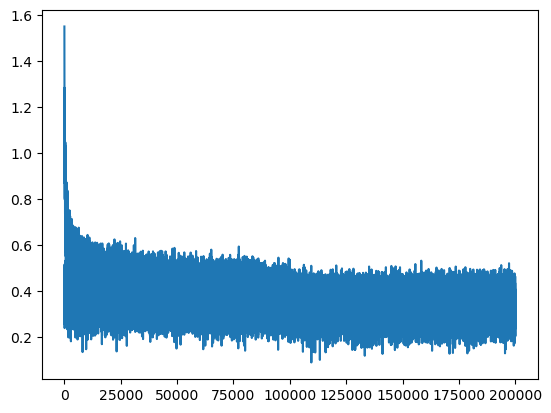

In [31]:
plt.plot(stepi, lossi)

In [41]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3028, grad_fn=<NllLossBackward0>)

In [42]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 66)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.5845, grad_fn=<NllLossBackward0>)

After our training loop, 2-D character based embedding get tuned with input we provide. Let's plot those embeddings on 2D graph to see if there any character clusters formed or not.

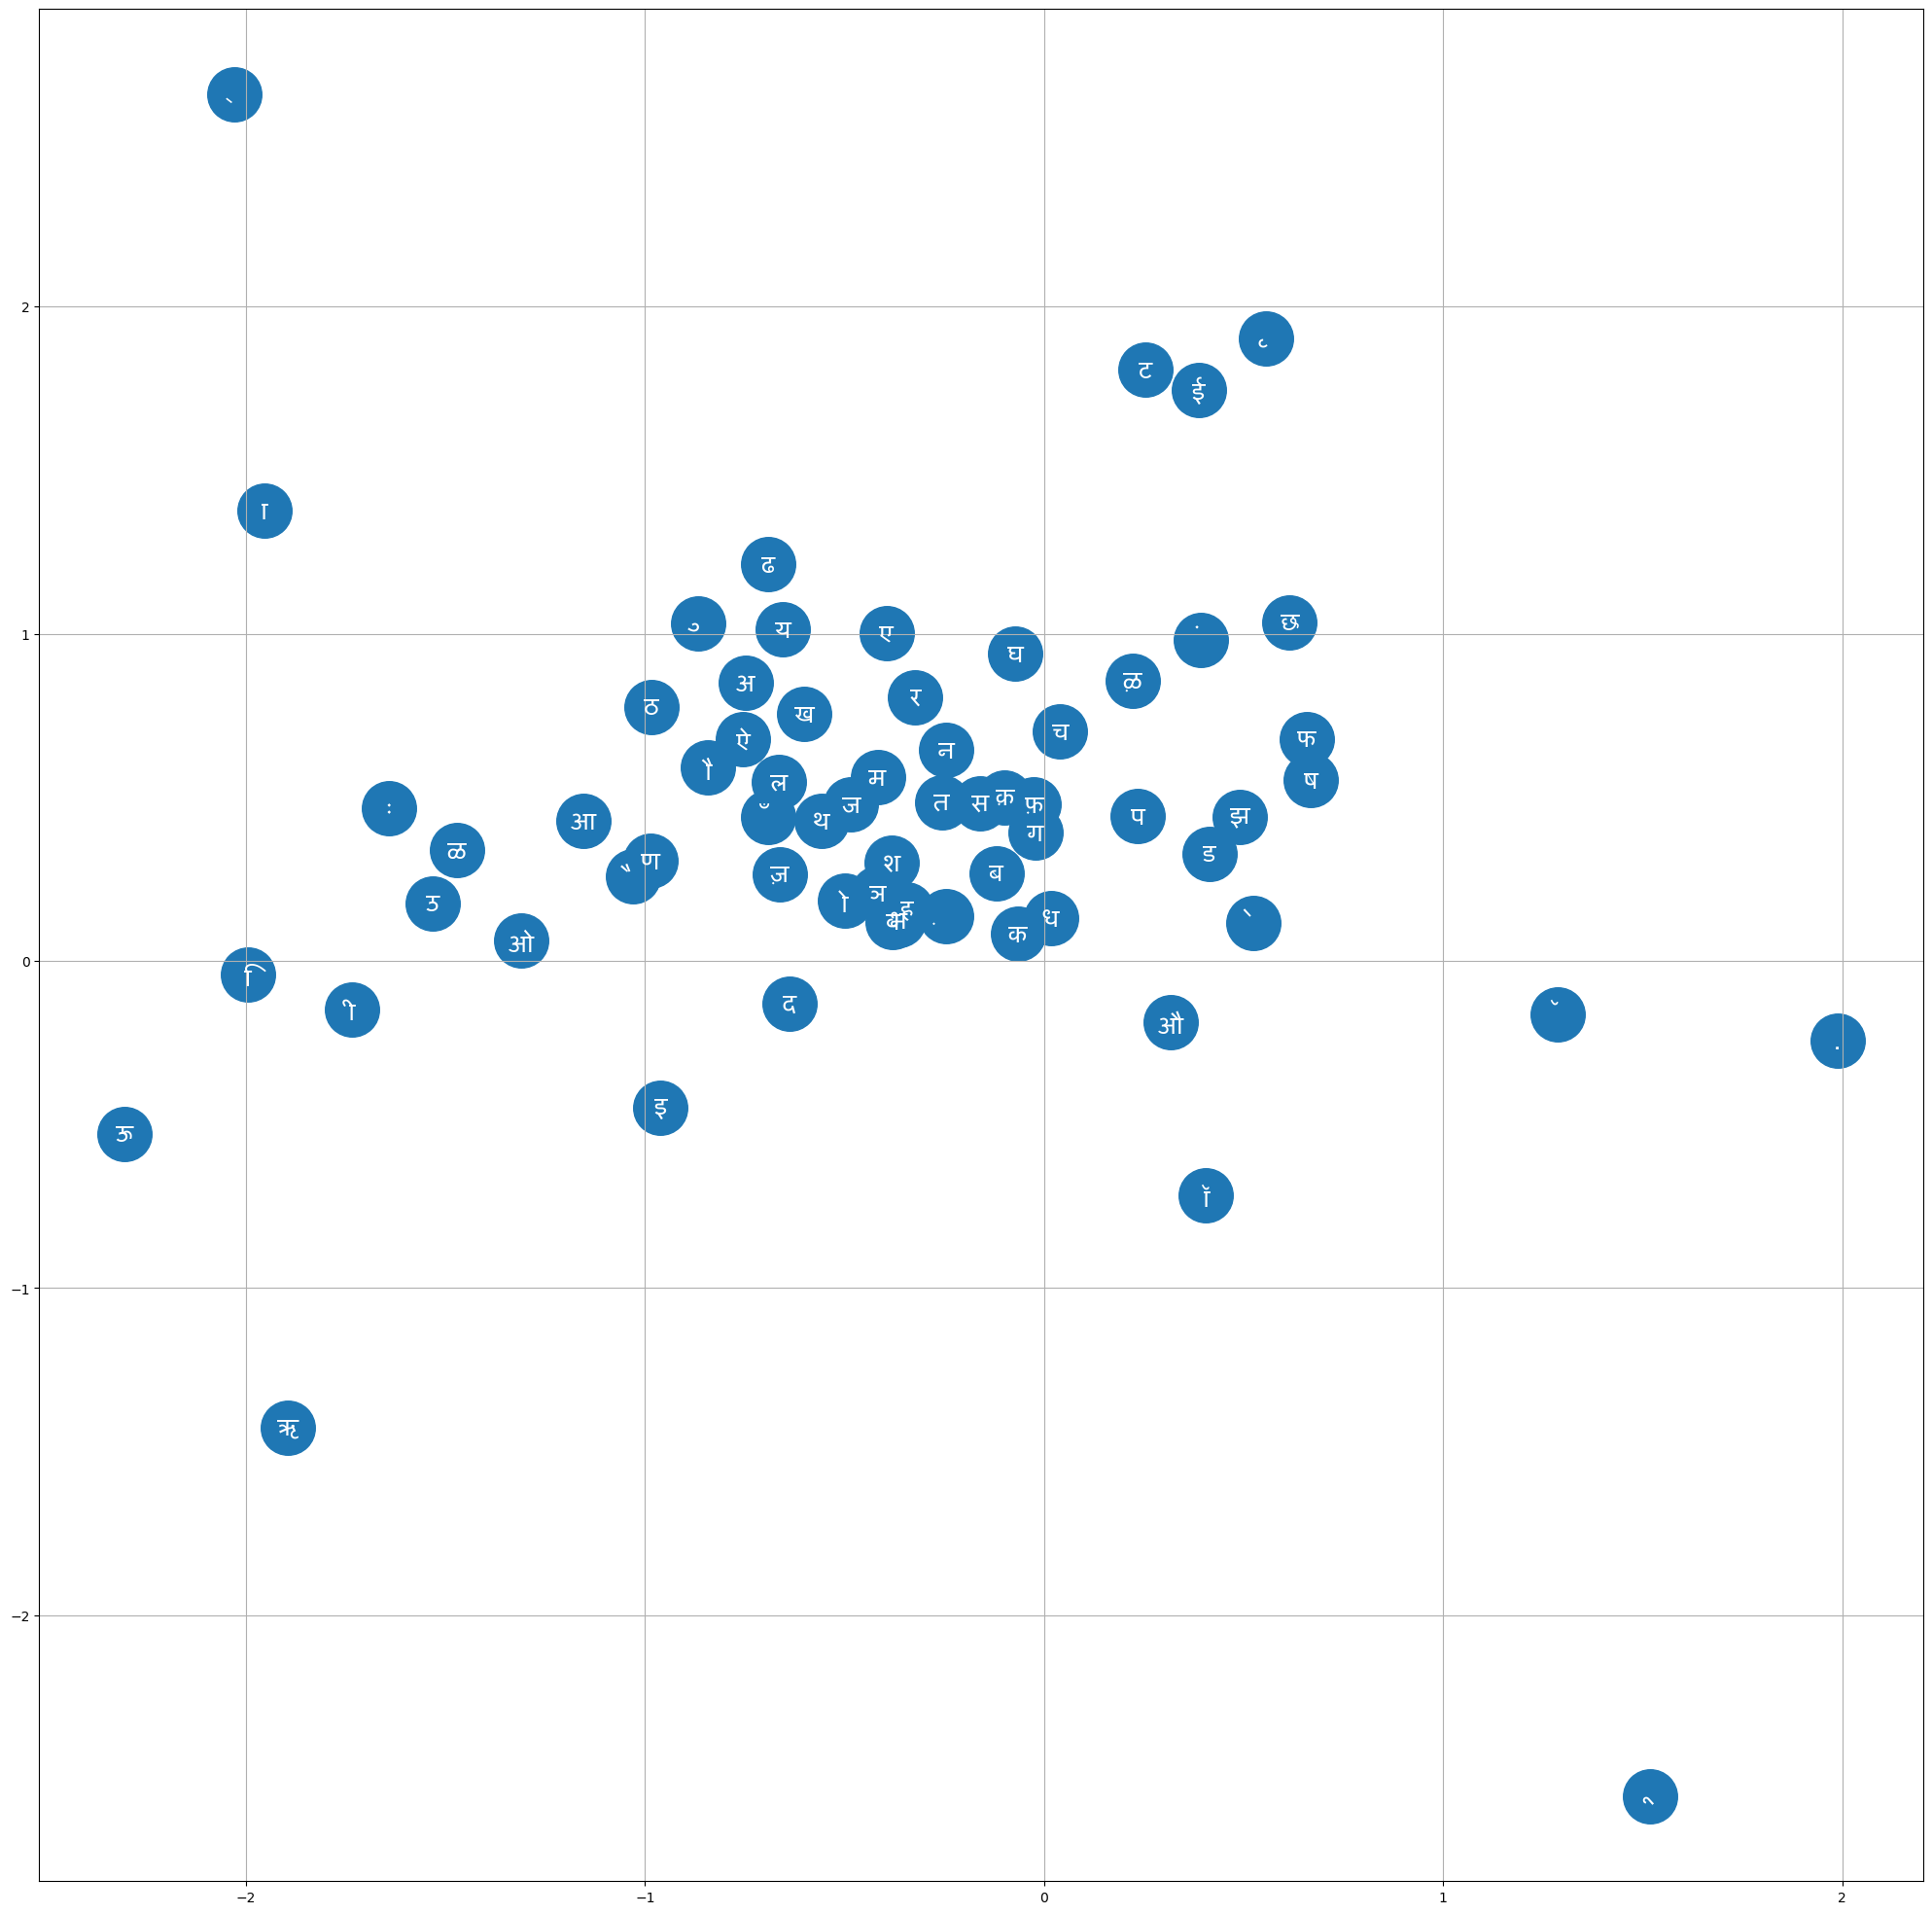

In [58]:
from matplotlib.font_manager import FontProperties
font_prop = FontProperties(fname='/Users/aadya/Downloads/Mangal/Mangal.ttf', size=18)

# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(25,25))
plt.scatter(C[:,0].data, C[:,1].data, s=1600)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white', fontproperties=font_prop)
plt.grid('minor')

In [44]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

As we can see character embeddings are now tuned with input, we can get more predictable Marathi names as compared to previous attempt.

In [65]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(5):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

शिबा.
अकद.
सुमिना.
मशर.
नील्सा.
